<a href="https://colab.research.google.com/github/Ssurf777/U-Net_pipe_flow/blob/main/U_net_pipe_flow_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CFD datasets import

In [1]:
import numpy as np
import requests

url = 'https://github.com/Ssurf777/U-Net_pipe_flow/raw/main/data/cfd_data.npy'
r = requests.get(url)

with open('cfd_data.npy', 'wb') as f:
  f.write(r.content)

data = np.load('cfd_data.npy')
data.shape


(163390, 7)

# Visualization datasets

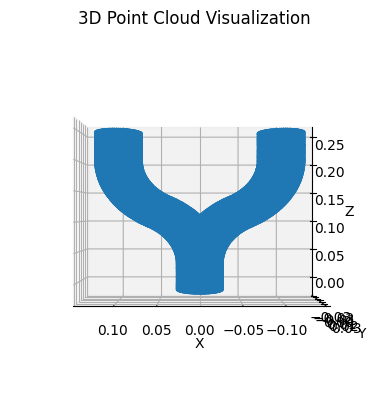

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extract x, y, and z columns
x = data[:, 0]
y = data[:, 1]
z = data[:, 2]

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, s=1)  # s controls the size of the points

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Point Cloud Visualization')

# Set the view angle to look from the positive y-axis
ax.view_init(elev=0, azim=90) # elev is elevation, azim is azimuthal angle

plt.show()


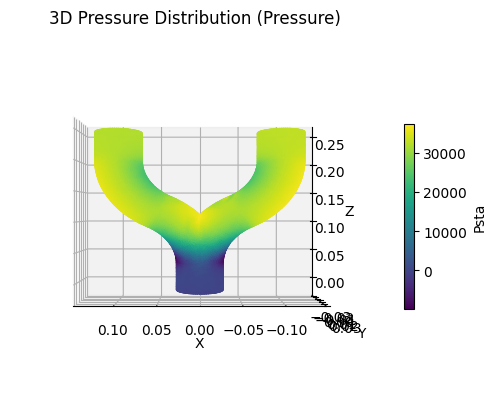

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# x, y, z, psta を想定通り取得している前提
x = data[:, 0]
y = data[:, 1]
z = data[:, 2]
psta = data[:, 6]

# カラーマップ付きの3D散布図
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x, y, z, c=psta, cmap='viridis', s=1)  # pstaを色として指定

# カラーバー追加
cbar = plt.colorbar(sc, ax=ax, shrink=0.5)
cbar.set_label('Psta')

# ラベルやビュー設定
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Pressure Distribution (Pressure)')
ax.view_init(elev=0, azim=90)

plt.show()


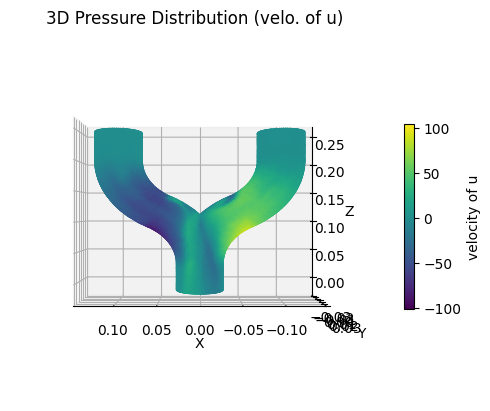

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# x, y, z, psta を想定通り取得している前提
x = data[:, 0]
y = data[:, 1]
z = data[:, 2]
psta = data[:, 3]

# カラーマップ付きの3D散布図
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x, y, z, c=psta, cmap='viridis', s=1)  # pstaを色として指定

# カラーバー追加
cbar = plt.colorbar(sc, ax=ax, shrink=0.5)
cbar.set_label('velocity of u')

# ラベルやビュー設定
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Pressure Distribution (velo. of u)')
ax.view_init(elev=0, azim=90)

plt.show()


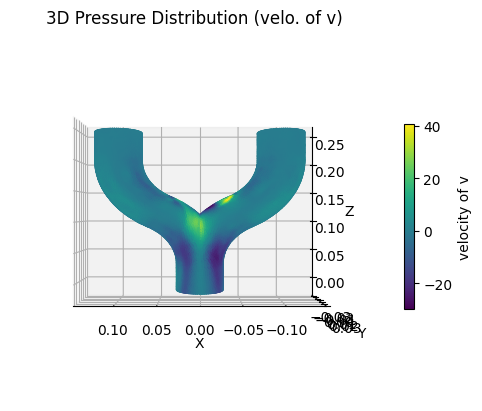

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# x, y, z, psta を想定通り取得している前提
x = data[:, 0]
y = data[:, 1]
z = data[:, 2]
psta = data[:, 4]

# カラーマップ付きの3D散布図
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x, y, z, c=psta, cmap='viridis', s=1)  # pstaを色として指定

# カラーバー追加
cbar = plt.colorbar(sc, ax=ax, shrink=0.5)
cbar.set_label('velocity of v')

# ラベルやビュー設定
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Pressure Distribution (velo. of v)')
ax.view_init(elev=0, azim=90)

plt.show()


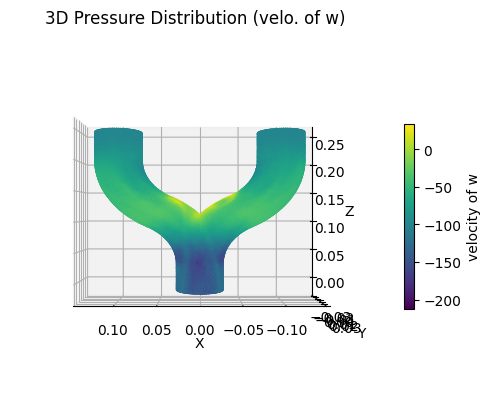

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# x, y, z, psta を想定通り取得している前提
x = data[:, 0]
y = data[:, 1]
z = data[:, 2]
psta = data[:, 5]

# カラーマップ付きの3D散布図
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x, y, z, c=psta, cmap='viridis', s=1)  # pstaを色として指定

# カラーバー追加
cbar = plt.colorbar(sc, ax=ax, shrink=0.5)
cbar.set_label('velocity of w')

# ラベルやビュー設定
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Pressure Distribution (velo. of w)')
ax.view_init(elev=0, azim=90)

plt.show()


# U-Net define

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def mish(x):
    return x * torch.tanh(F.softplus(x))

def init_weights_kaiming(module):
    if isinstance(module, nn.Conv1d):
        nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')  # Mish用のHeもrelu指定で問題なし
        if module.bias is not None:
            nn.init.zeros_(module.bias)

def init_weights_xavier(module):
    if isinstance(module, nn.Conv1d):
        gain = nn.init.calculate_gain('tanh')  # tanh に最適な gain を計算
        nn.init.xavier_normal_(module.weight, gain=gain)
        if module.bias is not None:
            nn.init.zeros_(module.bias)


class PointNetEncoder(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 256, 1)
        self.apply(init_weights_xavier)

    def forward(self, x):
        x = x.transpose(1, 2)        # [B, 3, N]
        x1 = F.tanh(self.conv1(x))     # [B, 64, N]
        x2 = F.tanh(self.conv2(x1))    # [B, 128, N]
        x3 = F.tanh(self.conv3(x2))    # [B, 256, N]
        return x1, x2, x3

class PointNetDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.upconv1 = nn.Conv1d(256 + 128, 128, 1)
        self.upconv2 = nn.Conv1d(128 + 64, 64, 1)
        self.out = nn.Conv1d(64, 4, 1)
        self.apply(init_weights_xavier)

    def forward(self, x1, x2, x3):
        up1 = F.tanh(self.upconv1(torch.cat([x3, x2], dim=1)))  # [B, 128, N]
        up2 = F.tanh(self.upconv2(torch.cat([up1, x1], dim=1))) # [B, 64, N]
        out = self.out(up2)                                   # [B, 4, N]
        return out.transpose(1, 2)                            # [B, N, 4]

class PointUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = PointNetEncoder()
        self.decoder = PointNetDecoder()

    def forward(self, x):  # x: [B, N, 3]
        x1, x2, x3 = self.encoder(x)
        out = self.decoder(x1, x2, x3)
        return out  # [B, N, 4]


# dataloader

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class CFDDataset(Dataset):
    def __init__(self, data_path):
        super().__init__()
        data = np.load(data_path)  # shape: (N, 7)
        self.inputs = data[:, 0:3].astype(np.float32)  # x, y, z
        #self.targets = data[:, 3:7].astype(np.float32)  # u, v, w, p
        self.targets = data[:, 6].astype(np.float32)  # p

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]


In [9]:
class CFDPointCloudDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, n_points=1024):
        data = np.load(data_path).astype(np.float32)  # shape: [N_total, 7]
        self.n_points = n_points
        self.inputs = data[:, 0:3]
        self.raw_targets = data[:, 6]

        self.p_min = self.raw_targets.min()
        self.p_max = self.raw_targets.max()
        self.targets = (self.raw_targets - self.p_min) / (self.p_max - self.p_min)

        total_points = len(self.inputs)
        total_groups = total_points // n_points
        self.inputs = self.inputs[:total_groups * n_points].reshape(total_groups, n_points, 3)
        self.targets = self.targets[:total_groups * n_points].reshape(total_groups, n_points, 1)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

    def inverse_transform(self, norm_p):
        return norm_p * (self.p_max - self.p_min) + self.p_min


In [10]:
import torch
from torch.utils.data import Dataset
import numpy as np

class CFDDataset2(Dataset):
    def __init__(self, data_path):
        super().__init__()
        data = np.load(data_path).astype(np.float32)  # shape: (N, 7)
        self.inputs = data[:, 0:3]    # x, y, z
        self.raw_targets = data[:, 6] # p

        # --- Min-Max Scaling ---
        self.p_min = self.raw_targets.min()
        self.p_max = self.raw_targets.max()
        self.targets = (self.raw_targets - self.p_min) / (self.p_max - self.p_min)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

    def inverse_transform(self, norm_p):
        """正規化されたpを元のスケールに戻す"""
        return norm_p * (self.p_max - self.p_min) + self.p_min


In [11]:
# データ読み込み
train_dataset = CFDPointCloudDataset('cfd_data.npy')
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=False, drop_last=False)

# note
独立点群のため、今後はk-meansなどで近距離点群を集めてバッチ化して学習できるようにすること

# Trainer

In [12]:
from torch import nn, optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PointUNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 5000
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_inputs, batch_targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch_inputs = batch_inputs.to(device)    # [B, N, 3]
        batch_targets = batch_targets.to(device)  # [B, N, 1]

        optimizer.zero_grad()
        outputs = model(batch_inputs)             # [B, N, 4]
        loss = criterion(outputs[:, :, 3:], batch_targets)  # 4番目の出力をMSE対象に
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1} - Loss: {epoch_loss / len(train_loader):.6f}")


Epoch 1/1000: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Epoch 1 - Loss: 0.143002


Epoch 2/1000: 100%|██████████| 1/1 [00:00<00:00, 15.24it/s]


Epoch 2 - Loss: 0.078633


Epoch 3/1000: 100%|██████████| 1/1 [00:00<00:00, 15.29it/s]


Epoch 3 - Loss: 0.055423


Epoch 4/1000: 100%|██████████| 1/1 [00:00<00:00, 17.15it/s]


Epoch 4 - Loss: 0.057105


Epoch 5/1000: 100%|██████████| 1/1 [00:00<00:00, 19.87it/s]


Epoch 5 - Loss: 0.062201


Epoch 6/1000: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch 6 - Loss: 0.060362


Epoch 7/1000: 100%|██████████| 1/1 [00:00<00:00, 20.28it/s]


Epoch 7 - Loss: 0.052857


Epoch 8/1000: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch 8 - Loss: 0.044779


Epoch 9/1000: 100%|██████████| 1/1 [00:00<00:00, 20.33it/s]


Epoch 9 - Loss: 0.040155


Epoch 10/1000: 100%|██████████| 1/1 [00:00<00:00, 20.70it/s]


Epoch 10 - Loss: 0.039966


Epoch 11/1000: 100%|██████████| 1/1 [00:00<00:00, 20.11it/s]


Epoch 11 - Loss: 0.042176


Epoch 12/1000: 100%|██████████| 1/1 [00:00<00:00, 20.51it/s]


Epoch 12 - Loss: 0.043611


Epoch 13/1000: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch 13 - Loss: 0.042258


Epoch 14/1000: 100%|██████████| 1/1 [00:00<00:00, 20.06it/s]


Epoch 14 - Loss: 0.038143


Epoch 15/1000: 100%|██████████| 1/1 [00:00<00:00, 20.51it/s]


Epoch 15 - Loss: 0.032756


Epoch 16/1000: 100%|██████████| 1/1 [00:00<00:00, 20.25it/s]


Epoch 16 - Loss: 0.027958


Epoch 17/1000: 100%|██████████| 1/1 [00:00<00:00, 20.84it/s]


Epoch 17 - Loss: 0.025044


Epoch 18/1000: 100%|██████████| 1/1 [00:00<00:00, 20.14it/s]


Epoch 18 - Loss: 0.024235


Epoch 19/1000: 100%|██████████| 1/1 [00:00<00:00, 20.66it/s]


Epoch 19 - Loss: 0.024743


Epoch 20/1000: 100%|██████████| 1/1 [00:00<00:00, 20.31it/s]


Epoch 20 - Loss: 0.025348


Epoch 21/1000: 100%|██████████| 1/1 [00:00<00:00, 20.31it/s]


Epoch 21 - Loss: 0.025146


Epoch 22/1000: 100%|██████████| 1/1 [00:00<00:00, 20.54it/s]


Epoch 22 - Loss: 0.023969


Epoch 23/1000: 100%|██████████| 1/1 [00:00<00:00, 20.26it/s]


Epoch 23 - Loss: 0.022287


Epoch 24/1000: 100%|██████████| 1/1 [00:00<00:00, 20.06it/s]


Epoch 24 - Loss: 0.020779


Epoch 25/1000: 100%|██████████| 1/1 [00:00<00:00, 20.09it/s]


Epoch 25 - Loss: 0.019877


Epoch 26/1000: 100%|██████████| 1/1 [00:00<00:00, 20.12it/s]


Epoch 26 - Loss: 0.019550


Epoch 27/1000: 100%|██████████| 1/1 [00:00<00:00, 20.37it/s]


Epoch 27 - Loss: 0.019400


Epoch 28/1000: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch 28 - Loss: 0.018986


Epoch 29/1000: 100%|██████████| 1/1 [00:00<00:00, 19.99it/s]


Epoch 29 - Loss: 0.018129


Epoch 30/1000: 100%|██████████| 1/1 [00:00<00:00, 20.30it/s]


Epoch 30 - Loss: 0.017008


Epoch 31/1000: 100%|██████████| 1/1 [00:00<00:00, 19.93it/s]


Epoch 31 - Loss: 0.016011


Epoch 32/1000: 100%|██████████| 1/1 [00:00<00:00, 20.03it/s]


Epoch 32 - Loss: 0.015462


Epoch 33/1000: 100%|██████████| 1/1 [00:00<00:00, 20.49it/s]


Epoch 33 - Loss: 0.015419


Epoch 34/1000: 100%|██████████| 1/1 [00:00<00:00, 19.81it/s]


Epoch 34 - Loss: 0.015656


Epoch 35/1000: 100%|██████████| 1/1 [00:00<00:00, 19.91it/s]


Epoch 35 - Loss: 0.015834


Epoch 36/1000: 100%|██████████| 1/1 [00:00<00:00, 20.33it/s]


Epoch 36 - Loss: 0.015721


Epoch 37/1000: 100%|██████████| 1/1 [00:00<00:00, 20.18it/s]


Epoch 37 - Loss: 0.015320


Epoch 38/1000: 100%|██████████| 1/1 [00:00<00:00, 20.47it/s]


Epoch 38 - Loss: 0.014818


Epoch 39/1000: 100%|██████████| 1/1 [00:00<00:00, 20.17it/s]


Epoch 39 - Loss: 0.014432


Epoch 40/1000: 100%|██████████| 1/1 [00:00<00:00, 20.10it/s]


Epoch 40 - Loss: 0.014251


Epoch 41/1000: 100%|██████████| 1/1 [00:00<00:00, 20.85it/s]


Epoch 41 - Loss: 0.014211


Epoch 42/1000: 100%|██████████| 1/1 [00:00<00:00, 19.88it/s]


Epoch 42 - Loss: 0.014163


Epoch 43/1000: 100%|██████████| 1/1 [00:00<00:00, 20.39it/s]


Epoch 43 - Loss: 0.014009


Epoch 44/1000: 100%|██████████| 1/1 [00:00<00:00, 19.89it/s]


Epoch 44 - Loss: 0.013765


Epoch 45/1000: 100%|██████████| 1/1 [00:00<00:00, 19.85it/s]


Epoch 45 - Loss: 0.013534


Epoch 46/1000: 100%|██████████| 1/1 [00:00<00:00, 20.87it/s]


Epoch 46 - Loss: 0.013409


Epoch 47/1000: 100%|██████████| 1/1 [00:00<00:00, 20.21it/s]


Epoch 47 - Loss: 0.013399


Epoch 48/1000: 100%|██████████| 1/1 [00:00<00:00, 20.36it/s]


Epoch 48 - Loss: 0.013426


Epoch 49/1000: 100%|██████████| 1/1 [00:00<00:00, 19.84it/s]


Epoch 49 - Loss: 0.013390


Epoch 50/1000: 100%|██████████| 1/1 [00:00<00:00, 20.17it/s]


Epoch 50 - Loss: 0.013250


Epoch 51/1000: 100%|██████████| 1/1 [00:00<00:00, 20.67it/s]


Epoch 51 - Loss: 0.013041


Epoch 52/1000: 100%|██████████| 1/1 [00:00<00:00, 20.28it/s]


Epoch 52 - Loss: 0.012842


Epoch 53/1000: 100%|██████████| 1/1 [00:00<00:00, 20.55it/s]


Epoch 53 - Loss: 0.012707


Epoch 54/1000: 100%|██████████| 1/1 [00:00<00:00, 19.81it/s]


Epoch 54 - Loss: 0.012632


Epoch 55/1000: 100%|██████████| 1/1 [00:00<00:00, 16.97it/s]


Epoch 55 - Loss: 0.012570


Epoch 56/1000: 100%|██████████| 1/1 [00:00<00:00, 20.35it/s]


Epoch 56 - Loss: 0.012479


Epoch 57/1000: 100%|██████████| 1/1 [00:00<00:00, 19.74it/s]


Epoch 57 - Loss: 0.012352


Epoch 58/1000: 100%|██████████| 1/1 [00:00<00:00, 20.70it/s]


Epoch 58 - Loss: 0.012221


Epoch 59/1000: 100%|██████████| 1/1 [00:00<00:00, 20.08it/s]


Epoch 59 - Loss: 0.012115


Epoch 60/1000: 100%|██████████| 1/1 [00:00<00:00, 20.39it/s]


Epoch 60 - Loss: 0.012037


Epoch 61/1000: 100%|██████████| 1/1 [00:00<00:00, 20.34it/s]


Epoch 61 - Loss: 0.011962


Epoch 62/1000: 100%|██████████| 1/1 [00:00<00:00, 17.11it/s]


Epoch 62 - Loss: 0.011864


Epoch 63/1000: 100%|██████████| 1/1 [00:00<00:00, 20.60it/s]


Epoch 63 - Loss: 0.011738


Epoch 64/1000: 100%|██████████| 1/1 [00:00<00:00, 20.21it/s]


Epoch 64 - Loss: 0.011604


Epoch 65/1000: 100%|██████████| 1/1 [00:00<00:00, 20.86it/s]


Epoch 65 - Loss: 0.011487


Epoch 66/1000: 100%|██████████| 1/1 [00:00<00:00, 20.84it/s]


Epoch 66 - Loss: 0.011395


Epoch 67/1000: 100%|██████████| 1/1 [00:00<00:00, 20.61it/s]


Epoch 67 - Loss: 0.011318


Epoch 68/1000: 100%|██████████| 1/1 [00:00<00:00, 20.70it/s]


Epoch 68 - Loss: 0.011235


Epoch 69/1000: 100%|██████████| 1/1 [00:00<00:00, 15.24it/s]


Epoch 69 - Loss: 0.011140


Epoch 70/1000: 100%|██████████| 1/1 [00:00<00:00, 16.13it/s]


Epoch 70 - Loss: 0.011039


Epoch 71/1000: 100%|██████████| 1/1 [00:00<00:00, 18.50it/s]


Epoch 71 - Loss: 0.010944


Epoch 72/1000: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


Epoch 72 - Loss: 0.010859


Epoch 73/1000: 100%|██████████| 1/1 [00:00<00:00, 13.18it/s]


Epoch 73 - Loss: 0.010778


Epoch 74/1000: 100%|██████████| 1/1 [00:00<00:00, 15.02it/s]


Epoch 74 - Loss: 0.010692


Epoch 75/1000: 100%|██████████| 1/1 [00:00<00:00, 18.32it/s]


Epoch 75 - Loss: 0.010600


Epoch 76/1000: 100%|██████████| 1/1 [00:00<00:00, 19.95it/s]


Epoch 76 - Loss: 0.010507


Epoch 77/1000: 100%|██████████| 1/1 [00:00<00:00, 20.38it/s]


Epoch 77 - Loss: 0.010421


Epoch 78/1000: 100%|██████████| 1/1 [00:00<00:00, 16.45it/s]


Epoch 78 - Loss: 0.010344


Epoch 79/1000: 100%|██████████| 1/1 [00:00<00:00, 20.82it/s]


Epoch 79 - Loss: 0.010271


Epoch 80/1000: 100%|██████████| 1/1 [00:00<00:00, 20.11it/s]


Epoch 80 - Loss: 0.010195


Epoch 81/1000: 100%|██████████| 1/1 [00:00<00:00, 18.15it/s]


Epoch 81 - Loss: 0.010115


Epoch 82/1000: 100%|██████████| 1/1 [00:00<00:00, 15.76it/s]


Epoch 82 - Loss: 0.010034


Epoch 83/1000: 100%|██████████| 1/1 [00:00<00:00, 19.23it/s]


Epoch 83 - Loss: 0.009956


Epoch 84/1000: 100%|██████████| 1/1 [00:00<00:00, 20.28it/s]


Epoch 84 - Loss: 0.009882


Epoch 85/1000: 100%|██████████| 1/1 [00:00<00:00, 14.69it/s]


Epoch 85 - Loss: 0.009809


Epoch 86/1000: 100%|██████████| 1/1 [00:00<00:00, 19.10it/s]


Epoch 86 - Loss: 0.009734


Epoch 87/1000: 100%|██████████| 1/1 [00:00<00:00, 19.49it/s]


Epoch 87 - Loss: 0.009659


Epoch 88/1000: 100%|██████████| 1/1 [00:00<00:00, 19.52it/s]


Epoch 88 - Loss: 0.009586


Epoch 89/1000: 100%|██████████| 1/1 [00:00<00:00, 20.20it/s]


Epoch 89 - Loss: 0.009517


Epoch 90/1000: 100%|██████████| 1/1 [00:00<00:00, 18.64it/s]


Epoch 90 - Loss: 0.009450


Epoch 91/1000: 100%|██████████| 1/1 [00:00<00:00, 16.42it/s]


Epoch 91 - Loss: 0.009383


Epoch 92/1000: 100%|██████████| 1/1 [00:00<00:00, 20.38it/s]


Epoch 92 - Loss: 0.009316


Epoch 93/1000: 100%|██████████| 1/1 [00:00<00:00, 18.69it/s]


Epoch 93 - Loss: 0.009248


Epoch 94/1000: 100%|██████████| 1/1 [00:00<00:00, 19.70it/s]


Epoch 94 - Loss: 0.009183


Epoch 95/1000: 100%|██████████| 1/1 [00:00<00:00, 16.47it/s]


Epoch 95 - Loss: 0.009120


Epoch 96/1000: 100%|██████████| 1/1 [00:00<00:00, 15.39it/s]


Epoch 96 - Loss: 0.009058


Epoch 97/1000: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


Epoch 97 - Loss: 0.008997


Epoch 98/1000: 100%|██████████| 1/1 [00:00<00:00, 19.58it/s]


Epoch 98 - Loss: 0.008937


Epoch 99/1000: 100%|██████████| 1/1 [00:00<00:00, 19.67it/s]


Epoch 99 - Loss: 0.008878


Epoch 100/1000: 100%|██████████| 1/1 [00:00<00:00, 19.31it/s]


Epoch 100 - Loss: 0.008821


Epoch 101/1000: 100%|██████████| 1/1 [00:00<00:00, 19.91it/s]


Epoch 101 - Loss: 0.008766


Epoch 102/1000: 100%|██████████| 1/1 [00:00<00:00, 20.50it/s]


Epoch 102 - Loss: 0.008712


Epoch 103/1000: 100%|██████████| 1/1 [00:00<00:00, 19.97it/s]


Epoch 103 - Loss: 0.008658


Epoch 104/1000: 100%|██████████| 1/1 [00:00<00:00, 20.28it/s]


Epoch 104 - Loss: 0.008605


Epoch 105/1000: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Epoch 105 - Loss: 0.008554


Epoch 106/1000: 100%|██████████| 1/1 [00:00<00:00, 17.08it/s]


Epoch 106 - Loss: 0.008505


Epoch 107/1000: 100%|██████████| 1/1 [00:00<00:00, 19.99it/s]


Epoch 107 - Loss: 0.008456


Epoch 108/1000: 100%|██████████| 1/1 [00:00<00:00, 19.88it/s]


Epoch 108 - Loss: 0.008409


Epoch 109/1000: 100%|██████████| 1/1 [00:00<00:00, 19.96it/s]


Epoch 109 - Loss: 0.008363


Epoch 110/1000: 100%|██████████| 1/1 [00:00<00:00, 19.37it/s]


Epoch 110 - Loss: 0.008318


Epoch 111/1000: 100%|██████████| 1/1 [00:00<00:00, 19.75it/s]


Epoch 111 - Loss: 0.008275


Epoch 112/1000: 100%|██████████| 1/1 [00:00<00:00, 20.17it/s]


Epoch 112 - Loss: 0.008232


Epoch 113/1000: 100%|██████████| 1/1 [00:00<00:00, 20.49it/s]


Epoch 113 - Loss: 0.008191


Epoch 114/1000: 100%|██████████| 1/1 [00:00<00:00, 19.77it/s]


Epoch 114 - Loss: 0.008151


Epoch 115/1000: 100%|██████████| 1/1 [00:00<00:00, 16.66it/s]


Epoch 115 - Loss: 0.008111


Epoch 116/1000: 100%|██████████| 1/1 [00:00<00:00, 20.48it/s]


Epoch 116 - Loss: 0.008073


Epoch 117/1000: 100%|██████████| 1/1 [00:00<00:00, 14.04it/s]


Epoch 117 - Loss: 0.008036


Epoch 118/1000: 100%|██████████| 1/1 [00:00<00:00, 19.07it/s]


Epoch 118 - Loss: 0.008001


Epoch 119/1000: 100%|██████████| 1/1 [00:00<00:00, 15.73it/s]


Epoch 119 - Loss: 0.007966


Epoch 120/1000: 100%|██████████| 1/1 [00:00<00:00, 18.63it/s]


Epoch 120 - Loss: 0.007932


Epoch 121/1000: 100%|██████████| 1/1 [00:00<00:00, 18.53it/s]


Epoch 121 - Loss: 0.007899


Epoch 122/1000: 100%|██████████| 1/1 [00:00<00:00, 19.36it/s]


Epoch 122 - Loss: 0.007868


Epoch 123/1000: 100%|██████████| 1/1 [00:00<00:00, 19.60it/s]


Epoch 123 - Loss: 0.007837


Epoch 124/1000: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]


Epoch 124 - Loss: 0.007807


Epoch 125/1000: 100%|██████████| 1/1 [00:00<00:00, 14.53it/s]


Epoch 125 - Loss: 0.007778


Epoch 126/1000: 100%|██████████| 1/1 [00:00<00:00, 16.27it/s]


Epoch 126 - Loss: 0.007750


Epoch 127/1000: 100%|██████████| 1/1 [00:00<00:00, 16.58it/s]


Epoch 127 - Loss: 0.007723


Epoch 128/1000: 100%|██████████| 1/1 [00:00<00:00, 15.73it/s]


Epoch 128 - Loss: 0.007697


Epoch 129/1000: 100%|██████████| 1/1 [00:00<00:00, 14.45it/s]


Epoch 129 - Loss: 0.007672


Epoch 130/1000: 100%|██████████| 1/1 [00:00<00:00, 18.53it/s]


Epoch 130 - Loss: 0.007648


Epoch 131/1000: 100%|██████████| 1/1 [00:00<00:00, 14.92it/s]


Epoch 131 - Loss: 0.007624


Epoch 132/1000: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch 132 - Loss: 0.007601


Epoch 133/1000: 100%|██████████| 1/1 [00:00<00:00, 16.80it/s]


Epoch 133 - Loss: 0.007579


Epoch 134/1000: 100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


Epoch 134 - Loss: 0.007558


Epoch 135/1000: 100%|██████████| 1/1 [00:00<00:00, 13.09it/s]


Epoch 135 - Loss: 0.007538


Epoch 136/1000: 100%|██████████| 1/1 [00:00<00:00, 15.30it/s]


Epoch 136 - Loss: 0.007518


Epoch 137/1000: 100%|██████████| 1/1 [00:00<00:00, 17.27it/s]


Epoch 137 - Loss: 0.007499


Epoch 138/1000: 100%|██████████| 1/1 [00:00<00:00, 18.58it/s]


Epoch 138 - Loss: 0.007481


Epoch 139/1000: 100%|██████████| 1/1 [00:00<00:00, 16.51it/s]


Epoch 139 - Loss: 0.007463


Epoch 140/1000: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]


Epoch 140 - Loss: 0.007446


Epoch 141/1000: 100%|██████████| 1/1 [00:00<00:00, 18.36it/s]


Epoch 141 - Loss: 0.007430


Epoch 142/1000: 100%|██████████| 1/1 [00:00<00:00, 15.39it/s]


Epoch 142 - Loss: 0.007414


Epoch 143/1000: 100%|██████████| 1/1 [00:00<00:00, 17.08it/s]


Epoch 143 - Loss: 0.007399


Epoch 144/1000: 100%|██████████| 1/1 [00:00<00:00, 18.09it/s]


Epoch 144 - Loss: 0.007384


Epoch 145/1000: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s]


Epoch 145 - Loss: 0.007370


Epoch 146/1000: 100%|██████████| 1/1 [00:00<00:00, 18.68it/s]


Epoch 146 - Loss: 0.007356


Epoch 147/1000: 100%|██████████| 1/1 [00:00<00:00, 19.81it/s]


Epoch 147 - Loss: 0.007343


Epoch 148/1000: 100%|██████████| 1/1 [00:00<00:00, 20.37it/s]


Epoch 148 - Loss: 0.007331


Epoch 149/1000: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s]


Epoch 149 - Loss: 0.007319


Epoch 150/1000: 100%|██████████| 1/1 [00:00<00:00, 20.11it/s]


Epoch 150 - Loss: 0.007307


Epoch 151/1000: 100%|██████████| 1/1 [00:00<00:00, 17.09it/s]


Epoch 151 - Loss: 0.007296


Epoch 152/1000: 100%|██████████| 1/1 [00:00<00:00, 15.66it/s]


Epoch 152 - Loss: 0.007285


Epoch 153/1000: 100%|██████████| 1/1 [00:00<00:00, 16.41it/s]


Epoch 153 - Loss: 0.007275


Epoch 154/1000: 100%|██████████| 1/1 [00:00<00:00, 18.76it/s]


Epoch 154 - Loss: 0.007264


Epoch 155/1000: 100%|██████████| 1/1 [00:00<00:00, 15.25it/s]


Epoch 155 - Loss: 0.007255


Epoch 156/1000: 100%|██████████| 1/1 [00:00<00:00, 18.54it/s]


Epoch 156 - Loss: 0.007246


Epoch 157/1000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 157 - Loss: 0.007237


Epoch 158/1000: 100%|██████████| 1/1 [00:00<00:00, 19.38it/s]


Epoch 158 - Loss: 0.007228


Epoch 159/1000: 100%|██████████| 1/1 [00:00<00:00, 19.51it/s]


Epoch 159 - Loss: 0.007220


Epoch 160/1000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 160 - Loss: 0.007212


Epoch 161/1000: 100%|██████████| 1/1 [00:00<00:00, 17.03it/s]


Epoch 161 - Loss: 0.007204


Epoch 162/1000: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s]


Epoch 162 - Loss: 0.007196


Epoch 163/1000: 100%|██████████| 1/1 [00:00<00:00, 20.46it/s]


Epoch 163 - Loss: 0.007189


Epoch 164/1000: 100%|██████████| 1/1 [00:00<00:00, 16.69it/s]


Epoch 164 - Loss: 0.007182


Epoch 165/1000: 100%|██████████| 1/1 [00:00<00:00, 18.58it/s]


Epoch 165 - Loss: 0.007175


Epoch 166/1000: 100%|██████████| 1/1 [00:00<00:00, 15.63it/s]


Epoch 166 - Loss: 0.007169


Epoch 167/1000: 100%|██████████| 1/1 [00:00<00:00, 18.31it/s]


Epoch 167 - Loss: 0.007163


Epoch 168/1000: 100%|██████████| 1/1 [00:00<00:00, 19.15it/s]


Epoch 168 - Loss: 0.007157


Epoch 169/1000: 100%|██████████| 1/1 [00:00<00:00, 19.40it/s]


Epoch 169 - Loss: 0.007151


Epoch 170/1000: 100%|██████████| 1/1 [00:00<00:00, 20.30it/s]


Epoch 170 - Loss: 0.007145


Epoch 171/1000: 100%|██████████| 1/1 [00:00<00:00, 19.74it/s]


Epoch 171 - Loss: 0.007140


Epoch 172/1000: 100%|██████████| 1/1 [00:00<00:00, 19.35it/s]


Epoch 172 - Loss: 0.007134


Epoch 173/1000: 100%|██████████| 1/1 [00:00<00:00, 20.66it/s]


Epoch 173 - Loss: 0.007129


Epoch 174/1000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 174 - Loss: 0.007124


Epoch 175/1000: 100%|██████████| 1/1 [00:00<00:00, 20.18it/s]


Epoch 175 - Loss: 0.007119


Epoch 176/1000: 100%|██████████| 1/1 [00:00<00:00, 20.30it/s]


Epoch 176 - Loss: 0.007114


Epoch 177/1000: 100%|██████████| 1/1 [00:00<00:00, 20.03it/s]


Epoch 177 - Loss: 0.007110


Epoch 178/1000: 100%|██████████| 1/1 [00:00<00:00, 19.44it/s]


Epoch 178 - Loss: 0.007105


Epoch 179/1000: 100%|██████████| 1/1 [00:00<00:00, 19.76it/s]


Epoch 179 - Loss: 0.007101


Epoch 180/1000: 100%|██████████| 1/1 [00:00<00:00, 20.02it/s]


Epoch 180 - Loss: 0.007096


Epoch 181/1000: 100%|██████████| 1/1 [00:00<00:00, 19.99it/s]


Epoch 181 - Loss: 0.007092


Epoch 182/1000: 100%|██████████| 1/1 [00:00<00:00, 20.26it/s]


Epoch 182 - Loss: 0.007088


Epoch 183/1000: 100%|██████████| 1/1 [00:00<00:00, 20.23it/s]


Epoch 183 - Loss: 0.007084


Epoch 184/1000: 100%|██████████| 1/1 [00:00<00:00, 19.99it/s]


Epoch 184 - Loss: 0.007080


Epoch 185/1000: 100%|██████████| 1/1 [00:00<00:00, 19.37it/s]


Epoch 185 - Loss: 0.007076


Epoch 186/1000: 100%|██████████| 1/1 [00:00<00:00, 19.90it/s]


Epoch 186 - Loss: 0.007072


Epoch 187/1000: 100%|██████████| 1/1 [00:00<00:00, 19.96it/s]


Epoch 187 - Loss: 0.007069


Epoch 188/1000: 100%|██████████| 1/1 [00:00<00:00, 20.60it/s]


Epoch 188 - Loss: 0.007065


Epoch 189/1000: 100%|██████████| 1/1 [00:00<00:00, 19.99it/s]


Epoch 189 - Loss: 0.007062


Epoch 190/1000: 100%|██████████| 1/1 [00:00<00:00, 19.76it/s]


Epoch 190 - Loss: 0.007058


Epoch 191/1000: 100%|██████████| 1/1 [00:00<00:00, 19.93it/s]


Epoch 191 - Loss: 0.007055


Epoch 192/1000: 100%|██████████| 1/1 [00:00<00:00, 19.88it/s]


Epoch 192 - Loss: 0.007051


Epoch 193/1000: 100%|██████████| 1/1 [00:00<00:00, 20.56it/s]


Epoch 193 - Loss: 0.007048


Epoch 194/1000: 100%|██████████| 1/1 [00:00<00:00, 20.03it/s]


Epoch 194 - Loss: 0.007045


Epoch 195/1000: 100%|██████████| 1/1 [00:00<00:00, 20.42it/s]


Epoch 195 - Loss: 0.007042


Epoch 196/1000: 100%|██████████| 1/1 [00:00<00:00, 20.07it/s]


Epoch 196 - Loss: 0.007038


Epoch 197/1000: 100%|██████████| 1/1 [00:00<00:00, 19.66it/s]


Epoch 197 - Loss: 0.007035


Epoch 198/1000: 100%|██████████| 1/1 [00:00<00:00, 19.61it/s]


Epoch 198 - Loss: 0.007032


Epoch 199/1000: 100%|██████████| 1/1 [00:00<00:00, 20.28it/s]


Epoch 199 - Loss: 0.007029


Epoch 200/1000: 100%|██████████| 1/1 [00:00<00:00, 20.01it/s]


Epoch 200 - Loss: 0.007026


Epoch 201/1000: 100%|██████████| 1/1 [00:00<00:00, 20.25it/s]


Epoch 201 - Loss: 0.007023


Epoch 202/1000: 100%|██████████| 1/1 [00:00<00:00, 19.66it/s]


Epoch 202 - Loss: 0.007020


Epoch 203/1000: 100%|██████████| 1/1 [00:00<00:00, 20.05it/s]


Epoch 203 - Loss: 0.007017


Epoch 204/1000: 100%|██████████| 1/1 [00:00<00:00, 20.10it/s]


Epoch 204 - Loss: 0.007014


Epoch 205/1000: 100%|██████████| 1/1 [00:00<00:00, 19.57it/s]


Epoch 205 - Loss: 0.007011


Epoch 206/1000: 100%|██████████| 1/1 [00:00<00:00, 20.31it/s]


Epoch 206 - Loss: 0.007009


Epoch 207/1000: 100%|██████████| 1/1 [00:00<00:00, 19.82it/s]


Epoch 207 - Loss: 0.007006


Epoch 208/1000: 100%|██████████| 1/1 [00:00<00:00, 19.96it/s]


Epoch 208 - Loss: 0.007003


Epoch 209/1000: 100%|██████████| 1/1 [00:00<00:00, 20.54it/s]


Epoch 209 - Loss: 0.007000


Epoch 210/1000: 100%|██████████| 1/1 [00:00<00:00, 19.56it/s]


Epoch 210 - Loss: 0.006997


Epoch 211/1000: 100%|██████████| 1/1 [00:00<00:00, 19.97it/s]


Epoch 211 - Loss: 0.006995


Epoch 212/1000: 100%|██████████| 1/1 [00:00<00:00, 20.20it/s]


Epoch 212 - Loss: 0.006992


Epoch 213/1000: 100%|██████████| 1/1 [00:00<00:00, 20.02it/s]


Epoch 213 - Loss: 0.006989


Epoch 214/1000: 100%|██████████| 1/1 [00:00<00:00, 20.15it/s]


Epoch 214 - Loss: 0.006987


Epoch 215/1000: 100%|██████████| 1/1 [00:00<00:00, 19.77it/s]


Epoch 215 - Loss: 0.006984


Epoch 216/1000: 100%|██████████| 1/1 [00:00<00:00, 20.22it/s]


Epoch 216 - Loss: 0.006981


Epoch 217/1000: 100%|██████████| 1/1 [00:00<00:00, 20.39it/s]


Epoch 217 - Loss: 0.006979


Epoch 218/1000: 100%|██████████| 1/1 [00:00<00:00, 19.32it/s]


Epoch 218 - Loss: 0.006976


Epoch 219/1000: 100%|██████████| 1/1 [00:00<00:00, 20.10it/s]


Epoch 219 - Loss: 0.006973


Epoch 220/1000: 100%|██████████| 1/1 [00:00<00:00, 19.97it/s]


Epoch 220 - Loss: 0.006971


Epoch 221/1000: 100%|██████████| 1/1 [00:00<00:00, 19.83it/s]


Epoch 221 - Loss: 0.006968


Epoch 222/1000: 100%|██████████| 1/1 [00:00<00:00, 20.10it/s]


Epoch 222 - Loss: 0.006966


Epoch 223/1000: 100%|██████████| 1/1 [00:00<00:00, 19.58it/s]


Epoch 223 - Loss: 0.006963


Epoch 224/1000: 100%|██████████| 1/1 [00:00<00:00, 19.66it/s]


Epoch 224 - Loss: 0.006961


Epoch 225/1000: 100%|██████████| 1/1 [00:00<00:00, 20.20it/s]


Epoch 225 - Loss: 0.006958


Epoch 226/1000: 100%|██████████| 1/1 [00:00<00:00, 19.84it/s]


Epoch 226 - Loss: 0.006956


Epoch 227/1000: 100%|██████████| 1/1 [00:00<00:00, 20.30it/s]


Epoch 227 - Loss: 0.006953


Epoch 228/1000: 100%|██████████| 1/1 [00:00<00:00, 19.56it/s]


Epoch 228 - Loss: 0.006951


Epoch 229/1000: 100%|██████████| 1/1 [00:00<00:00, 19.92it/s]


Epoch 229 - Loss: 0.006948


Epoch 230/1000: 100%|██████████| 1/1 [00:00<00:00, 20.18it/s]


Epoch 230 - Loss: 0.006946


Epoch 231/1000: 100%|██████████| 1/1 [00:00<00:00, 19.88it/s]


Epoch 231 - Loss: 0.006943


Epoch 232/1000: 100%|██████████| 1/1 [00:00<00:00, 19.87it/s]


Epoch 232 - Loss: 0.006941


Epoch 233/1000: 100%|██████████| 1/1 [00:00<00:00, 19.91it/s]


Epoch 233 - Loss: 0.006939


Epoch 234/1000: 100%|██████████| 1/1 [00:00<00:00, 19.50it/s]


Epoch 234 - Loss: 0.006936


Epoch 235/1000: 100%|██████████| 1/1 [00:00<00:00, 20.36it/s]


Epoch 235 - Loss: 0.006934


Epoch 236/1000: 100%|██████████| 1/1 [00:00<00:00, 20.59it/s]


Epoch 236 - Loss: 0.006931


Epoch 237/1000: 100%|██████████| 1/1 [00:00<00:00, 19.92it/s]


Epoch 237 - Loss: 0.006929


Epoch 238/1000: 100%|██████████| 1/1 [00:00<00:00, 19.78it/s]


Epoch 238 - Loss: 0.006927


Epoch 239/1000: 100%|██████████| 1/1 [00:00<00:00, 20.05it/s]


Epoch 239 - Loss: 0.006924


Epoch 240/1000: 100%|██████████| 1/1 [00:00<00:00, 19.66it/s]


Epoch 240 - Loss: 0.006922


Epoch 241/1000: 100%|██████████| 1/1 [00:00<00:00, 19.95it/s]


Epoch 241 - Loss: 0.006920


Epoch 242/1000: 100%|██████████| 1/1 [00:00<00:00, 19.77it/s]


Epoch 242 - Loss: 0.006917


Epoch 243/1000: 100%|██████████| 1/1 [00:00<00:00, 19.93it/s]


Epoch 243 - Loss: 0.006915


Epoch 244/1000: 100%|██████████| 1/1 [00:00<00:00, 20.51it/s]


Epoch 244 - Loss: 0.006913


Epoch 245/1000: 100%|██████████| 1/1 [00:00<00:00, 20.04it/s]


Epoch 245 - Loss: 0.006910


Epoch 246/1000: 100%|██████████| 1/1 [00:00<00:00, 20.52it/s]


Epoch 246 - Loss: 0.006908


Epoch 247/1000: 100%|██████████| 1/1 [00:00<00:00, 19.91it/s]


Epoch 247 - Loss: 0.006906


Epoch 248/1000: 100%|██████████| 1/1 [00:00<00:00, 19.79it/s]


Epoch 248 - Loss: 0.006904


Epoch 249/1000: 100%|██████████| 1/1 [00:00<00:00, 20.48it/s]


Epoch 249 - Loss: 0.006901


Epoch 250/1000: 100%|██████████| 1/1 [00:00<00:00, 19.72it/s]


Epoch 250 - Loss: 0.006899


Epoch 251/1000: 100%|██████████| 1/1 [00:00<00:00, 20.08it/s]


Epoch 251 - Loss: 0.006897


Epoch 252/1000: 100%|██████████| 1/1 [00:00<00:00, 19.81it/s]


Epoch 252 - Loss: 0.006895


Epoch 253/1000: 100%|██████████| 1/1 [00:00<00:00, 19.87it/s]


Epoch 253 - Loss: 0.006893


Epoch 254/1000: 100%|██████████| 1/1 [00:00<00:00, 20.33it/s]


Epoch 254 - Loss: 0.006890


Epoch 255/1000: 100%|██████████| 1/1 [00:00<00:00, 19.81it/s]


Epoch 255 - Loss: 0.006888


Epoch 256/1000: 100%|██████████| 1/1 [00:00<00:00, 20.42it/s]


Epoch 256 - Loss: 0.006886


Epoch 257/1000: 100%|██████████| 1/1 [00:00<00:00, 20.18it/s]


Epoch 257 - Loss: 0.006884


Epoch 258/1000: 100%|██████████| 1/1 [00:00<00:00, 18.77it/s]


Epoch 258 - Loss: 0.006882


Epoch 259/1000: 100%|██████████| 1/1 [00:00<00:00, 19.97it/s]


Epoch 259 - Loss: 0.006879


Epoch 260/1000: 100%|██████████| 1/1 [00:00<00:00, 19.20it/s]


Epoch 260 - Loss: 0.006877


Epoch 261/1000: 100%|██████████| 1/1 [00:00<00:00, 19.33it/s]


Epoch 261 - Loss: 0.006875


Epoch 262/1000: 100%|██████████| 1/1 [00:00<00:00, 20.33it/s]


Epoch 262 - Loss: 0.006873


Epoch 263/1000: 100%|██████████| 1/1 [00:00<00:00, 19.87it/s]


Epoch 263 - Loss: 0.006871


Epoch 264/1000: 100%|██████████| 1/1 [00:00<00:00, 20.38it/s]


Epoch 264 - Loss: 0.006869


Epoch 265/1000: 100%|██████████| 1/1 [00:00<00:00, 19.67it/s]


Epoch 265 - Loss: 0.006867


Epoch 266/1000: 100%|██████████| 1/1 [00:00<00:00, 19.76it/s]


Epoch 266 - Loss: 0.006865


Epoch 267/1000: 100%|██████████| 1/1 [00:00<00:00, 20.13it/s]


Epoch 267 - Loss: 0.006863


Epoch 268/1000: 100%|██████████| 1/1 [00:00<00:00, 19.77it/s]


Epoch 268 - Loss: 0.006860


Epoch 269/1000: 100%|██████████| 1/1 [00:00<00:00, 20.01it/s]


Epoch 269 - Loss: 0.006858


Epoch 270/1000: 100%|██████████| 1/1 [00:00<00:00, 20.68it/s]


Epoch 270 - Loss: 0.006856


Epoch 271/1000: 100%|██████████| 1/1 [00:00<00:00, 20.07it/s]


Epoch 271 - Loss: 0.006854


Epoch 272/1000: 100%|██████████| 1/1 [00:00<00:00, 20.20it/s]


Epoch 272 - Loss: 0.006852


Epoch 273/1000: 100%|██████████| 1/1 [00:00<00:00, 19.93it/s]


Epoch 273 - Loss: 0.006850


Epoch 274/1000: 100%|██████████| 1/1 [00:00<00:00, 19.25it/s]


Epoch 274 - Loss: 0.006848


Epoch 275/1000: 100%|██████████| 1/1 [00:00<00:00, 20.17it/s]


Epoch 275 - Loss: 0.006846


Epoch 276/1000: 100%|██████████| 1/1 [00:00<00:00, 20.06it/s]


Epoch 276 - Loss: 0.006844


Epoch 277/1000: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch 277 - Loss: 0.006842


Epoch 278/1000: 100%|██████████| 1/1 [00:00<00:00, 19.50it/s]


Epoch 278 - Loss: 0.006840


Epoch 279/1000: 100%|██████████| 1/1 [00:00<00:00, 19.36it/s]


Epoch 279 - Loss: 0.006838


Epoch 280/1000: 100%|██████████| 1/1 [00:00<00:00, 16.17it/s]


Epoch 280 - Loss: 0.006836


Epoch 281/1000: 100%|██████████| 1/1 [00:00<00:00, 18.37it/s]


Epoch 281 - Loss: 0.006834


Epoch 282/1000: 100%|██████████| 1/1 [00:00<00:00, 15.95it/s]


Epoch 282 - Loss: 0.006832


Epoch 283/1000: 100%|██████████| 1/1 [00:00<00:00, 20.33it/s]


Epoch 283 - Loss: 0.006830


Epoch 284/1000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 284 - Loss: 0.006828


Epoch 285/1000: 100%|██████████| 1/1 [00:00<00:00, 14.59it/s]


Epoch 285 - Loss: 0.006826


Epoch 286/1000: 100%|██████████| 1/1 [00:00<00:00, 20.93it/s]


Epoch 286 - Loss: 0.006825


Epoch 287/1000: 100%|██████████| 1/1 [00:00<00:00, 20.47it/s]


Epoch 287 - Loss: 0.006823


Epoch 288/1000: 100%|██████████| 1/1 [00:00<00:00, 19.76it/s]


Epoch 288 - Loss: 0.006821


Epoch 289/1000: 100%|██████████| 1/1 [00:00<00:00, 20.22it/s]


Epoch 289 - Loss: 0.006819


Epoch 290/1000: 100%|██████████| 1/1 [00:00<00:00, 19.30it/s]


Epoch 290 - Loss: 0.006817


Epoch 291/1000: 100%|██████████| 1/1 [00:00<00:00, 19.46it/s]


Epoch 291 - Loss: 0.006815


Epoch 292/1000: 100%|██████████| 1/1 [00:00<00:00, 20.03it/s]


Epoch 292 - Loss: 0.006813


Epoch 293/1000: 100%|██████████| 1/1 [00:00<00:00, 19.66it/s]


Epoch 293 - Loss: 0.006811


Epoch 294/1000: 100%|██████████| 1/1 [00:00<00:00, 19.94it/s]


Epoch 294 - Loss: 0.006809


Epoch 295/1000: 100%|██████████| 1/1 [00:00<00:00, 20.13it/s]


Epoch 295 - Loss: 0.006808


Epoch 296/1000: 100%|██████████| 1/1 [00:00<00:00, 20.27it/s]


Epoch 296 - Loss: 0.006806


Epoch 297/1000: 100%|██████████| 1/1 [00:00<00:00, 19.81it/s]


Epoch 297 - Loss: 0.006804


Epoch 298/1000: 100%|██████████| 1/1 [00:00<00:00, 20.22it/s]


Epoch 298 - Loss: 0.006802


Epoch 299/1000: 100%|██████████| 1/1 [00:00<00:00, 19.67it/s]


Epoch 299 - Loss: 0.006800


Epoch 300/1000: 100%|██████████| 1/1 [00:00<00:00, 20.08it/s]


Epoch 300 - Loss: 0.006798


Epoch 301/1000: 100%|██████████| 1/1 [00:00<00:00, 20.13it/s]


Epoch 301 - Loss: 0.006797


Epoch 302/1000: 100%|██████████| 1/1 [00:00<00:00, 19.89it/s]


Epoch 302 - Loss: 0.006795


Epoch 303/1000: 100%|██████████| 1/1 [00:00<00:00, 20.12it/s]


Epoch 303 - Loss: 0.006793


Epoch 304/1000: 100%|██████████| 1/1 [00:00<00:00, 20.28it/s]


Epoch 304 - Loss: 0.006791


Epoch 305/1000: 100%|██████████| 1/1 [00:00<00:00, 19.65it/s]


Epoch 305 - Loss: 0.006790


Epoch 306/1000: 100%|██████████| 1/1 [00:00<00:00, 19.84it/s]


Epoch 306 - Loss: 0.006788


Epoch 307/1000: 100%|██████████| 1/1 [00:00<00:00, 19.92it/s]


Epoch 307 - Loss: 0.006786


Epoch 308/1000: 100%|██████████| 1/1 [00:00<00:00, 19.79it/s]


Epoch 308 - Loss: 0.006784


Epoch 309/1000: 100%|██████████| 1/1 [00:00<00:00, 20.02it/s]


Epoch 309 - Loss: 0.006782


Epoch 310/1000: 100%|██████████| 1/1 [00:00<00:00, 20.19it/s]


Epoch 310 - Loss: 0.006781


Epoch 311/1000: 100%|██████████| 1/1 [00:00<00:00, 19.47it/s]


Epoch 311 - Loss: 0.006779


Epoch 312/1000: 100%|██████████| 1/1 [00:00<00:00, 20.19it/s]


Epoch 312 - Loss: 0.006777


Epoch 313/1000: 100%|██████████| 1/1 [00:00<00:00, 19.89it/s]


Epoch 313 - Loss: 0.006776


Epoch 314/1000: 100%|██████████| 1/1 [00:00<00:00, 19.76it/s]


Epoch 314 - Loss: 0.006774


Epoch 315/1000: 100%|██████████| 1/1 [00:00<00:00, 20.17it/s]


Epoch 315 - Loss: 0.006772


Epoch 316/1000: 100%|██████████| 1/1 [00:00<00:00, 18.75it/s]


Epoch 316 - Loss: 0.006770


Epoch 317/1000: 100%|██████████| 1/1 [00:00<00:00, 19.56it/s]


Epoch 317 - Loss: 0.006769


Epoch 318/1000: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s]


Epoch 318 - Loss: 0.006767


Epoch 319/1000: 100%|██████████| 1/1 [00:00<00:00, 20.59it/s]


Epoch 319 - Loss: 0.006765


Epoch 320/1000: 100%|██████████| 1/1 [00:00<00:00, 19.96it/s]


Epoch 320 - Loss: 0.006764


Epoch 321/1000: 100%|██████████| 1/1 [00:00<00:00, 20.31it/s]


Epoch 321 - Loss: 0.006762


Epoch 322/1000: 100%|██████████| 1/1 [00:00<00:00, 20.37it/s]


Epoch 322 - Loss: 0.006760


Epoch 323/1000: 100%|██████████| 1/1 [00:00<00:00, 19.80it/s]


Epoch 323 - Loss: 0.006759


Epoch 324/1000: 100%|██████████| 1/1 [00:00<00:00, 19.17it/s]


Epoch 324 - Loss: 0.006757


Epoch 325/1000: 100%|██████████| 1/1 [00:00<00:00, 20.14it/s]


Epoch 325 - Loss: 0.006755


Epoch 326/1000: 100%|██████████| 1/1 [00:00<00:00, 19.60it/s]


Epoch 326 - Loss: 0.006754


Epoch 327/1000: 100%|██████████| 1/1 [00:00<00:00, 19.49it/s]


Epoch 327 - Loss: 0.006752


Epoch 328/1000: 100%|██████████| 1/1 [00:00<00:00, 20.03it/s]


Epoch 328 - Loss: 0.006751


Epoch 329/1000: 100%|██████████| 1/1 [00:00<00:00, 19.95it/s]


Epoch 329 - Loss: 0.006749


Epoch 330/1000: 100%|██████████| 1/1 [00:00<00:00, 20.35it/s]


Epoch 330 - Loss: 0.006747


Epoch 331/1000: 100%|██████████| 1/1 [00:00<00:00, 19.80it/s]


Epoch 331 - Loss: 0.006746


Epoch 332/1000: 100%|██████████| 1/1 [00:00<00:00, 20.17it/s]


Epoch 332 - Loss: 0.006744


Epoch 333/1000: 100%|██████████| 1/1 [00:00<00:00, 20.19it/s]


Epoch 333 - Loss: 0.006743


Epoch 334/1000: 100%|██████████| 1/1 [00:00<00:00, 19.86it/s]


Epoch 334 - Loss: 0.006741


Epoch 335/1000: 100%|██████████| 1/1 [00:00<00:00, 20.20it/s]


Epoch 335 - Loss: 0.006739


Epoch 336/1000: 100%|██████████| 1/1 [00:00<00:00, 19.61it/s]


Epoch 336 - Loss: 0.006738


Epoch 337/1000: 100%|██████████| 1/1 [00:00<00:00, 20.30it/s]


Epoch 337 - Loss: 0.006736


Epoch 338/1000: 100%|██████████| 1/1 [00:00<00:00, 19.91it/s]


Epoch 338 - Loss: 0.006735


Epoch 339/1000: 100%|██████████| 1/1 [00:00<00:00, 19.69it/s]


Epoch 339 - Loss: 0.006733


Epoch 340/1000: 100%|██████████| 1/1 [00:00<00:00, 18.95it/s]


Epoch 340 - Loss: 0.006732


Epoch 341/1000: 100%|██████████| 1/1 [00:00<00:00, 20.49it/s]


Epoch 341 - Loss: 0.006730


Epoch 342/1000: 100%|██████████| 1/1 [00:00<00:00, 19.77it/s]


Epoch 342 - Loss: 0.006729


Epoch 343/1000: 100%|██████████| 1/1 [00:00<00:00, 19.92it/s]


Epoch 343 - Loss: 0.006727


Epoch 344/1000: 100%|██████████| 1/1 [00:00<00:00, 20.12it/s]


Epoch 344 - Loss: 0.006725


Epoch 345/1000: 100%|██████████| 1/1 [00:00<00:00, 19.58it/s]


Epoch 345 - Loss: 0.006724


Epoch 346/1000: 100%|██████████| 1/1 [00:00<00:00, 19.92it/s]


Epoch 346 - Loss: 0.006722


Epoch 347/1000: 100%|██████████| 1/1 [00:00<00:00, 20.28it/s]


Epoch 347 - Loss: 0.006721


Epoch 348/1000: 100%|██████████| 1/1 [00:00<00:00, 19.91it/s]


Epoch 348 - Loss: 0.006719


Epoch 349/1000: 100%|██████████| 1/1 [00:00<00:00, 19.98it/s]


Epoch 349 - Loss: 0.006718


Epoch 350/1000: 100%|██████████| 1/1 [00:00<00:00, 19.76it/s]


Epoch 350 - Loss: 0.006716


Epoch 351/1000: 100%|██████████| 1/1 [00:00<00:00, 19.79it/s]


Epoch 351 - Loss: 0.006715


Epoch 352/1000: 100%|██████████| 1/1 [00:00<00:00, 20.17it/s]


Epoch 352 - Loss: 0.006713


Epoch 353/1000: 100%|██████████| 1/1 [00:00<00:00, 19.59it/s]


Epoch 353 - Loss: 0.006712


Epoch 354/1000: 100%|██████████| 1/1 [00:00<00:00, 20.10it/s]


Epoch 354 - Loss: 0.006710


Epoch 355/1000: 100%|██████████| 1/1 [00:00<00:00, 19.76it/s]


Epoch 355 - Loss: 0.006709


Epoch 356/1000: 100%|██████████| 1/1 [00:00<00:00, 19.64it/s]


Epoch 356 - Loss: 0.006707


Epoch 357/1000: 100%|██████████| 1/1 [00:00<00:00, 19.83it/s]


Epoch 357 - Loss: 0.006706


Epoch 358/1000: 100%|██████████| 1/1 [00:00<00:00, 20.08it/s]


Epoch 358 - Loss: 0.006705


Epoch 359/1000: 100%|██████████| 1/1 [00:00<00:00, 19.57it/s]


Epoch 359 - Loss: 0.006703


Epoch 360/1000: 100%|██████████| 1/1 [00:00<00:00, 19.89it/s]


Epoch 360 - Loss: 0.006702


Epoch 361/1000: 100%|██████████| 1/1 [00:00<00:00, 20.18it/s]


Epoch 361 - Loss: 0.006700


Epoch 362/1000: 100%|██████████| 1/1 [00:00<00:00, 18.52it/s]


Epoch 362 - Loss: 0.006699


Epoch 363/1000: 100%|██████████| 1/1 [00:00<00:00, 18.73it/s]


Epoch 363 - Loss: 0.006697


Epoch 364/1000: 100%|██████████| 1/1 [00:00<00:00, 20.02it/s]


Epoch 364 - Loss: 0.006696


Epoch 365/1000: 100%|██████████| 1/1 [00:00<00:00, 19.33it/s]


Epoch 365 - Loss: 0.006694


Epoch 366/1000: 100%|██████████| 1/1 [00:00<00:00, 19.65it/s]


Epoch 366 - Loss: 0.006693


Epoch 367/1000: 100%|██████████| 1/1 [00:00<00:00, 19.61it/s]


Epoch 367 - Loss: 0.006692


Epoch 368/1000: 100%|██████████| 1/1 [00:00<00:00, 19.18it/s]


Epoch 368 - Loss: 0.006690


Epoch 369/1000: 100%|██████████| 1/1 [00:00<00:00, 19.81it/s]


Epoch 369 - Loss: 0.006689


Epoch 370/1000: 100%|██████████| 1/1 [00:00<00:00, 19.83it/s]


Epoch 370 - Loss: 0.006687


Epoch 371/1000: 100%|██████████| 1/1 [00:00<00:00, 19.99it/s]


Epoch 371 - Loss: 0.006686


Epoch 372/1000: 100%|██████████| 1/1 [00:00<00:00, 19.53it/s]


Epoch 372 - Loss: 0.006685


Epoch 373/1000: 100%|██████████| 1/1 [00:00<00:00, 19.37it/s]


Epoch 373 - Loss: 0.006683


Epoch 374/1000: 100%|██████████| 1/1 [00:00<00:00, 20.09it/s]


Epoch 374 - Loss: 0.006682


Epoch 375/1000: 100%|██████████| 1/1 [00:00<00:00, 19.71it/s]


Epoch 375 - Loss: 0.006680


Epoch 376/1000: 100%|██████████| 1/1 [00:00<00:00, 20.04it/s]


Epoch 376 - Loss: 0.006679


Epoch 377/1000: 100%|██████████| 1/1 [00:00<00:00, 19.82it/s]


Epoch 377 - Loss: 0.006678


Epoch 378/1000: 100%|██████████| 1/1 [00:00<00:00, 19.13it/s]


Epoch 378 - Loss: 0.006676


Epoch 379/1000: 100%|██████████| 1/1 [00:00<00:00, 19.93it/s]


Epoch 379 - Loss: 0.006675


Epoch 380/1000: 100%|██████████| 1/1 [00:00<00:00, 19.71it/s]


Epoch 380 - Loss: 0.006673


Epoch 381/1000: 100%|██████████| 1/1 [00:00<00:00, 19.76it/s]


Epoch 381 - Loss: 0.006672


Epoch 382/1000: 100%|██████████| 1/1 [00:00<00:00, 20.22it/s]


Epoch 382 - Loss: 0.006671


Epoch 383/1000: 100%|██████████| 1/1 [00:00<00:00, 19.42it/s]


Epoch 383 - Loss: 0.006669


Epoch 384/1000: 100%|██████████| 1/1 [00:00<00:00, 20.08it/s]


Epoch 384 - Loss: 0.006668


Epoch 385/1000: 100%|██████████| 1/1 [00:00<00:00, 19.90it/s]


Epoch 385 - Loss: 0.006667


Epoch 386/1000: 100%|██████████| 1/1 [00:00<00:00, 19.68it/s]


Epoch 386 - Loss: 0.006665


Epoch 387/1000: 100%|██████████| 1/1 [00:00<00:00, 19.92it/s]


Epoch 387 - Loss: 0.006664


Epoch 388/1000: 100%|██████████| 1/1 [00:00<00:00, 19.48it/s]


Epoch 388 - Loss: 0.006663


Epoch 389/1000: 100%|██████████| 1/1 [00:00<00:00, 19.54it/s]


Epoch 389 - Loss: 0.006661


Epoch 390/1000: 100%|██████████| 1/1 [00:00<00:00, 19.71it/s]


Epoch 390 - Loss: 0.006660


Epoch 391/1000: 100%|██████████| 1/1 [00:00<00:00, 19.55it/s]


Epoch 391 - Loss: 0.006659


Epoch 392/1000: 100%|██████████| 1/1 [00:00<00:00, 19.60it/s]


Epoch 392 - Loss: 0.006657


Epoch 393/1000: 100%|██████████| 1/1 [00:00<00:00, 20.05it/s]


Epoch 393 - Loss: 0.006656


Epoch 394/1000: 100%|██████████| 1/1 [00:00<00:00, 20.25it/s]


Epoch 394 - Loss: 0.006655


Epoch 395/1000: 100%|██████████| 1/1 [00:00<00:00, 19.68it/s]


Epoch 395 - Loss: 0.006653


Epoch 396/1000: 100%|██████████| 1/1 [00:00<00:00, 20.12it/s]


Epoch 396 - Loss: 0.006652


Epoch 397/1000: 100%|██████████| 1/1 [00:00<00:00, 19.58it/s]


Epoch 397 - Loss: 0.006651


Epoch 398/1000: 100%|██████████| 1/1 [00:00<00:00, 19.89it/s]


Epoch 398 - Loss: 0.006649


Epoch 399/1000: 100%|██████████| 1/1 [00:00<00:00, 20.46it/s]


Epoch 399 - Loss: 0.006648


Epoch 400/1000: 100%|██████████| 1/1 [00:00<00:00, 19.61it/s]


Epoch 400 - Loss: 0.006647


Epoch 401/1000: 100%|██████████| 1/1 [00:00<00:00, 19.86it/s]


Epoch 401 - Loss: 0.006645


Epoch 402/1000: 100%|██████████| 1/1 [00:00<00:00, 20.20it/s]


Epoch 402 - Loss: 0.006644


Epoch 403/1000: 100%|██████████| 1/1 [00:00<00:00, 19.56it/s]


Epoch 403 - Loss: 0.006643


Epoch 404/1000: 100%|██████████| 1/1 [00:00<00:00, 20.25it/s]


Epoch 404 - Loss: 0.006641


Epoch 405/1000: 100%|██████████| 1/1 [00:00<00:00, 20.20it/s]


Epoch 405 - Loss: 0.006640


Epoch 406/1000: 100%|██████████| 1/1 [00:00<00:00, 19.99it/s]


Epoch 406 - Loss: 0.006639


Epoch 407/1000: 100%|██████████| 1/1 [00:00<00:00, 19.31it/s]


Epoch 407 - Loss: 0.006637


Epoch 408/1000: 100%|██████████| 1/1 [00:00<00:00, 20.03it/s]


Epoch 408 - Loss: 0.006636


Epoch 409/1000: 100%|██████████| 1/1 [00:00<00:00, 20.23it/s]


Epoch 409 - Loss: 0.006635


Epoch 410/1000: 100%|██████████| 1/1 [00:00<00:00, 20.33it/s]


Epoch 410 - Loss: 0.006633


Epoch 411/1000: 100%|██████████| 1/1 [00:00<00:00, 20.22it/s]


Epoch 411 - Loss: 0.006632


Epoch 412/1000: 100%|██████████| 1/1 [00:00<00:00, 20.03it/s]


Epoch 412 - Loss: 0.006631


Epoch 413/1000: 100%|██████████| 1/1 [00:00<00:00, 20.05it/s]


Epoch 413 - Loss: 0.006630


Epoch 414/1000: 100%|██████████| 1/1 [00:00<00:00, 20.19it/s]


Epoch 414 - Loss: 0.006628


Epoch 415/1000: 100%|██████████| 1/1 [00:00<00:00, 20.22it/s]


Epoch 415 - Loss: 0.006627


Epoch 416/1000: 100%|██████████| 1/1 [00:00<00:00, 19.41it/s]


Epoch 416 - Loss: 0.006626


Epoch 417/1000: 100%|██████████| 1/1 [00:00<00:00, 19.98it/s]


Epoch 417 - Loss: 0.006624


Epoch 418/1000: 100%|██████████| 1/1 [00:00<00:00, 19.10it/s]


Epoch 418 - Loss: 0.006623


Epoch 419/1000: 100%|██████████| 1/1 [00:00<00:00, 19.54it/s]


Epoch 419 - Loss: 0.006622


Epoch 420/1000: 100%|██████████| 1/1 [00:00<00:00, 19.88it/s]


Epoch 420 - Loss: 0.006620


Epoch 421/1000: 100%|██████████| 1/1 [00:00<00:00, 20.02it/s]


Epoch 421 - Loss: 0.006619


Epoch 422/1000: 100%|██████████| 1/1 [00:00<00:00, 19.75it/s]


Epoch 422 - Loss: 0.006618


Epoch 423/1000: 100%|██████████| 1/1 [00:00<00:00, 20.19it/s]


Epoch 423 - Loss: 0.006617


Epoch 424/1000: 100%|██████████| 1/1 [00:00<00:00, 19.17it/s]


Epoch 424 - Loss: 0.006615


Epoch 425/1000: 100%|██████████| 1/1 [00:00<00:00, 19.94it/s]


Epoch 425 - Loss: 0.006614


Epoch 426/1000: 100%|██████████| 1/1 [00:00<00:00, 19.83it/s]


Epoch 426 - Loss: 0.006613


Epoch 427/1000: 100%|██████████| 1/1 [00:00<00:00, 20.21it/s]


Epoch 427 - Loss: 0.006611


Epoch 428/1000: 100%|██████████| 1/1 [00:00<00:00, 19.69it/s]


Epoch 428 - Loss: 0.006610


Epoch 429/1000: 100%|██████████| 1/1 [00:00<00:00, 20.10it/s]


Epoch 429 - Loss: 0.006609


Epoch 430/1000: 100%|██████████| 1/1 [00:00<00:00, 19.74it/s]


Epoch 430 - Loss: 0.006608


Epoch 431/1000: 100%|██████████| 1/1 [00:00<00:00, 19.57it/s]


Epoch 431 - Loss: 0.006606


Epoch 432/1000: 100%|██████████| 1/1 [00:00<00:00, 19.84it/s]


Epoch 432 - Loss: 0.006605


Epoch 433/1000: 100%|██████████| 1/1 [00:00<00:00, 19.83it/s]


Epoch 433 - Loss: 0.006604


Epoch 434/1000: 100%|██████████| 1/1 [00:00<00:00, 19.21it/s]


Epoch 434 - Loss: 0.006602


Epoch 435/1000: 100%|██████████| 1/1 [00:00<00:00, 19.94it/s]


Epoch 435 - Loss: 0.006601


Epoch 436/1000: 100%|██████████| 1/1 [00:00<00:00, 19.92it/s]


Epoch 436 - Loss: 0.006600


Epoch 437/1000: 100%|██████████| 1/1 [00:00<00:00, 19.38it/s]


Epoch 437 - Loss: 0.006599


Epoch 438/1000: 100%|██████████| 1/1 [00:00<00:00, 19.56it/s]


Epoch 438 - Loss: 0.006597


Epoch 439/1000: 100%|██████████| 1/1 [00:00<00:00, 20.11it/s]


Epoch 439 - Loss: 0.006596


Epoch 440/1000: 100%|██████████| 1/1 [00:00<00:00, 19.47it/s]


Epoch 440 - Loss: 0.006595


Epoch 441/1000: 100%|██████████| 1/1 [00:00<00:00, 20.02it/s]


Epoch 441 - Loss: 0.006593


Epoch 442/1000: 100%|██████████| 1/1 [00:00<00:00, 19.94it/s]


Epoch 442 - Loss: 0.006592


Epoch 443/1000: 100%|██████████| 1/1 [00:00<00:00, 19.14it/s]


Epoch 443 - Loss: 0.006591


Epoch 444/1000: 100%|██████████| 1/1 [00:00<00:00, 19.77it/s]


Epoch 444 - Loss: 0.006590


Epoch 445/1000: 100%|██████████| 1/1 [00:00<00:00, 20.05it/s]


Epoch 445 - Loss: 0.006588


Epoch 446/1000: 100%|██████████| 1/1 [00:00<00:00, 19.51it/s]


Epoch 446 - Loss: 0.006587


Epoch 447/1000: 100%|██████████| 1/1 [00:00<00:00, 20.09it/s]


Epoch 447 - Loss: 0.006586


Epoch 448/1000: 100%|██████████| 1/1 [00:00<00:00, 19.82it/s]


Epoch 448 - Loss: 0.006584


Epoch 449/1000: 100%|██████████| 1/1 [00:00<00:00, 19.25it/s]


Epoch 449 - Loss: 0.006583


Epoch 450/1000: 100%|██████████| 1/1 [00:00<00:00, 19.83it/s]


Epoch 450 - Loss: 0.006582


Epoch 451/1000: 100%|██████████| 1/1 [00:00<00:00, 19.65it/s]


Epoch 451 - Loss: 0.006581


Epoch 452/1000: 100%|██████████| 1/1 [00:00<00:00, 19.37it/s]


Epoch 452 - Loss: 0.006579


Epoch 453/1000: 100%|██████████| 1/1 [00:00<00:00, 19.90it/s]


Epoch 453 - Loss: 0.006578


Epoch 454/1000: 100%|██████████| 1/1 [00:00<00:00, 19.62it/s]


Epoch 454 - Loss: 0.006577


Epoch 455/1000: 100%|██████████| 1/1 [00:00<00:00, 19.60it/s]


Epoch 455 - Loss: 0.006575


Epoch 456/1000: 100%|██████████| 1/1 [00:00<00:00, 19.83it/s]


Epoch 456 - Loss: 0.006574


Epoch 457/1000: 100%|██████████| 1/1 [00:00<00:00, 19.43it/s]


Epoch 457 - Loss: 0.006573


Epoch 458/1000: 100%|██████████| 1/1 [00:00<00:00, 19.68it/s]


Epoch 458 - Loss: 0.006572


Epoch 459/1000: 100%|██████████| 1/1 [00:00<00:00, 19.90it/s]


Epoch 459 - Loss: 0.006570


Epoch 460/1000: 100%|██████████| 1/1 [00:00<00:00, 19.51it/s]


Epoch 460 - Loss: 0.006569


Epoch 461/1000: 100%|██████████| 1/1 [00:00<00:00, 19.75it/s]


Epoch 461 - Loss: 0.006568


Epoch 462/1000: 100%|██████████| 1/1 [00:00<00:00, 20.07it/s]


Epoch 462 - Loss: 0.006566


Epoch 463/1000: 100%|██████████| 1/1 [00:00<00:00, 19.22it/s]


Epoch 463 - Loss: 0.006565


Epoch 464/1000: 100%|██████████| 1/1 [00:00<00:00, 19.73it/s]


Epoch 464 - Loss: 0.006564


Epoch 465/1000: 100%|██████████| 1/1 [00:00<00:00, 19.88it/s]


Epoch 465 - Loss: 0.006562


Epoch 466/1000: 100%|██████████| 1/1 [00:00<00:00, 20.05it/s]


Epoch 466 - Loss: 0.006561


Epoch 467/1000: 100%|██████████| 1/1 [00:00<00:00, 19.32it/s]


Epoch 467 - Loss: 0.006560


Epoch 468/1000: 100%|██████████| 1/1 [00:00<00:00, 19.85it/s]


Epoch 468 - Loss: 0.006559


Epoch 469/1000: 100%|██████████| 1/1 [00:00<00:00, 19.97it/s]


Epoch 469 - Loss: 0.006557


Epoch 470/1000: 100%|██████████| 1/1 [00:00<00:00, 19.58it/s]


Epoch 470 - Loss: 0.006556


Epoch 471/1000: 100%|██████████| 1/1 [00:00<00:00, 19.95it/s]


Epoch 471 - Loss: 0.006555


Epoch 472/1000: 100%|██████████| 1/1 [00:00<00:00, 20.23it/s]


Epoch 472 - Loss: 0.006553


Epoch 473/1000: 100%|██████████| 1/1 [00:00<00:00, 18.95it/s]


Epoch 473 - Loss: 0.006552


Epoch 474/1000: 100%|██████████| 1/1 [00:00<00:00, 19.82it/s]


Epoch 474 - Loss: 0.006551


Epoch 475/1000: 100%|██████████| 1/1 [00:00<00:00, 19.76it/s]


Epoch 475 - Loss: 0.006549


Epoch 476/1000: 100%|██████████| 1/1 [00:00<00:00, 19.31it/s]


Epoch 476 - Loss: 0.006548


Epoch 477/1000: 100%|██████████| 1/1 [00:00<00:00, 19.90it/s]


Epoch 477 - Loss: 0.006547


Epoch 478/1000: 100%|██████████| 1/1 [00:00<00:00, 20.11it/s]


Epoch 478 - Loss: 0.006545


Epoch 479/1000: 100%|██████████| 1/1 [00:00<00:00, 19.49it/s]


Epoch 479 - Loss: 0.006544


Epoch 480/1000: 100%|██████████| 1/1 [00:00<00:00, 19.96it/s]


Epoch 480 - Loss: 0.006543


Epoch 481/1000: 100%|██████████| 1/1 [00:00<00:00, 19.11it/s]


Epoch 481 - Loss: 0.006541


Epoch 482/1000: 100%|██████████| 1/1 [00:00<00:00, 18.97it/s]


Epoch 482 - Loss: 0.006540


Epoch 483/1000: 100%|██████████| 1/1 [00:00<00:00, 19.64it/s]


Epoch 483 - Loss: 0.006539


Epoch 484/1000: 100%|██████████| 1/1 [00:00<00:00, 19.90it/s]


Epoch 484 - Loss: 0.006537


Epoch 485/1000: 100%|██████████| 1/1 [00:00<00:00, 19.68it/s]


Epoch 485 - Loss: 0.006536


Epoch 486/1000: 100%|██████████| 1/1 [00:00<00:00, 19.45it/s]


Epoch 486 - Loss: 0.006534


Epoch 487/1000: 100%|██████████| 1/1 [00:00<00:00, 19.79it/s]


Epoch 487 - Loss: 0.006533


Epoch 488/1000: 100%|██████████| 1/1 [00:00<00:00, 19.62it/s]


Epoch 488 - Loss: 0.006532


Epoch 489/1000: 100%|██████████| 1/1 [00:00<00:00, 19.61it/s]


Epoch 489 - Loss: 0.006530


Epoch 490/1000: 100%|██████████| 1/1 [00:00<00:00, 19.94it/s]


Epoch 490 - Loss: 0.006529


Epoch 491/1000: 100%|██████████| 1/1 [00:00<00:00, 19.52it/s]


Epoch 491 - Loss: 0.006528


Epoch 492/1000: 100%|██████████| 1/1 [00:00<00:00, 19.51it/s]


Epoch 492 - Loss: 0.006526


Epoch 493/1000: 100%|██████████| 1/1 [00:00<00:00, 19.95it/s]


Epoch 493 - Loss: 0.006525


Epoch 494/1000: 100%|██████████| 1/1 [00:00<00:00, 19.26it/s]


Epoch 494 - Loss: 0.006524


Epoch 495/1000: 100%|██████████| 1/1 [00:00<00:00, 19.59it/s]


Epoch 495 - Loss: 0.006522


Epoch 496/1000: 100%|██████████| 1/1 [00:00<00:00, 19.95it/s]


Epoch 496 - Loss: 0.006521


Epoch 497/1000: 100%|██████████| 1/1 [00:00<00:00, 19.56it/s]


Epoch 497 - Loss: 0.006519


Epoch 498/1000: 100%|██████████| 1/1 [00:00<00:00, 19.42it/s]


Epoch 498 - Loss: 0.006518


Epoch 499/1000: 100%|██████████| 1/1 [00:00<00:00, 18.95it/s]


Epoch 499 - Loss: 0.006517


Epoch 500/1000: 100%|██████████| 1/1 [00:00<00:00, 19.88it/s]


Epoch 500 - Loss: 0.006515


Epoch 501/1000: 100%|██████████| 1/1 [00:00<00:00, 19.33it/s]


Epoch 501 - Loss: 0.006514


Epoch 502/1000: 100%|██████████| 1/1 [00:00<00:00, 19.93it/s]


Epoch 502 - Loss: 0.006512


Epoch 503/1000: 100%|██████████| 1/1 [00:00<00:00, 19.60it/s]


Epoch 503 - Loss: 0.006511


Epoch 504/1000: 100%|██████████| 1/1 [00:00<00:00, 19.67it/s]


Epoch 504 - Loss: 0.006510


Epoch 505/1000: 100%|██████████| 1/1 [00:00<00:00, 19.74it/s]


Epoch 505 - Loss: 0.006508


Epoch 506/1000: 100%|██████████| 1/1 [00:00<00:00, 19.48it/s]


Epoch 506 - Loss: 0.006507


Epoch 507/1000: 100%|██████████| 1/1 [00:00<00:00, 19.74it/s]


Epoch 507 - Loss: 0.006505


Epoch 508/1000: 100%|██████████| 1/1 [00:00<00:00, 19.70it/s]


Epoch 508 - Loss: 0.006504


Epoch 509/1000: 100%|██████████| 1/1 [00:00<00:00, 19.49it/s]


Epoch 509 - Loss: 0.006502


Epoch 510/1000: 100%|██████████| 1/1 [00:00<00:00, 19.52it/s]


Epoch 510 - Loss: 0.006501


Epoch 511/1000: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch 511 - Loss: 0.006499


Epoch 512/1000: 100%|██████████| 1/1 [00:00<00:00, 19.57it/s]


Epoch 512 - Loss: 0.006498


Epoch 513/1000: 100%|██████████| 1/1 [00:00<00:00, 19.34it/s]


Epoch 513 - Loss: 0.006497


Epoch 514/1000: 100%|██████████| 1/1 [00:00<00:00, 19.94it/s]


Epoch 514 - Loss: 0.006495


Epoch 515/1000: 100%|██████████| 1/1 [00:00<00:00, 18.95it/s]


Epoch 515 - Loss: 0.006494


Epoch 516/1000: 100%|██████████| 1/1 [00:00<00:00, 18.97it/s]


Epoch 516 - Loss: 0.006492


Epoch 517/1000: 100%|██████████| 1/1 [00:00<00:00, 19.54it/s]


Epoch 517 - Loss: 0.006491


Epoch 518/1000: 100%|██████████| 1/1 [00:00<00:00, 20.03it/s]


Epoch 518 - Loss: 0.006489


Epoch 519/1000: 100%|██████████| 1/1 [00:00<00:00, 19.47it/s]


Epoch 519 - Loss: 0.006488


Epoch 520/1000: 100%|██████████| 1/1 [00:00<00:00, 19.93it/s]


Epoch 520 - Loss: 0.006486


Epoch 521/1000: 100%|██████████| 1/1 [00:00<00:00, 20.25it/s]


Epoch 521 - Loss: 0.006485


Epoch 522/1000: 100%|██████████| 1/1 [00:00<00:00, 19.66it/s]


Epoch 522 - Loss: 0.006483


Epoch 523/1000: 100%|██████████| 1/1 [00:00<00:00, 19.79it/s]


Epoch 523 - Loss: 0.006482


Epoch 524/1000: 100%|██████████| 1/1 [00:00<00:00, 19.68it/s]


Epoch 524 - Loss: 0.006480


Epoch 525/1000: 100%|██████████| 1/1 [00:00<00:00, 19.32it/s]


Epoch 525 - Loss: 0.006479


Epoch 526/1000: 100%|██████████| 1/1 [00:00<00:00, 19.66it/s]


Epoch 526 - Loss: 0.006477


Epoch 527/1000: 100%|██████████| 1/1 [00:00<00:00, 19.85it/s]


Epoch 527 - Loss: 0.006476


Epoch 528/1000: 100%|██████████| 1/1 [00:00<00:00, 19.90it/s]


Epoch 528 - Loss: 0.006474


Epoch 529/1000: 100%|██████████| 1/1 [00:00<00:00, 19.06it/s]


Epoch 529 - Loss: 0.006473


Epoch 530/1000: 100%|██████████| 1/1 [00:00<00:00, 20.04it/s]


Epoch 530 - Loss: 0.006471


Epoch 531/1000: 100%|██████████| 1/1 [00:00<00:00, 19.92it/s]


Epoch 531 - Loss: 0.006470


Epoch 532/1000: 100%|██████████| 1/1 [00:00<00:00, 19.27it/s]


Epoch 532 - Loss: 0.006468


Epoch 533/1000: 100%|██████████| 1/1 [00:00<00:00, 19.43it/s]


Epoch 533 - Loss: 0.006466


Epoch 534/1000: 100%|██████████| 1/1 [00:00<00:00, 19.87it/s]


Epoch 534 - Loss: 0.006465


Epoch 535/1000: 100%|██████████| 1/1 [00:00<00:00, 19.19it/s]


Epoch 535 - Loss: 0.006463


Epoch 536/1000: 100%|██████████| 1/1 [00:00<00:00, 19.88it/s]


Epoch 536 - Loss: 0.006462


Epoch 537/1000: 100%|██████████| 1/1 [00:00<00:00, 19.93it/s]


Epoch 537 - Loss: 0.006460


Epoch 538/1000: 100%|██████████| 1/1 [00:00<00:00, 18.58it/s]


Epoch 538 - Loss: 0.006459


Epoch 539/1000: 100%|██████████| 1/1 [00:00<00:00, 19.62it/s]


Epoch 539 - Loss: 0.006457


Epoch 540/1000: 100%|██████████| 1/1 [00:00<00:00, 20.29it/s]


Epoch 540 - Loss: 0.006455


Epoch 541/1000: 100%|██████████| 1/1 [00:00<00:00, 19.25it/s]


Epoch 541 - Loss: 0.006454


Epoch 542/1000: 100%|██████████| 1/1 [00:00<00:00, 20.20it/s]


Epoch 542 - Loss: 0.006452


Epoch 543/1000: 100%|██████████| 1/1 [00:00<00:00, 19.76it/s]


Epoch 543 - Loss: 0.006450


Epoch 544/1000: 100%|██████████| 1/1 [00:00<00:00, 19.83it/s]


Epoch 544 - Loss: 0.006449


Epoch 545/1000: 100%|██████████| 1/1 [00:00<00:00, 20.22it/s]


Epoch 545 - Loss: 0.006447


Epoch 546/1000: 100%|██████████| 1/1 [00:00<00:00, 19.74it/s]


Epoch 546 - Loss: 0.006446


Epoch 547/1000: 100%|██████████| 1/1 [00:00<00:00, 19.49it/s]


Epoch 547 - Loss: 0.006444


Epoch 548/1000: 100%|██████████| 1/1 [00:00<00:00, 20.17it/s]


Epoch 548 - Loss: 0.006442


Epoch 549/1000: 100%|██████████| 1/1 [00:00<00:00, 19.62it/s]


Epoch 549 - Loss: 0.006441


Epoch 550/1000: 100%|██████████| 1/1 [00:00<00:00, 19.43it/s]


Epoch 550 - Loss: 0.006439


Epoch 551/1000: 100%|██████████| 1/1 [00:00<00:00, 19.92it/s]


Epoch 551 - Loss: 0.006437


Epoch 552/1000: 100%|██████████| 1/1 [00:00<00:00, 19.94it/s]


Epoch 552 - Loss: 0.006436


Epoch 553/1000: 100%|██████████| 1/1 [00:00<00:00, 19.16it/s]


Epoch 553 - Loss: 0.006434


Epoch 554/1000: 100%|██████████| 1/1 [00:00<00:00, 19.97it/s]


Epoch 554 - Loss: 0.006432


Epoch 555/1000: 100%|██████████| 1/1 [00:00<00:00, 20.07it/s]


Epoch 555 - Loss: 0.006430


Epoch 556/1000: 100%|██████████| 1/1 [00:00<00:00, 19.32it/s]


Epoch 556 - Loss: 0.006429


Epoch 557/1000: 100%|██████████| 1/1 [00:00<00:00, 19.10it/s]


Epoch 557 - Loss: 0.006427


Epoch 558/1000: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch 558 - Loss: 0.006425


Epoch 559/1000: 100%|██████████| 1/1 [00:00<00:00, 18.62it/s]


Epoch 559 - Loss: 0.006424


Epoch 560/1000: 100%|██████████| 1/1 [00:00<00:00, 19.74it/s]


Epoch 560 - Loss: 0.006422


Epoch 561/1000: 100%|██████████| 1/1 [00:00<00:00, 20.18it/s]


Epoch 561 - Loss: 0.006420


Epoch 562/1000: 100%|██████████| 1/1 [00:00<00:00, 19.37it/s]


Epoch 562 - Loss: 0.006418


Epoch 563/1000: 100%|██████████| 1/1 [00:00<00:00, 19.47it/s]


Epoch 563 - Loss: 0.006417


Epoch 564/1000: 100%|██████████| 1/1 [00:00<00:00, 19.87it/s]


Epoch 564 - Loss: 0.006415


Epoch 565/1000: 100%|██████████| 1/1 [00:00<00:00, 19.36it/s]


Epoch 565 - Loss: 0.006413


Epoch 566/1000: 100%|██████████| 1/1 [00:00<00:00, 19.82it/s]


Epoch 566 - Loss: 0.006411


Epoch 567/1000: 100%|██████████| 1/1 [00:00<00:00, 19.86it/s]


Epoch 567 - Loss: 0.006409


Epoch 568/1000: 100%|██████████| 1/1 [00:00<00:00, 19.55it/s]


Epoch 568 - Loss: 0.006408


Epoch 569/1000: 100%|██████████| 1/1 [00:00<00:00, 19.88it/s]


Epoch 569 - Loss: 0.006406


Epoch 570/1000: 100%|██████████| 1/1 [00:00<00:00, 19.94it/s]


Epoch 570 - Loss: 0.006404


Epoch 571/1000: 100%|██████████| 1/1 [00:00<00:00, 19.63it/s]


Epoch 571 - Loss: 0.006402


Epoch 572/1000: 100%|██████████| 1/1 [00:00<00:00, 19.83it/s]


Epoch 572 - Loss: 0.006400


Epoch 573/1000: 100%|██████████| 1/1 [00:00<00:00, 19.58it/s]


Epoch 573 - Loss: 0.006398


Epoch 574/1000: 100%|██████████| 1/1 [00:00<00:00, 19.55it/s]


Epoch 574 - Loss: 0.006397


Epoch 575/1000: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch 575 - Loss: 0.006395


Epoch 576/1000: 100%|██████████| 1/1 [00:00<00:00, 19.32it/s]


Epoch 576 - Loss: 0.006393


Epoch 577/1000: 100%|██████████| 1/1 [00:00<00:00, 19.55it/s]


Epoch 577 - Loss: 0.006391


Epoch 578/1000: 100%|██████████| 1/1 [00:00<00:00, 19.69it/s]


Epoch 578 - Loss: 0.006389


Epoch 579/1000: 100%|██████████| 1/1 [00:00<00:00, 19.64it/s]


Epoch 579 - Loss: 0.006387


Epoch 580/1000: 100%|██████████| 1/1 [00:00<00:00, 19.69it/s]


Epoch 580 - Loss: 0.006385


Epoch 581/1000: 100%|██████████| 1/1 [00:00<00:00, 19.97it/s]


Epoch 581 - Loss: 0.006383


Epoch 582/1000: 100%|██████████| 1/1 [00:00<00:00, 19.22it/s]


Epoch 582 - Loss: 0.006381


Epoch 583/1000: 100%|██████████| 1/1 [00:00<00:00, 19.35it/s]


Epoch 583 - Loss: 0.006379


Epoch 584/1000: 100%|██████████| 1/1 [00:00<00:00, 19.70it/s]


Epoch 584 - Loss: 0.006377


Epoch 585/1000: 100%|██████████| 1/1 [00:00<00:00, 19.59it/s]


Epoch 585 - Loss: 0.006376


Epoch 586/1000: 100%|██████████| 1/1 [00:00<00:00, 19.45it/s]


Epoch 586 - Loss: 0.006374


Epoch 587/1000: 100%|██████████| 1/1 [00:00<00:00, 19.75it/s]


Epoch 587 - Loss: 0.006372


Epoch 588/1000: 100%|██████████| 1/1 [00:00<00:00, 19.49it/s]


Epoch 588 - Loss: 0.006370


Epoch 589/1000: 100%|██████████| 1/1 [00:00<00:00, 19.58it/s]


Epoch 589 - Loss: 0.006368


Epoch 590/1000: 100%|██████████| 1/1 [00:00<00:00, 19.70it/s]


Epoch 590 - Loss: 0.006366


Epoch 591/1000: 100%|██████████| 1/1 [00:00<00:00, 19.52it/s]


Epoch 591 - Loss: 0.006364


Epoch 592/1000: 100%|██████████| 1/1 [00:00<00:00, 19.58it/s]


Epoch 592 - Loss: 0.006361


Epoch 593/1000: 100%|██████████| 1/1 [00:00<00:00, 19.94it/s]


Epoch 593 - Loss: 0.006359


Epoch 594/1000: 100%|██████████| 1/1 [00:00<00:00, 19.49it/s]


Epoch 594 - Loss: 0.006357


Epoch 595/1000: 100%|██████████| 1/1 [00:00<00:00, 19.77it/s]


Epoch 595 - Loss: 0.006355


Epoch 596/1000: 100%|██████████| 1/1 [00:00<00:00, 20.16it/s]


Epoch 596 - Loss: 0.006353


Epoch 597/1000: 100%|██████████| 1/1 [00:00<00:00, 19.14it/s]


Epoch 597 - Loss: 0.006351


Epoch 598/1000: 100%|██████████| 1/1 [00:00<00:00, 19.67it/s]


Epoch 598 - Loss: 0.006349


Epoch 599/1000: 100%|██████████| 1/1 [00:00<00:00, 20.24it/s]


Epoch 599 - Loss: 0.006347


Epoch 600/1000: 100%|██████████| 1/1 [00:00<00:00, 19.59it/s]


Epoch 600 - Loss: 0.006345


Epoch 601/1000: 100%|██████████| 1/1 [00:00<00:00, 19.89it/s]


Epoch 601 - Loss: 0.006343


Epoch 602/1000: 100%|██████████| 1/1 [00:00<00:00, 20.03it/s]


Epoch 602 - Loss: 0.006341


Epoch 603/1000: 100%|██████████| 1/1 [00:00<00:00, 19.31it/s]


Epoch 603 - Loss: 0.006338


Epoch 604/1000: 100%|██████████| 1/1 [00:00<00:00, 19.89it/s]


Epoch 604 - Loss: 0.006336


Epoch 605/1000: 100%|██████████| 1/1 [00:00<00:00, 19.85it/s]


Epoch 605 - Loss: 0.006334


Epoch 606/1000: 100%|██████████| 1/1 [00:00<00:00, 19.12it/s]


Epoch 606 - Loss: 0.006332


Epoch 607/1000: 100%|██████████| 1/1 [00:00<00:00, 19.73it/s]


Epoch 607 - Loss: 0.006330


Epoch 608/1000: 100%|██████████| 1/1 [00:00<00:00, 19.90it/s]


Epoch 608 - Loss: 0.006327


Epoch 609/1000: 100%|██████████| 1/1 [00:00<00:00, 19.41it/s]


Epoch 609 - Loss: 0.006325


Epoch 610/1000: 100%|██████████| 1/1 [00:00<00:00, 19.67it/s]


Epoch 610 - Loss: 0.006323


Epoch 611/1000: 100%|██████████| 1/1 [00:00<00:00, 19.83it/s]


Epoch 611 - Loss: 0.006321


Epoch 612/1000: 100%|██████████| 1/1 [00:00<00:00, 19.33it/s]


Epoch 612 - Loss: 0.006318


Epoch 613/1000: 100%|██████████| 1/1 [00:00<00:00, 18.87it/s]


Epoch 613 - Loss: 0.006316


Epoch 614/1000: 100%|██████████| 1/1 [00:00<00:00, 18.65it/s]


Epoch 614 - Loss: 0.006314


Epoch 615/1000: 100%|██████████| 1/1 [00:00<00:00, 20.04it/s]


Epoch 615 - Loss: 0.006312


Epoch 616/1000: 100%|██████████| 1/1 [00:00<00:00, 19.53it/s]


Epoch 616 - Loss: 0.006309


Epoch 617/1000: 100%|██████████| 1/1 [00:00<00:00, 19.37it/s]


Epoch 617 - Loss: 0.006307


Epoch 618/1000: 100%|██████████| 1/1 [00:00<00:00, 19.21it/s]


Epoch 618 - Loss: 0.006305


Epoch 619/1000: 100%|██████████| 1/1 [00:00<00:00, 20.24it/s]


Epoch 619 - Loss: 0.006302


Epoch 620/1000: 100%|██████████| 1/1 [00:00<00:00, 19.72it/s]


Epoch 620 - Loss: 0.006300


Epoch 621/1000: 100%|██████████| 1/1 [00:00<00:00, 19.84it/s]


Epoch 621 - Loss: 0.006297


Epoch 622/1000: 100%|██████████| 1/1 [00:00<00:00, 20.02it/s]


Epoch 622 - Loss: 0.006295


Epoch 623/1000: 100%|██████████| 1/1 [00:00<00:00, 19.31it/s]


Epoch 623 - Loss: 0.006293


Epoch 624/1000: 100%|██████████| 1/1 [00:00<00:00, 19.29it/s]


Epoch 624 - Loss: 0.006290


Epoch 625/1000: 100%|██████████| 1/1 [00:00<00:00, 20.12it/s]


Epoch 625 - Loss: 0.006288


Epoch 626/1000: 100%|██████████| 1/1 [00:00<00:00, 19.80it/s]


Epoch 626 - Loss: 0.006285


Epoch 627/1000: 100%|██████████| 1/1 [00:00<00:00, 19.04it/s]


Epoch 627 - Loss: 0.006283


Epoch 628/1000: 100%|██████████| 1/1 [00:00<00:00, 19.65it/s]


Epoch 628 - Loss: 0.006280


Epoch 629/1000: 100%|██████████| 1/1 [00:00<00:00, 20.11it/s]


Epoch 629 - Loss: 0.006278


Epoch 630/1000: 100%|██████████| 1/1 [00:00<00:00, 20.35it/s]


Epoch 630 - Loss: 0.006275


Epoch 631/1000: 100%|██████████| 1/1 [00:00<00:00, 20.16it/s]


Epoch 631 - Loss: 0.006273


Epoch 632/1000: 100%|██████████| 1/1 [00:00<00:00, 20.46it/s]


Epoch 632 - Loss: 0.006270


Epoch 633/1000: 100%|██████████| 1/1 [00:00<00:00, 19.23it/s]


Epoch 633 - Loss: 0.006268


Epoch 634/1000: 100%|██████████| 1/1 [00:00<00:00, 19.63it/s]


Epoch 634 - Loss: 0.006265


Epoch 635/1000: 100%|██████████| 1/1 [00:00<00:00, 19.63it/s]


Epoch 635 - Loss: 0.006262


Epoch 636/1000: 100%|██████████| 1/1 [00:00<00:00, 18.86it/s]


Epoch 636 - Loss: 0.006260


Epoch 637/1000: 100%|██████████| 1/1 [00:00<00:00, 18.56it/s]


Epoch 637 - Loss: 0.006257


Epoch 638/1000: 100%|██████████| 1/1 [00:00<00:00, 19.73it/s]


Epoch 638 - Loss: 0.006255


Epoch 639/1000: 100%|██████████| 1/1 [00:00<00:00, 19.74it/s]


Epoch 639 - Loss: 0.006252


Epoch 640/1000: 100%|██████████| 1/1 [00:00<00:00, 18.60it/s]


Epoch 640 - Loss: 0.006249


Epoch 641/1000: 100%|██████████| 1/1 [00:00<00:00, 18.95it/s]


Epoch 641 - Loss: 0.006247


Epoch 642/1000: 100%|██████████| 1/1 [00:00<00:00, 18.73it/s]


Epoch 642 - Loss: 0.006244


Epoch 643/1000: 100%|██████████| 1/1 [00:00<00:00, 18.87it/s]


Epoch 643 - Loss: 0.006241


Epoch 644/1000: 100%|██████████| 1/1 [00:00<00:00, 18.30it/s]


Epoch 644 - Loss: 0.006238


Epoch 645/1000: 100%|██████████| 1/1 [00:00<00:00, 18.88it/s]


Epoch 645 - Loss: 0.006236


Epoch 646/1000: 100%|██████████| 1/1 [00:00<00:00, 19.15it/s]


Epoch 646 - Loss: 0.006233


Epoch 647/1000: 100%|██████████| 1/1 [00:00<00:00, 19.09it/s]


Epoch 647 - Loss: 0.006230


Epoch 648/1000: 100%|██████████| 1/1 [00:00<00:00, 19.53it/s]


Epoch 648 - Loss: 0.006227


Epoch 649/1000: 100%|██████████| 1/1 [00:00<00:00, 18.86it/s]


Epoch 649 - Loss: 0.006224


Epoch 650/1000: 100%|██████████| 1/1 [00:00<00:00, 20.04it/s]


Epoch 650 - Loss: 0.006222


Epoch 651/1000: 100%|██████████| 1/1 [00:00<00:00, 19.68it/s]


Epoch 651 - Loss: 0.006219


Epoch 652/1000: 100%|██████████| 1/1 [00:00<00:00, 18.71it/s]


Epoch 652 - Loss: 0.006216


Epoch 653/1000: 100%|██████████| 1/1 [00:00<00:00, 19.10it/s]


Epoch 653 - Loss: 0.006213


Epoch 654/1000: 100%|██████████| 1/1 [00:00<00:00, 20.20it/s]


Epoch 654 - Loss: 0.006210


Epoch 655/1000: 100%|██████████| 1/1 [00:00<00:00, 19.58it/s]


Epoch 655 - Loss: 0.006207


Epoch 656/1000: 100%|██████████| 1/1 [00:00<00:00, 18.15it/s]


Epoch 656 - Loss: 0.006204


Epoch 657/1000: 100%|██████████| 1/1 [00:00<00:00, 19.16it/s]


Epoch 657 - Loss: 0.006201


Epoch 658/1000: 100%|██████████| 1/1 [00:00<00:00, 20.06it/s]


Epoch 658 - Loss: 0.006198


Epoch 659/1000: 100%|██████████| 1/1 [00:00<00:00, 18.84it/s]


Epoch 659 - Loss: 0.006195


Epoch 660/1000: 100%|██████████| 1/1 [00:00<00:00, 20.04it/s]


Epoch 660 - Loss: 0.006192


Epoch 661/1000: 100%|██████████| 1/1 [00:00<00:00, 19.66it/s]


Epoch 661 - Loss: 0.006189


Epoch 662/1000: 100%|██████████| 1/1 [00:00<00:00, 19.76it/s]


Epoch 662 - Loss: 0.006186


Epoch 663/1000: 100%|██████████| 1/1 [00:00<00:00, 19.62it/s]


Epoch 663 - Loss: 0.006183


Epoch 664/1000: 100%|██████████| 1/1 [00:00<00:00, 20.08it/s]


Epoch 664 - Loss: 0.006180


Epoch 665/1000: 100%|██████████| 1/1 [00:00<00:00, 19.72it/s]


Epoch 665 - Loss: 0.006177


Epoch 666/1000: 100%|██████████| 1/1 [00:00<00:00, 19.80it/s]


Epoch 666 - Loss: 0.006174


Epoch 667/1000: 100%|██████████| 1/1 [00:00<00:00, 19.69it/s]


Epoch 667 - Loss: 0.006170


Epoch 668/1000: 100%|██████████| 1/1 [00:00<00:00, 19.79it/s]


Epoch 668 - Loss: 0.006167


Epoch 669/1000: 100%|██████████| 1/1 [00:00<00:00, 19.96it/s]


Epoch 669 - Loss: 0.006164


Epoch 670/1000: 100%|██████████| 1/1 [00:00<00:00, 19.34it/s]


Epoch 670 - Loss: 0.006161


Epoch 671/1000: 100%|██████████| 1/1 [00:00<00:00, 18.47it/s]


Epoch 671 - Loss: 0.006158


Epoch 672/1000: 100%|██████████| 1/1 [00:00<00:00, 19.68it/s]


Epoch 672 - Loss: 0.006154


Epoch 673/1000: 100%|██████████| 1/1 [00:00<00:00, 19.33it/s]


Epoch 673 - Loss: 0.006151


Epoch 674/1000: 100%|██████████| 1/1 [00:00<00:00, 19.83it/s]


Epoch 674 - Loss: 0.006148


Epoch 675/1000: 100%|██████████| 1/1 [00:00<00:00, 18.58it/s]


Epoch 675 - Loss: 0.006144


Epoch 676/1000: 100%|██████████| 1/1 [00:00<00:00, 19.74it/s]


Epoch 676 - Loss: 0.006141


Epoch 677/1000: 100%|██████████| 1/1 [00:00<00:00, 19.22it/s]


Epoch 677 - Loss: 0.006138


Epoch 678/1000: 100%|██████████| 1/1 [00:00<00:00, 20.33it/s]


Epoch 678 - Loss: 0.006134


Epoch 679/1000: 100%|██████████| 1/1 [00:00<00:00, 18.96it/s]


Epoch 679 - Loss: 0.006131


Epoch 680/1000: 100%|██████████| 1/1 [00:00<00:00, 19.07it/s]


Epoch 680 - Loss: 0.006127


Epoch 681/1000: 100%|██████████| 1/1 [00:00<00:00, 19.72it/s]


Epoch 681 - Loss: 0.006124


Epoch 682/1000: 100%|██████████| 1/1 [00:00<00:00, 19.64it/s]


Epoch 682 - Loss: 0.006120


Epoch 683/1000: 100%|██████████| 1/1 [00:00<00:00, 19.50it/s]


Epoch 683 - Loss: 0.006117


Epoch 684/1000: 100%|██████████| 1/1 [00:00<00:00, 19.69it/s]


Epoch 684 - Loss: 0.006113


Epoch 685/1000: 100%|██████████| 1/1 [00:00<00:00, 19.63it/s]


Epoch 685 - Loss: 0.006110


Epoch 686/1000: 100%|██████████| 1/1 [00:00<00:00, 19.17it/s]


Epoch 686 - Loss: 0.006106


Epoch 687/1000: 100%|██████████| 1/1 [00:00<00:00, 18.75it/s]


Epoch 687 - Loss: 0.006102


Epoch 688/1000: 100%|██████████| 1/1 [00:00<00:00, 19.78it/s]


Epoch 688 - Loss: 0.006099


Epoch 689/1000: 100%|██████████| 1/1 [00:00<00:00, 19.77it/s]


Epoch 689 - Loss: 0.006095


Epoch 690/1000: 100%|██████████| 1/1 [00:00<00:00, 19.05it/s]


Epoch 690 - Loss: 0.006091


Epoch 691/1000: 100%|██████████| 1/1 [00:00<00:00, 19.51it/s]


Epoch 691 - Loss: 0.006088


Epoch 692/1000: 100%|██████████| 1/1 [00:00<00:00, 19.79it/s]


Epoch 692 - Loss: 0.006084


Epoch 693/1000: 100%|██████████| 1/1 [00:00<00:00, 19.26it/s]


Epoch 693 - Loss: 0.006080


Epoch 694/1000: 100%|██████████| 1/1 [00:00<00:00, 19.58it/s]


Epoch 694 - Loss: 0.006076


Epoch 695/1000: 100%|██████████| 1/1 [00:00<00:00, 18.98it/s]


Epoch 695 - Loss: 0.006072


Epoch 696/1000: 100%|██████████| 1/1 [00:00<00:00, 19.80it/s]


Epoch 696 - Loss: 0.006068


Epoch 697/1000: 100%|██████████| 1/1 [00:00<00:00, 19.35it/s]


Epoch 697 - Loss: 0.006065


Epoch 698/1000: 100%|██████████| 1/1 [00:00<00:00, 19.66it/s]


Epoch 698 - Loss: 0.006061


Epoch 699/1000: 100%|██████████| 1/1 [00:00<00:00, 19.82it/s]


Epoch 699 - Loss: 0.006057


Epoch 700/1000: 100%|██████████| 1/1 [00:00<00:00, 19.14it/s]


Epoch 700 - Loss: 0.006053


Epoch 701/1000: 100%|██████████| 1/1 [00:00<00:00, 19.79it/s]


Epoch 701 - Loss: 0.006049


Epoch 702/1000: 100%|██████████| 1/1 [00:00<00:00, 19.71it/s]


Epoch 702 - Loss: 0.006045


Epoch 703/1000: 100%|██████████| 1/1 [00:00<00:00, 19.01it/s]


Epoch 703 - Loss: 0.006041


Epoch 704/1000: 100%|██████████| 1/1 [00:00<00:00, 19.56it/s]


Epoch 704 - Loss: 0.006036


Epoch 705/1000: 100%|██████████| 1/1 [00:00<00:00, 19.85it/s]


Epoch 705 - Loss: 0.006032


Epoch 706/1000: 100%|██████████| 1/1 [00:00<00:00, 19.70it/s]


Epoch 706 - Loss: 0.006028


Epoch 707/1000: 100%|██████████| 1/1 [00:00<00:00, 19.33it/s]


Epoch 707 - Loss: 0.006024


Epoch 708/1000: 100%|██████████| 1/1 [00:00<00:00, 19.38it/s]


Epoch 708 - Loss: 0.006020


Epoch 709/1000: 100%|██████████| 1/1 [00:00<00:00, 19.42it/s]


Epoch 709 - Loss: 0.006016


Epoch 710/1000: 100%|██████████| 1/1 [00:00<00:00, 18.75it/s]


Epoch 710 - Loss: 0.006011


Epoch 711/1000: 100%|██████████| 1/1 [00:00<00:00, 19.64it/s]


Epoch 711 - Loss: 0.006007


Epoch 712/1000: 100%|██████████| 1/1 [00:00<00:00, 19.81it/s]


Epoch 712 - Loss: 0.006003


Epoch 713/1000: 100%|██████████| 1/1 [00:00<00:00, 19.23it/s]


Epoch 713 - Loss: 0.005998


Epoch 714/1000: 100%|██████████| 1/1 [00:00<00:00, 19.65it/s]


Epoch 714 - Loss: 0.005994


Epoch 715/1000: 100%|██████████| 1/1 [00:00<00:00, 19.81it/s]


Epoch 715 - Loss: 0.005989


Epoch 716/1000: 100%|██████████| 1/1 [00:00<00:00, 19.52it/s]


Epoch 716 - Loss: 0.005985


Epoch 717/1000: 100%|██████████| 1/1 [00:00<00:00, 19.16it/s]


Epoch 717 - Loss: 0.005980


Epoch 718/1000: 100%|██████████| 1/1 [00:00<00:00, 19.44it/s]


Epoch 718 - Loss: 0.005976


Epoch 719/1000: 100%|██████████| 1/1 [00:00<00:00, 19.55it/s]


Epoch 719 - Loss: 0.005971


Epoch 720/1000: 100%|██████████| 1/1 [00:00<00:00, 18.93it/s]


Epoch 720 - Loss: 0.005967


Epoch 721/1000: 100%|██████████| 1/1 [00:00<00:00, 19.59it/s]


Epoch 721 - Loss: 0.005962


Epoch 722/1000: 100%|██████████| 1/1 [00:00<00:00, 19.57it/s]


Epoch 722 - Loss: 0.005957


Epoch 723/1000: 100%|██████████| 1/1 [00:00<00:00, 19.24it/s]


Epoch 723 - Loss: 0.005953


Epoch 724/1000: 100%|██████████| 1/1 [00:00<00:00, 19.75it/s]


Epoch 724 - Loss: 0.005948


Epoch 725/1000: 100%|██████████| 1/1 [00:00<00:00, 19.84it/s]


Epoch 725 - Loss: 0.005943


Epoch 726/1000: 100%|██████████| 1/1 [00:00<00:00, 19.24it/s]


Epoch 726 - Loss: 0.005938


Epoch 727/1000: 100%|██████████| 1/1 [00:00<00:00, 19.65it/s]


Epoch 727 - Loss: 0.005933


Epoch 728/1000: 100%|██████████| 1/1 [00:00<00:00, 19.99it/s]


Epoch 728 - Loss: 0.005928


Epoch 729/1000: 100%|██████████| 1/1 [00:00<00:00, 19.15it/s]


Epoch 729 - Loss: 0.005923


Epoch 730/1000: 100%|██████████| 1/1 [00:00<00:00, 19.33it/s]


Epoch 730 - Loss: 0.005918


Epoch 731/1000: 100%|██████████| 1/1 [00:00<00:00, 19.29it/s]


Epoch 731 - Loss: 0.005913


Epoch 732/1000: 100%|██████████| 1/1 [00:00<00:00, 19.17it/s]


Epoch 732 - Loss: 0.005908


Epoch 733/1000: 100%|██████████| 1/1 [00:00<00:00, 18.67it/s]


Epoch 733 - Loss: 0.005903


Epoch 734/1000: 100%|██████████| 1/1 [00:00<00:00, 19.39it/s]


Epoch 734 - Loss: 0.005898


Epoch 735/1000: 100%|██████████| 1/1 [00:00<00:00, 19.94it/s]


Epoch 735 - Loss: 0.005893


Epoch 736/1000: 100%|██████████| 1/1 [00:00<00:00, 19.18it/s]


Epoch 736 - Loss: 0.005888


Epoch 737/1000: 100%|██████████| 1/1 [00:00<00:00, 19.73it/s]


Epoch 737 - Loss: 0.005882


Epoch 738/1000: 100%|██████████| 1/1 [00:00<00:00, 19.56it/s]


Epoch 738 - Loss: 0.005877


Epoch 739/1000: 100%|██████████| 1/1 [00:00<00:00, 18.84it/s]


Epoch 739 - Loss: 0.005872


Epoch 740/1000: 100%|██████████| 1/1 [00:00<00:00, 19.50it/s]


Epoch 740 - Loss: 0.005866


Epoch 741/1000: 100%|██████████| 1/1 [00:00<00:00, 19.99it/s]


Epoch 741 - Loss: 0.005861


Epoch 742/1000: 100%|██████████| 1/1 [00:00<00:00, 19.22it/s]


Epoch 742 - Loss: 0.005856


Epoch 743/1000: 100%|██████████| 1/1 [00:00<00:00, 19.34it/s]


Epoch 743 - Loss: 0.005850


Epoch 744/1000: 100%|██████████| 1/1 [00:00<00:00, 19.79it/s]


Epoch 744 - Loss: 0.005845


Epoch 745/1000: 100%|██████████| 1/1 [00:00<00:00, 19.11it/s]


Epoch 745 - Loss: 0.005839


Epoch 746/1000: 100%|██████████| 1/1 [00:00<00:00, 19.28it/s]


Epoch 746 - Loss: 0.005833


Epoch 747/1000: 100%|██████████| 1/1 [00:00<00:00, 19.59it/s]


Epoch 747 - Loss: 0.005828


Epoch 748/1000: 100%|██████████| 1/1 [00:00<00:00, 19.65it/s]


Epoch 748 - Loss: 0.005822


Epoch 749/1000: 100%|██████████| 1/1 [00:00<00:00, 18.90it/s]


Epoch 749 - Loss: 0.005816


Epoch 750/1000: 100%|██████████| 1/1 [00:00<00:00, 19.45it/s]


Epoch 750 - Loss: 0.005810


Epoch 751/1000: 100%|██████████| 1/1 [00:00<00:00, 20.05it/s]


Epoch 751 - Loss: 0.005804


Epoch 752/1000: 100%|██████████| 1/1 [00:00<00:00, 18.94it/s]


Epoch 752 - Loss: 0.005798


Epoch 753/1000: 100%|██████████| 1/1 [00:00<00:00, 19.08it/s]


Epoch 753 - Loss: 0.005792


Epoch 754/1000: 100%|██████████| 1/1 [00:00<00:00, 19.58it/s]


Epoch 754 - Loss: 0.005786


Epoch 755/1000: 100%|██████████| 1/1 [00:00<00:00, 19.88it/s]


Epoch 755 - Loss: 0.005780


Epoch 756/1000: 100%|██████████| 1/1 [00:00<00:00, 19.07it/s]


Epoch 756 - Loss: 0.005774


Epoch 757/1000: 100%|██████████| 1/1 [00:00<00:00, 19.02it/s]


Epoch 757 - Loss: 0.005768


Epoch 758/1000: 100%|██████████| 1/1 [00:00<00:00, 19.44it/s]


Epoch 758 - Loss: 0.005762


Epoch 759/1000: 100%|██████████| 1/1 [00:00<00:00, 19.34it/s]


Epoch 759 - Loss: 0.005756


Epoch 760/1000: 100%|██████████| 1/1 [00:00<00:00, 19.15it/s]


Epoch 760 - Loss: 0.005749


Epoch 761/1000: 100%|██████████| 1/1 [00:00<00:00, 19.54it/s]


Epoch 761 - Loss: 0.005743


Epoch 762/1000: 100%|██████████| 1/1 [00:00<00:00, 19.31it/s]


Epoch 762 - Loss: 0.005736


Epoch 763/1000: 100%|██████████| 1/1 [00:00<00:00, 19.07it/s]


Epoch 763 - Loss: 0.005730


Epoch 764/1000: 100%|██████████| 1/1 [00:00<00:00, 19.79it/s]


Epoch 764 - Loss: 0.005723


Epoch 765/1000: 100%|██████████| 1/1 [00:00<00:00, 19.77it/s]


Epoch 765 - Loss: 0.005717


Epoch 766/1000: 100%|██████████| 1/1 [00:00<00:00, 18.96it/s]


Epoch 766 - Loss: 0.005710


Epoch 767/1000: 100%|██████████| 1/1 [00:00<00:00, 19.48it/s]


Epoch 767 - Loss: 0.005704


Epoch 768/1000: 100%|██████████| 1/1 [00:00<00:00, 19.89it/s]


Epoch 768 - Loss: 0.005697


Epoch 769/1000: 100%|██████████| 1/1 [00:00<00:00, 19.41it/s]


Epoch 769 - Loss: 0.005690


Epoch 770/1000: 100%|██████████| 1/1 [00:00<00:00, 19.65it/s]


Epoch 770 - Loss: 0.005683


Epoch 771/1000: 100%|██████████| 1/1 [00:00<00:00, 19.80it/s]


Epoch 771 - Loss: 0.005676


Epoch 772/1000: 100%|██████████| 1/1 [00:00<00:00, 18.92it/s]


Epoch 772 - Loss: 0.005669


Epoch 773/1000: 100%|██████████| 1/1 [00:00<00:00, 19.65it/s]


Epoch 773 - Loss: 0.005662


Epoch 774/1000: 100%|██████████| 1/1 [00:00<00:00, 19.66it/s]


Epoch 774 - Loss: 0.005655


Epoch 775/1000: 100%|██████████| 1/1 [00:00<00:00, 19.38it/s]


Epoch 775 - Loss: 0.005648


Epoch 776/1000: 100%|██████████| 1/1 [00:00<00:00, 19.14it/s]


Epoch 776 - Loss: 0.005641


Epoch 777/1000: 100%|██████████| 1/1 [00:00<00:00, 19.24it/s]


Epoch 777 - Loss: 0.005633


Epoch 778/1000: 100%|██████████| 1/1 [00:00<00:00, 19.99it/s]


Epoch 778 - Loss: 0.005626


Epoch 779/1000: 100%|██████████| 1/1 [00:00<00:00, 19.15it/s]


Epoch 779 - Loss: 0.005619


Epoch 780/1000: 100%|██████████| 1/1 [00:00<00:00, 19.32it/s]


Epoch 780 - Loss: 0.005611


Epoch 781/1000: 100%|██████████| 1/1 [00:00<00:00, 19.90it/s]


Epoch 781 - Loss: 0.005604


Epoch 782/1000: 100%|██████████| 1/1 [00:00<00:00, 19.56it/s]


Epoch 782 - Loss: 0.005596


Epoch 783/1000: 100%|██████████| 1/1 [00:00<00:00, 18.99it/s]


Epoch 783 - Loss: 0.005588


Epoch 784/1000: 100%|██████████| 1/1 [00:00<00:00, 19.16it/s]


Epoch 784 - Loss: 0.005581


Epoch 785/1000: 100%|██████████| 1/1 [00:00<00:00, 19.85it/s]


Epoch 785 - Loss: 0.005573


Epoch 786/1000: 100%|██████████| 1/1 [00:00<00:00, 19.41it/s]


Epoch 786 - Loss: 0.005565


Epoch 787/1000: 100%|██████████| 1/1 [00:00<00:00, 19.61it/s]


Epoch 787 - Loss: 0.005557


Epoch 788/1000: 100%|██████████| 1/1 [00:00<00:00, 19.99it/s]


Epoch 788 - Loss: 0.005549


Epoch 789/1000: 100%|██████████| 1/1 [00:00<00:00, 19.42it/s]


Epoch 789 - Loss: 0.005541


Epoch 790/1000: 100%|██████████| 1/1 [00:00<00:00, 19.74it/s]


Epoch 790 - Loss: 0.005533


Epoch 791/1000: 100%|██████████| 1/1 [00:00<00:00, 19.69it/s]


Epoch 791 - Loss: 0.005525


Epoch 792/1000: 100%|██████████| 1/1 [00:00<00:00, 19.01it/s]


Epoch 792 - Loss: 0.005517


Epoch 793/1000: 100%|██████████| 1/1 [00:00<00:00, 19.51it/s]


Epoch 793 - Loss: 0.005508


Epoch 794/1000: 100%|██████████| 1/1 [00:00<00:00, 19.66it/s]


Epoch 794 - Loss: 0.005500


Epoch 795/1000: 100%|██████████| 1/1 [00:00<00:00, 19.11it/s]


Epoch 795 - Loss: 0.005492


Epoch 796/1000: 100%|██████████| 1/1 [00:00<00:00, 19.44it/s]


Epoch 796 - Loss: 0.005483


Epoch 797/1000: 100%|██████████| 1/1 [00:00<00:00, 19.69it/s]


Epoch 797 - Loss: 0.005474


Epoch 798/1000: 100%|██████████| 1/1 [00:00<00:00, 19.30it/s]


Epoch 798 - Loss: 0.005466


Epoch 799/1000: 100%|██████████| 1/1 [00:00<00:00, 19.65it/s]


Epoch 799 - Loss: 0.005457


Epoch 800/1000: 100%|██████████| 1/1 [00:00<00:00, 19.25it/s]


Epoch 800 - Loss: 0.005448


Epoch 801/1000: 100%|██████████| 1/1 [00:00<00:00, 16.76it/s]


Epoch 801 - Loss: 0.005439


Epoch 802/1000: 100%|██████████| 1/1 [00:00<00:00, 19.14it/s]


Epoch 802 - Loss: 0.005430


Epoch 803/1000: 100%|██████████| 1/1 [00:00<00:00, 19.11it/s]


Epoch 803 - Loss: 0.005421


Epoch 804/1000: 100%|██████████| 1/1 [00:00<00:00, 19.28it/s]


Epoch 804 - Loss: 0.005412


Epoch 805/1000: 100%|██████████| 1/1 [00:00<00:00, 19.68it/s]


Epoch 805 - Loss: 0.005403


Epoch 806/1000: 100%|██████████| 1/1 [00:00<00:00, 18.84it/s]


Epoch 806 - Loss: 0.005394


Epoch 807/1000: 100%|██████████| 1/1 [00:00<00:00, 19.16it/s]


Epoch 807 - Loss: 0.005384


Epoch 808/1000: 100%|██████████| 1/1 [00:00<00:00, 19.57it/s]


Epoch 808 - Loss: 0.005375


Epoch 809/1000: 100%|██████████| 1/1 [00:00<00:00, 19.29it/s]


Epoch 809 - Loss: 0.005365


Epoch 810/1000: 100%|██████████| 1/1 [00:00<00:00, 18.99it/s]


Epoch 810 - Loss: 0.005356


Epoch 811/1000: 100%|██████████| 1/1 [00:00<00:00, 19.55it/s]


Epoch 811 - Loss: 0.005346


Epoch 812/1000: 100%|██████████| 1/1 [00:00<00:00, 19.96it/s]


Epoch 812 - Loss: 0.005336


Epoch 813/1000: 100%|██████████| 1/1 [00:00<00:00, 19.47it/s]


Epoch 813 - Loss: 0.005326


Epoch 814/1000: 100%|██████████| 1/1 [00:00<00:00, 19.43it/s]


Epoch 814 - Loss: 0.005316


Epoch 815/1000: 100%|██████████| 1/1 [00:00<00:00, 19.91it/s]


Epoch 815 - Loss: 0.005306


Epoch 816/1000: 100%|██████████| 1/1 [00:00<00:00, 18.83it/s]


Epoch 816 - Loss: 0.005296


Epoch 817/1000: 100%|██████████| 1/1 [00:00<00:00, 19.40it/s]


Epoch 817 - Loss: 0.005286


Epoch 818/1000: 100%|██████████| 1/1 [00:00<00:00, 19.83it/s]


Epoch 818 - Loss: 0.005276


Epoch 819/1000: 100%|██████████| 1/1 [00:00<00:00, 19.28it/s]


Epoch 819 - Loss: 0.005265


Epoch 820/1000: 100%|██████████| 1/1 [00:00<00:00, 18.97it/s]


Epoch 820 - Loss: 0.005255


Epoch 821/1000: 100%|██████████| 1/1 [00:00<00:00, 19.61it/s]


Epoch 821 - Loss: 0.005244


Epoch 822/1000: 100%|██████████| 1/1 [00:00<00:00, 19.51it/s]


Epoch 822 - Loss: 0.005234


Epoch 823/1000: 100%|██████████| 1/1 [00:00<00:00, 19.13it/s]


Epoch 823 - Loss: 0.005223


Epoch 824/1000: 100%|██████████| 1/1 [00:00<00:00, 19.51it/s]


Epoch 824 - Loss: 0.005212


Epoch 825/1000: 100%|██████████| 1/1 [00:00<00:00, 19.56it/s]


Epoch 825 - Loss: 0.005201


Epoch 826/1000: 100%|██████████| 1/1 [00:00<00:00, 19.09it/s]


Epoch 826 - Loss: 0.005190


Epoch 827/1000: 100%|██████████| 1/1 [00:00<00:00, 19.51it/s]


Epoch 827 - Loss: 0.005179


Epoch 828/1000: 100%|██████████| 1/1 [00:00<00:00, 19.96it/s]


Epoch 828 - Loss: 0.005168


Epoch 829/1000: 100%|██████████| 1/1 [00:00<00:00, 19.01it/s]


Epoch 829 - Loss: 0.005157


Epoch 830/1000: 100%|██████████| 1/1 [00:00<00:00, 19.47it/s]


Epoch 830 - Loss: 0.005146


Epoch 831/1000: 100%|██████████| 1/1 [00:00<00:00, 19.09it/s]


Epoch 831 - Loss: 0.005134


Epoch 832/1000: 100%|██████████| 1/1 [00:00<00:00, 19.25it/s]


Epoch 832 - Loss: 0.005123


Epoch 833/1000: 100%|██████████| 1/1 [00:00<00:00, 18.97it/s]


Epoch 833 - Loss: 0.005111


Epoch 834/1000: 100%|██████████| 1/1 [00:00<00:00, 19.38it/s]


Epoch 834 - Loss: 0.005099


Epoch 835/1000: 100%|██████████| 1/1 [00:00<00:00, 19.85it/s]


Epoch 835 - Loss: 0.005087


Epoch 836/1000: 100%|██████████| 1/1 [00:00<00:00, 19.34it/s]


Epoch 836 - Loss: 0.005076


Epoch 837/1000: 100%|██████████| 1/1 [00:00<00:00, 19.49it/s]


Epoch 837 - Loss: 0.005064


Epoch 838/1000: 100%|██████████| 1/1 [00:00<00:00, 19.76it/s]


Epoch 838 - Loss: 0.005051


Epoch 839/1000: 100%|██████████| 1/1 [00:00<00:00, 19.26it/s]


Epoch 839 - Loss: 0.005039


Epoch 840/1000: 100%|██████████| 1/1 [00:00<00:00, 18.93it/s]


Epoch 840 - Loss: 0.005027


Epoch 841/1000: 100%|██████████| 1/1 [00:00<00:00, 19.44it/s]


Epoch 841 - Loss: 0.005015


Epoch 842/1000: 100%|██████████| 1/1 [00:00<00:00, 19.70it/s]


Epoch 842 - Loss: 0.005002


Epoch 843/1000: 100%|██████████| 1/1 [00:00<00:00, 18.94it/s]


Epoch 843 - Loss: 0.004989


Epoch 844/1000: 100%|██████████| 1/1 [00:00<00:00, 19.41it/s]


Epoch 844 - Loss: 0.004977


Epoch 845/1000: 100%|██████████| 1/1 [00:00<00:00, 19.88it/s]


Epoch 845 - Loss: 0.004964


Epoch 846/1000: 100%|██████████| 1/1 [00:00<00:00, 19.49it/s]


Epoch 846 - Loss: 0.004951


Epoch 847/1000: 100%|██████████| 1/1 [00:00<00:00, 19.24it/s]


Epoch 847 - Loss: 0.004938


Epoch 848/1000: 100%|██████████| 1/1 [00:00<00:00, 19.61it/s]


Epoch 848 - Loss: 0.004925


Epoch 849/1000: 100%|██████████| 1/1 [00:00<00:00, 19.15it/s]


Epoch 849 - Loss: 0.004912


Epoch 850/1000: 100%|██████████| 1/1 [00:00<00:00, 18.89it/s]


Epoch 850 - Loss: 0.004899


Epoch 851/1000: 100%|██████████| 1/1 [00:00<00:00, 19.36it/s]


Epoch 851 - Loss: 0.004885


Epoch 852/1000: 100%|██████████| 1/1 [00:00<00:00, 19.55it/s]


Epoch 852 - Loss: 0.004872


Epoch 853/1000: 100%|██████████| 1/1 [00:00<00:00, 19.08it/s]


Epoch 853 - Loss: 0.004858


Epoch 854/1000: 100%|██████████| 1/1 [00:00<00:00, 18.89it/s]


Epoch 854 - Loss: 0.004844


Epoch 855/1000: 100%|██████████| 1/1 [00:00<00:00, 19.36it/s]


Epoch 855 - Loss: 0.004831


Epoch 856/1000: 100%|██████████| 1/1 [00:00<00:00, 19.46it/s]


Epoch 856 - Loss: 0.004817


Epoch 857/1000: 100%|██████████| 1/1 [00:00<00:00, 18.96it/s]


Epoch 857 - Loss: 0.004803


Epoch 858/1000: 100%|██████████| 1/1 [00:00<00:00, 19.15it/s]


Epoch 858 - Loss: 0.004789


Epoch 859/1000: 100%|██████████| 1/1 [00:00<00:00, 19.86it/s]


Epoch 859 - Loss: 0.004775


Epoch 860/1000: 100%|██████████| 1/1 [00:00<00:00, 19.07it/s]


Epoch 860 - Loss: 0.004760


Epoch 861/1000: 100%|██████████| 1/1 [00:00<00:00, 19.34it/s]


Epoch 861 - Loss: 0.004746


Epoch 862/1000: 100%|██████████| 1/1 [00:00<00:00, 19.49it/s]


Epoch 862 - Loss: 0.004731


Epoch 863/1000: 100%|██████████| 1/1 [00:00<00:00, 18.92it/s]


Epoch 863 - Loss: 0.004717


Epoch 864/1000: 100%|██████████| 1/1 [00:00<00:00, 18.64it/s]


Epoch 864 - Loss: 0.004702


Epoch 865/1000: 100%|██████████| 1/1 [00:00<00:00, 19.11it/s]


Epoch 865 - Loss: 0.004687


Epoch 866/1000: 100%|██████████| 1/1 [00:00<00:00, 19.56it/s]


Epoch 866 - Loss: 0.004673


Epoch 867/1000: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Epoch 867 - Loss: 0.004658


Epoch 868/1000: 100%|██████████| 1/1 [00:00<00:00, 18.52it/s]


Epoch 868 - Loss: 0.004642


Epoch 869/1000: 100%|██████████| 1/1 [00:00<00:00, 19.31it/s]


Epoch 869 - Loss: 0.004627


Epoch 870/1000: 100%|██████████| 1/1 [00:00<00:00, 19.02it/s]


Epoch 870 - Loss: 0.004612


Epoch 871/1000: 100%|██████████| 1/1 [00:00<00:00, 19.27it/s]


Epoch 871 - Loss: 0.004597


Epoch 872/1000: 100%|██████████| 1/1 [00:00<00:00, 19.79it/s]


Epoch 872 - Loss: 0.004581


Epoch 873/1000: 100%|██████████| 1/1 [00:00<00:00, 18.86it/s]


Epoch 873 - Loss: 0.004566


Epoch 874/1000: 100%|██████████| 1/1 [00:00<00:00, 19.19it/s]


Epoch 874 - Loss: 0.004550


Epoch 875/1000: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


Epoch 875 - Loss: 0.004534


Epoch 876/1000: 100%|██████████| 1/1 [00:00<00:00, 19.37it/s]


Epoch 876 - Loss: 0.004518


Epoch 877/1000: 100%|██████████| 1/1 [00:00<00:00, 19.67it/s]


Epoch 877 - Loss: 0.004502


Epoch 878/1000: 100%|██████████| 1/1 [00:00<00:00, 19.37it/s]


Epoch 878 - Loss: 0.004486


Epoch 879/1000: 100%|██████████| 1/1 [00:00<00:00, 19.61it/s]


Epoch 879 - Loss: 0.004470


Epoch 880/1000: 100%|██████████| 1/1 [00:00<00:00, 19.32it/s]


Epoch 880 - Loss: 0.004454


Epoch 881/1000: 100%|██████████| 1/1 [00:00<00:00, 19.54it/s]


Epoch 881 - Loss: 0.004438


Epoch 882/1000: 100%|██████████| 1/1 [00:00<00:00, 20.05it/s]


Epoch 882 - Loss: 0.004421


Epoch 883/1000: 100%|██████████| 1/1 [00:00<00:00, 19.95it/s]


Epoch 883 - Loss: 0.004405


Epoch 884/1000: 100%|██████████| 1/1 [00:00<00:00, 19.80it/s]


Epoch 884 - Loss: 0.004388


Epoch 885/1000: 100%|██████████| 1/1 [00:00<00:00, 19.44it/s]


Epoch 885 - Loss: 0.004372


Epoch 886/1000: 100%|██████████| 1/1 [00:00<00:00, 19.92it/s]


Epoch 886 - Loss: 0.004355


Epoch 887/1000: 100%|██████████| 1/1 [00:00<00:00, 18.89it/s]


Epoch 887 - Loss: 0.004338


Epoch 888/1000: 100%|██████████| 1/1 [00:00<00:00, 18.85it/s]


Epoch 888 - Loss: 0.004321


Epoch 889/1000: 100%|██████████| 1/1 [00:00<00:00, 19.08it/s]


Epoch 889 - Loss: 0.004304


Epoch 890/1000: 100%|██████████| 1/1 [00:00<00:00, 18.32it/s]


Epoch 890 - Loss: 0.004287


Epoch 891/1000: 100%|██████████| 1/1 [00:00<00:00, 18.93it/s]


Epoch 891 - Loss: 0.004270


Epoch 892/1000: 100%|██████████| 1/1 [00:00<00:00, 19.75it/s]


Epoch 892 - Loss: 0.004253


Epoch 893/1000: 100%|██████████| 1/1 [00:00<00:00, 19.89it/s]


Epoch 893 - Loss: 0.004236


Epoch 894/1000: 100%|██████████| 1/1 [00:00<00:00, 18.86it/s]


Epoch 894 - Loss: 0.004218


Epoch 895/1000: 100%|██████████| 1/1 [00:00<00:00, 18.68it/s]


Epoch 895 - Loss: 0.004201


Epoch 896/1000: 100%|██████████| 1/1 [00:00<00:00, 19.39it/s]


Epoch 896 - Loss: 0.004183


Epoch 897/1000: 100%|██████████| 1/1 [00:00<00:00, 19.61it/s]


Epoch 897 - Loss: 0.004166


Epoch 898/1000: 100%|██████████| 1/1 [00:00<00:00, 19.04it/s]


Epoch 898 - Loss: 0.004148


Epoch 899/1000: 100%|██████████| 1/1 [00:00<00:00, 19.39it/s]


Epoch 899 - Loss: 0.004130


Epoch 900/1000: 100%|██████████| 1/1 [00:00<00:00, 19.68it/s]


Epoch 900 - Loss: 0.004113


Epoch 901/1000: 100%|██████████| 1/1 [00:00<00:00, 19.05it/s]


Epoch 901 - Loss: 0.004095


Epoch 902/1000: 100%|██████████| 1/1 [00:00<00:00, 18.89it/s]


Epoch 902 - Loss: 0.004077


Epoch 903/1000: 100%|██████████| 1/1 [00:00<00:00, 19.60it/s]


Epoch 903 - Loss: 0.004059


Epoch 904/1000: 100%|██████████| 1/1 [00:00<00:00, 19.70it/s]


Epoch 904 - Loss: 0.004041


Epoch 905/1000: 100%|██████████| 1/1 [00:00<00:00, 19.63it/s]


Epoch 905 - Loss: 0.004023


Epoch 906/1000: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s]


Epoch 906 - Loss: 0.004005


Epoch 907/1000: 100%|██████████| 1/1 [00:00<00:00, 18.55it/s]


Epoch 907 - Loss: 0.003987


Epoch 908/1000: 100%|██████████| 1/1 [00:00<00:00, 19.25it/s]


Epoch 908 - Loss: 0.003968


Epoch 909/1000: 100%|██████████| 1/1 [00:00<00:00, 19.53it/s]


Epoch 909 - Loss: 0.003950


Epoch 910/1000: 100%|██████████| 1/1 [00:00<00:00, 19.28it/s]


Epoch 910 - Loss: 0.003932


Epoch 911/1000: 100%|██████████| 1/1 [00:00<00:00, 18.91it/s]


Epoch 911 - Loss: 0.003913


Epoch 912/1000: 100%|██████████| 1/1 [00:00<00:00, 19.30it/s]


Epoch 912 - Loss: 0.003895


Epoch 913/1000: 100%|██████████| 1/1 [00:00<00:00, 18.85it/s]


Epoch 913 - Loss: 0.003877


Epoch 914/1000: 100%|██████████| 1/1 [00:00<00:00, 19.32it/s]


Epoch 914 - Loss: 0.003858


Epoch 915/1000: 100%|██████████| 1/1 [00:00<00:00, 18.46it/s]


Epoch 915 - Loss: 0.003840


Epoch 916/1000: 100%|██████████| 1/1 [00:00<00:00, 18.24it/s]


Epoch 916 - Loss: 0.003821


Epoch 917/1000: 100%|██████████| 1/1 [00:00<00:00, 19.22it/s]


Epoch 917 - Loss: 0.003802


Epoch 918/1000: 100%|██████████| 1/1 [00:00<00:00, 19.61it/s]


Epoch 918 - Loss: 0.003784


Epoch 919/1000: 100%|██████████| 1/1 [00:00<00:00, 18.75it/s]


Epoch 919 - Loss: 0.003765


Epoch 920/1000: 100%|██████████| 1/1 [00:00<00:00, 18.66it/s]


Epoch 920 - Loss: 0.003747


Epoch 921/1000: 100%|██████████| 1/1 [00:00<00:00, 19.18it/s]


Epoch 921 - Loss: 0.003728


Epoch 922/1000: 100%|██████████| 1/1 [00:00<00:00, 19.81it/s]


Epoch 922 - Loss: 0.003709


Epoch 923/1000: 100%|██████████| 1/1 [00:00<00:00, 19.78it/s]


Epoch 923 - Loss: 0.003691


Epoch 924/1000: 100%|██████████| 1/1 [00:00<00:00, 19.54it/s]


Epoch 924 - Loss: 0.003672


Epoch 925/1000: 100%|██████████| 1/1 [00:00<00:00, 18.55it/s]


Epoch 925 - Loss: 0.003653


Epoch 926/1000: 100%|██████████| 1/1 [00:00<00:00, 18.99it/s]


Epoch 926 - Loss: 0.003635


Epoch 927/1000: 100%|██████████| 1/1 [00:00<00:00, 19.66it/s]


Epoch 927 - Loss: 0.003616


Epoch 928/1000: 100%|██████████| 1/1 [00:00<00:00, 19.17it/s]


Epoch 928 - Loss: 0.003597


Epoch 929/1000: 100%|██████████| 1/1 [00:00<00:00, 18.83it/s]


Epoch 929 - Loss: 0.003579


Epoch 930/1000: 100%|██████████| 1/1 [00:00<00:00, 19.47it/s]


Epoch 930 - Loss: 0.003560


Epoch 931/1000: 100%|██████████| 1/1 [00:00<00:00, 19.26it/s]


Epoch 931 - Loss: 0.003541


Epoch 932/1000: 100%|██████████| 1/1 [00:00<00:00, 18.89it/s]


Epoch 932 - Loss: 0.003523


Epoch 933/1000: 100%|██████████| 1/1 [00:00<00:00, 18.71it/s]


Epoch 933 - Loss: 0.003504


Epoch 934/1000: 100%|██████████| 1/1 [00:00<00:00, 19.25it/s]


Epoch 934 - Loss: 0.003485


Epoch 935/1000: 100%|██████████| 1/1 [00:00<00:00, 19.64it/s]


Epoch 935 - Loss: 0.003467


Epoch 936/1000: 100%|██████████| 1/1 [00:00<00:00, 18.78it/s]


Epoch 936 - Loss: 0.003448


Epoch 937/1000: 100%|██████████| 1/1 [00:00<00:00, 18.47it/s]


Epoch 937 - Loss: 0.003430


Epoch 938/1000: 100%|██████████| 1/1 [00:00<00:00, 19.06it/s]


Epoch 938 - Loss: 0.003411


Epoch 939/1000: 100%|██████████| 1/1 [00:00<00:00, 19.74it/s]


Epoch 939 - Loss: 0.003393


Epoch 940/1000: 100%|██████████| 1/1 [00:00<00:00, 18.79it/s]


Epoch 940 - Loss: 0.003374


Epoch 941/1000: 100%|██████████| 1/1 [00:00<00:00, 19.37it/s]


Epoch 941 - Loss: 0.003356


Epoch 942/1000: 100%|██████████| 1/1 [00:00<00:00, 19.56it/s]


Epoch 942 - Loss: 0.003337


Epoch 943/1000: 100%|██████████| 1/1 [00:00<00:00, 19.18it/s]


Epoch 943 - Loss: 0.003319


Epoch 944/1000: 100%|██████████| 1/1 [00:00<00:00, 18.69it/s]


Epoch 944 - Loss: 0.003301


Epoch 945/1000: 100%|██████████| 1/1 [00:00<00:00, 19.13it/s]


Epoch 945 - Loss: 0.003282


Epoch 946/1000: 100%|██████████| 1/1 [00:00<00:00, 19.39it/s]


Epoch 946 - Loss: 0.003264


Epoch 947/1000: 100%|██████████| 1/1 [00:00<00:00, 19.03it/s]


Epoch 947 - Loss: 0.003246


Epoch 948/1000: 100%|██████████| 1/1 [00:00<00:00, 18.43it/s]


Epoch 948 - Loss: 0.003228


Epoch 949/1000: 100%|██████████| 1/1 [00:00<00:00, 18.76it/s]


Epoch 949 - Loss: 0.003210


Epoch 950/1000: 100%|██████████| 1/1 [00:00<00:00, 19.25it/s]


Epoch 950 - Loss: 0.003192


Epoch 951/1000: 100%|██████████| 1/1 [00:00<00:00, 19.80it/s]


Epoch 951 - Loss: 0.003174


Epoch 952/1000: 100%|██████████| 1/1 [00:00<00:00, 18.56it/s]


Epoch 952 - Loss: 0.003156


Epoch 953/1000: 100%|██████████| 1/1 [00:00<00:00, 18.81it/s]


Epoch 953 - Loss: 0.003138


Epoch 954/1000: 100%|██████████| 1/1 [00:00<00:00, 18.90it/s]


Epoch 954 - Loss: 0.003121


Epoch 955/1000: 100%|██████████| 1/1 [00:00<00:00, 19.17it/s]


Epoch 955 - Loss: 0.003103


Epoch 956/1000: 100%|██████████| 1/1 [00:00<00:00, 19.27it/s]


Epoch 956 - Loss: 0.003086


Epoch 957/1000: 100%|██████████| 1/1 [00:00<00:00, 18.64it/s]


Epoch 957 - Loss: 0.003068


Epoch 958/1000: 100%|██████████| 1/1 [00:00<00:00, 18.54it/s]


Epoch 958 - Loss: 0.003051


Epoch 959/1000: 100%|██████████| 1/1 [00:00<00:00, 19.27it/s]


Epoch 959 - Loss: 0.003033


Epoch 960/1000: 100%|██████████| 1/1 [00:00<00:00, 19.67it/s]


Epoch 960 - Loss: 0.003016


Epoch 961/1000: 100%|██████████| 1/1 [00:00<00:00, 19.13it/s]


Epoch 961 - Loss: 0.002999


Epoch 962/1000: 100%|██████████| 1/1 [00:00<00:00, 18.65it/s]


Epoch 962 - Loss: 0.002982


Epoch 963/1000: 100%|██████████| 1/1 [00:00<00:00, 19.61it/s]


Epoch 963 - Loss: 0.002965


Epoch 964/1000: 100%|██████████| 1/1 [00:00<00:00, 19.47it/s]


Epoch 964 - Loss: 0.002948


Epoch 965/1000: 100%|██████████| 1/1 [00:00<00:00, 18.97it/s]


Epoch 965 - Loss: 0.002931


Epoch 966/1000: 100%|██████████| 1/1 [00:00<00:00, 18.39it/s]


Epoch 966 - Loss: 0.002915


Epoch 967/1000: 100%|██████████| 1/1 [00:00<00:00, 18.87it/s]


Epoch 967 - Loss: 0.002898


Epoch 968/1000: 100%|██████████| 1/1 [00:00<00:00, 18.26it/s]


Epoch 968 - Loss: 0.002882


Epoch 969/1000: 100%|██████████| 1/1 [00:00<00:00, 19.58it/s]


Epoch 969 - Loss: 0.002865


Epoch 970/1000: 100%|██████████| 1/1 [00:00<00:00, 18.76it/s]


Epoch 970 - Loss: 0.002849


Epoch 971/1000: 100%|██████████| 1/1 [00:00<00:00, 19.05it/s]


Epoch 971 - Loss: 0.002833


Epoch 972/1000: 100%|██████████| 1/1 [00:00<00:00, 19.38it/s]


Epoch 972 - Loss: 0.002817


Epoch 973/1000: 100%|██████████| 1/1 [00:00<00:00, 19.12it/s]


Epoch 973 - Loss: 0.002801


Epoch 974/1000: 100%|██████████| 1/1 [00:00<00:00, 18.67it/s]


Epoch 974 - Loss: 0.002785


Epoch 975/1000: 100%|██████████| 1/1 [00:00<00:00, 19.08it/s]


Epoch 975 - Loss: 0.002769


Epoch 976/1000: 100%|██████████| 1/1 [00:00<00:00, 19.10it/s]


Epoch 976 - Loss: 0.002753


Epoch 977/1000: 100%|██████████| 1/1 [00:00<00:00, 19.07it/s]


Epoch 977 - Loss: 0.002738


Epoch 978/1000: 100%|██████████| 1/1 [00:00<00:00, 18.57it/s]


Epoch 978 - Loss: 0.002723


Epoch 979/1000: 100%|██████████| 1/1 [00:00<00:00, 18.88it/s]


Epoch 979 - Loss: 0.002707


Epoch 980/1000: 100%|██████████| 1/1 [00:00<00:00, 19.27it/s]


Epoch 980 - Loss: 0.002692


Epoch 981/1000: 100%|██████████| 1/1 [00:00<00:00, 19.17it/s]


Epoch 981 - Loss: 0.002677


Epoch 982/1000: 100%|██████████| 1/1 [00:00<00:00, 18.68it/s]


Epoch 982 - Loss: 0.002662


Epoch 983/1000: 100%|██████████| 1/1 [00:00<00:00, 19.11it/s]


Epoch 983 - Loss: 0.002647


Epoch 984/1000: 100%|██████████| 1/1 [00:00<00:00, 19.26it/s]


Epoch 984 - Loss: 0.002633


Epoch 985/1000: 100%|██████████| 1/1 [00:00<00:00, 19.10it/s]


Epoch 985 - Loss: 0.002618


Epoch 986/1000: 100%|██████████| 1/1 [00:00<00:00, 18.99it/s]


Epoch 986 - Loss: 0.002604


Epoch 987/1000: 100%|██████████| 1/1 [00:00<00:00, 19.26it/s]


Epoch 987 - Loss: 0.002589


Epoch 988/1000: 100%|██████████| 1/1 [00:00<00:00, 19.46it/s]


Epoch 988 - Loss: 0.002575


Epoch 989/1000: 100%|██████████| 1/1 [00:00<00:00, 19.50it/s]


Epoch 989 - Loss: 0.002561


Epoch 990/1000: 100%|██████████| 1/1 [00:00<00:00, 19.03it/s]


Epoch 990 - Loss: 0.002547


Epoch 991/1000: 100%|██████████| 1/1 [00:00<00:00, 18.66it/s]


Epoch 991 - Loss: 0.002533


Epoch 992/1000: 100%|██████████| 1/1 [00:00<00:00, 19.24it/s]


Epoch 992 - Loss: 0.002520


Epoch 993/1000: 100%|██████████| 1/1 [00:00<00:00, 19.39it/s]


Epoch 993 - Loss: 0.002506


Epoch 994/1000: 100%|██████████| 1/1 [00:00<00:00, 18.73it/s]


Epoch 994 - Loss: 0.002493


Epoch 995/1000: 100%|██████████| 1/1 [00:00<00:00, 18.45it/s]


Epoch 995 - Loss: 0.002480


Epoch 996/1000: 100%|██████████| 1/1 [00:00<00:00, 19.17it/s]


Epoch 996 - Loss: 0.002466


Epoch 997/1000: 100%|██████████| 1/1 [00:00<00:00, 19.29it/s]


Epoch 997 - Loss: 0.002453


Epoch 998/1000: 100%|██████████| 1/1 [00:00<00:00, 18.77it/s]


Epoch 998 - Loss: 0.002440


Epoch 999/1000: 100%|██████████| 1/1 [00:00<00:00, 18.43it/s]


Epoch 999 - Loss: 0.002428


Epoch 1000/1000: 100%|██████████| 1/1 [00:00<00:00, 19.01it/s]

Epoch 1000 - Loss: 0.002415


Epoch 1/5000: 100%|██████████| 1/1 [00:00<00:00, 15.19it/s]


Epoch 1 - Loss: 0.426946


Epoch 2/5000: 100%|██████████| 1/1 [00:00<00:00, 14.77it/s]


Epoch 2 - Loss: 0.246768


Epoch 3/5000: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Epoch 3 - Loss: 0.125424


Epoch 4/5000: 100%|██████████| 1/1 [00:00<00:00, 18.82it/s]


Epoch 4 - Loss: 0.059742


Epoch 5/5000: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s]


Epoch 5 - Loss: 0.040284


Epoch 6/5000: 100%|██████████| 1/1 [00:00<00:00, 19.24it/s]


Epoch 6 - Loss: 0.050547


Epoch 7/5000: 100%|██████████| 1/1 [00:00<00:00, 18.47it/s]


Epoch 7 - Loss: 0.071242


Epoch 8/5000: 100%|██████████| 1/1 [00:00<00:00, 19.18it/s]


Epoch 8 - Loss: 0.087479


Epoch 9/5000: 100%|██████████| 1/1 [00:00<00:00, 19.06it/s]


Epoch 9 - Loss: 0.092595


Epoch 10/5000: 100%|██████████| 1/1 [00:00<00:00, 18.79it/s]


Epoch 10 - Loss: 0.086943


Epoch 11/5000: 100%|██████████| 1/1 [00:00<00:00, 18.63it/s]


Epoch 11 - Loss: 0.074611


Epoch 12/5000: 100%|██████████| 1/1 [00:00<00:00, 18.60it/s]


Epoch 12 - Loss: 0.060566


Epoch 13/5000: 100%|██████████| 1/1 [00:00<00:00, 18.43it/s]


Epoch 13 - Loss: 0.048846


Epoch 14/5000: 100%|██████████| 1/1 [00:00<00:00, 19.74it/s]


Epoch 14 - Loss: 0.041653


Epoch 15/5000: 100%|██████████| 1/1 [00:00<00:00, 19.01it/s]


Epoch 15 - Loss: 0.039187


Epoch 16/5000: 100%|██████████| 1/1 [00:00<00:00, 19.77it/s]


Epoch 16 - Loss: 0.040079


Epoch 17/5000: 100%|██████████| 1/1 [00:00<00:00, 19.22it/s]


Epoch 17 - Loss: 0.042201


Epoch 18/5000: 100%|██████████| 1/1 [00:00<00:00, 19.00it/s]


Epoch 18 - Loss: 0.043550


Epoch 19/5000: 100%|██████████| 1/1 [00:00<00:00, 19.25it/s]


Epoch 19 - Loss: 0.042877


Epoch 20/5000: 100%|██████████| 1/1 [00:00<00:00, 19.09it/s]


Epoch 20 - Loss: 0.039937


Epoch 21/5000: 100%|██████████| 1/1 [00:00<00:00, 19.74it/s]


Epoch 21 - Loss: 0.035366


Epoch 22/5000: 100%|██████████| 1/1 [00:00<00:00, 19.19it/s]


Epoch 22 - Loss: 0.030328


Epoch 23/5000: 100%|██████████| 1/1 [00:00<00:00, 18.94it/s]


Epoch 23 - Loss: 0.026071


Epoch 24/5000: 100%|██████████| 1/1 [00:00<00:00, 18.61it/s]


Epoch 24 - Loss: 0.023521


Epoch 25/5000: 100%|██████████| 1/1 [00:00<00:00, 19.00it/s]


Epoch 25 - Loss: 0.023004


Epoch 26/5000: 100%|██████████| 1/1 [00:00<00:00, 19.04it/s]


Epoch 26 - Loss: 0.024192


Epoch 27/5000: 100%|██████████| 1/1 [00:00<00:00, 19.22it/s]


Epoch 27 - Loss: 0.026251


Epoch 28/5000: 100%|██████████| 1/1 [00:00<00:00, 18.72it/s]


Epoch 28 - Loss: 0.028174


Epoch 29/5000: 100%|██████████| 1/1 [00:00<00:00, 18.84it/s]


Epoch 29 - Loss: 0.029128


Epoch 30/5000: 100%|██████████| 1/1 [00:00<00:00, 18.89it/s]


Epoch 30 - Loss: 0.028708


Epoch 31/5000: 100%|██████████| 1/1 [00:00<00:00, 19.30it/s]


Epoch 31 - Loss: 0.027004


Epoch 32/5000: 100%|██████████| 1/1 [00:00<00:00, 19.23it/s]


Epoch 32 - Loss: 0.024502


Epoch 33/5000: 100%|██████████| 1/1 [00:00<00:00, 18.52it/s]


Epoch 33 - Loss: 0.021878


Epoch 34/5000: 100%|██████████| 1/1 [00:00<00:00, 18.97it/s]


Epoch 34 - Loss: 0.019761


Epoch 35/5000: 100%|██████████| 1/1 [00:00<00:00, 19.09it/s]


Epoch 35 - Loss: 0.018552


Epoch 36/5000: 100%|██████████| 1/1 [00:00<00:00, 19.01it/s]


Epoch 36 - Loss: 0.018325


Epoch 37/5000: 100%|██████████| 1/1 [00:00<00:00, 18.52it/s]


Epoch 37 - Loss: 0.018849


Epoch 38/5000: 100%|██████████| 1/1 [00:00<00:00, 18.78it/s]


Epoch 38 - Loss: 0.019709


Epoch 39/5000: 100%|██████████| 1/1 [00:00<00:00, 19.18it/s]


Epoch 39 - Loss: 0.020468


Epoch 40/5000: 100%|██████████| 1/1 [00:00<00:00, 19.07it/s]


Epoch 40 - Loss: 0.020812


Epoch 41/5000: 100%|██████████| 1/1 [00:00<00:00, 19.01it/s]


Epoch 41 - Loss: 0.020639


Epoch 42/5000: 100%|██████████| 1/1 [00:00<00:00, 18.89it/s]


Epoch 42 - Loss: 0.020047


Epoch 43/5000: 100%|██████████| 1/1 [00:00<00:00, 18.99it/s]


Epoch 43 - Loss: 0.019263


Epoch 44/5000: 100%|██████████| 1/1 [00:00<00:00, 19.06it/s]


Epoch 44 - Loss: 0.018533


Epoch 45/5000: 100%|██████████| 1/1 [00:00<00:00, 18.77it/s]


Epoch 45 - Loss: 0.018032


Epoch 46/5000: 100%|██████████| 1/1 [00:00<00:00, 18.67it/s]


Epoch 46 - Loss: 0.017813


Epoch 47/5000: 100%|██████████| 1/1 [00:00<00:00, 18.42it/s]


Epoch 47 - Loss: 0.017814


Epoch 48/5000: 100%|██████████| 1/1 [00:00<00:00, 19.13it/s]


Epoch 48 - Loss: 0.017907


Epoch 49/5000: 100%|██████████| 1/1 [00:00<00:00, 18.92it/s]


Epoch 49 - Loss: 0.017963


Epoch 50/5000: 100%|██████████| 1/1 [00:00<00:00, 18.86it/s]


Epoch 50 - Loss: 0.017908


Epoch 51/5000: 100%|██████████| 1/1 [00:00<00:00, 18.95it/s]


Epoch 51 - Loss: 0.017741


Epoch 52/5000: 100%|██████████| 1/1 [00:00<00:00, 18.55it/s]


Epoch 52 - Loss: 0.017522


Epoch 53/5000: 100%|██████████| 1/1 [00:00<00:00, 18.92it/s]


Epoch 53 - Loss: 0.017331


Epoch 54/5000: 100%|██████████| 1/1 [00:00<00:00, 19.46it/s]


Epoch 54 - Loss: 0.017225


Epoch 55/5000: 100%|██████████| 1/1 [00:00<00:00, 18.48it/s]


Epoch 55 - Loss: 0.017215


Epoch 56/5000: 100%|██████████| 1/1 [00:00<00:00, 18.36it/s]


Epoch 56 - Loss: 0.017265


Epoch 57/5000: 100%|██████████| 1/1 [00:00<00:00, 18.95it/s]


Epoch 57 - Loss: 0.017314


Epoch 58/5000: 100%|██████████| 1/1 [00:00<00:00, 19.62it/s]


Epoch 58 - Loss: 0.017307


Epoch 59/5000: 100%|██████████| 1/1 [00:00<00:00, 18.96it/s]


Epoch 59 - Loss: 0.017220


Epoch 60/5000: 100%|██████████| 1/1 [00:00<00:00, 18.82it/s]


Epoch 60 - Loss: 0.017069


Epoch 61/5000: 100%|██████████| 1/1 [00:00<00:00, 19.00it/s]


Epoch 61 - Loss: 0.016899


Epoch 62/5000: 100%|██████████| 1/1 [00:00<00:00, 18.77it/s]


Epoch 62 - Loss: 0.016760


Epoch 63/5000: 100%|██████████| 1/1 [00:00<00:00, 19.47it/s]


Epoch 63 - Loss: 0.016687


Epoch 64/5000: 100%|██████████| 1/1 [00:00<00:00, 19.17it/s]


Epoch 64 - Loss: 0.016684


Epoch 65/5000: 100%|██████████| 1/1 [00:00<00:00, 18.52it/s]


Epoch 65 - Loss: 0.016725


Epoch 66/5000: 100%|██████████| 1/1 [00:00<00:00, 18.65it/s]


Epoch 66 - Loss: 0.016771


Epoch 67/5000: 100%|██████████| 1/1 [00:00<00:00, 19.25it/s]


Epoch 67 - Loss: 0.016787


Epoch 68/5000: 100%|██████████| 1/1 [00:00<00:00, 19.32it/s]


Epoch 68 - Loss: 0.016757


Epoch 69/5000: 100%|██████████| 1/1 [00:00<00:00, 19.56it/s]


Epoch 69 - Loss: 0.016686


Epoch 70/5000: 100%|██████████| 1/1 [00:00<00:00, 18.39it/s]


Epoch 70 - Loss: 0.016597


Epoch 71/5000: 100%|██████████| 1/1 [00:00<00:00, 18.43it/s]


Epoch 71 - Loss: 0.016514


Epoch 72/5000: 100%|██████████| 1/1 [00:00<00:00, 18.40it/s]


Epoch 72 - Loss: 0.016457


Epoch 73/5000: 100%|██████████| 1/1 [00:00<00:00, 19.41it/s]


Epoch 73 - Loss: 0.016428


Epoch 74/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 74 - Loss: 0.016417


Epoch 75/5000: 100%|██████████| 1/1 [00:00<00:00, 18.16it/s]


Epoch 75 - Loss: 0.016409


Epoch 76/5000: 100%|██████████| 1/1 [00:00<00:00, 19.80it/s]


Epoch 76 - Loss: 0.016392


Epoch 77/5000: 100%|██████████| 1/1 [00:00<00:00, 18.44it/s]


Epoch 77 - Loss: 0.016361


Epoch 78/5000: 100%|██████████| 1/1 [00:00<00:00, 18.79it/s]


Epoch 78 - Loss: 0.016319


Epoch 79/5000: 100%|██████████| 1/1 [00:00<00:00, 19.04it/s]


Epoch 79 - Loss: 0.016275


Epoch 80/5000: 100%|██████████| 1/1 [00:00<00:00, 19.45it/s]


Epoch 80 - Loss: 0.016235


Epoch 81/5000: 100%|██████████| 1/1 [00:00<00:00, 18.57it/s]


Epoch 81 - Loss: 0.016203


Epoch 82/5000: 100%|██████████| 1/1 [00:00<00:00, 18.68it/s]


Epoch 82 - Loss: 0.016176


Epoch 83/5000: 100%|██████████| 1/1 [00:00<00:00, 18.33it/s]


Epoch 83 - Loss: 0.016149


Epoch 84/5000: 100%|██████████| 1/1 [00:00<00:00, 19.20it/s]


Epoch 84 - Loss: 0.016117


Epoch 85/5000: 100%|██████████| 1/1 [00:00<00:00, 19.23it/s]


Epoch 85 - Loss: 0.016080


Epoch 86/5000: 100%|██████████| 1/1 [00:00<00:00, 18.79it/s]


Epoch 86 - Loss: 0.016039


Epoch 87/5000: 100%|██████████| 1/1 [00:00<00:00, 18.35it/s]


Epoch 87 - Loss: 0.015999


Epoch 88/5000: 100%|██████████| 1/1 [00:00<00:00, 18.96it/s]


Epoch 88 - Loss: 0.015964


Epoch 89/5000: 100%|██████████| 1/1 [00:00<00:00, 18.97it/s]


Epoch 89 - Loss: 0.015934


Epoch 90/5000: 100%|██████████| 1/1 [00:00<00:00, 18.94it/s]


Epoch 90 - Loss: 0.015907


Epoch 91/5000: 100%|██████████| 1/1 [00:00<00:00, 19.01it/s]


Epoch 91 - Loss: 0.015879


Epoch 92/5000: 100%|██████████| 1/1 [00:00<00:00, 18.58it/s]


Epoch 92 - Loss: 0.015847


Epoch 93/5000: 100%|██████████| 1/1 [00:00<00:00, 19.13it/s]


Epoch 93 - Loss: 0.015810


Epoch 94/5000: 100%|██████████| 1/1 [00:00<00:00, 19.19it/s]


Epoch 94 - Loss: 0.015771


Epoch 95/5000: 100%|██████████| 1/1 [00:00<00:00, 18.90it/s]


Epoch 95 - Loss: 0.015731


Epoch 96/5000: 100%|██████████| 1/1 [00:00<00:00, 18.97it/s]


Epoch 96 - Loss: 0.015693


Epoch 97/5000: 100%|██████████| 1/1 [00:00<00:00, 18.77it/s]


Epoch 97 - Loss: 0.015659


Epoch 98/5000: 100%|██████████| 1/1 [00:00<00:00, 19.45it/s]


Epoch 98 - Loss: 0.015626


Epoch 99/5000: 100%|██████████| 1/1 [00:00<00:00, 19.63it/s]


Epoch 99 - Loss: 0.015593


Epoch 100/5000: 100%|██████████| 1/1 [00:00<00:00, 18.67it/s]


Epoch 100 - Loss: 0.015559


Epoch 101/5000: 100%|██████████| 1/1 [00:00<00:00, 18.46it/s]


Epoch 101 - Loss: 0.015523


Epoch 102/5000: 100%|██████████| 1/1 [00:00<00:00, 19.16it/s]


Epoch 102 - Loss: 0.015486


Epoch 103/5000: 100%|██████████| 1/1 [00:00<00:00, 19.11it/s]


Epoch 103 - Loss: 0.015448


Epoch 104/5000: 100%|██████████| 1/1 [00:00<00:00, 18.48it/s]


Epoch 104 - Loss: 0.015410


Epoch 105/5000: 100%|██████████| 1/1 [00:00<00:00, 19.30it/s]


Epoch 105 - Loss: 0.015373


Epoch 106/5000: 100%|██████████| 1/1 [00:00<00:00, 18.36it/s]


Epoch 106 - Loss: 0.015336


Epoch 107/5000: 100%|██████████| 1/1 [00:00<00:00, 18.89it/s]


Epoch 107 - Loss: 0.015299


Epoch 108/5000: 100%|██████████| 1/1 [00:00<00:00, 19.50it/s]


Epoch 108 - Loss: 0.015262


Epoch 109/5000: 100%|██████████| 1/1 [00:00<00:00, 18.66it/s]


Epoch 109 - Loss: 0.015223


Epoch 110/5000: 100%|██████████| 1/1 [00:00<00:00, 18.37it/s]


Epoch 110 - Loss: 0.015184


Epoch 111/5000: 100%|██████████| 1/1 [00:00<00:00, 19.04it/s]


Epoch 111 - Loss: 0.015146


Epoch 112/5000: 100%|██████████| 1/1 [00:00<00:00, 19.00it/s]


Epoch 112 - Loss: 0.015107


Epoch 113/5000: 100%|██████████| 1/1 [00:00<00:00, 19.13it/s]


Epoch 113 - Loss: 0.015068


Epoch 114/5000: 100%|██████████| 1/1 [00:00<00:00, 18.71it/s]


Epoch 114 - Loss: 0.015029


Epoch 115/5000: 100%|██████████| 1/1 [00:00<00:00, 19.21it/s]


Epoch 115 - Loss: 0.014990


Epoch 116/5000: 100%|██████████| 1/1 [00:00<00:00, 19.26it/s]


Epoch 116 - Loss: 0.014949


Epoch 117/5000: 100%|██████████| 1/1 [00:00<00:00, 18.72it/s]


Epoch 117 - Loss: 0.014909


Epoch 118/5000: 100%|██████████| 1/1 [00:00<00:00, 18.31it/s]


Epoch 118 - Loss: 0.014868


Epoch 119/5000: 100%|██████████| 1/1 [00:00<00:00, 18.51it/s]


Epoch 119 - Loss: 0.014827


Epoch 120/5000: 100%|██████████| 1/1 [00:00<00:00, 19.31it/s]


Epoch 120 - Loss: 0.014786


Epoch 121/5000: 100%|██████████| 1/1 [00:00<00:00, 19.22it/s]


Epoch 121 - Loss: 0.014745


Epoch 122/5000: 100%|██████████| 1/1 [00:00<00:00, 19.21it/s]


Epoch 122 - Loss: 0.014704


Epoch 123/5000: 100%|██████████| 1/1 [00:00<00:00, 18.56it/s]


Epoch 123 - Loss: 0.014662


Epoch 124/5000: 100%|██████████| 1/1 [00:00<00:00, 18.85it/s]


Epoch 124 - Loss: 0.014620


Epoch 125/5000: 100%|██████████| 1/1 [00:00<00:00, 19.62it/s]


Epoch 125 - Loss: 0.014577


Epoch 126/5000: 100%|██████████| 1/1 [00:00<00:00, 19.33it/s]


Epoch 126 - Loss: 0.014534


Epoch 127/5000: 100%|██████████| 1/1 [00:00<00:00, 19.27it/s]


Epoch 127 - Loss: 0.014491


Epoch 128/5000: 100%|██████████| 1/1 [00:00<00:00, 18.40it/s]


Epoch 128 - Loss: 0.014447


Epoch 129/5000: 100%|██████████| 1/1 [00:00<00:00, 17.94it/s]


Epoch 129 - Loss: 0.014404


Epoch 130/5000: 100%|██████████| 1/1 [00:00<00:00, 18.01it/s]


Epoch 130 - Loss: 0.014360


Epoch 131/5000: 100%|██████████| 1/1 [00:00<00:00, 18.95it/s]


Epoch 131 - Loss: 0.014316


Epoch 132/5000: 100%|██████████| 1/1 [00:00<00:00, 19.30it/s]


Epoch 132 - Loss: 0.014271


Epoch 133/5000: 100%|██████████| 1/1 [00:00<00:00, 19.14it/s]


Epoch 133 - Loss: 0.014227


Epoch 134/5000: 100%|██████████| 1/1 [00:00<00:00, 18.87it/s]


Epoch 134 - Loss: 0.014182


Epoch 135/5000: 100%|██████████| 1/1 [00:00<00:00, 18.48it/s]


Epoch 135 - Loss: 0.014137


Epoch 136/5000: 100%|██████████| 1/1 [00:00<00:00, 19.00it/s]


Epoch 136 - Loss: 0.014091


Epoch 137/5000: 100%|██████████| 1/1 [00:00<00:00, 19.05it/s]


Epoch 137 - Loss: 0.014045


Epoch 138/5000: 100%|██████████| 1/1 [00:00<00:00, 18.46it/s]


Epoch 138 - Loss: 0.013999


Epoch 139/5000: 100%|██████████| 1/1 [00:00<00:00, 18.42it/s]


Epoch 139 - Loss: 0.013953


Epoch 140/5000: 100%|██████████| 1/1 [00:00<00:00, 18.37it/s]


Epoch 140 - Loss: 0.013906


Epoch 141/5000: 100%|██████████| 1/1 [00:00<00:00, 18.70it/s]


Epoch 141 - Loss: 0.013859


Epoch 142/5000: 100%|██████████| 1/1 [00:00<00:00, 19.24it/s]


Epoch 142 - Loss: 0.013812


Epoch 143/5000: 100%|██████████| 1/1 [00:00<00:00, 18.67it/s]


Epoch 143 - Loss: 0.013765


Epoch 144/5000: 100%|██████████| 1/1 [00:00<00:00, 19.09it/s]


Epoch 144 - Loss: 0.013717


Epoch 145/5000: 100%|██████████| 1/1 [00:00<00:00, 18.21it/s]


Epoch 145 - Loss: 0.013670


Epoch 146/5000: 100%|██████████| 1/1 [00:00<00:00, 18.84it/s]


Epoch 146 - Loss: 0.013622


Epoch 147/5000: 100%|██████████| 1/1 [00:00<00:00, 18.60it/s]


Epoch 147 - Loss: 0.013573


Epoch 148/5000: 100%|██████████| 1/1 [00:00<00:00, 19.35it/s]


Epoch 148 - Loss: 0.013525


Epoch 149/5000: 100%|██████████| 1/1 [00:00<00:00, 18.47it/s]


Epoch 149 - Loss: 0.013476


Epoch 150/5000: 100%|██████████| 1/1 [00:00<00:00, 18.67it/s]


Epoch 150 - Loss: 0.013427


Epoch 151/5000: 100%|██████████| 1/1 [00:00<00:00, 18.74it/s]


Epoch 151 - Loss: 0.013378


Epoch 152/5000: 100%|██████████| 1/1 [00:00<00:00, 19.19it/s]


Epoch 152 - Loss: 0.013328


Epoch 153/5000: 100%|██████████| 1/1 [00:00<00:00, 18.56it/s]


Epoch 153 - Loss: 0.013279


Epoch 154/5000: 100%|██████████| 1/1 [00:00<00:00, 18.18it/s]


Epoch 154 - Loss: 0.013229


Epoch 155/5000: 100%|██████████| 1/1 [00:00<00:00, 18.61it/s]


Epoch 155 - Loss: 0.013179


Epoch 156/5000: 100%|██████████| 1/1 [00:00<00:00, 18.81it/s]


Epoch 156 - Loss: 0.013128


Epoch 157/5000: 100%|██████████| 1/1 [00:00<00:00, 19.39it/s]


Epoch 157 - Loss: 0.013078


Epoch 158/5000: 100%|██████████| 1/1 [00:00<00:00, 18.82it/s]


Epoch 158 - Loss: 0.013027


Epoch 159/5000: 100%|██████████| 1/1 [00:00<00:00, 18.33it/s]


Epoch 159 - Loss: 0.012976


Epoch 160/5000: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


Epoch 160 - Loss: 0.012925


Epoch 161/5000: 100%|██████████| 1/1 [00:00<00:00, 18.69it/s]


Epoch 161 - Loss: 0.012874


Epoch 162/5000: 100%|██████████| 1/1 [00:00<00:00, 18.89it/s]


Epoch 162 - Loss: 0.012823


Epoch 163/5000: 100%|██████████| 1/1 [00:00<00:00, 18.29it/s]


Epoch 163 - Loss: 0.012771


Epoch 164/5000: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]


Epoch 164 - Loss: 0.012719


Epoch 165/5000: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s]


Epoch 165 - Loss: 0.012667


Epoch 166/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 166 - Loss: 0.012615


Epoch 167/5000: 100%|██████████| 1/1 [00:00<00:00, 18.88it/s]


Epoch 167 - Loss: 0.012563


Epoch 168/5000: 100%|██████████| 1/1 [00:00<00:00, 18.84it/s]


Epoch 168 - Loss: 0.012511


Epoch 169/5000: 100%|██████████| 1/1 [00:00<00:00, 18.81it/s]


Epoch 169 - Loss: 0.012459


Epoch 170/5000: 100%|██████████| 1/1 [00:00<00:00, 18.34it/s]


Epoch 170 - Loss: 0.012406


Epoch 171/5000: 100%|██████████| 1/1 [00:00<00:00, 18.16it/s]


Epoch 171 - Loss: 0.012353


Epoch 172/5000: 100%|██████████| 1/1 [00:00<00:00, 18.79it/s]


Epoch 172 - Loss: 0.012301


Epoch 173/5000: 100%|██████████| 1/1 [00:00<00:00, 18.66it/s]


Epoch 173 - Loss: 0.012248


Epoch 174/5000: 100%|██████████| 1/1 [00:00<00:00, 18.78it/s]


Epoch 174 - Loss: 0.012195


Epoch 175/5000: 100%|██████████| 1/1 [00:00<00:00, 19.16it/s]


Epoch 175 - Loss: 0.012142


Epoch 176/5000: 100%|██████████| 1/1 [00:00<00:00, 18.87it/s]


Epoch 176 - Loss: 0.012089


Epoch 177/5000: 100%|██████████| 1/1 [00:00<00:00, 18.52it/s]


Epoch 177 - Loss: 0.012036


Epoch 178/5000: 100%|██████████| 1/1 [00:00<00:00, 18.55it/s]


Epoch 178 - Loss: 0.011983


Epoch 179/5000: 100%|██████████| 1/1 [00:00<00:00, 18.37it/s]


Epoch 179 - Loss: 0.011929


Epoch 180/5000: 100%|██████████| 1/1 [00:00<00:00, 18.90it/s]


Epoch 180 - Loss: 0.011876


Epoch 181/5000: 100%|██████████| 1/1 [00:00<00:00, 18.96it/s]


Epoch 181 - Loss: 0.011823


Epoch 182/5000: 100%|██████████| 1/1 [00:00<00:00, 18.35it/s]


Epoch 182 - Loss: 0.011769


Epoch 183/5000: 100%|██████████| 1/1 [00:00<00:00, 18.39it/s]


Epoch 183 - Loss: 0.011716


Epoch 184/5000: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


Epoch 184 - Loss: 0.011663


Epoch 185/5000: 100%|██████████| 1/1 [00:00<00:00, 18.70it/s]


Epoch 185 - Loss: 0.011609


Epoch 186/5000: 100%|██████████| 1/1 [00:00<00:00, 18.81it/s]


Epoch 186 - Loss: 0.011556


Epoch 187/5000: 100%|██████████| 1/1 [00:00<00:00, 18.67it/s]


Epoch 187 - Loss: 0.011503


Epoch 188/5000: 100%|██████████| 1/1 [00:00<00:00, 18.24it/s]


Epoch 188 - Loss: 0.011450


Epoch 189/5000: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


Epoch 189 - Loss: 0.011396


Epoch 190/5000: 100%|██████████| 1/1 [00:00<00:00, 18.85it/s]


Epoch 190 - Loss: 0.011343


Epoch 191/5000: 100%|██████████| 1/1 [00:00<00:00, 18.72it/s]


Epoch 191 - Loss: 0.011290


Epoch 192/5000: 100%|██████████| 1/1 [00:00<00:00, 18.33it/s]


Epoch 192 - Loss: 0.011237


Epoch 193/5000: 100%|██████████| 1/1 [00:00<00:00, 18.34it/s]


Epoch 193 - Loss: 0.011184


Epoch 194/5000: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s]


Epoch 194 - Loss: 0.011131


Epoch 195/5000: 100%|██████████| 1/1 [00:00<00:00, 18.05it/s]


Epoch 195 - Loss: 0.011078


Epoch 196/5000: 100%|██████████| 1/1 [00:00<00:00, 18.72it/s]


Epoch 196 - Loss: 0.011026


Epoch 197/5000: 100%|██████████| 1/1 [00:00<00:00, 18.67it/s]


Epoch 197 - Loss: 0.010973


Epoch 198/5000: 100%|██████████| 1/1 [00:00<00:00, 18.89it/s]


Epoch 198 - Loss: 0.010921


Epoch 199/5000: 100%|██████████| 1/1 [00:00<00:00, 18.43it/s]


Epoch 199 - Loss: 0.010869


Epoch 200/5000: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


Epoch 200 - Loss: 0.010816


Epoch 201/5000: 100%|██████████| 1/1 [00:00<00:00, 18.14it/s]


Epoch 201 - Loss: 0.010765


Epoch 202/5000: 100%|██████████| 1/1 [00:00<00:00, 18.77it/s]


Epoch 202 - Loss: 0.010713


Epoch 203/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 203 - Loss: 0.010661


Epoch 204/5000: 100%|██████████| 1/1 [00:00<00:00, 18.88it/s]


Epoch 204 - Loss: 0.010610


Epoch 205/5000: 100%|██████████| 1/1 [00:00<00:00, 18.81it/s]


Epoch 205 - Loss: 0.010558


Epoch 206/5000: 100%|██████████| 1/1 [00:00<00:00, 18.86it/s]


Epoch 206 - Loss: 0.010507


Epoch 207/5000: 100%|██████████| 1/1 [00:00<00:00, 18.46it/s]


Epoch 207 - Loss: 0.010457


Epoch 208/5000: 100%|██████████| 1/1 [00:00<00:00, 18.64it/s]


Epoch 208 - Loss: 0.010406


Epoch 209/5000: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Epoch 209 - Loss: 0.010356


Epoch 210/5000: 100%|██████████| 1/1 [00:00<00:00, 18.09it/s]


Epoch 210 - Loss: 0.010305


Epoch 211/5000: 100%|██████████| 1/1 [00:00<00:00, 18.62it/s]


Epoch 211 - Loss: 0.010256


Epoch 212/5000: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Epoch 212 - Loss: 0.010206


Epoch 213/5000: 100%|██████████| 1/1 [00:00<00:00, 19.05it/s]


Epoch 213 - Loss: 0.010157


Epoch 214/5000: 100%|██████████| 1/1 [00:00<00:00, 19.03it/s]


Epoch 214 - Loss: 0.010108


Epoch 215/5000: 100%|██████████| 1/1 [00:00<00:00, 18.23it/s]


Epoch 215 - Loss: 0.010059


Epoch 216/5000: 100%|██████████| 1/1 [00:00<00:00, 18.17it/s]


Epoch 216 - Loss: 0.010010


Epoch 217/5000: 100%|██████████| 1/1 [00:00<00:00, 18.14it/s]


Epoch 217 - Loss: 0.009962


Epoch 218/5000: 100%|██████████| 1/1 [00:00<00:00, 18.54it/s]


Epoch 218 - Loss: 0.009914


Epoch 219/5000: 100%|██████████| 1/1 [00:00<00:00, 18.23it/s]


Epoch 219 - Loss: 0.009867


Epoch 220/5000: 100%|██████████| 1/1 [00:00<00:00, 19.03it/s]


Epoch 220 - Loss: 0.009819


Epoch 221/5000: 100%|██████████| 1/1 [00:00<00:00, 18.14it/s]


Epoch 221 - Loss: 0.009772


Epoch 222/5000: 100%|██████████| 1/1 [00:00<00:00, 18.09it/s]


Epoch 222 - Loss: 0.009726


Epoch 223/5000: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Epoch 223 - Loss: 0.009680


Epoch 224/5000: 100%|██████████| 1/1 [00:00<00:00, 18.59it/s]


Epoch 224 - Loss: 0.009634


Epoch 225/5000: 100%|██████████| 1/1 [00:00<00:00, 18.47it/s]


Epoch 225 - Loss: 0.009588


Epoch 226/5000: 100%|██████████| 1/1 [00:00<00:00, 18.95it/s]


Epoch 226 - Loss: 0.009543


Epoch 227/5000: 100%|██████████| 1/1 [00:00<00:00, 18.10it/s]


Epoch 227 - Loss: 0.009498


Epoch 228/5000: 100%|██████████| 1/1 [00:00<00:00, 18.91it/s]


Epoch 228 - Loss: 0.009454


Epoch 229/5000: 100%|██████████| 1/1 [00:00<00:00, 19.34it/s]


Epoch 229 - Loss: 0.009410


Epoch 230/5000: 100%|██████████| 1/1 [00:00<00:00, 18.25it/s]


Epoch 230 - Loss: 0.009366


Epoch 231/5000: 100%|██████████| 1/1 [00:00<00:00, 18.42it/s]


Epoch 231 - Loss: 0.009323


Epoch 232/5000: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


Epoch 232 - Loss: 0.009280


Epoch 233/5000: 100%|██████████| 1/1 [00:00<00:00, 18.63it/s]


Epoch 233 - Loss: 0.009238


Epoch 234/5000: 100%|██████████| 1/1 [00:00<00:00, 18.55it/s]


Epoch 234 - Loss: 0.009196


Epoch 235/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 235 - Loss: 0.009154


Epoch 236/5000: 100%|██████████| 1/1 [00:00<00:00, 18.79it/s]


Epoch 236 - Loss: 0.009113


Epoch 237/5000: 100%|██████████| 1/1 [00:00<00:00, 18.30it/s]


Epoch 237 - Loss: 0.009072


Epoch 238/5000: 100%|██████████| 1/1 [00:00<00:00, 18.92it/s]


Epoch 238 - Loss: 0.009032


Epoch 239/5000: 100%|██████████| 1/1 [00:00<00:00, 18.15it/s]


Epoch 239 - Loss: 0.008992


Epoch 240/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 240 - Loss: 0.008952


Epoch 241/5000: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


Epoch 241 - Loss: 0.008913


Epoch 242/5000: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s]


Epoch 242 - Loss: 0.008875


Epoch 243/5000: 100%|██████████| 1/1 [00:00<00:00, 18.33it/s]


Epoch 243 - Loss: 0.008836


Epoch 244/5000: 100%|██████████| 1/1 [00:00<00:00, 18.55it/s]


Epoch 244 - Loss: 0.008799


Epoch 245/5000: 100%|██████████| 1/1 [00:00<00:00, 19.27it/s]


Epoch 245 - Loss: 0.008761


Epoch 246/5000: 100%|██████████| 1/1 [00:00<00:00, 19.05it/s]


Epoch 246 - Loss: 0.008725


Epoch 247/5000: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s]


Epoch 247 - Loss: 0.008688


Epoch 248/5000: 100%|██████████| 1/1 [00:00<00:00, 18.01it/s]


Epoch 248 - Loss: 0.008652


Epoch 249/5000: 100%|██████████| 1/1 [00:00<00:00, 17.78it/s]


Epoch 249 - Loss: 0.008617


Epoch 250/5000: 100%|██████████| 1/1 [00:00<00:00, 18.51it/s]


Epoch 250 - Loss: 0.008582


Epoch 251/5000: 100%|██████████| 1/1 [00:00<00:00, 18.89it/s]


Epoch 251 - Loss: 0.008547


Epoch 252/5000: 100%|██████████| 1/1 [00:00<00:00, 18.91it/s]


Epoch 252 - Loss: 0.008513


Epoch 253/5000: 100%|██████████| 1/1 [00:00<00:00, 18.26it/s]


Epoch 253 - Loss: 0.008480


Epoch 254/5000: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


Epoch 254 - Loss: 0.008447


Epoch 255/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 255 - Loss: 0.008414


Epoch 256/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 256 - Loss: 0.008382


Epoch 257/5000: 100%|██████████| 1/1 [00:00<00:00, 18.29it/s]


Epoch 257 - Loss: 0.008350


Epoch 258/5000: 100%|██████████| 1/1 [00:00<00:00, 18.39it/s]


Epoch 258 - Loss: 0.008318


Epoch 259/5000: 100%|██████████| 1/1 [00:00<00:00, 19.10it/s]


Epoch 259 - Loss: 0.008288


Epoch 260/5000: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s]


Epoch 260 - Loss: 0.008257


Epoch 261/5000: 100%|██████████| 1/1 [00:00<00:00, 17.32it/s]


Epoch 261 - Loss: 0.008227


Epoch 262/5000: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


Epoch 262 - Loss: 0.008198


Epoch 263/5000: 100%|██████████| 1/1 [00:00<00:00, 18.30it/s]


Epoch 263 - Loss: 0.008169


Epoch 264/5000: 100%|██████████| 1/1 [00:00<00:00, 18.68it/s]


Epoch 264 - Loss: 0.008140


Epoch 265/5000: 100%|██████████| 1/1 [00:00<00:00, 18.09it/s]


Epoch 265 - Loss: 0.008112


Epoch 266/5000: 100%|██████████| 1/1 [00:00<00:00, 18.40it/s]


Epoch 266 - Loss: 0.008084


Epoch 267/5000: 100%|██████████| 1/1 [00:00<00:00, 18.76it/s]


Epoch 267 - Loss: 0.008057


Epoch 268/5000: 100%|██████████| 1/1 [00:00<00:00, 19.00it/s]


Epoch 268 - Loss: 0.008030


Epoch 269/5000: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s]


Epoch 269 - Loss: 0.008004


Epoch 270/5000: 100%|██████████| 1/1 [00:00<00:00, 18.05it/s]


Epoch 270 - Loss: 0.007978


Epoch 271/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 271 - Loss: 0.007953


Epoch 272/5000: 100%|██████████| 1/1 [00:00<00:00, 18.38it/s]


Epoch 272 - Loss: 0.007927


Epoch 273/5000: 100%|██████████| 1/1 [00:00<00:00, 18.57it/s]


Epoch 273 - Loss: 0.007903


Epoch 274/5000: 100%|██████████| 1/1 [00:00<00:00, 18.80it/s]


Epoch 274 - Loss: 0.007879


Epoch 275/5000: 100%|██████████| 1/1 [00:00<00:00, 18.90it/s]


Epoch 275 - Loss: 0.007855


Epoch 276/5000: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


Epoch 276 - Loss: 0.007832


Epoch 277/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 277 - Loss: 0.007809


Epoch 278/5000: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s]


Epoch 278 - Loss: 0.007786


Epoch 279/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 279 - Loss: 0.007764


Epoch 280/5000: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Epoch 280 - Loss: 0.007742


Epoch 281/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 281 - Loss: 0.007721


Epoch 282/5000: 100%|██████████| 1/1 [00:00<00:00, 18.16it/s]


Epoch 282 - Loss: 0.007700


Epoch 283/5000: 100%|██████████| 1/1 [00:00<00:00, 18.43it/s]


Epoch 283 - Loss: 0.007679


Epoch 284/5000: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]


Epoch 284 - Loss: 0.007659


Epoch 285/5000: 100%|██████████| 1/1 [00:00<00:00, 18.91it/s]


Epoch 285 - Loss: 0.007640


Epoch 286/5000: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]


Epoch 286 - Loss: 0.007620


Epoch 287/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 287 - Loss: 0.007601


Epoch 288/5000: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


Epoch 288 - Loss: 0.007583


Epoch 289/5000: 100%|██████████| 1/1 [00:00<00:00, 18.15it/s]


Epoch 289 - Loss: 0.007564


Epoch 290/5000: 100%|██████████| 1/1 [00:00<00:00, 18.16it/s]


Epoch 290 - Loss: 0.007546


Epoch 291/5000: 100%|██████████| 1/1 [00:00<00:00, 18.86it/s]


Epoch 291 - Loss: 0.007529


Epoch 292/5000: 100%|██████████| 1/1 [00:00<00:00, 19.19it/s]


Epoch 292 - Loss: 0.007512


Epoch 293/5000: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]


Epoch 293 - Loss: 0.007495


Epoch 294/5000: 100%|██████████| 1/1 [00:00<00:00, 17.78it/s]


Epoch 294 - Loss: 0.007478


Epoch 295/5000: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s]


Epoch 295 - Loss: 0.007462


Epoch 296/5000: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


Epoch 296 - Loss: 0.007446


Epoch 297/5000: 100%|██████████| 1/1 [00:00<00:00, 18.60it/s]


Epoch 297 - Loss: 0.007431


Epoch 298/5000: 100%|██████████| 1/1 [00:00<00:00, 18.77it/s]


Epoch 298 - Loss: 0.007416


Epoch 299/5000: 100%|██████████| 1/1 [00:00<00:00, 19.02it/s]


Epoch 299 - Loss: 0.007401


Epoch 300/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 300 - Loss: 0.007386


Epoch 301/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 301 - Loss: 0.007372


Epoch 302/5000: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


Epoch 302 - Loss: 0.007358


Epoch 303/5000: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s]


Epoch 303 - Loss: 0.007344


Epoch 304/5000: 100%|██████████| 1/1 [00:00<00:00, 18.18it/s]


Epoch 304 - Loss: 0.007331


Epoch 305/5000: 100%|██████████| 1/1 [00:00<00:00, 18.68it/s]


Epoch 305 - Loss: 0.007318


Epoch 306/5000: 100%|██████████| 1/1 [00:00<00:00, 18.70it/s]


Epoch 306 - Loss: 0.007305


Epoch 307/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 307 - Loss: 0.007293


Epoch 308/5000: 100%|██████████| 1/1 [00:00<00:00, 17.09it/s]


Epoch 308 - Loss: 0.007280


Epoch 309/5000: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


Epoch 309 - Loss: 0.007269


Epoch 310/5000: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Epoch 310 - Loss: 0.007257


Epoch 311/5000: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Epoch 311 - Loss: 0.007245


Epoch 312/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 312 - Loss: 0.007234


Epoch 313/5000: 100%|██████████| 1/1 [00:00<00:00, 17.62it/s]


Epoch 313 - Loss: 0.007223


Epoch 314/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 314 - Loss: 0.007213


Epoch 315/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 315 - Loss: 0.007202


Epoch 316/5000: 100%|██████████| 1/1 [00:00<00:00, 18.10it/s]


Epoch 316 - Loss: 0.007192


Epoch 317/5000: 100%|██████████| 1/1 [00:00<00:00, 16.67it/s]


Epoch 317 - Loss: 0.007182


Epoch 318/5000: 100%|██████████| 1/1 [00:00<00:00, 16.65it/s]


Epoch 318 - Loss: 0.007172


Epoch 319/5000: 100%|██████████| 1/1 [00:00<00:00, 18.32it/s]


Epoch 319 - Loss: 0.007163


Epoch 320/5000: 100%|██████████| 1/1 [00:00<00:00, 18.78it/s]


Epoch 320 - Loss: 0.007153


Epoch 321/5000: 100%|██████████| 1/1 [00:00<00:00, 18.41it/s]


Epoch 321 - Loss: 0.007144


Epoch 322/5000: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Epoch 322 - Loss: 0.007135


Epoch 323/5000: 100%|██████████| 1/1 [00:00<00:00, 18.03it/s]


Epoch 323 - Loss: 0.007127


Epoch 324/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 324 - Loss: 0.007118


Epoch 325/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 325 - Loss: 0.007110


Epoch 326/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 326 - Loss: 0.007102


Epoch 327/5000: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Epoch 327 - Loss: 0.007094


Epoch 328/5000: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]


Epoch 328 - Loss: 0.007086


Epoch 329/5000: 100%|██████████| 1/1 [00:00<00:00, 18.34it/s]


Epoch 329 - Loss: 0.007078


Epoch 330/5000: 100%|██████████| 1/1 [00:00<00:00, 18.92it/s]


Epoch 330 - Loss: 0.007071


Epoch 331/5000: 100%|██████████| 1/1 [00:00<00:00, 18.67it/s]


Epoch 331 - Loss: 0.007064


Epoch 332/5000: 100%|██████████| 1/1 [00:00<00:00, 18.41it/s]


Epoch 332 - Loss: 0.007057


Epoch 333/5000: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]


Epoch 333 - Loss: 0.007050


Epoch 334/5000: 100%|██████████| 1/1 [00:00<00:00, 18.16it/s]


Epoch 334 - Loss: 0.007043


Epoch 335/5000: 100%|██████████| 1/1 [00:00<00:00, 18.74it/s]


Epoch 335 - Loss: 0.007037


Epoch 336/5000: 100%|██████████| 1/1 [00:00<00:00, 18.70it/s]


Epoch 336 - Loss: 0.007030


Epoch 337/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 337 - Loss: 0.007024


Epoch 338/5000: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s]


Epoch 338 - Loss: 0.007018


Epoch 339/5000: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch 339 - Loss: 0.007012


Epoch 340/5000: 100%|██████████| 1/1 [00:00<00:00, 17.62it/s]


Epoch 340 - Loss: 0.007006


Epoch 341/5000: 100%|██████████| 1/1 [00:00<00:00, 18.05it/s]


Epoch 341 - Loss: 0.007000


Epoch 342/5000: 100%|██████████| 1/1 [00:00<00:00, 18.17it/s]


Epoch 342 - Loss: 0.006995


Epoch 343/5000: 100%|██████████| 1/1 [00:00<00:00, 18.48it/s]


Epoch 343 - Loss: 0.006989


Epoch 344/5000: 100%|██████████| 1/1 [00:00<00:00, 18.80it/s]


Epoch 344 - Loss: 0.006984


Epoch 345/5000: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


Epoch 345 - Loss: 0.006979


Epoch 346/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 346 - Loss: 0.006974


Epoch 347/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 347 - Loss: 0.006969


Epoch 348/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 348 - Loss: 0.006964


Epoch 349/5000: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Epoch 349 - Loss: 0.006959


Epoch 350/5000: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


Epoch 350 - Loss: 0.006954


Epoch 351/5000: 100%|██████████| 1/1 [00:00<00:00, 16.68it/s]


Epoch 351 - Loss: 0.006950


Epoch 352/5000: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Epoch 352 - Loss: 0.006945


Epoch 353/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 353 - Loss: 0.006941


Epoch 354/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 354 - Loss: 0.006937


Epoch 355/5000: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


Epoch 355 - Loss: 0.006933


Epoch 356/5000: 100%|██████████| 1/1 [00:00<00:00, 17.01it/s]


Epoch 356 - Loss: 0.006929


Epoch 357/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 357 - Loss: 0.006925


Epoch 358/5000: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


Epoch 358 - Loss: 0.006921


Epoch 359/5000: 100%|██████████| 1/1 [00:00<00:00, 17.27it/s]


Epoch 359 - Loss: 0.006917


Epoch 360/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 360 - Loss: 0.006913


Epoch 361/5000: 100%|██████████| 1/1 [00:00<00:00, 17.17it/s]


Epoch 361 - Loss: 0.006910


Epoch 362/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 362 - Loss: 0.006906


Epoch 363/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 363 - Loss: 0.006903


Epoch 364/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 364 - Loss: 0.006899


Epoch 365/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 365 - Loss: 0.006896


Epoch 366/5000: 100%|██████████| 1/1 [00:00<00:00, 17.04it/s]


Epoch 366 - Loss: 0.006893


Epoch 367/5000: 100%|██████████| 1/1 [00:00<00:00, 17.16it/s]


Epoch 367 - Loss: 0.006890


Epoch 368/5000: 100%|██████████| 1/1 [00:00<00:00, 17.06it/s]


Epoch 368 - Loss: 0.006886


Epoch 369/5000: 100%|██████████| 1/1 [00:00<00:00, 17.27it/s]


Epoch 369 - Loss: 0.006883


Epoch 370/5000: 100%|██████████| 1/1 [00:00<00:00, 17.17it/s]


Epoch 370 - Loss: 0.006880


Epoch 371/5000: 100%|██████████| 1/1 [00:00<00:00, 16.95it/s]


Epoch 371 - Loss: 0.006877


Epoch 372/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 372 - Loss: 0.006875


Epoch 373/5000: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


Epoch 373 - Loss: 0.006872


Epoch 374/5000: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


Epoch 374 - Loss: 0.006869


Epoch 375/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 375 - Loss: 0.006866


Epoch 376/5000: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch 376 - Loss: 0.006864


Epoch 377/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 377 - Loss: 0.006861


Epoch 378/5000: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


Epoch 378 - Loss: 0.006859


Epoch 379/5000: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


Epoch 379 - Loss: 0.006856


Epoch 380/5000: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


Epoch 380 - Loss: 0.006854


Epoch 381/5000: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Epoch 381 - Loss: 0.006851


Epoch 382/5000: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


Epoch 382 - Loss: 0.006849


Epoch 383/5000: 100%|██████████| 1/1 [00:00<00:00, 18.50it/s]


Epoch 383 - Loss: 0.006847


Epoch 384/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 384 - Loss: 0.006844


Epoch 385/5000: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


Epoch 385 - Loss: 0.006842


Epoch 386/5000: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


Epoch 386 - Loss: 0.006840


Epoch 387/5000: 100%|██████████| 1/1 [00:00<00:00, 17.28it/s]


Epoch 387 - Loss: 0.006838


Epoch 388/5000: 100%|██████████| 1/1 [00:00<00:00, 17.08it/s]


Epoch 388 - Loss: 0.006836


Epoch 389/5000: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


Epoch 389 - Loss: 0.006834


Epoch 390/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 390 - Loss: 0.006832


Epoch 391/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 391 - Loss: 0.006830


Epoch 392/5000: 100%|██████████| 1/1 [00:00<00:00, 18.23it/s]


Epoch 392 - Loss: 0.006828


Epoch 393/5000: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Epoch 393 - Loss: 0.006826


Epoch 394/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 394 - Loss: 0.006824


Epoch 395/5000: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]


Epoch 395 - Loss: 0.006822


Epoch 396/5000: 100%|██████████| 1/1 [00:00<00:00, 17.23it/s]


Epoch 396 - Loss: 0.006820


Epoch 397/5000: 100%|██████████| 1/1 [00:00<00:00, 16.85it/s]


Epoch 397 - Loss: 0.006819


Epoch 398/5000: 100%|██████████| 1/1 [00:00<00:00, 16.57it/s]


Epoch 398 - Loss: 0.006817


Epoch 399/5000: 100%|██████████| 1/1 [00:00<00:00, 17.09it/s]


Epoch 399 - Loss: 0.006815


Epoch 400/5000: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch 400 - Loss: 0.006813


Epoch 401/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 401 - Loss: 0.006812


Epoch 402/5000: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


Epoch 402 - Loss: 0.006810


Epoch 403/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 403 - Loss: 0.006809


Epoch 404/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 404 - Loss: 0.006807


Epoch 405/5000: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s]


Epoch 405 - Loss: 0.006805


Epoch 406/5000: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s]


Epoch 406 - Loss: 0.006804


Epoch 407/5000: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch 407 - Loss: 0.006802


Epoch 408/5000: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch 408 - Loss: 0.006801


Epoch 409/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 409 - Loss: 0.006799


Epoch 410/5000: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Epoch 410 - Loss: 0.006798


Epoch 411/5000: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch 411 - Loss: 0.006797


Epoch 412/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 412 - Loss: 0.006795


Epoch 413/5000: 100%|██████████| 1/1 [00:00<00:00, 16.90it/s]


Epoch 413 - Loss: 0.006794


Epoch 414/5000: 100%|██████████| 1/1 [00:00<00:00, 16.61it/s]


Epoch 414 - Loss: 0.006792


Epoch 415/5000: 100%|██████████| 1/1 [00:00<00:00, 16.56it/s]


Epoch 415 - Loss: 0.006791


Epoch 416/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 416 - Loss: 0.006790


Epoch 417/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 417 - Loss: 0.006788


Epoch 418/5000: 100%|██████████| 1/1 [00:00<00:00, 17.14it/s]


Epoch 418 - Loss: 0.006787


Epoch 419/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 419 - Loss: 0.006786


Epoch 420/5000: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Epoch 420 - Loss: 0.006785


Epoch 421/5000: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s]


Epoch 421 - Loss: 0.006783


Epoch 422/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 422 - Loss: 0.006782


Epoch 423/5000: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


Epoch 423 - Loss: 0.006781


Epoch 424/5000: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


Epoch 424 - Loss: 0.006780


Epoch 425/5000: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Epoch 425 - Loss: 0.006779


Epoch 426/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 426 - Loss: 0.006777


Epoch 427/5000: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]


Epoch 427 - Loss: 0.006776


Epoch 428/5000: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


Epoch 428 - Loss: 0.006775


Epoch 429/5000: 100%|██████████| 1/1 [00:00<00:00, 18.54it/s]


Epoch 429 - Loss: 0.006774


Epoch 430/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 430 - Loss: 0.006773


Epoch 431/5000: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Epoch 431 - Loss: 0.006772


Epoch 432/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 432 - Loss: 0.006771


Epoch 433/5000: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


Epoch 433 - Loss: 0.006770


Epoch 434/5000: 100%|██████████| 1/1 [00:00<00:00, 16.97it/s]


Epoch 434 - Loss: 0.006769


Epoch 435/5000: 100%|██████████| 1/1 [00:00<00:00, 16.82it/s]


Epoch 435 - Loss: 0.006768


Epoch 436/5000: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s]


Epoch 436 - Loss: 0.006767


Epoch 437/5000: 100%|██████████| 1/1 [00:00<00:00, 17.20it/s]


Epoch 437 - Loss: 0.006766


Epoch 438/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 438 - Loss: 0.006765


Epoch 439/5000: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Epoch 439 - Loss: 0.006764


Epoch 440/5000: 100%|██████████| 1/1 [00:00<00:00, 17.78it/s]


Epoch 440 - Loss: 0.006763


Epoch 441/5000: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


Epoch 441 - Loss: 0.006762


Epoch 442/5000: 100%|██████████| 1/1 [00:00<00:00, 17.28it/s]


Epoch 442 - Loss: 0.006761


Epoch 443/5000: 100%|██████████| 1/1 [00:00<00:00, 16.91it/s]


Epoch 443 - Loss: 0.006760


Epoch 444/5000: 100%|██████████| 1/1 [00:00<00:00, 16.64it/s]


Epoch 444 - Loss: 0.006759


Epoch 445/5000: 100%|██████████| 1/1 [00:00<00:00, 16.86it/s]


Epoch 445 - Loss: 0.006758


Epoch 446/5000: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]


Epoch 446 - Loss: 0.006757


Epoch 447/5000: 100%|██████████| 1/1 [00:00<00:00, 17.04it/s]


Epoch 447 - Loss: 0.006756


Epoch 448/5000: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


Epoch 448 - Loss: 0.006755


Epoch 449/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 449 - Loss: 0.006755


Epoch 450/5000: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


Epoch 450 - Loss: 0.006754


Epoch 451/5000: 100%|██████████| 1/1 [00:00<00:00, 16.73it/s]


Epoch 451 - Loss: 0.006753


Epoch 452/5000: 100%|██████████| 1/1 [00:00<00:00, 17.04it/s]


Epoch 452 - Loss: 0.006752


Epoch 453/5000: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch 453 - Loss: 0.006751


Epoch 454/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 454 - Loss: 0.006750


Epoch 455/5000: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


Epoch 455 - Loss: 0.006749


Epoch 456/5000: 100%|██████████| 1/1 [00:00<00:00, 17.28it/s]


Epoch 456 - Loss: 0.006749


Epoch 457/5000: 100%|██████████| 1/1 [00:00<00:00, 18.58it/s]


Epoch 457 - Loss: 0.006748


Epoch 458/5000: 100%|██████████| 1/1 [00:00<00:00, 18.70it/s]


Epoch 458 - Loss: 0.006747


Epoch 459/5000: 100%|██████████| 1/1 [00:00<00:00, 18.66it/s]


Epoch 459 - Loss: 0.006746


Epoch 460/5000: 100%|██████████| 1/1 [00:00<00:00, 18.31it/s]


Epoch 460 - Loss: 0.006745


Epoch 461/5000: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]


Epoch 461 - Loss: 0.006745


Epoch 462/5000: 100%|██████████| 1/1 [00:00<00:00, 18.29it/s]


Epoch 462 - Loss: 0.006744


Epoch 463/5000: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Epoch 463 - Loss: 0.006743


Epoch 464/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 464 - Loss: 0.006742


Epoch 465/5000: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Epoch 465 - Loss: 0.006742


Epoch 466/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 466 - Loss: 0.006741


Epoch 467/5000: 100%|██████████| 1/1 [00:00<00:00, 17.62it/s]


Epoch 467 - Loss: 0.006740


Epoch 468/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 468 - Loss: 0.006740


Epoch 469/5000: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Epoch 469 - Loss: 0.006739


Epoch 470/5000: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Epoch 470 - Loss: 0.006738


Epoch 471/5000: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


Epoch 471 - Loss: 0.006737


Epoch 472/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 472 - Loss: 0.006737


Epoch 473/5000: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


Epoch 473 - Loss: 0.006736


Epoch 474/5000: 100%|██████████| 1/1 [00:00<00:00, 16.98it/s]


Epoch 474 - Loss: 0.006735


Epoch 475/5000: 100%|██████████| 1/1 [00:00<00:00, 17.05it/s]


Epoch 475 - Loss: 0.006735


Epoch 476/5000: 100%|██████████| 1/1 [00:00<00:00, 17.02it/s]


Epoch 476 - Loss: 0.006734


Epoch 477/5000: 100%|██████████| 1/1 [00:00<00:00, 16.68it/s]


Epoch 477 - Loss: 0.006733


Epoch 478/5000: 100%|██████████| 1/1 [00:00<00:00, 17.20it/s]


Epoch 478 - Loss: 0.006733


Epoch 479/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 479 - Loss: 0.006732


Epoch 480/5000: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Epoch 480 - Loss: 0.006731


Epoch 481/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 481 - Loss: 0.006731


Epoch 482/5000: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Epoch 482 - Loss: 0.006730


Epoch 483/5000: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


Epoch 483 - Loss: 0.006729


Epoch 484/5000: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]


Epoch 484 - Loss: 0.006729


Epoch 485/5000: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch 485 - Loss: 0.006728


Epoch 486/5000: 100%|██████████| 1/1 [00:00<00:00, 17.20it/s]


Epoch 486 - Loss: 0.006728


Epoch 487/5000: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Epoch 487 - Loss: 0.006727


Epoch 488/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 488 - Loss: 0.006726


Epoch 489/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 489 - Loss: 0.006726


Epoch 490/5000: 100%|██████████| 1/1 [00:00<00:00, 17.32it/s]


Epoch 490 - Loss: 0.006725


Epoch 491/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 491 - Loss: 0.006725


Epoch 492/5000: 100%|██████████| 1/1 [00:00<00:00, 17.23it/s]


Epoch 492 - Loss: 0.006724


Epoch 493/5000: 100%|██████████| 1/1 [00:00<00:00, 16.91it/s]


Epoch 493 - Loss: 0.006723


Epoch 494/5000: 100%|██████████| 1/1 [00:00<00:00, 17.23it/s]


Epoch 494 - Loss: 0.006723


Epoch 495/5000: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Epoch 495 - Loss: 0.006722


Epoch 496/5000: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


Epoch 496 - Loss: 0.006722


Epoch 497/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 497 - Loss: 0.006721


Epoch 498/5000: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


Epoch 498 - Loss: 0.006720


Epoch 499/5000: 100%|██████████| 1/1 [00:00<00:00, 16.92it/s]


Epoch 499 - Loss: 0.006720


Epoch 500/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 500 - Loss: 0.006719


Epoch 501/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 501 - Loss: 0.006719


Epoch 502/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 502 - Loss: 0.006718


Epoch 503/5000: 100%|██████████| 1/1 [00:00<00:00, 17.11it/s]


Epoch 503 - Loss: 0.006718


Epoch 504/5000: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


Epoch 504 - Loss: 0.006717


Epoch 505/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 505 - Loss: 0.006717


Epoch 506/5000: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Epoch 506 - Loss: 0.006716


Epoch 507/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 507 - Loss: 0.006716


Epoch 508/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 508 - Loss: 0.006715


Epoch 509/5000: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch 509 - Loss: 0.006715


Epoch 510/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 510 - Loss: 0.006714


Epoch 511/5000: 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]


Epoch 511 - Loss: 0.006713


Epoch 512/5000: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s]


Epoch 512 - Loss: 0.006713


Epoch 513/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 513 - Loss: 0.006712


Epoch 514/5000: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Epoch 514 - Loss: 0.006712


Epoch 515/5000: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Epoch 515 - Loss: 0.006711


Epoch 516/5000: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch 516 - Loss: 0.006711


Epoch 517/5000: 100%|██████████| 1/1 [00:00<00:00, 17.22it/s]


Epoch 517 - Loss: 0.006710


Epoch 518/5000: 100%|██████████| 1/1 [00:00<00:00, 17.17it/s]


Epoch 518 - Loss: 0.006710


Epoch 519/5000: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Epoch 519 - Loss: 0.006709


Epoch 520/5000: 100%|██████████| 1/1 [00:00<00:00, 16.99it/s]


Epoch 520 - Loss: 0.006709


Epoch 521/5000: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Epoch 521 - Loss: 0.006708


Epoch 522/5000: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s]


Epoch 522 - Loss: 0.006708


Epoch 523/5000: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s]


Epoch 523 - Loss: 0.006708


Epoch 524/5000: 100%|██████████| 1/1 [00:00<00:00, 17.12it/s]


Epoch 524 - Loss: 0.006707


Epoch 525/5000: 100%|██████████| 1/1 [00:00<00:00, 17.22it/s]


Epoch 525 - Loss: 0.006707


Epoch 526/5000: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch 526 - Loss: 0.006706


Epoch 527/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 527 - Loss: 0.006706


Epoch 528/5000: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Epoch 528 - Loss: 0.006705


Epoch 529/5000: 100%|██████████| 1/1 [00:00<00:00, 17.28it/s]


Epoch 529 - Loss: 0.006705


Epoch 530/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 530 - Loss: 0.006704


Epoch 531/5000: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


Epoch 531 - Loss: 0.006704


Epoch 532/5000: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s]


Epoch 532 - Loss: 0.006703


Epoch 533/5000: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Epoch 533 - Loss: 0.006703


Epoch 534/5000: 100%|██████████| 1/1 [00:00<00:00, 16.99it/s]


Epoch 534 - Loss: 0.006702


Epoch 535/5000: 100%|██████████| 1/1 [00:00<00:00, 16.75it/s]


Epoch 535 - Loss: 0.006702


Epoch 536/5000: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch 536 - Loss: 0.006701


Epoch 537/5000: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s]


Epoch 537 - Loss: 0.006701


Epoch 538/5000: 100%|██████████| 1/1 [00:00<00:00, 17.18it/s]


Epoch 538 - Loss: 0.006701


Epoch 539/5000: 100%|██████████| 1/1 [00:00<00:00, 17.79it/s]


Epoch 539 - Loss: 0.006700


Epoch 540/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 540 - Loss: 0.006700


Epoch 541/5000: 100%|██████████| 1/1 [00:00<00:00, 17.32it/s]


Epoch 541 - Loss: 0.006699


Epoch 542/5000: 100%|██████████| 1/1 [00:00<00:00, 16.78it/s]


Epoch 542 - Loss: 0.006699


Epoch 543/5000: 100%|██████████| 1/1 [00:00<00:00, 17.12it/s]


Epoch 543 - Loss: 0.006698


Epoch 544/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 544 - Loss: 0.006698


Epoch 545/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 545 - Loss: 0.006698


Epoch 546/5000: 100%|██████████| 1/1 [00:00<00:00, 17.20it/s]


Epoch 546 - Loss: 0.006697


Epoch 547/5000: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


Epoch 547 - Loss: 0.006697


Epoch 548/5000: 100%|██████████| 1/1 [00:00<00:00, 17.23it/s]


Epoch 548 - Loss: 0.006696


Epoch 549/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 549 - Loss: 0.006696


Epoch 550/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 550 - Loss: 0.006695


Epoch 551/5000: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]


Epoch 551 - Loss: 0.006695


Epoch 552/5000: 100%|██████████| 1/1 [00:00<00:00, 17.07it/s]


Epoch 552 - Loss: 0.006695


Epoch 553/5000: 100%|██████████| 1/1 [00:00<00:00, 17.28it/s]


Epoch 553 - Loss: 0.006694


Epoch 554/5000: 100%|██████████| 1/1 [00:00<00:00, 17.10it/s]


Epoch 554 - Loss: 0.006694


Epoch 555/5000: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Epoch 555 - Loss: 0.006693


Epoch 556/5000: 100%|██████████| 1/1 [00:00<00:00, 17.06it/s]


Epoch 556 - Loss: 0.006693


Epoch 557/5000: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


Epoch 557 - Loss: 0.006692


Epoch 558/5000: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


Epoch 558 - Loss: 0.006692


Epoch 559/5000: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


Epoch 559 - Loss: 0.006692


Epoch 560/5000: 100%|██████████| 1/1 [00:00<00:00, 17.23it/s]


Epoch 560 - Loss: 0.006691


Epoch 561/5000: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


Epoch 561 - Loss: 0.006691


Epoch 562/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 562 - Loss: 0.006690


Epoch 563/5000: 100%|██████████| 1/1 [00:00<00:00, 17.09it/s]


Epoch 563 - Loss: 0.006690


Epoch 564/5000: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]


Epoch 564 - Loss: 0.006690


Epoch 565/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 565 - Loss: 0.006689


Epoch 566/5000: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


Epoch 566 - Loss: 0.006689


Epoch 567/5000: 100%|██████████| 1/1 [00:00<00:00, 18.36it/s]


Epoch 567 - Loss: 0.006688


Epoch 568/5000: 100%|██████████| 1/1 [00:00<00:00, 17.10it/s]


Epoch 568 - Loss: 0.006688


Epoch 569/5000: 100%|██████████| 1/1 [00:00<00:00, 17.15it/s]


Epoch 569 - Loss: 0.006688


Epoch 570/5000: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Epoch 570 - Loss: 0.006687


Epoch 571/5000: 100%|██████████| 1/1 [00:00<00:00, 17.15it/s]


Epoch 571 - Loss: 0.006687


Epoch 572/5000: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


Epoch 572 - Loss: 0.006686


Epoch 573/5000: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Epoch 573 - Loss: 0.006686


Epoch 574/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 574 - Loss: 0.006686


Epoch 575/5000: 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]


Epoch 575 - Loss: 0.006685


Epoch 576/5000: 100%|██████████| 1/1 [00:00<00:00, 17.07it/s]


Epoch 576 - Loss: 0.006685


Epoch 577/5000: 100%|██████████| 1/1 [00:00<00:00, 17.22it/s]


Epoch 577 - Loss: 0.006684


Epoch 578/5000: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


Epoch 578 - Loss: 0.006684


Epoch 579/5000: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s]


Epoch 579 - Loss: 0.006684


Epoch 580/5000: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]


Epoch 580 - Loss: 0.006683


Epoch 581/5000: 100%|██████████| 1/1 [00:00<00:00, 17.16it/s]


Epoch 581 - Loss: 0.006683


Epoch 582/5000: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]


Epoch 582 - Loss: 0.006682


Epoch 583/5000: 100%|██████████| 1/1 [00:00<00:00, 17.27it/s]


Epoch 583 - Loss: 0.006682


Epoch 584/5000: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


Epoch 584 - Loss: 0.006682


Epoch 585/5000: 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]


Epoch 585 - Loss: 0.006681


Epoch 586/5000: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]


Epoch 586 - Loss: 0.006681


Epoch 587/5000: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Epoch 587 - Loss: 0.006681


Epoch 588/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 588 - Loss: 0.006680


Epoch 589/5000: 100%|██████████| 1/1 [00:00<00:00, 18.30it/s]


Epoch 589 - Loss: 0.006680


Epoch 590/5000: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Epoch 590 - Loss: 0.006679


Epoch 591/5000: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Epoch 591 - Loss: 0.006679


Epoch 592/5000: 100%|██████████| 1/1 [00:00<00:00, 17.18it/s]


Epoch 592 - Loss: 0.006679


Epoch 593/5000: 100%|██████████| 1/1 [00:00<00:00, 17.12it/s]


Epoch 593 - Loss: 0.006678


Epoch 594/5000: 100%|██████████| 1/1 [00:00<00:00, 17.09it/s]


Epoch 594 - Loss: 0.006678


Epoch 595/5000: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Epoch 595 - Loss: 0.006677


Epoch 596/5000: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Epoch 596 - Loss: 0.006677


Epoch 597/5000: 100%|██████████| 1/1 [00:00<00:00, 17.04it/s]


Epoch 597 - Loss: 0.006677


Epoch 598/5000: 100%|██████████| 1/1 [00:00<00:00, 17.14it/s]


Epoch 598 - Loss: 0.006676


Epoch 599/5000: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Epoch 599 - Loss: 0.006676


Epoch 600/5000: 100%|██████████| 1/1 [00:00<00:00, 17.19it/s]


Epoch 600 - Loss: 0.006676


Epoch 601/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 601 - Loss: 0.006675


Epoch 602/5000: 100%|██████████| 1/1 [00:00<00:00, 17.04it/s]


Epoch 602 - Loss: 0.006675


Epoch 603/5000: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch 603 - Loss: 0.006674


Epoch 604/5000: 100%|██████████| 1/1 [00:00<00:00, 18.23it/s]


Epoch 604 - Loss: 0.006674


Epoch 605/5000: 100%|██████████| 1/1 [00:00<00:00, 18.36it/s]


Epoch 605 - Loss: 0.006674


Epoch 606/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 606 - Loss: 0.006673


Epoch 607/5000: 100%|██████████| 1/1 [00:00<00:00, 17.01it/s]


Epoch 607 - Loss: 0.006673


Epoch 608/5000: 100%|██████████| 1/1 [00:00<00:00, 16.68it/s]


Epoch 608 - Loss: 0.006673


Epoch 609/5000: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


Epoch 609 - Loss: 0.006672


Epoch 610/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 610 - Loss: 0.006672


Epoch 611/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 611 - Loss: 0.006671


Epoch 612/5000: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Epoch 612 - Loss: 0.006671


Epoch 613/5000: 100%|██████████| 1/1 [00:00<00:00, 17.19it/s]


Epoch 613 - Loss: 0.006671


Epoch 614/5000: 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]


Epoch 614 - Loss: 0.006670


Epoch 615/5000: 100%|██████████| 1/1 [00:00<00:00, 17.07it/s]


Epoch 615 - Loss: 0.006670


Epoch 616/5000: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch 616 - Loss: 0.006670


Epoch 617/5000: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


Epoch 617 - Loss: 0.006669


Epoch 618/5000: 100%|██████████| 1/1 [00:00<00:00, 16.43it/s]


Epoch 618 - Loss: 0.006669


Epoch 619/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 619 - Loss: 0.006668


Epoch 620/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 620 - Loss: 0.006668


Epoch 621/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 621 - Loss: 0.006668


Epoch 622/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 622 - Loss: 0.006667


Epoch 623/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 623 - Loss: 0.006667


Epoch 624/5000: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Epoch 624 - Loss: 0.006667


Epoch 625/5000: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


Epoch 625 - Loss: 0.006666


Epoch 626/5000: 100%|██████████| 1/1 [00:00<00:00, 17.15it/s]


Epoch 626 - Loss: 0.006666


Epoch 627/5000: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]


Epoch 627 - Loss: 0.006666


Epoch 628/5000: 100%|██████████| 1/1 [00:00<00:00, 17.14it/s]


Epoch 628 - Loss: 0.006665


Epoch 629/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 629 - Loss: 0.006665


Epoch 630/5000: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]


Epoch 630 - Loss: 0.006664


Epoch 631/5000: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


Epoch 631 - Loss: 0.006664


Epoch 632/5000: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Epoch 632 - Loss: 0.006664


Epoch 633/5000: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Epoch 633 - Loss: 0.006663


Epoch 634/5000: 100%|██████████| 1/1 [00:00<00:00, 16.90it/s]


Epoch 634 - Loss: 0.006663


Epoch 635/5000: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch 635 - Loss: 0.006663


Epoch 636/5000: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Epoch 636 - Loss: 0.006662


Epoch 637/5000: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


Epoch 637 - Loss: 0.006662


Epoch 638/5000: 100%|██████████| 1/1 [00:00<00:00, 17.62it/s]


Epoch 638 - Loss: 0.006661


Epoch 639/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 639 - Loss: 0.006661


Epoch 640/5000: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s]


Epoch 640 - Loss: 0.006661


Epoch 641/5000: 100%|██████████| 1/1 [00:00<00:00, 18.17it/s]


Epoch 641 - Loss: 0.006660


Epoch 642/5000: 100%|██████████| 1/1 [00:00<00:00, 18.24it/s]


Epoch 642 - Loss: 0.006660


Epoch 643/5000: 100%|██████████| 1/1 [00:00<00:00, 18.44it/s]


Epoch 643 - Loss: 0.006660


Epoch 644/5000: 100%|██████████| 1/1 [00:00<00:00, 18.32it/s]


Epoch 644 - Loss: 0.006659


Epoch 645/5000: 100%|██████████| 1/1 [00:00<00:00, 18.91it/s]


Epoch 645 - Loss: 0.006659


Epoch 646/5000: 100%|██████████| 1/1 [00:00<00:00, 16.79it/s]


Epoch 646 - Loss: 0.006658


Epoch 647/5000: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


Epoch 647 - Loss: 0.006658


Epoch 648/5000: 100%|██████████| 1/1 [00:00<00:00, 17.20it/s]


Epoch 648 - Loss: 0.006658


Epoch 649/5000: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch 649 - Loss: 0.006657


Epoch 650/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 650 - Loss: 0.006657


Epoch 651/5000: 100%|██████████| 1/1 [00:00<00:00, 18.30it/s]


Epoch 651 - Loss: 0.006657


Epoch 652/5000: 100%|██████████| 1/1 [00:00<00:00, 17.32it/s]


Epoch 652 - Loss: 0.006656


Epoch 653/5000: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s]


Epoch 653 - Loss: 0.006656


Epoch 654/5000: 100%|██████████| 1/1 [00:00<00:00, 17.10it/s]


Epoch 654 - Loss: 0.006655


Epoch 655/5000: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


Epoch 655 - Loss: 0.006655


Epoch 656/5000: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch 656 - Loss: 0.006655


Epoch 657/5000: 100%|██████████| 1/1 [00:00<00:00, 18.41it/s]


Epoch 657 - Loss: 0.006654


Epoch 658/5000: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Epoch 658 - Loss: 0.006654


Epoch 659/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 659 - Loss: 0.006654


Epoch 660/5000: 100%|██████████| 1/1 [00:00<00:00, 18.17it/s]


Epoch 660 - Loss: 0.006653


Epoch 661/5000: 100%|██████████| 1/1 [00:00<00:00, 18.18it/s]


Epoch 661 - Loss: 0.006653


Epoch 662/5000: 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]


Epoch 662 - Loss: 0.006652


Epoch 663/5000: 100%|██████████| 1/1 [00:00<00:00, 16.90it/s]


Epoch 663 - Loss: 0.006652


Epoch 664/5000: 100%|██████████| 1/1 [00:00<00:00, 17.27it/s]


Epoch 664 - Loss: 0.006652


Epoch 665/5000: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


Epoch 665 - Loss: 0.006651


Epoch 666/5000: 100%|██████████| 1/1 [00:00<00:00, 16.99it/s]


Epoch 666 - Loss: 0.006651


Epoch 667/5000: 100%|██████████| 1/1 [00:00<00:00, 17.03it/s]


Epoch 667 - Loss: 0.006651


Epoch 668/5000: 100%|██████████| 1/1 [00:00<00:00, 16.87it/s]


Epoch 668 - Loss: 0.006650


Epoch 669/5000: 100%|██████████| 1/1 [00:00<00:00, 18.17it/s]


Epoch 669 - Loss: 0.006650


Epoch 670/5000: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Epoch 670 - Loss: 0.006649


Epoch 671/5000: 100%|██████████| 1/1 [00:00<00:00, 17.16it/s]


Epoch 671 - Loss: 0.006649


Epoch 672/5000: 100%|██████████| 1/1 [00:00<00:00, 16.94it/s]


Epoch 672 - Loss: 0.006649


Epoch 673/5000: 100%|██████████| 1/1 [00:00<00:00, 17.15it/s]


Epoch 673 - Loss: 0.006648


Epoch 674/5000: 100%|██████████| 1/1 [00:00<00:00, 17.03it/s]


Epoch 674 - Loss: 0.006648


Epoch 675/5000: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch 675 - Loss: 0.006648


Epoch 676/5000: 100%|██████████| 1/1 [00:00<00:00, 17.18it/s]


Epoch 676 - Loss: 0.006647


Epoch 677/5000: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Epoch 677 - Loss: 0.006647


Epoch 678/5000: 100%|██████████| 1/1 [00:00<00:00, 17.03it/s]


Epoch 678 - Loss: 0.006646


Epoch 679/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 679 - Loss: 0.006646


Epoch 680/5000: 100%|██████████| 1/1 [00:00<00:00, 17.07it/s]


Epoch 680 - Loss: 0.006646


Epoch 681/5000: 100%|██████████| 1/1 [00:00<00:00, 17.14it/s]


Epoch 681 - Loss: 0.006645


Epoch 682/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 682 - Loss: 0.006645


Epoch 683/5000: 100%|██████████| 1/1 [00:00<00:00, 18.15it/s]


Epoch 683 - Loss: 0.006644


Epoch 684/5000: 100%|██████████| 1/1 [00:00<00:00, 18.68it/s]


Epoch 684 - Loss: 0.006644


Epoch 685/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 685 - Loss: 0.006644


Epoch 686/5000: 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]


Epoch 686 - Loss: 0.006643


Epoch 687/5000: 100%|██████████| 1/1 [00:00<00:00, 17.79it/s]


Epoch 687 - Loss: 0.006643


Epoch 688/5000: 100%|██████████| 1/1 [00:00<00:00, 17.22it/s]


Epoch 688 - Loss: 0.006643


Epoch 689/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 689 - Loss: 0.006642


Epoch 690/5000: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s]


Epoch 690 - Loss: 0.006642


Epoch 691/5000: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]


Epoch 691 - Loss: 0.006641


Epoch 692/5000: 100%|██████████| 1/1 [00:00<00:00, 17.06it/s]


Epoch 692 - Loss: 0.006641


Epoch 693/5000: 100%|██████████| 1/1 [00:00<00:00, 16.72it/s]


Epoch 693 - Loss: 0.006641


Epoch 694/5000: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


Epoch 694 - Loss: 0.006640


Epoch 695/5000: 100%|██████████| 1/1 [00:00<00:00, 16.78it/s]


Epoch 695 - Loss: 0.006640


Epoch 696/5000: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


Epoch 696 - Loss: 0.006639


Epoch 697/5000: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


Epoch 697 - Loss: 0.006639


Epoch 698/5000: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


Epoch 698 - Loss: 0.006639


Epoch 699/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 699 - Loss: 0.006638


Epoch 700/5000: 100%|██████████| 1/1 [00:00<00:00, 18.21it/s]


Epoch 700 - Loss: 0.006638


Epoch 701/5000: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Epoch 701 - Loss: 0.006637


Epoch 702/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 702 - Loss: 0.006637


Epoch 703/5000: 100%|██████████| 1/1 [00:00<00:00, 17.17it/s]


Epoch 703 - Loss: 0.006637


Epoch 704/5000: 100%|██████████| 1/1 [00:00<00:00, 17.27it/s]


Epoch 704 - Loss: 0.006636


Epoch 705/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 705 - Loss: 0.006636


Epoch 706/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 706 - Loss: 0.006636


Epoch 707/5000: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Epoch 707 - Loss: 0.006635


Epoch 708/5000: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Epoch 708 - Loss: 0.006635


Epoch 709/5000: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s]


Epoch 709 - Loss: 0.006634


Epoch 710/5000: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Epoch 710 - Loss: 0.006634


Epoch 711/5000: 100%|██████████| 1/1 [00:00<00:00, 17.28it/s]


Epoch 711 - Loss: 0.006634


Epoch 712/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 712 - Loss: 0.006633


Epoch 713/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 713 - Loss: 0.006633


Epoch 714/5000: 100%|██████████| 1/1 [00:00<00:00, 17.17it/s]


Epoch 714 - Loss: 0.006632


Epoch 715/5000: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Epoch 715 - Loss: 0.006632


Epoch 716/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 716 - Loss: 0.006632


Epoch 717/5000: 100%|██████████| 1/1 [00:00<00:00, 17.14it/s]


Epoch 717 - Loss: 0.006631


Epoch 718/5000: 100%|██████████| 1/1 [00:00<00:00, 16.97it/s]


Epoch 718 - Loss: 0.006631


Epoch 719/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 719 - Loss: 0.006630


Epoch 720/5000: 100%|██████████| 1/1 [00:00<00:00, 18.17it/s]


Epoch 720 - Loss: 0.006630


Epoch 721/5000: 100%|██████████| 1/1 [00:00<00:00, 16.50it/s]


Epoch 721 - Loss: 0.006630


Epoch 722/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 722 - Loss: 0.006629


Epoch 723/5000: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Epoch 723 - Loss: 0.006629


Epoch 724/5000: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]


Epoch 724 - Loss: 0.006628


Epoch 725/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 725 - Loss: 0.006628


Epoch 726/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 726 - Loss: 0.006627


Epoch 727/5000: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch 727 - Loss: 0.006627


Epoch 728/5000: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch 728 - Loss: 0.006627


Epoch 729/5000: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Epoch 729 - Loss: 0.006626


Epoch 730/5000: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch 730 - Loss: 0.006626


Epoch 731/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 731 - Loss: 0.006625


Epoch 732/5000: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Epoch 732 - Loss: 0.006625


Epoch 733/5000: 100%|██████████| 1/1 [00:00<00:00, 16.98it/s]


Epoch 733 - Loss: 0.006625


Epoch 734/5000: 100%|██████████| 1/1 [00:00<00:00, 17.07it/s]


Epoch 734 - Loss: 0.006624


Epoch 735/5000: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch 735 - Loss: 0.006624


Epoch 736/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 736 - Loss: 0.006623


Epoch 737/5000: 100%|██████████| 1/1 [00:00<00:00, 18.01it/s]


Epoch 737 - Loss: 0.006623


Epoch 738/5000: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s]


Epoch 738 - Loss: 0.006623


Epoch 739/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 739 - Loss: 0.006622


Epoch 740/5000: 100%|██████████| 1/1 [00:00<00:00, 17.19it/s]


Epoch 740 - Loss: 0.006622


Epoch 741/5000: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


Epoch 741 - Loss: 0.006621


Epoch 742/5000: 100%|██████████| 1/1 [00:00<00:00, 17.18it/s]


Epoch 742 - Loss: 0.006621


Epoch 743/5000: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]


Epoch 743 - Loss: 0.006620


Epoch 744/5000: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch 744 - Loss: 0.006620


Epoch 745/5000: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Epoch 745 - Loss: 0.006620


Epoch 746/5000: 100%|██████████| 1/1 [00:00<00:00, 17.08it/s]


Epoch 746 - Loss: 0.006619


Epoch 747/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 747 - Loss: 0.006619


Epoch 748/5000: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s]


Epoch 748 - Loss: 0.006618


Epoch 749/5000: 100%|██████████| 1/1 [00:00<00:00, 17.18it/s]


Epoch 749 - Loss: 0.006618


Epoch 750/5000: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s]


Epoch 750 - Loss: 0.006617


Epoch 751/5000: 100%|██████████| 1/1 [00:00<00:00, 17.12it/s]


Epoch 751 - Loss: 0.006617


Epoch 752/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 752 - Loss: 0.006617


Epoch 753/5000: 100%|██████████| 1/1 [00:00<00:00, 17.07it/s]


Epoch 753 - Loss: 0.006616


Epoch 754/5000: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


Epoch 754 - Loss: 0.006616


Epoch 755/5000: 100%|██████████| 1/1 [00:00<00:00, 17.78it/s]


Epoch 755 - Loss: 0.006615


Epoch 756/5000: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch 756 - Loss: 0.006615


Epoch 757/5000: 100%|██████████| 1/1 [00:00<00:00, 17.32it/s]


Epoch 757 - Loss: 0.006614


Epoch 758/5000: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


Epoch 758 - Loss: 0.006614


Epoch 759/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 759 - Loss: 0.006614


Epoch 760/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 760 - Loss: 0.006613


Epoch 761/5000: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Epoch 761 - Loss: 0.006613


Epoch 762/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 762 - Loss: 0.006612


Epoch 763/5000: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


Epoch 763 - Loss: 0.006612


Epoch 764/5000: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Epoch 764 - Loss: 0.006611


Epoch 765/5000: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch 765 - Loss: 0.006611


Epoch 766/5000: 100%|██████████| 1/1 [00:00<00:00, 17.20it/s]


Epoch 766 - Loss: 0.006611


Epoch 767/5000: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s]


Epoch 767 - Loss: 0.006610


Epoch 768/5000: 100%|██████████| 1/1 [00:00<00:00, 16.98it/s]


Epoch 768 - Loss: 0.006610


Epoch 769/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 769 - Loss: 0.006609


Epoch 770/5000: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s]


Epoch 770 - Loss: 0.006609


Epoch 771/5000: 100%|██████████| 1/1 [00:00<00:00, 17.18it/s]


Epoch 771 - Loss: 0.006608


Epoch 772/5000: 100%|██████████| 1/1 [00:00<00:00, 17.18it/s]


Epoch 772 - Loss: 0.006608


Epoch 773/5000: 100%|██████████| 1/1 [00:00<00:00, 16.98it/s]


Epoch 773 - Loss: 0.006607


Epoch 774/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 774 - Loss: 0.006607


Epoch 775/5000: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


Epoch 775 - Loss: 0.006607


Epoch 776/5000: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Epoch 776 - Loss: 0.006606


Epoch 777/5000: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


Epoch 777 - Loss: 0.006606


Epoch 778/5000: 100%|██████████| 1/1 [00:00<00:00, 17.02it/s]


Epoch 778 - Loss: 0.006605


Epoch 779/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 779 - Loss: 0.006605


Epoch 780/5000: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Epoch 780 - Loss: 0.006604


Epoch 781/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 781 - Loss: 0.006604


Epoch 782/5000: 100%|██████████| 1/1 [00:00<00:00, 17.14it/s]


Epoch 782 - Loss: 0.006603


Epoch 783/5000: 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]


Epoch 783 - Loss: 0.006603


Epoch 784/5000: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Epoch 784 - Loss: 0.006603


Epoch 785/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 785 - Loss: 0.006602


Epoch 786/5000: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Epoch 786 - Loss: 0.006602


Epoch 787/5000: 100%|██████████| 1/1 [00:00<00:00, 17.11it/s]


Epoch 787 - Loss: 0.006601


Epoch 788/5000: 100%|██████████| 1/1 [00:00<00:00, 16.87it/s]


Epoch 788 - Loss: 0.006601


Epoch 789/5000: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Epoch 789 - Loss: 0.006600


Epoch 790/5000: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Epoch 790 - Loss: 0.006600


Epoch 791/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 791 - Loss: 0.006599


Epoch 792/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 792 - Loss: 0.006599


Epoch 793/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 793 - Loss: 0.006598


Epoch 794/5000: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Epoch 794 - Loss: 0.006598


Epoch 795/5000: 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]


Epoch 795 - Loss: 0.006598


Epoch 796/5000: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]


Epoch 796 - Loss: 0.006597


Epoch 797/5000: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


Epoch 797 - Loss: 0.006597


Epoch 798/5000: 100%|██████████| 1/1 [00:00<00:00, 16.98it/s]


Epoch 798 - Loss: 0.006596


Epoch 799/5000: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s]


Epoch 799 - Loss: 0.006596


Epoch 800/5000: 100%|██████████| 1/1 [00:00<00:00, 17.16it/s]


Epoch 800 - Loss: 0.006595


Epoch 801/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 801 - Loss: 0.006595


Epoch 802/5000: 100%|██████████| 1/1 [00:00<00:00, 17.20it/s]


Epoch 802 - Loss: 0.006594


Epoch 803/5000: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s]


Epoch 803 - Loss: 0.006594


Epoch 804/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 804 - Loss: 0.006593


Epoch 805/5000: 100%|██████████| 1/1 [00:00<00:00, 18.05it/s]


Epoch 805 - Loss: 0.006593


Epoch 806/5000: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch 806 - Loss: 0.006592


Epoch 807/5000: 100%|██████████| 1/1 [00:00<00:00, 17.12it/s]


Epoch 807 - Loss: 0.006592


Epoch 808/5000: 100%|██████████| 1/1 [00:00<00:00, 17.78it/s]


Epoch 808 - Loss: 0.006591


Epoch 809/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 809 - Loss: 0.006591


Epoch 810/5000: 100%|██████████| 1/1 [00:00<00:00, 17.32it/s]


Epoch 810 - Loss: 0.006590


Epoch 811/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 811 - Loss: 0.006590


Epoch 812/5000: 100%|██████████| 1/1 [00:00<00:00, 17.18it/s]


Epoch 812 - Loss: 0.006589


Epoch 813/5000: 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]


Epoch 813 - Loss: 0.006589


Epoch 814/5000: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Epoch 814 - Loss: 0.006589


Epoch 815/5000: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Epoch 815 - Loss: 0.006588


Epoch 816/5000: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


Epoch 816 - Loss: 0.006588


Epoch 817/5000: 100%|██████████| 1/1 [00:00<00:00, 18.41it/s]


Epoch 817 - Loss: 0.006587


Epoch 818/5000: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]


Epoch 818 - Loss: 0.006587


Epoch 819/5000: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


Epoch 819 - Loss: 0.006586


Epoch 820/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 820 - Loss: 0.006586


Epoch 821/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 821 - Loss: 0.006585


Epoch 822/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 822 - Loss: 0.006585


Epoch 823/5000: 100%|██████████| 1/1 [00:00<00:00, 16.99it/s]


Epoch 823 - Loss: 0.006584


Epoch 824/5000: 100%|██████████| 1/1 [00:00<00:00, 17.28it/s]


Epoch 824 - Loss: 0.006584


Epoch 825/5000: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Epoch 825 - Loss: 0.006583


Epoch 826/5000: 100%|██████████| 1/1 [00:00<00:00, 17.32it/s]


Epoch 826 - Loss: 0.006583


Epoch 827/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 827 - Loss: 0.006582


Epoch 828/5000: 100%|██████████| 1/1 [00:00<00:00, 17.14it/s]


Epoch 828 - Loss: 0.006582


Epoch 829/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 829 - Loss: 0.006581


Epoch 830/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 830 - Loss: 0.006581


Epoch 831/5000: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


Epoch 831 - Loss: 0.006580


Epoch 832/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 832 - Loss: 0.006580


Epoch 833/5000: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


Epoch 833 - Loss: 0.006579


Epoch 834/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 834 - Loss: 0.006579


Epoch 835/5000: 100%|██████████| 1/1 [00:00<00:00, 17.27it/s]


Epoch 835 - Loss: 0.006578


Epoch 836/5000: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Epoch 836 - Loss: 0.006578


Epoch 837/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 837 - Loss: 0.006577


Epoch 838/5000: 100%|██████████| 1/1 [00:00<00:00, 17.05it/s]


Epoch 838 - Loss: 0.006577


Epoch 839/5000: 100%|██████████| 1/1 [00:00<00:00, 16.91it/s]


Epoch 839 - Loss: 0.006576


Epoch 840/5000: 100%|██████████| 1/1 [00:00<00:00, 17.11it/s]


Epoch 840 - Loss: 0.006576


Epoch 841/5000: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Epoch 841 - Loss: 0.006575


Epoch 842/5000: 100%|██████████| 1/1 [00:00<00:00, 17.20it/s]


Epoch 842 - Loss: 0.006575


Epoch 843/5000: 100%|██████████| 1/1 [00:00<00:00, 17.32it/s]


Epoch 843 - Loss: 0.006574


Epoch 844/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 844 - Loss: 0.006574


Epoch 845/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 845 - Loss: 0.006573


Epoch 846/5000: 100%|██████████| 1/1 [00:00<00:00, 16.97it/s]


Epoch 846 - Loss: 0.006573


Epoch 847/5000: 100%|██████████| 1/1 [00:00<00:00, 17.06it/s]


Epoch 847 - Loss: 0.006572


Epoch 848/5000: 100%|██████████| 1/1 [00:00<00:00, 17.32it/s]


Epoch 848 - Loss: 0.006571


Epoch 849/5000: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch 849 - Loss: 0.006571


Epoch 850/5000: 100%|██████████| 1/1 [00:00<00:00, 17.08it/s]


Epoch 850 - Loss: 0.006570


Epoch 851/5000: 100%|██████████| 1/1 [00:00<00:00, 17.23it/s]


Epoch 851 - Loss: 0.006570


Epoch 852/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 852 - Loss: 0.006569


Epoch 853/5000: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


Epoch 853 - Loss: 0.006569


Epoch 854/5000: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Epoch 854 - Loss: 0.006568


Epoch 855/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 855 - Loss: 0.006568


Epoch 856/5000: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


Epoch 856 - Loss: 0.006567


Epoch 857/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 857 - Loss: 0.006567


Epoch 858/5000: 100%|██████████| 1/1 [00:00<00:00, 17.07it/s]


Epoch 858 - Loss: 0.006566


Epoch 859/5000: 100%|██████████| 1/1 [00:00<00:00, 17.18it/s]


Epoch 859 - Loss: 0.006566


Epoch 860/5000: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


Epoch 860 - Loss: 0.006565


Epoch 861/5000: 100%|██████████| 1/1 [00:00<00:00, 18.63it/s]


Epoch 861 - Loss: 0.006565


Epoch 862/5000: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


Epoch 862 - Loss: 0.006564


Epoch 863/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 863 - Loss: 0.006564


Epoch 864/5000: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


Epoch 864 - Loss: 0.006563


Epoch 865/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 865 - Loss: 0.006562


Epoch 866/5000: 100%|██████████| 1/1 [00:00<00:00, 17.79it/s]


Epoch 866 - Loss: 0.006562


Epoch 867/5000: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Epoch 867 - Loss: 0.006561


Epoch 868/5000: 100%|██████████| 1/1 [00:00<00:00, 17.20it/s]


Epoch 868 - Loss: 0.006561


Epoch 869/5000: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


Epoch 869 - Loss: 0.006560


Epoch 870/5000: 100%|██████████| 1/1 [00:00<00:00, 16.96it/s]


Epoch 870 - Loss: 0.006560


Epoch 871/5000: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Epoch 871 - Loss: 0.006559


Epoch 872/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 872 - Loss: 0.006559


Epoch 873/5000: 100%|██████████| 1/1 [00:00<00:00, 19.25it/s]


Epoch 873 - Loss: 0.006558


Epoch 874/5000: 100%|██████████| 1/1 [00:00<00:00, 19.06it/s]


Epoch 874 - Loss: 0.006558


Epoch 875/5000: 100%|██████████| 1/1 [00:00<00:00, 18.88it/s]


Epoch 875 - Loss: 0.006557


Epoch 876/5000: 100%|██████████| 1/1 [00:00<00:00, 18.55it/s]


Epoch 876 - Loss: 0.006556


Epoch 877/5000: 100%|██████████| 1/1 [00:00<00:00, 18.36it/s]


Epoch 877 - Loss: 0.006556


Epoch 878/5000: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Epoch 878 - Loss: 0.006555


Epoch 879/5000: 100%|██████████| 1/1 [00:00<00:00, 18.63it/s]


Epoch 879 - Loss: 0.006555


Epoch 880/5000: 100%|██████████| 1/1 [00:00<00:00, 18.92it/s]


Epoch 880 - Loss: 0.006554


Epoch 881/5000: 100%|██████████| 1/1 [00:00<00:00, 16.98it/s]


Epoch 881 - Loss: 0.006554


Epoch 882/5000: 100%|██████████| 1/1 [00:00<00:00, 18.49it/s]


Epoch 882 - Loss: 0.006553


Epoch 883/5000: 100%|██████████| 1/1 [00:00<00:00, 17.05it/s]


Epoch 883 - Loss: 0.006552


Epoch 884/5000: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s]


Epoch 884 - Loss: 0.006552


Epoch 885/5000: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Epoch 885 - Loss: 0.006551


Epoch 886/5000: 100%|██████████| 1/1 [00:00<00:00, 18.03it/s]


Epoch 886 - Loss: 0.006551


Epoch 887/5000: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Epoch 887 - Loss: 0.006550


Epoch 888/5000: 100%|██████████| 1/1 [00:00<00:00, 18.27it/s]


Epoch 888 - Loss: 0.006550


Epoch 889/5000: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


Epoch 889 - Loss: 0.006549


Epoch 890/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 890 - Loss: 0.006549


Epoch 891/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 891 - Loss: 0.006548


Epoch 892/5000: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


Epoch 892 - Loss: 0.006547


Epoch 893/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 893 - Loss: 0.006547


Epoch 894/5000: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]


Epoch 894 - Loss: 0.006546


Epoch 895/5000: 100%|██████████| 1/1 [00:00<00:00, 17.94it/s]


Epoch 895 - Loss: 0.006546


Epoch 896/5000: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


Epoch 896 - Loss: 0.006545


Epoch 897/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 897 - Loss: 0.006544


Epoch 898/5000: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Epoch 898 - Loss: 0.006544


Epoch 899/5000: 100%|██████████| 1/1 [00:00<00:00, 17.05it/s]


Epoch 899 - Loss: 0.006543


Epoch 900/5000: 100%|██████████| 1/1 [00:00<00:00, 18.97it/s]


Epoch 900 - Loss: 0.006543


Epoch 901/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 901 - Loss: 0.006542


Epoch 902/5000: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


Epoch 902 - Loss: 0.006542


Epoch 903/5000: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Epoch 903 - Loss: 0.006541


Epoch 904/5000: 100%|██████████| 1/1 [00:00<00:00, 18.14it/s]


Epoch 904 - Loss: 0.006540


Epoch 905/5000: 100%|██████████| 1/1 [00:00<00:00, 18.52it/s]


Epoch 905 - Loss: 0.006540


Epoch 906/5000: 100%|██████████| 1/1 [00:00<00:00, 18.79it/s]


Epoch 906 - Loss: 0.006539


Epoch 907/5000: 100%|██████████| 1/1 [00:00<00:00, 18.35it/s]


Epoch 907 - Loss: 0.006539


Epoch 908/5000: 100%|██████████| 1/1 [00:00<00:00, 18.35it/s]


Epoch 908 - Loss: 0.006538


Epoch 909/5000: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]


Epoch 909 - Loss: 0.006537


Epoch 910/5000: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


Epoch 910 - Loss: 0.006537


Epoch 911/5000: 100%|██████████| 1/1 [00:00<00:00, 18.53it/s]


Epoch 911 - Loss: 0.006536


Epoch 912/5000: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Epoch 912 - Loss: 0.006536


Epoch 913/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 913 - Loss: 0.006535


Epoch 914/5000: 100%|██████████| 1/1 [00:00<00:00, 18.18it/s]


Epoch 914 - Loss: 0.006534


Epoch 915/5000: 100%|██████████| 1/1 [00:00<00:00, 18.17it/s]


Epoch 915 - Loss: 0.006534


Epoch 916/5000: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]


Epoch 916 - Loss: 0.006533


Epoch 917/5000: 100%|██████████| 1/1 [00:00<00:00, 18.75it/s]


Epoch 917 - Loss: 0.006532


Epoch 918/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 918 - Loss: 0.006532


Epoch 919/5000: 100%|██████████| 1/1 [00:00<00:00, 17.28it/s]


Epoch 919 - Loss: 0.006531


Epoch 920/5000: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]


Epoch 920 - Loss: 0.006531


Epoch 921/5000: 100%|██████████| 1/1 [00:00<00:00, 18.16it/s]


Epoch 921 - Loss: 0.006530


Epoch 922/5000: 100%|██████████| 1/1 [00:00<00:00, 18.16it/s]


Epoch 922 - Loss: 0.006529


Epoch 923/5000: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


Epoch 923 - Loss: 0.006529


Epoch 924/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 924 - Loss: 0.006528


Epoch 925/5000: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


Epoch 925 - Loss: 0.006528


Epoch 926/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 926 - Loss: 0.006527


Epoch 927/5000: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]


Epoch 927 - Loss: 0.006526


Epoch 928/5000: 100%|██████████| 1/1 [00:00<00:00, 18.24it/s]


Epoch 928 - Loss: 0.006526


Epoch 929/5000: 100%|██████████| 1/1 [00:00<00:00, 17.09it/s]


Epoch 929 - Loss: 0.006525


Epoch 930/5000: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s]


Epoch 930 - Loss: 0.006524


Epoch 931/5000: 100%|██████████| 1/1 [00:00<00:00, 16.73it/s]


Epoch 931 - Loss: 0.006524


Epoch 932/5000: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Epoch 932 - Loss: 0.006523


Epoch 933/5000: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Epoch 933 - Loss: 0.006522


Epoch 934/5000: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


Epoch 934 - Loss: 0.006522


Epoch 935/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 935 - Loss: 0.006521


Epoch 936/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 936 - Loss: 0.006521


Epoch 937/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 937 - Loss: 0.006520


Epoch 938/5000: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Epoch 938 - Loss: 0.006519


Epoch 939/5000: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch 939 - Loss: 0.006519


Epoch 940/5000: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]


Epoch 940 - Loss: 0.006518


Epoch 941/5000: 100%|██████████| 1/1 [00:00<00:00, 17.08it/s]


Epoch 941 - Loss: 0.006517


Epoch 942/5000: 100%|██████████| 1/1 [00:00<00:00, 16.90it/s]


Epoch 942 - Loss: 0.006517


Epoch 943/5000: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch 943 - Loss: 0.006516


Epoch 944/5000: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


Epoch 944 - Loss: 0.006515


Epoch 945/5000: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


Epoch 945 - Loss: 0.006515


Epoch 946/5000: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


Epoch 946 - Loss: 0.006514


Epoch 947/5000: 100%|██████████| 1/1 [00:00<00:00, 17.28it/s]


Epoch 947 - Loss: 0.006513


Epoch 948/5000: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch 948 - Loss: 0.006513


Epoch 949/5000: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]


Epoch 949 - Loss: 0.006512


Epoch 950/5000: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s]


Epoch 950 - Loss: 0.006511


Epoch 951/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 951 - Loss: 0.006511


Epoch 952/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 952 - Loss: 0.006510


Epoch 953/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 953 - Loss: 0.006509


Epoch 954/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 954 - Loss: 0.006509


Epoch 955/5000: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


Epoch 955 - Loss: 0.006508


Epoch 956/5000: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Epoch 956 - Loss: 0.006507


Epoch 957/5000: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Epoch 957 - Loss: 0.006507


Epoch 958/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 958 - Loss: 0.006506


Epoch 959/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 959 - Loss: 0.006505


Epoch 960/5000: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Epoch 960 - Loss: 0.006505


Epoch 961/5000: 100%|██████████| 1/1 [00:00<00:00, 16.87it/s]


Epoch 961 - Loss: 0.006504


Epoch 962/5000: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]


Epoch 962 - Loss: 0.006503


Epoch 963/5000: 100%|██████████| 1/1 [00:00<00:00, 16.36it/s]


Epoch 963 - Loss: 0.006503


Epoch 964/5000: 100%|██████████| 1/1 [00:00<00:00, 16.34it/s]


Epoch 964 - Loss: 0.006502


Epoch 965/5000: 100%|██████████| 1/1 [00:00<00:00, 16.90it/s]


Epoch 965 - Loss: 0.006501


Epoch 966/5000: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s]


Epoch 966 - Loss: 0.006500


Epoch 967/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 967 - Loss: 0.006500


Epoch 968/5000: 100%|██████████| 1/1 [00:00<00:00, 18.35it/s]


Epoch 968 - Loss: 0.006499


Epoch 969/5000: 100%|██████████| 1/1 [00:00<00:00, 17.94it/s]


Epoch 969 - Loss: 0.006498


Epoch 970/5000: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


Epoch 970 - Loss: 0.006498


Epoch 971/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 971 - Loss: 0.006497


Epoch 972/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 972 - Loss: 0.006496


Epoch 973/5000: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


Epoch 973 - Loss: 0.006496


Epoch 974/5000: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Epoch 974 - Loss: 0.006495


Epoch 975/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 975 - Loss: 0.006494


Epoch 976/5000: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Epoch 976 - Loss: 0.006493


Epoch 977/5000: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


Epoch 977 - Loss: 0.006493


Epoch 978/5000: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Epoch 978 - Loss: 0.006492


Epoch 979/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 979 - Loss: 0.006491


Epoch 980/5000: 100%|██████████| 1/1 [00:00<00:00, 17.20it/s]


Epoch 980 - Loss: 0.006491


Epoch 981/5000: 100%|██████████| 1/1 [00:00<00:00, 16.80it/s]


Epoch 981 - Loss: 0.006490


Epoch 982/5000: 100%|██████████| 1/1 [00:00<00:00, 16.50it/s]


Epoch 982 - Loss: 0.006489


Epoch 983/5000: 100%|██████████| 1/1 [00:00<00:00, 17.12it/s]


Epoch 983 - Loss: 0.006488


Epoch 984/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 984 - Loss: 0.006488


Epoch 985/5000: 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]


Epoch 985 - Loss: 0.006487


Epoch 986/5000: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s]


Epoch 986 - Loss: 0.006486


Epoch 987/5000: 100%|██████████| 1/1 [00:00<00:00, 18.03it/s]


Epoch 987 - Loss: 0.006485


Epoch 988/5000: 100%|██████████| 1/1 [00:00<00:00, 18.17it/s]


Epoch 988 - Loss: 0.006485


Epoch 989/5000: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


Epoch 989 - Loss: 0.006484


Epoch 990/5000: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


Epoch 990 - Loss: 0.006483


Epoch 991/5000: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


Epoch 991 - Loss: 0.006482


Epoch 992/5000: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


Epoch 992 - Loss: 0.006482


Epoch 993/5000: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch 993 - Loss: 0.006481


Epoch 994/5000: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]


Epoch 994 - Loss: 0.006480


Epoch 995/5000: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


Epoch 995 - Loss: 0.006479


Epoch 996/5000: 100%|██████████| 1/1 [00:00<00:00, 18.50it/s]


Epoch 996 - Loss: 0.006479


Epoch 997/5000: 100%|██████████| 1/1 [00:00<00:00, 18.82it/s]


Epoch 997 - Loss: 0.006478


Epoch 998/5000: 100%|██████████| 1/1 [00:00<00:00, 18.47it/s]


Epoch 998 - Loss: 0.006477


Epoch 999/5000: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]


Epoch 999 - Loss: 0.006476


Epoch 1000/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 1000 - Loss: 0.006476


Epoch 1001/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 1001 - Loss: 0.006475


Epoch 1002/5000: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


Epoch 1002 - Loss: 0.006474


Epoch 1003/5000: 100%|██████████| 1/1 [00:00<00:00, 18.25it/s]


Epoch 1003 - Loss: 0.006473


Epoch 1004/5000: 100%|██████████| 1/1 [00:00<00:00, 18.17it/s]


Epoch 1004 - Loss: 0.006473


Epoch 1005/5000: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s]


Epoch 1005 - Loss: 0.006472


Epoch 1006/5000: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


Epoch 1006 - Loss: 0.006471


Epoch 1007/5000: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Epoch 1007 - Loss: 0.006470


Epoch 1008/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 1008 - Loss: 0.006469


Epoch 1009/5000: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]


Epoch 1009 - Loss: 0.006469


Epoch 1010/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 1010 - Loss: 0.006468


Epoch 1011/5000: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Epoch 1011 - Loss: 0.006467


Epoch 1012/5000: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s]


Epoch 1012 - Loss: 0.006466


Epoch 1013/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 1013 - Loss: 0.006465


Epoch 1014/5000: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


Epoch 1014 - Loss: 0.006465


Epoch 1015/5000: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s]


Epoch 1015 - Loss: 0.006464


Epoch 1016/5000: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Epoch 1016 - Loss: 0.006463


Epoch 1017/5000: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s]


Epoch 1017 - Loss: 0.006462


Epoch 1018/5000: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Epoch 1018 - Loss: 0.006461


Epoch 1019/5000: 100%|██████████| 1/1 [00:00<00:00, 17.23it/s]


Epoch 1019 - Loss: 0.006461


Epoch 1020/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 1020 - Loss: 0.006460


Epoch 1021/5000: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


Epoch 1021 - Loss: 0.006459


Epoch 1022/5000: 100%|██████████| 1/1 [00:00<00:00, 16.93it/s]


Epoch 1022 - Loss: 0.006458


Epoch 1023/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 1023 - Loss: 0.006457


Epoch 1024/5000: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


Epoch 1024 - Loss: 0.006457


Epoch 1025/5000: 100%|██████████| 1/1 [00:00<00:00, 18.10it/s]


Epoch 1025 - Loss: 0.006456


Epoch 1026/5000: 100%|██████████| 1/1 [00:00<00:00, 18.50it/s]


Epoch 1026 - Loss: 0.006455


Epoch 1027/5000: 100%|██████████| 1/1 [00:00<00:00, 18.35it/s]


Epoch 1027 - Loss: 0.006454


Epoch 1028/5000: 100%|██████████| 1/1 [00:00<00:00, 18.85it/s]


Epoch 1028 - Loss: 0.006453


Epoch 1029/5000: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]


Epoch 1029 - Loss: 0.006452


Epoch 1030/5000: 100%|██████████| 1/1 [00:00<00:00, 18.17it/s]


Epoch 1030 - Loss: 0.006452


Epoch 1031/5000: 100%|██████████| 1/1 [00:00<00:00, 18.26it/s]


Epoch 1031 - Loss: 0.006451


Epoch 1032/5000: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


Epoch 1032 - Loss: 0.006450


Epoch 1033/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 1033 - Loss: 0.006449


Epoch 1034/5000: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Epoch 1034 - Loss: 0.006448


Epoch 1035/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 1035 - Loss: 0.006447


Epoch 1036/5000: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


Epoch 1036 - Loss: 0.006447


Epoch 1037/5000: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


Epoch 1037 - Loss: 0.006446


Epoch 1038/5000: 100%|██████████| 1/1 [00:00<00:00, 18.53it/s]


Epoch 1038 - Loss: 0.006445


Epoch 1039/5000: 100%|██████████| 1/1 [00:00<00:00, 18.32it/s]


Epoch 1039 - Loss: 0.006444


Epoch 1040/5000: 100%|██████████| 1/1 [00:00<00:00, 18.82it/s]


Epoch 1040 - Loss: 0.006443


Epoch 1041/5000: 100%|██████████| 1/1 [00:00<00:00, 19.00it/s]


Epoch 1041 - Loss: 0.006442


Epoch 1042/5000: 100%|██████████| 1/1 [00:00<00:00, 17.94it/s]


Epoch 1042 - Loss: 0.006441


Epoch 1043/5000: 100%|██████████| 1/1 [00:00<00:00, 17.22it/s]


Epoch 1043 - Loss: 0.006441


Epoch 1044/5000: 100%|██████████| 1/1 [00:00<00:00, 16.58it/s]


Epoch 1044 - Loss: 0.006440


Epoch 1045/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 1045 - Loss: 0.006439


Epoch 1046/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 1046 - Loss: 0.006438


Epoch 1047/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 1047 - Loss: 0.006437


Epoch 1048/5000: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


Epoch 1048 - Loss: 0.006436


Epoch 1049/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 1049 - Loss: 0.006435


Epoch 1050/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 1050 - Loss: 0.006434


Epoch 1051/5000: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Epoch 1051 - Loss: 0.006433


Epoch 1052/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 1052 - Loss: 0.006433


Epoch 1053/5000: 100%|██████████| 1/1 [00:00<00:00, 18.77it/s]


Epoch 1053 - Loss: 0.006432


Epoch 1054/5000: 100%|██████████| 1/1 [00:00<00:00, 18.74it/s]


Epoch 1054 - Loss: 0.006431


Epoch 1055/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 1055 - Loss: 0.006430


Epoch 1056/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 1056 - Loss: 0.006429


Epoch 1057/5000: 100%|██████████| 1/1 [00:00<00:00, 16.69it/s]


Epoch 1057 - Loss: 0.006428


Epoch 1058/5000: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s]


Epoch 1058 - Loss: 0.006427


Epoch 1059/5000: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s]


Epoch 1059 - Loss: 0.006426


Epoch 1060/5000: 100%|██████████| 1/1 [00:00<00:00, 17.09it/s]


Epoch 1060 - Loss: 0.006425


Epoch 1061/5000: 100%|██████████| 1/1 [00:00<00:00, 17.02it/s]


Epoch 1061 - Loss: 0.006424


Epoch 1062/5000: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Epoch 1062 - Loss: 0.006424


Epoch 1063/5000: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Epoch 1063 - Loss: 0.006423


Epoch 1064/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 1064 - Loss: 0.006422


Epoch 1065/5000: 100%|██████████| 1/1 [00:00<00:00, 17.78it/s]


Epoch 1065 - Loss: 0.006421


Epoch 1066/5000: 100%|██████████| 1/1 [00:00<00:00, 17.15it/s]


Epoch 1066 - Loss: 0.006420


Epoch 1067/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 1067 - Loss: 0.006419


Epoch 1068/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 1068 - Loss: 0.006418


Epoch 1069/5000: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Epoch 1069 - Loss: 0.006417


Epoch 1070/5000: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s]


Epoch 1070 - Loss: 0.006416


Epoch 1071/5000: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


Epoch 1071 - Loss: 0.006415


Epoch 1072/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 1072 - Loss: 0.006414


Epoch 1073/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 1073 - Loss: 0.006413


Epoch 1074/5000: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Epoch 1074 - Loss: 0.006412


Epoch 1075/5000: 100%|██████████| 1/1 [00:00<00:00, 17.17it/s]


Epoch 1075 - Loss: 0.006411


Epoch 1076/5000: 100%|██████████| 1/1 [00:00<00:00, 18.41it/s]


Epoch 1076 - Loss: 0.006410


Epoch 1077/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 1077 - Loss: 0.006409


Epoch 1078/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 1078 - Loss: 0.006408


Epoch 1079/5000: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


Epoch 1079 - Loss: 0.006407


Epoch 1080/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 1080 - Loss: 0.006406


Epoch 1081/5000: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Epoch 1081 - Loss: 0.006405


Epoch 1082/5000: 100%|██████████| 1/1 [00:00<00:00, 18.17it/s]


Epoch 1082 - Loss: 0.006404


Epoch 1083/5000: 100%|██████████| 1/1 [00:00<00:00, 18.61it/s]


Epoch 1083 - Loss: 0.006404


Epoch 1084/5000: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


Epoch 1084 - Loss: 0.006403


Epoch 1085/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 1085 - Loss: 0.006402


Epoch 1086/5000: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s]


Epoch 1086 - Loss: 0.006401


Epoch 1087/5000: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Epoch 1087 - Loss: 0.006400


Epoch 1088/5000: 100%|██████████| 1/1 [00:00<00:00, 17.79it/s]


Epoch 1088 - Loss: 0.006399


Epoch 1089/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 1089 - Loss: 0.006398


Epoch 1090/5000: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


Epoch 1090 - Loss: 0.006397


Epoch 1091/5000: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s]


Epoch 1091 - Loss: 0.006396


Epoch 1092/5000: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Epoch 1092 - Loss: 0.006394


Epoch 1093/5000: 100%|██████████| 1/1 [00:00<00:00, 18.34it/s]


Epoch 1093 - Loss: 0.006393


Epoch 1094/5000: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


Epoch 1094 - Loss: 0.006392


Epoch 1095/5000: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s]


Epoch 1095 - Loss: 0.006391


Epoch 1096/5000: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Epoch 1096 - Loss: 0.006390


Epoch 1097/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 1097 - Loss: 0.006389


Epoch 1098/5000: 100%|██████████| 1/1 [00:00<00:00, 18.05it/s]


Epoch 1098 - Loss: 0.006388


Epoch 1099/5000: 100%|██████████| 1/1 [00:00<00:00, 18.29it/s]


Epoch 1099 - Loss: 0.006387


Epoch 1100/5000: 100%|██████████| 1/1 [00:00<00:00, 18.34it/s]


Epoch 1100 - Loss: 0.006386


Epoch 1101/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 1101 - Loss: 0.006385


Epoch 1102/5000: 100%|██████████| 1/1 [00:00<00:00, 17.23it/s]


Epoch 1102 - Loss: 0.006384


Epoch 1103/5000: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


Epoch 1103 - Loss: 0.006383


Epoch 1104/5000: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Epoch 1104 - Loss: 0.006382


Epoch 1105/5000: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s]


Epoch 1105 - Loss: 0.006381


Epoch 1106/5000: 100%|██████████| 1/1 [00:00<00:00, 18.58it/s]


Epoch 1106 - Loss: 0.006380


Epoch 1107/5000: 100%|██████████| 1/1 [00:00<00:00, 18.27it/s]


Epoch 1107 - Loss: 0.006379


Epoch 1108/5000: 100%|██████████| 1/1 [00:00<00:00, 18.01it/s]


Epoch 1108 - Loss: 0.006378


Epoch 1109/5000: 100%|██████████| 1/1 [00:00<00:00, 18.24it/s]


Epoch 1109 - Loss: 0.006377


Epoch 1110/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 1110 - Loss: 0.006376


Epoch 1111/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 1111 - Loss: 0.006375


Epoch 1112/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 1112 - Loss: 0.006373


Epoch 1113/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 1113 - Loss: 0.006372


Epoch 1114/5000: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch 1114 - Loss: 0.006371


Epoch 1115/5000: 100%|██████████| 1/1 [00:00<00:00, 18.48it/s]


Epoch 1115 - Loss: 0.006370


Epoch 1116/5000: 100%|██████████| 1/1 [00:00<00:00, 18.34it/s]


Epoch 1116 - Loss: 0.006369


Epoch 1117/5000: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s]


Epoch 1117 - Loss: 0.006368


Epoch 1118/5000: 100%|██████████| 1/1 [00:00<00:00, 18.75it/s]


Epoch 1118 - Loss: 0.006367


Epoch 1119/5000: 100%|██████████| 1/1 [00:00<00:00, 18.56it/s]


Epoch 1119 - Loss: 0.006366


Epoch 1120/5000: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Epoch 1120 - Loss: 0.006365


Epoch 1121/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 1121 - Loss: 0.006364


Epoch 1122/5000: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Epoch 1122 - Loss: 0.006362


Epoch 1123/5000: 100%|██████████| 1/1 [00:00<00:00, 17.15it/s]


Epoch 1123 - Loss: 0.006361


Epoch 1124/5000: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


Epoch 1124 - Loss: 0.006360


Epoch 1125/5000: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s]


Epoch 1125 - Loss: 0.006359


Epoch 1126/5000: 100%|██████████| 1/1 [00:00<00:00, 16.78it/s]


Epoch 1126 - Loss: 0.006358


Epoch 1127/5000: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]


Epoch 1127 - Loss: 0.006357


Epoch 1128/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 1128 - Loss: 0.006356


Epoch 1129/5000: 100%|██████████| 1/1 [00:00<00:00, 17.07it/s]


Epoch 1129 - Loss: 0.006354


Epoch 1130/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 1130 - Loss: 0.006353


Epoch 1131/5000: 100%|██████████| 1/1 [00:00<00:00, 18.33it/s]


Epoch 1131 - Loss: 0.006352


Epoch 1132/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 1132 - Loss: 0.006351


Epoch 1133/5000: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Epoch 1133 - Loss: 0.006350


Epoch 1134/5000: 100%|██████████| 1/1 [00:00<00:00, 18.01it/s]


Epoch 1134 - Loss: 0.006349


Epoch 1135/5000: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Epoch 1135 - Loss: 0.006348


Epoch 1136/5000: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]


Epoch 1136 - Loss: 0.006346


Epoch 1137/5000: 100%|██████████| 1/1 [00:00<00:00, 18.33it/s]


Epoch 1137 - Loss: 0.006345


Epoch 1138/5000: 100%|██████████| 1/1 [00:00<00:00, 18.76it/s]


Epoch 1138 - Loss: 0.006344


Epoch 1139/5000: 100%|██████████| 1/1 [00:00<00:00, 18.92it/s]


Epoch 1139 - Loss: 0.006343


Epoch 1140/5000: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch 1140 - Loss: 0.006342


Epoch 1141/5000: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]


Epoch 1141 - Loss: 0.006340


Epoch 1142/5000: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Epoch 1142 - Loss: 0.006339


Epoch 1143/5000: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Epoch 1143 - Loss: 0.006338


Epoch 1144/5000: 100%|██████████| 1/1 [00:00<00:00, 18.37it/s]


Epoch 1144 - Loss: 0.006337


Epoch 1145/5000: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


Epoch 1145 - Loss: 0.006336


Epoch 1146/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 1146 - Loss: 0.006334


Epoch 1147/5000: 100%|██████████| 1/1 [00:00<00:00, 18.63it/s]


Epoch 1147 - Loss: 0.006333


Epoch 1148/5000: 100%|██████████| 1/1 [00:00<00:00, 18.80it/s]


Epoch 1148 - Loss: 0.006332


Epoch 1149/5000: 100%|██████████| 1/1 [00:00<00:00, 18.36it/s]


Epoch 1149 - Loss: 0.006331


Epoch 1150/5000: 100%|██████████| 1/1 [00:00<00:00, 18.23it/s]


Epoch 1150 - Loss: 0.006329


Epoch 1151/5000: 100%|██████████| 1/1 [00:00<00:00, 18.63it/s]


Epoch 1151 - Loss: 0.006328


Epoch 1152/5000: 100%|██████████| 1/1 [00:00<00:00, 18.24it/s]


Epoch 1152 - Loss: 0.006327


Epoch 1153/5000: 100%|██████████| 1/1 [00:00<00:00, 19.24it/s]


Epoch 1153 - Loss: 0.006326


Epoch 1154/5000: 100%|██████████| 1/1 [00:00<00:00, 19.23it/s]


Epoch 1154 - Loss: 0.006324


Epoch 1155/5000: 100%|██████████| 1/1 [00:00<00:00, 18.29it/s]


Epoch 1155 - Loss: 0.006323


Epoch 1156/5000: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Epoch 1156 - Loss: 0.006322


Epoch 1157/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 1157 - Loss: 0.006321


Epoch 1158/5000: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s]


Epoch 1158 - Loss: 0.006319


Epoch 1159/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 1159 - Loss: 0.006318


Epoch 1160/5000: 100%|██████████| 1/1 [00:00<00:00, 18.33it/s]


Epoch 1160 - Loss: 0.006317


Epoch 1161/5000: 100%|██████████| 1/1 [00:00<00:00, 18.87it/s]


Epoch 1161 - Loss: 0.006315


Epoch 1162/5000: 100%|██████████| 1/1 [00:00<00:00, 18.09it/s]


Epoch 1162 - Loss: 0.006314


Epoch 1163/5000: 100%|██████████| 1/1 [00:00<00:00, 18.92it/s]


Epoch 1163 - Loss: 0.006313


Epoch 1164/5000: 100%|██████████| 1/1 [00:00<00:00, 18.72it/s]


Epoch 1164 - Loss: 0.006312


Epoch 1165/5000: 100%|██████████| 1/1 [00:00<00:00, 16.72it/s]


Epoch 1165 - Loss: 0.006310


Epoch 1166/5000: 100%|██████████| 1/1 [00:00<00:00, 18.39it/s]


Epoch 1166 - Loss: 0.006309


Epoch 1167/5000: 100%|██████████| 1/1 [00:00<00:00, 18.60it/s]


Epoch 1167 - Loss: 0.006308


Epoch 1168/5000: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]


Epoch 1168 - Loss: 0.006306


Epoch 1169/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 1169 - Loss: 0.006305


Epoch 1170/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 1170 - Loss: 0.006304


Epoch 1171/5000: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


Epoch 1171 - Loss: 0.006302


Epoch 1172/5000: 100%|██████████| 1/1 [00:00<00:00, 18.46it/s]


Epoch 1172 - Loss: 0.006301


Epoch 1173/5000: 100%|██████████| 1/1 [00:00<00:00, 18.86it/s]


Epoch 1173 - Loss: 0.006300


Epoch 1174/5000: 100%|██████████| 1/1 [00:00<00:00, 18.87it/s]


Epoch 1174 - Loss: 0.006298


Epoch 1175/5000: 100%|██████████| 1/1 [00:00<00:00, 18.26it/s]


Epoch 1175 - Loss: 0.006297


Epoch 1176/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 1176 - Loss: 0.006296


Epoch 1177/5000: 100%|██████████| 1/1 [00:00<00:00, 18.25it/s]


Epoch 1177 - Loss: 0.006294


Epoch 1178/5000: 100%|██████████| 1/1 [00:00<00:00, 18.38it/s]


Epoch 1178 - Loss: 0.006293


Epoch 1179/5000: 100%|██████████| 1/1 [00:00<00:00, 18.68it/s]


Epoch 1179 - Loss: 0.006291


Epoch 1180/5000: 100%|██████████| 1/1 [00:00<00:00, 18.48it/s]


Epoch 1180 - Loss: 0.006290


Epoch 1181/5000: 100%|██████████| 1/1 [00:00<00:00, 18.26it/s]


Epoch 1181 - Loss: 0.006289


Epoch 1182/5000: 100%|██████████| 1/1 [00:00<00:00, 18.51it/s]


Epoch 1182 - Loss: 0.006287


Epoch 1183/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 1183 - Loss: 0.006286


Epoch 1184/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 1184 - Loss: 0.006284


Epoch 1185/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 1185 - Loss: 0.006283


Epoch 1186/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 1186 - Loss: 0.006282


Epoch 1187/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 1187 - Loss: 0.006280


Epoch 1188/5000: 100%|██████████| 1/1 [00:00<00:00, 17.11it/s]


Epoch 1188 - Loss: 0.006279


Epoch 1189/5000: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]


Epoch 1189 - Loss: 0.006277


Epoch 1190/5000: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]


Epoch 1190 - Loss: 0.006276


Epoch 1191/5000: 100%|██████████| 1/1 [00:00<00:00, 18.16it/s]


Epoch 1191 - Loss: 0.006274


Epoch 1192/5000: 100%|██████████| 1/1 [00:00<00:00, 18.54it/s]


Epoch 1192 - Loss: 0.006273


Epoch 1193/5000: 100%|██████████| 1/1 [00:00<00:00, 18.69it/s]


Epoch 1193 - Loss: 0.006272


Epoch 1194/5000: 100%|██████████| 1/1 [00:00<00:00, 18.83it/s]


Epoch 1194 - Loss: 0.006270


Epoch 1195/5000: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]


Epoch 1195 - Loss: 0.006269


Epoch 1196/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 1196 - Loss: 0.006267


Epoch 1197/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 1197 - Loss: 0.006266


Epoch 1198/5000: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Epoch 1198 - Loss: 0.006264


Epoch 1199/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 1199 - Loss: 0.006263


Epoch 1200/5000: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


Epoch 1200 - Loss: 0.006261


Epoch 1201/5000: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s]


Epoch 1201 - Loss: 0.006260


Epoch 1202/5000: 100%|██████████| 1/1 [00:00<00:00, 18.44it/s]


Epoch 1202 - Loss: 0.006258


Epoch 1203/5000: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Epoch 1203 - Loss: 0.006257


Epoch 1204/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 1204 - Loss: 0.006255


Epoch 1205/5000: 100%|██████████| 1/1 [00:00<00:00, 18.20it/s]


Epoch 1205 - Loss: 0.006254


Epoch 1206/5000: 100%|██████████| 1/1 [00:00<00:00, 18.74it/s]


Epoch 1206 - Loss: 0.006252


Epoch 1207/5000: 100%|██████████| 1/1 [00:00<00:00, 19.05it/s]


Epoch 1207 - Loss: 0.006251


Epoch 1208/5000: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Epoch 1208 - Loss: 0.006249


Epoch 1209/5000: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


Epoch 1209 - Loss: 0.006247


Epoch 1210/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 1210 - Loss: 0.006246


Epoch 1211/5000: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


Epoch 1211 - Loss: 0.006244


Epoch 1212/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 1212 - Loss: 0.006243


Epoch 1213/5000: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Epoch 1213 - Loss: 0.006241


Epoch 1214/5000: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s]


Epoch 1214 - Loss: 0.006240


Epoch 1215/5000: 100%|██████████| 1/1 [00:00<00:00, 18.36it/s]


Epoch 1215 - Loss: 0.006238


Epoch 1216/5000: 100%|██████████| 1/1 [00:00<00:00, 18.79it/s]


Epoch 1216 - Loss: 0.006236


Epoch 1217/5000: 100%|██████████| 1/1 [00:00<00:00, 18.74it/s]


Epoch 1217 - Loss: 0.006235


Epoch 1218/5000: 100%|██████████| 1/1 [00:00<00:00, 18.16it/s]


Epoch 1218 - Loss: 0.006233


Epoch 1219/5000: 100%|██████████| 1/1 [00:00<00:00, 17.18it/s]


Epoch 1219 - Loss: 0.006232


Epoch 1220/5000: 100%|██████████| 1/1 [00:00<00:00, 18.70it/s]


Epoch 1220 - Loss: 0.006230


Epoch 1221/5000: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Epoch 1221 - Loss: 0.006228


Epoch 1222/5000: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


Epoch 1222 - Loss: 0.006227


Epoch 1223/5000: 100%|██████████| 1/1 [00:00<00:00, 18.25it/s]


Epoch 1223 - Loss: 0.006225


Epoch 1224/5000: 100%|██████████| 1/1 [00:00<00:00, 18.71it/s]


Epoch 1224 - Loss: 0.006223


Epoch 1225/5000: 100%|██████████| 1/1 [00:00<00:00, 19.03it/s]


Epoch 1225 - Loss: 0.006222


Epoch 1226/5000: 100%|██████████| 1/1 [00:00<00:00, 18.18it/s]


Epoch 1226 - Loss: 0.006220


Epoch 1227/5000: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Epoch 1227 - Loss: 0.006218


Epoch 1228/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 1228 - Loss: 0.006217


Epoch 1229/5000: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Epoch 1229 - Loss: 0.006215


Epoch 1230/5000: 100%|██████████| 1/1 [00:00<00:00, 18.93it/s]


Epoch 1230 - Loss: 0.006213


Epoch 1231/5000: 100%|██████████| 1/1 [00:00<00:00, 18.70it/s]


Epoch 1231 - Loss: 0.006212


Epoch 1232/5000: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s]


Epoch 1232 - Loss: 0.006210


Epoch 1233/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 1233 - Loss: 0.006208


Epoch 1234/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 1234 - Loss: 0.006207


Epoch 1235/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 1235 - Loss: 0.006205


Epoch 1236/5000: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Epoch 1236 - Loss: 0.006203


Epoch 1237/5000: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


Epoch 1237 - Loss: 0.006201


Epoch 1238/5000: 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]


Epoch 1238 - Loss: 0.006200


Epoch 1239/5000: 100%|██████████| 1/1 [00:00<00:00, 18.84it/s]


Epoch 1239 - Loss: 0.006198


Epoch 1240/5000: 100%|██████████| 1/1 [00:00<00:00, 18.74it/s]


Epoch 1240 - Loss: 0.006196


Epoch 1241/5000: 100%|██████████| 1/1 [00:00<00:00, 18.82it/s]


Epoch 1241 - Loss: 0.006194


Epoch 1242/5000: 100%|██████████| 1/1 [00:00<00:00, 18.35it/s]


Epoch 1242 - Loss: 0.006192


Epoch 1243/5000: 100%|██████████| 1/1 [00:00<00:00, 18.22it/s]


Epoch 1243 - Loss: 0.006191


Epoch 1244/5000: 100%|██████████| 1/1 [00:00<00:00, 18.10it/s]


Epoch 1244 - Loss: 0.006189


Epoch 1245/5000: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


Epoch 1245 - Loss: 0.006187


Epoch 1246/5000: 100%|██████████| 1/1 [00:00<00:00, 17.94it/s]


Epoch 1246 - Loss: 0.006185


Epoch 1247/5000: 100%|██████████| 1/1 [00:00<00:00, 18.48it/s]


Epoch 1247 - Loss: 0.006183


Epoch 1248/5000: 100%|██████████| 1/1 [00:00<00:00, 19.05it/s]


Epoch 1248 - Loss: 0.006182


Epoch 1249/5000: 100%|██████████| 1/1 [00:00<00:00, 18.27it/s]


Epoch 1249 - Loss: 0.006180


Epoch 1250/5000: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s]


Epoch 1250 - Loss: 0.006178


Epoch 1251/5000: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s]


Epoch 1251 - Loss: 0.006176


Epoch 1252/5000: 100%|██████████| 1/1 [00:00<00:00, 18.53it/s]


Epoch 1252 - Loss: 0.006174


Epoch 1253/5000: 100%|██████████| 1/1 [00:00<00:00, 18.50it/s]


Epoch 1253 - Loss: 0.006172


Epoch 1254/5000: 100%|██████████| 1/1 [00:00<00:00, 18.46it/s]


Epoch 1254 - Loss: 0.006171


Epoch 1255/5000: 100%|██████████| 1/1 [00:00<00:00, 18.73it/s]


Epoch 1255 - Loss: 0.006169


Epoch 1256/5000: 100%|██████████| 1/1 [00:00<00:00, 18.78it/s]


Epoch 1256 - Loss: 0.006167


Epoch 1257/5000: 100%|██████████| 1/1 [00:00<00:00, 18.77it/s]


Epoch 1257 - Loss: 0.006165


Epoch 1258/5000: 100%|██████████| 1/1 [00:00<00:00, 18.42it/s]


Epoch 1258 - Loss: 0.006163


Epoch 1259/5000: 100%|██████████| 1/1 [00:00<00:00, 18.43it/s]


Epoch 1259 - Loss: 0.006161


Epoch 1260/5000: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]


Epoch 1260 - Loss: 0.006159


Epoch 1261/5000: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


Epoch 1261 - Loss: 0.006157


Epoch 1262/5000: 100%|██████████| 1/1 [00:00<00:00, 18.36it/s]


Epoch 1262 - Loss: 0.006155


Epoch 1263/5000: 100%|██████████| 1/1 [00:00<00:00, 18.60it/s]


Epoch 1263 - Loss: 0.006153


Epoch 1264/5000: 100%|██████████| 1/1 [00:00<00:00, 18.89it/s]


Epoch 1264 - Loss: 0.006151


Epoch 1265/5000: 100%|██████████| 1/1 [00:00<00:00, 18.96it/s]


Epoch 1265 - Loss: 0.006149


Epoch 1266/5000: 100%|██████████| 1/1 [00:00<00:00, 19.09it/s]


Epoch 1266 - Loss: 0.006147


Epoch 1267/5000: 100%|██████████| 1/1 [00:00<00:00, 18.26it/s]


Epoch 1267 - Loss: 0.006145


Epoch 1268/5000: 100%|██████████| 1/1 [00:00<00:00, 18.44it/s]


Epoch 1268 - Loss: 0.006143


Epoch 1269/5000: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s]


Epoch 1269 - Loss: 0.006141


Epoch 1270/5000: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


Epoch 1270 - Loss: 0.006139


Epoch 1271/5000: 100%|██████████| 1/1 [00:00<00:00, 18.22it/s]


Epoch 1271 - Loss: 0.006137


Epoch 1272/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 1272 - Loss: 0.006135


Epoch 1273/5000: 100%|██████████| 1/1 [00:00<00:00, 17.62it/s]


Epoch 1273 - Loss: 0.006133


Epoch 1274/5000: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


Epoch 1274 - Loss: 0.006131


Epoch 1275/5000: 100%|██████████| 1/1 [00:00<00:00, 18.68it/s]


Epoch 1275 - Loss: 0.006129


Epoch 1276/5000: 100%|██████████| 1/1 [00:00<00:00, 19.05it/s]


Epoch 1276 - Loss: 0.006127


Epoch 1277/5000: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


Epoch 1277 - Loss: 0.006125


Epoch 1278/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 1278 - Loss: 0.006123


Epoch 1279/5000: 100%|██████████| 1/1 [00:00<00:00, 18.26it/s]


Epoch 1279 - Loss: 0.006121


Epoch 1280/5000: 100%|██████████| 1/1 [00:00<00:00, 18.50it/s]


Epoch 1280 - Loss: 0.006119


Epoch 1281/5000: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


Epoch 1281 - Loss: 0.006117


Epoch 1282/5000: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s]


Epoch 1282 - Loss: 0.006115


Epoch 1283/5000: 100%|██████████| 1/1 [00:00<00:00, 18.37it/s]


Epoch 1283 - Loss: 0.006112


Epoch 1284/5000: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s]


Epoch 1284 - Loss: 0.006110


Epoch 1285/5000: 100%|██████████| 1/1 [00:00<00:00, 18.79it/s]


Epoch 1285 - Loss: 0.006108


Epoch 1286/5000: 100%|██████████| 1/1 [00:00<00:00, 18.65it/s]


Epoch 1286 - Loss: 0.006106


Epoch 1287/5000: 100%|██████████| 1/1 [00:00<00:00, 19.31it/s]


Epoch 1287 - Loss: 0.006104


Epoch 1288/5000: 100%|██████████| 1/1 [00:00<00:00, 18.66it/s]


Epoch 1288 - Loss: 0.006102


Epoch 1289/5000: 100%|██████████| 1/1 [00:00<00:00, 18.75it/s]


Epoch 1289 - Loss: 0.006099


Epoch 1290/5000: 100%|██████████| 1/1 [00:00<00:00, 18.54it/s]


Epoch 1290 - Loss: 0.006097


Epoch 1291/5000: 100%|██████████| 1/1 [00:00<00:00, 18.37it/s]


Epoch 1291 - Loss: 0.006095


Epoch 1292/5000: 100%|██████████| 1/1 [00:00<00:00, 17.11it/s]


Epoch 1292 - Loss: 0.006093


Epoch 1293/5000: 100%|██████████| 1/1 [00:00<00:00, 18.43it/s]


Epoch 1293 - Loss: 0.006091


Epoch 1294/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 1294 - Loss: 0.006088


Epoch 1295/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 1295 - Loss: 0.006086


Epoch 1296/5000: 100%|██████████| 1/1 [00:00<00:00, 18.29it/s]


Epoch 1296 - Loss: 0.006084


Epoch 1297/5000: 100%|██████████| 1/1 [00:00<00:00, 18.44it/s]


Epoch 1297 - Loss: 0.006082


Epoch 1298/5000: 100%|██████████| 1/1 [00:00<00:00, 18.98it/s]


Epoch 1298 - Loss: 0.006079


Epoch 1299/5000: 100%|██████████| 1/1 [00:00<00:00, 19.36it/s]


Epoch 1299 - Loss: 0.006077


Epoch 1300/5000: 100%|██████████| 1/1 [00:00<00:00, 18.33it/s]


Epoch 1300 - Loss: 0.006075


Epoch 1301/5000: 100%|██████████| 1/1 [00:00<00:00, 18.63it/s]


Epoch 1301 - Loss: 0.006072


Epoch 1302/5000: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s]


Epoch 1302 - Loss: 0.006070


Epoch 1303/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 1303 - Loss: 0.006068


Epoch 1304/5000: 100%|██████████| 1/1 [00:00<00:00, 18.31it/s]


Epoch 1304 - Loss: 0.006065


Epoch 1305/5000: 100%|██████████| 1/1 [00:00<00:00, 18.79it/s]


Epoch 1305 - Loss: 0.006063


Epoch 1306/5000: 100%|██████████| 1/1 [00:00<00:00, 19.02it/s]


Epoch 1306 - Loss: 0.006061


Epoch 1307/5000: 100%|██████████| 1/1 [00:00<00:00, 18.80it/s]


Epoch 1307 - Loss: 0.006058


Epoch 1308/5000: 100%|██████████| 1/1 [00:00<00:00, 18.09it/s]


Epoch 1308 - Loss: 0.006056


Epoch 1309/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 1309 - Loss: 0.006053


Epoch 1310/5000: 100%|██████████| 1/1 [00:00<00:00, 17.11it/s]


Epoch 1310 - Loss: 0.006051


Epoch 1311/5000: 100%|██████████| 1/1 [00:00<00:00, 18.41it/s]


Epoch 1311 - Loss: 0.006049


Epoch 1312/5000: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


Epoch 1312 - Loss: 0.006046


Epoch 1313/5000: 100%|██████████| 1/1 [00:00<00:00, 18.81it/s]


Epoch 1313 - Loss: 0.006044


Epoch 1314/5000: 100%|██████████| 1/1 [00:00<00:00, 18.69it/s]


Epoch 1314 - Loss: 0.006041


Epoch 1315/5000: 100%|██████████| 1/1 [00:00<00:00, 18.66it/s]


Epoch 1315 - Loss: 0.006039


Epoch 1316/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 1316 - Loss: 0.006036


Epoch 1317/5000: 100%|██████████| 1/1 [00:00<00:00, 17.94it/s]


Epoch 1317 - Loss: 0.006034


Epoch 1318/5000: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Epoch 1318 - Loss: 0.006031


Epoch 1319/5000: 100%|██████████| 1/1 [00:00<00:00, 18.26it/s]


Epoch 1319 - Loss: 0.006029


Epoch 1320/5000: 100%|██████████| 1/1 [00:00<00:00, 18.39it/s]


Epoch 1320 - Loss: 0.006026


Epoch 1321/5000: 100%|██████████| 1/1 [00:00<00:00, 18.79it/s]


Epoch 1321 - Loss: 0.006024


Epoch 1322/5000: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s]


Epoch 1322 - Loss: 0.006021


Epoch 1323/5000: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


Epoch 1323 - Loss: 0.006019


Epoch 1324/5000: 100%|██████████| 1/1 [00:00<00:00, 17.78it/s]


Epoch 1324 - Loss: 0.006016


Epoch 1325/5000: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s]


Epoch 1325 - Loss: 0.006013


Epoch 1326/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 1326 - Loss: 0.006011


Epoch 1327/5000: 100%|██████████| 1/1 [00:00<00:00, 18.50it/s]


Epoch 1327 - Loss: 0.006008


Epoch 1328/5000: 100%|██████████| 1/1 [00:00<00:00, 18.50it/s]


Epoch 1328 - Loss: 0.006006


Epoch 1329/5000: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


Epoch 1329 - Loss: 0.006003


Epoch 1330/5000: 100%|██████████| 1/1 [00:00<00:00, 18.46it/s]


Epoch 1330 - Loss: 0.006000


Epoch 1331/5000: 100%|██████████| 1/1 [00:00<00:00, 18.10it/s]


Epoch 1331 - Loss: 0.005998


Epoch 1332/5000: 100%|██████████| 1/1 [00:00<00:00, 16.89it/s]


Epoch 1332 - Loss: 0.005995


Epoch 1333/5000: 100%|██████████| 1/1 [00:00<00:00, 18.47it/s]


Epoch 1333 - Loss: 0.005992


Epoch 1334/5000: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Epoch 1334 - Loss: 0.005989


Epoch 1335/5000: 100%|██████████| 1/1 [00:00<00:00, 17.94it/s]


Epoch 1335 - Loss: 0.005987


Epoch 1336/5000: 100%|██████████| 1/1 [00:00<00:00, 18.98it/s]


Epoch 1336 - Loss: 0.005984


Epoch 1337/5000: 100%|██████████| 1/1 [00:00<00:00, 19.09it/s]


Epoch 1337 - Loss: 0.005981


Epoch 1338/5000: 100%|██████████| 1/1 [00:00<00:00, 18.98it/s]


Epoch 1338 - Loss: 0.005978


Epoch 1339/5000: 100%|██████████| 1/1 [00:00<00:00, 19.19it/s]


Epoch 1339 - Loss: 0.005976


Epoch 1340/5000: 100%|██████████| 1/1 [00:00<00:00, 19.18it/s]


Epoch 1340 - Loss: 0.005973


Epoch 1341/5000: 100%|██████████| 1/1 [00:00<00:00, 18.57it/s]


Epoch 1341 - Loss: 0.005970


Epoch 1342/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 1342 - Loss: 0.005967


Epoch 1343/5000: 100%|██████████| 1/1 [00:00<00:00, 18.34it/s]


Epoch 1343 - Loss: 0.005964


Epoch 1344/5000: 100%|██████████| 1/1 [00:00<00:00, 18.27it/s]


Epoch 1344 - Loss: 0.005962


Epoch 1345/5000: 100%|██████████| 1/1 [00:00<00:00, 18.43it/s]


Epoch 1345 - Loss: 0.005959


Epoch 1346/5000: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


Epoch 1346 - Loss: 0.005956


Epoch 1347/5000: 100%|██████████| 1/1 [00:00<00:00, 18.51it/s]


Epoch 1347 - Loss: 0.005953


Epoch 1348/5000: 100%|██████████| 1/1 [00:00<00:00, 18.65it/s]


Epoch 1348 - Loss: 0.005950


Epoch 1349/5000: 100%|██████████| 1/1 [00:00<00:00, 18.36it/s]


Epoch 1349 - Loss: 0.005947


Epoch 1350/5000: 100%|██████████| 1/1 [00:00<00:00, 18.17it/s]


Epoch 1350 - Loss: 0.005944


Epoch 1351/5000: 100%|██████████| 1/1 [00:00<00:00, 18.16it/s]


Epoch 1351 - Loss: 0.005941


Epoch 1352/5000: 100%|██████████| 1/1 [00:00<00:00, 18.90it/s]


Epoch 1352 - Loss: 0.005938


Epoch 1353/5000: 100%|██████████| 1/1 [00:00<00:00, 18.88it/s]


Epoch 1353 - Loss: 0.005935


Epoch 1354/5000: 100%|██████████| 1/1 [00:00<00:00, 18.38it/s]


Epoch 1354 - Loss: 0.005932


Epoch 1355/5000: 100%|██████████| 1/1 [00:00<00:00, 18.38it/s]


Epoch 1355 - Loss: 0.005929


Epoch 1356/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 1356 - Loss: 0.005926


Epoch 1357/5000: 100%|██████████| 1/1 [00:00<00:00, 18.17it/s]


Epoch 1357 - Loss: 0.005923


Epoch 1358/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 1358 - Loss: 0.005920


Epoch 1359/5000: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


Epoch 1359 - Loss: 0.005917


Epoch 1360/5000: 100%|██████████| 1/1 [00:00<00:00, 19.13it/s]


Epoch 1360 - Loss: 0.005914


Epoch 1361/5000: 100%|██████████| 1/1 [00:00<00:00, 19.19it/s]


Epoch 1361 - Loss: 0.005911


Epoch 1362/5000: 100%|██████████| 1/1 [00:00<00:00, 19.14it/s]


Epoch 1362 - Loss: 0.005908


Epoch 1363/5000: 100%|██████████| 1/1 [00:00<00:00, 18.95it/s]


Epoch 1363 - Loss: 0.005905


Epoch 1364/5000: 100%|██████████| 1/1 [00:00<00:00, 18.91it/s]


Epoch 1364 - Loss: 0.005901


Epoch 1365/5000: 100%|██████████| 1/1 [00:00<00:00, 18.75it/s]


Epoch 1365 - Loss: 0.005898


Epoch 1366/5000: 100%|██████████| 1/1 [00:00<00:00, 18.69it/s]


Epoch 1366 - Loss: 0.005895


Epoch 1367/5000: 100%|██████████| 1/1 [00:00<00:00, 18.41it/s]


Epoch 1367 - Loss: 0.005892


Epoch 1368/5000: 100%|██████████| 1/1 [00:00<00:00, 18.36it/s]


Epoch 1368 - Loss: 0.005889


Epoch 1369/5000: 100%|██████████| 1/1 [00:00<00:00, 18.74it/s]


Epoch 1369 - Loss: 0.005885


Epoch 1370/5000: 100%|██████████| 1/1 [00:00<00:00, 18.37it/s]


Epoch 1370 - Loss: 0.005882


Epoch 1371/5000: 100%|██████████| 1/1 [00:00<00:00, 18.66it/s]


Epoch 1371 - Loss: 0.005879


Epoch 1372/5000: 100%|██████████| 1/1 [00:00<00:00, 19.04it/s]


Epoch 1372 - Loss: 0.005876


Epoch 1373/5000: 100%|██████████| 1/1 [00:00<00:00, 18.44it/s]


Epoch 1373 - Loss: 0.005872


Epoch 1374/5000: 100%|██████████| 1/1 [00:00<00:00, 19.06it/s]


Epoch 1374 - Loss: 0.005869


Epoch 1375/5000: 100%|██████████| 1/1 [00:00<00:00, 18.46it/s]


Epoch 1375 - Loss: 0.005866


Epoch 1376/5000: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Epoch 1376 - Loss: 0.005862


Epoch 1377/5000: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


Epoch 1377 - Loss: 0.005859


Epoch 1378/5000: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


Epoch 1378 - Loss: 0.005855


Epoch 1379/5000: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch 1379 - Loss: 0.005852


Epoch 1380/5000: 100%|██████████| 1/1 [00:00<00:00, 18.42it/s]


Epoch 1380 - Loss: 0.005849


Epoch 1381/5000: 100%|██████████| 1/1 [00:00<00:00, 18.26it/s]


Epoch 1381 - Loss: 0.005845


Epoch 1382/5000: 100%|██████████| 1/1 [00:00<00:00, 19.06it/s]


Epoch 1382 - Loss: 0.005842


Epoch 1383/5000: 100%|██████████| 1/1 [00:00<00:00, 18.10it/s]


Epoch 1383 - Loss: 0.005838


Epoch 1384/5000: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch 1384 - Loss: 0.005835


Epoch 1385/5000: 100%|██████████| 1/1 [00:00<00:00, 18.61it/s]


Epoch 1385 - Loss: 0.005831


Epoch 1386/5000: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s]


Epoch 1386 - Loss: 0.005828


Epoch 1387/5000: 100%|██████████| 1/1 [00:00<00:00, 18.37it/s]


Epoch 1387 - Loss: 0.005824


Epoch 1388/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 1388 - Loss: 0.005820


Epoch 1389/5000: 100%|██████████| 1/1 [00:00<00:00, 18.88it/s]


Epoch 1389 - Loss: 0.005817


Epoch 1390/5000: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


Epoch 1390 - Loss: 0.005813


Epoch 1391/5000: 100%|██████████| 1/1 [00:00<00:00, 18.55it/s]


Epoch 1391 - Loss: 0.005810


Epoch 1392/5000: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]


Epoch 1392 - Loss: 0.005806


Epoch 1393/5000: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Epoch 1393 - Loss: 0.005802


Epoch 1394/5000: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


Epoch 1394 - Loss: 0.005799


Epoch 1395/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 1395 - Loss: 0.005795


Epoch 1396/5000: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


Epoch 1396 - Loss: 0.005791


Epoch 1397/5000: 100%|██████████| 1/1 [00:00<00:00, 18.37it/s]


Epoch 1397 - Loss: 0.005787


Epoch 1398/5000: 100%|██████████| 1/1 [00:00<00:00, 18.51it/s]


Epoch 1398 - Loss: 0.005784


Epoch 1399/5000: 100%|██████████| 1/1 [00:00<00:00, 18.91it/s]


Epoch 1399 - Loss: 0.005780


Epoch 1400/5000: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Epoch 1400 - Loss: 0.005776


Epoch 1401/5000: 100%|██████████| 1/1 [00:00<00:00, 18.25it/s]


Epoch 1401 - Loss: 0.005772


Epoch 1402/5000: 100%|██████████| 1/1 [00:00<00:00, 18.01it/s]


Epoch 1402 - Loss: 0.005768


Epoch 1403/5000: 100%|██████████| 1/1 [00:00<00:00, 17.12it/s]


Epoch 1403 - Loss: 0.005764


Epoch 1404/5000: 100%|██████████| 1/1 [00:00<00:00, 18.89it/s]


Epoch 1404 - Loss: 0.005761


Epoch 1405/5000: 100%|██████████| 1/1 [00:00<00:00, 18.46it/s]


Epoch 1405 - Loss: 0.005757


Epoch 1406/5000: 100%|██████████| 1/1 [00:00<00:00, 18.83it/s]


Epoch 1406 - Loss: 0.005753


Epoch 1407/5000: 100%|██████████| 1/1 [00:00<00:00, 18.83it/s]


Epoch 1407 - Loss: 0.005749


Epoch 1408/5000: 100%|██████████| 1/1 [00:00<00:00, 19.02it/s]


Epoch 1408 - Loss: 0.005745


Epoch 1409/5000: 100%|██████████| 1/1 [00:00<00:00, 18.65it/s]


Epoch 1409 - Loss: 0.005741


Epoch 1410/5000: 100%|██████████| 1/1 [00:00<00:00, 18.03it/s]


Epoch 1410 - Loss: 0.005737


Epoch 1411/5000: 100%|██████████| 1/1 [00:00<00:00, 18.45it/s]


Epoch 1411 - Loss: 0.005733


Epoch 1412/5000: 100%|██████████| 1/1 [00:00<00:00, 18.89it/s]


Epoch 1412 - Loss: 0.005729


Epoch 1413/5000: 100%|██████████| 1/1 [00:00<00:00, 18.86it/s]


Epoch 1413 - Loss: 0.005725


Epoch 1414/5000: 100%|██████████| 1/1 [00:00<00:00, 18.76it/s]


Epoch 1414 - Loss: 0.005720


Epoch 1415/5000: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


Epoch 1415 - Loss: 0.005716


Epoch 1416/5000: 100%|██████████| 1/1 [00:00<00:00, 18.25it/s]


Epoch 1416 - Loss: 0.005712


Epoch 1417/5000: 100%|██████████| 1/1 [00:00<00:00, 18.17it/s]


Epoch 1417 - Loss: 0.005708


Epoch 1418/5000: 100%|██████████| 1/1 [00:00<00:00, 18.40it/s]


Epoch 1418 - Loss: 0.005704


Epoch 1419/5000: 100%|██████████| 1/1 [00:00<00:00, 18.41it/s]


Epoch 1419 - Loss: 0.005700


Epoch 1420/5000: 100%|██████████| 1/1 [00:00<00:00, 18.92it/s]


Epoch 1420 - Loss: 0.005695


Epoch 1421/5000: 100%|██████████| 1/1 [00:00<00:00, 19.14it/s]


Epoch 1421 - Loss: 0.005691


Epoch 1422/5000: 100%|██████████| 1/1 [00:00<00:00, 18.95it/s]


Epoch 1422 - Loss: 0.005687


Epoch 1423/5000: 100%|██████████| 1/1 [00:00<00:00, 18.89it/s]


Epoch 1423 - Loss: 0.005682


Epoch 1424/5000: 100%|██████████| 1/1 [00:00<00:00, 18.22it/s]


Epoch 1424 - Loss: 0.005678


Epoch 1425/5000: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]


Epoch 1425 - Loss: 0.005674


Epoch 1426/5000: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s]


Epoch 1426 - Loss: 0.005669


Epoch 1427/5000: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


Epoch 1427 - Loss: 0.005665


Epoch 1428/5000: 100%|██████████| 1/1 [00:00<00:00, 18.39it/s]


Epoch 1428 - Loss: 0.005660


Epoch 1429/5000: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Epoch 1429 - Loss: 0.005656


Epoch 1430/5000: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Epoch 1430 - Loss: 0.005652


Epoch 1431/5000: 100%|██████████| 1/1 [00:00<00:00, 18.24it/s]


Epoch 1431 - Loss: 0.005647


Epoch 1432/5000: 100%|██████████| 1/1 [00:00<00:00, 18.70it/s]


Epoch 1432 - Loss: 0.005643


Epoch 1433/5000: 100%|██████████| 1/1 [00:00<00:00, 19.13it/s]


Epoch 1433 - Loss: 0.005638


Epoch 1434/5000: 100%|██████████| 1/1 [00:00<00:00, 19.03it/s]


Epoch 1434 - Loss: 0.005633


Epoch 1435/5000: 100%|██████████| 1/1 [00:00<00:00, 18.69it/s]


Epoch 1435 - Loss: 0.005629


Epoch 1436/5000: 100%|██████████| 1/1 [00:00<00:00, 18.21it/s]


Epoch 1436 - Loss: 0.005624


Epoch 1437/5000: 100%|██████████| 1/1 [00:00<00:00, 18.15it/s]


Epoch 1437 - Loss: 0.005619


Epoch 1438/5000: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


Epoch 1438 - Loss: 0.005615


Epoch 1439/5000: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


Epoch 1439 - Loss: 0.005610


Epoch 1440/5000: 100%|██████████| 1/1 [00:00<00:00, 19.03it/s]


Epoch 1440 - Loss: 0.005605


Epoch 1441/5000: 100%|██████████| 1/1 [00:00<00:00, 18.42it/s]


Epoch 1441 - Loss: 0.005601


Epoch 1442/5000: 100%|██████████| 1/1 [00:00<00:00, 18.47it/s]


Epoch 1442 - Loss: 0.005596


Epoch 1443/5000: 100%|██████████| 1/1 [00:00<00:00, 18.05it/s]


Epoch 1443 - Loss: 0.005591


Epoch 1444/5000: 100%|██████████| 1/1 [00:00<00:00, 18.42it/s]


Epoch 1444 - Loss: 0.005586


Epoch 1445/5000: 100%|██████████| 1/1 [00:00<00:00, 18.61it/s]


Epoch 1445 - Loss: 0.005581


Epoch 1446/5000: 100%|██████████| 1/1 [00:00<00:00, 17.78it/s]


Epoch 1446 - Loss: 0.005576


Epoch 1447/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 1447 - Loss: 0.005571


Epoch 1448/5000: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Epoch 1448 - Loss: 0.005566


Epoch 1449/5000: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]


Epoch 1449 - Loss: 0.005561


Epoch 1450/5000: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Epoch 1450 - Loss: 0.005556


Epoch 1451/5000: 100%|██████████| 1/1 [00:00<00:00, 18.38it/s]


Epoch 1451 - Loss: 0.005551


Epoch 1452/5000: 100%|██████████| 1/1 [00:00<00:00, 18.16it/s]


Epoch 1452 - Loss: 0.005546


Epoch 1453/5000: 100%|██████████| 1/1 [00:00<00:00, 18.03it/s]


Epoch 1453 - Loss: 0.005541


Epoch 1454/5000: 100%|██████████| 1/1 [00:00<00:00, 18.22it/s]


Epoch 1454 - Loss: 0.005536


Epoch 1455/5000: 100%|██████████| 1/1 [00:00<00:00, 18.45it/s]


Epoch 1455 - Loss: 0.005531


Epoch 1456/5000: 100%|██████████| 1/1 [00:00<00:00, 18.93it/s]


Epoch 1456 - Loss: 0.005526


Epoch 1457/5000: 100%|██████████| 1/1 [00:00<00:00, 18.27it/s]


Epoch 1457 - Loss: 0.005521


Epoch 1458/5000: 100%|██████████| 1/1 [00:00<00:00, 18.71it/s]


Epoch 1458 - Loss: 0.005515


Epoch 1459/5000: 100%|██████████| 1/1 [00:00<00:00, 18.70it/s]


Epoch 1459 - Loss: 0.005510


Epoch 1460/5000: 100%|██████████| 1/1 [00:00<00:00, 18.98it/s]


Epoch 1460 - Loss: 0.005505


Epoch 1461/5000: 100%|██████████| 1/1 [00:00<00:00, 18.80it/s]


Epoch 1461 - Loss: 0.005500


Epoch 1462/5000: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s]


Epoch 1462 - Loss: 0.005494


Epoch 1463/5000: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Epoch 1463 - Loss: 0.005489


Epoch 1464/5000: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]


Epoch 1464 - Loss: 0.005483


Epoch 1465/5000: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s]


Epoch 1465 - Loss: 0.005478


Epoch 1466/5000: 100%|██████████| 1/1 [00:00<00:00, 18.40it/s]


Epoch 1466 - Loss: 0.005473


Epoch 1467/5000: 100%|██████████| 1/1 [00:00<00:00, 18.70it/s]


Epoch 1467 - Loss: 0.005467


Epoch 1468/5000: 100%|██████████| 1/1 [00:00<00:00, 18.75it/s]


Epoch 1468 - Loss: 0.005462


Epoch 1469/5000: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


Epoch 1469 - Loss: 0.005456


Epoch 1470/5000: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Epoch 1470 - Loss: 0.005450


Epoch 1471/5000: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


Epoch 1471 - Loss: 0.005445


Epoch 1472/5000: 100%|██████████| 1/1 [00:00<00:00, 18.22it/s]


Epoch 1472 - Loss: 0.005439


Epoch 1473/5000: 100%|██████████| 1/1 [00:00<00:00, 18.55it/s]


Epoch 1473 - Loss: 0.005433


Epoch 1474/5000: 100%|██████████| 1/1 [00:00<00:00, 18.74it/s]


Epoch 1474 - Loss: 0.005428


Epoch 1475/5000: 100%|██████████| 1/1 [00:00<00:00, 18.22it/s]


Epoch 1475 - Loss: 0.005422


Epoch 1476/5000: 100%|██████████| 1/1 [00:00<00:00, 18.47it/s]


Epoch 1476 - Loss: 0.005416


Epoch 1477/5000: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s]


Epoch 1477 - Loss: 0.005410


Epoch 1478/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 1478 - Loss: 0.005405


Epoch 1479/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 1479 - Loss: 0.005399


Epoch 1480/5000: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Epoch 1480 - Loss: 0.005393


Epoch 1481/5000: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


Epoch 1481 - Loss: 0.005387


Epoch 1482/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 1482 - Loss: 0.005381


Epoch 1483/5000: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


Epoch 1483 - Loss: 0.005375


Epoch 1484/5000: 100%|██████████| 1/1 [00:00<00:00, 18.44it/s]


Epoch 1484 - Loss: 0.005369


Epoch 1485/5000: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


Epoch 1485 - Loss: 0.005363


Epoch 1486/5000: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


Epoch 1486 - Loss: 0.005357


Epoch 1487/5000: 100%|██████████| 1/1 [00:00<00:00, 18.70it/s]


Epoch 1487 - Loss: 0.005351


Epoch 1488/5000: 100%|██████████| 1/1 [00:00<00:00, 18.73it/s]


Epoch 1488 - Loss: 0.005344


Epoch 1489/5000: 100%|██████████| 1/1 [00:00<00:00, 19.01it/s]


Epoch 1489 - Loss: 0.005338


Epoch 1490/5000: 100%|██████████| 1/1 [00:00<00:00, 18.99it/s]


Epoch 1490 - Loss: 0.005332


Epoch 1491/5000: 100%|██████████| 1/1 [00:00<00:00, 18.15it/s]


Epoch 1491 - Loss: 0.005326


Epoch 1492/5000: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


Epoch 1492 - Loss: 0.005319


Epoch 1493/5000: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


Epoch 1493 - Loss: 0.005313


Epoch 1494/5000: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Epoch 1494 - Loss: 0.005307


Epoch 1495/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 1495 - Loss: 0.005300


Epoch 1496/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 1496 - Loss: 0.005294


Epoch 1497/5000: 100%|██████████| 1/1 [00:00<00:00, 18.68it/s]


Epoch 1497 - Loss: 0.005287


Epoch 1498/5000: 100%|██████████| 1/1 [00:00<00:00, 18.70it/s]


Epoch 1498 - Loss: 0.005281


Epoch 1499/5000: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]


Epoch 1499 - Loss: 0.005274


Epoch 1500/5000: 100%|██████████| 1/1 [00:00<00:00, 18.97it/s]


Epoch 1500 - Loss: 0.005268


Epoch 1501/5000: 100%|██████████| 1/1 [00:00<00:00, 18.45it/s]


Epoch 1501 - Loss: 0.005261


Epoch 1502/5000: 100%|██████████| 1/1 [00:00<00:00, 18.35it/s]


Epoch 1502 - Loss: 0.005254


Epoch 1503/5000: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Epoch 1503 - Loss: 0.005248


Epoch 1504/5000: 100%|██████████| 1/1 [00:00<00:00, 18.17it/s]


Epoch 1504 - Loss: 0.005241


Epoch 1505/5000: 100%|██████████| 1/1 [00:00<00:00, 18.37it/s]


Epoch 1505 - Loss: 0.005234


Epoch 1506/5000: 100%|██████████| 1/1 [00:00<00:00, 18.81it/s]


Epoch 1506 - Loss: 0.005227


Epoch 1507/5000: 100%|██████████| 1/1 [00:00<00:00, 19.02it/s]


Epoch 1507 - Loss: 0.005221


Epoch 1508/5000: 100%|██████████| 1/1 [00:00<00:00, 19.12it/s]


Epoch 1508 - Loss: 0.005214


Epoch 1509/5000: 100%|██████████| 1/1 [00:00<00:00, 18.69it/s]


Epoch 1509 - Loss: 0.005207


Epoch 1510/5000: 100%|██████████| 1/1 [00:00<00:00, 18.29it/s]


Epoch 1510 - Loss: 0.005200


Epoch 1511/5000: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]


Epoch 1511 - Loss: 0.005193


Epoch 1512/5000: 100%|██████████| 1/1 [00:00<00:00, 18.98it/s]


Epoch 1512 - Loss: 0.005186


Epoch 1513/5000: 100%|██████████| 1/1 [00:00<00:00, 18.83it/s]


Epoch 1513 - Loss: 0.005179


Epoch 1514/5000: 100%|██████████| 1/1 [00:00<00:00, 18.80it/s]


Epoch 1514 - Loss: 0.005172


Epoch 1515/5000: 100%|██████████| 1/1 [00:00<00:00, 18.85it/s]


Epoch 1515 - Loss: 0.005164


Epoch 1516/5000: 100%|██████████| 1/1 [00:00<00:00, 18.18it/s]


Epoch 1516 - Loss: 0.005157


Epoch 1517/5000: 100%|██████████| 1/1 [00:00<00:00, 18.10it/s]


Epoch 1517 - Loss: 0.005150


Epoch 1518/5000: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Epoch 1518 - Loss: 0.005143


Epoch 1519/5000: 100%|██████████| 1/1 [00:00<00:00, 18.37it/s]


Epoch 1519 - Loss: 0.005136


Epoch 1520/5000: 100%|██████████| 1/1 [00:00<00:00, 18.98it/s]


Epoch 1520 - Loss: 0.005128


Epoch 1521/5000: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Epoch 1521 - Loss: 0.005121


Epoch 1522/5000: 100%|██████████| 1/1 [00:00<00:00, 18.92it/s]


Epoch 1522 - Loss: 0.005113


Epoch 1523/5000: 100%|██████████| 1/1 [00:00<00:00, 19.12it/s]


Epoch 1523 - Loss: 0.005106


Epoch 1524/5000: 100%|██████████| 1/1 [00:00<00:00, 19.68it/s]


Epoch 1524 - Loss: 0.005099


Epoch 1525/5000: 100%|██████████| 1/1 [00:00<00:00, 18.90it/s]


Epoch 1525 - Loss: 0.005091


Epoch 1526/5000: 100%|██████████| 1/1 [00:00<00:00, 18.47it/s]


Epoch 1526 - Loss: 0.005083


Epoch 1527/5000: 100%|██████████| 1/1 [00:00<00:00, 18.32it/s]


Epoch 1527 - Loss: 0.005076


Epoch 1528/5000: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


Epoch 1528 - Loss: 0.005068


Epoch 1529/5000: 100%|██████████| 1/1 [00:00<00:00, 17.03it/s]


Epoch 1529 - Loss: 0.005060


Epoch 1530/5000: 100%|██████████| 1/1 [00:00<00:00, 18.40it/s]


Epoch 1530 - Loss: 0.005053


Epoch 1531/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 1531 - Loss: 0.005045


Epoch 1532/5000: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s]


Epoch 1532 - Loss: 0.005037


Epoch 1533/5000: 100%|██████████| 1/1 [00:00<00:00, 19.01it/s]


Epoch 1533 - Loss: 0.005029


Epoch 1534/5000: 100%|██████████| 1/1 [00:00<00:00, 18.93it/s]


Epoch 1534 - Loss: 0.005021


Epoch 1535/5000: 100%|██████████| 1/1 [00:00<00:00, 19.04it/s]


Epoch 1535 - Loss: 0.005014


Epoch 1536/5000: 100%|██████████| 1/1 [00:00<00:00, 19.02it/s]


Epoch 1536 - Loss: 0.005006


Epoch 1537/5000: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s]


Epoch 1537 - Loss: 0.004998


Epoch 1538/5000: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


Epoch 1538 - Loss: 0.004990


Epoch 1539/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 1539 - Loss: 0.004981


Epoch 1540/5000: 100%|██████████| 1/1 [00:00<00:00, 18.25it/s]


Epoch 1540 - Loss: 0.004973


Epoch 1541/5000: 100%|██████████| 1/1 [00:00<00:00, 18.55it/s]


Epoch 1541 - Loss: 0.004965


Epoch 1542/5000: 100%|██████████| 1/1 [00:00<00:00, 18.43it/s]


Epoch 1542 - Loss: 0.004957


Epoch 1543/5000: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


Epoch 1543 - Loss: 0.004949


Epoch 1544/5000: 100%|██████████| 1/1 [00:00<00:00, 18.21it/s]


Epoch 1544 - Loss: 0.004940


Epoch 1545/5000: 100%|██████████| 1/1 [00:00<00:00, 19.04it/s]


Epoch 1545 - Loss: 0.004932


Epoch 1546/5000: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]


Epoch 1546 - Loss: 0.004924


Epoch 1547/5000: 100%|██████████| 1/1 [00:00<00:00, 18.68it/s]


Epoch 1547 - Loss: 0.004915


Epoch 1548/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 1548 - Loss: 0.004907


Epoch 1549/5000: 100%|██████████| 1/1 [00:00<00:00, 18.18it/s]


Epoch 1549 - Loss: 0.004898


Epoch 1550/5000: 100%|██████████| 1/1 [00:00<00:00, 18.31it/s]


Epoch 1550 - Loss: 0.004890


Epoch 1551/5000: 100%|██████████| 1/1 [00:00<00:00, 18.17it/s]


Epoch 1551 - Loss: 0.004881


Epoch 1552/5000: 100%|██████████| 1/1 [00:00<00:00, 18.03it/s]


Epoch 1552 - Loss: 0.004872


Epoch 1553/5000: 100%|██████████| 1/1 [00:00<00:00, 18.45it/s]


Epoch 1553 - Loss: 0.004864


Epoch 1554/5000: 100%|██████████| 1/1 [00:00<00:00, 18.67it/s]


Epoch 1554 - Loss: 0.004855


Epoch 1555/5000: 100%|██████████| 1/1 [00:00<00:00, 18.61it/s]


Epoch 1555 - Loss: 0.004846


Epoch 1556/5000: 100%|██████████| 1/1 [00:00<00:00, 18.15it/s]


Epoch 1556 - Loss: 0.004837


Epoch 1557/5000: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Epoch 1557 - Loss: 0.004829


Epoch 1558/5000: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Epoch 1558 - Loss: 0.004820


Epoch 1559/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 1559 - Loss: 0.004811


Epoch 1560/5000: 100%|██████████| 1/1 [00:00<00:00, 18.70it/s]


Epoch 1560 - Loss: 0.004802


Epoch 1561/5000: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


Epoch 1561 - Loss: 0.004793


Epoch 1562/5000: 100%|██████████| 1/1 [00:00<00:00, 16.82it/s]


Epoch 1562 - Loss: 0.004784


Epoch 1563/5000: 100%|██████████| 1/1 [00:00<00:00, 16.91it/s]


Epoch 1563 - Loss: 0.004775


Epoch 1564/5000: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Epoch 1564 - Loss: 0.004766


Epoch 1565/5000: 100%|██████████| 1/1 [00:00<00:00, 17.20it/s]


Epoch 1565 - Loss: 0.004756


Epoch 1566/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 1566 - Loss: 0.004747


Epoch 1567/5000: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


Epoch 1567 - Loss: 0.004738


Epoch 1568/5000: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]


Epoch 1568 - Loss: 0.004728


Epoch 1569/5000: 100%|██████████| 1/1 [00:00<00:00, 18.39it/s]


Epoch 1569 - Loss: 0.004719


Epoch 1570/5000: 100%|██████████| 1/1 [00:00<00:00, 18.32it/s]


Epoch 1570 - Loss: 0.004710


Epoch 1571/5000: 100%|██████████| 1/1 [00:00<00:00, 18.47it/s]


Epoch 1571 - Loss: 0.004700


Epoch 1572/5000: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


Epoch 1572 - Loss: 0.004691


Epoch 1573/5000: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


Epoch 1573 - Loss: 0.004681


Epoch 1574/5000: 100%|██████████| 1/1 [00:00<00:00, 18.43it/s]


Epoch 1574 - Loss: 0.004672


Epoch 1575/5000: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s]


Epoch 1575 - Loss: 0.004662


Epoch 1576/5000: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


Epoch 1576 - Loss: 0.004652


Epoch 1577/5000: 100%|██████████| 1/1 [00:00<00:00, 18.69it/s]


Epoch 1577 - Loss: 0.004643


Epoch 1578/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 1578 - Loss: 0.004633


Epoch 1579/5000: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


Epoch 1579 - Loss: 0.004623


Epoch 1580/5000: 100%|██████████| 1/1 [00:00<00:00, 18.54it/s]


Epoch 1580 - Loss: 0.004613


Epoch 1581/5000: 100%|██████████| 1/1 [00:00<00:00, 18.32it/s]


Epoch 1581 - Loss: 0.004603


Epoch 1582/5000: 100%|██████████| 1/1 [00:00<00:00, 18.42it/s]


Epoch 1582 - Loss: 0.004594


Epoch 1583/5000: 100%|██████████| 1/1 [00:00<00:00, 18.64it/s]


Epoch 1583 - Loss: 0.004584


Epoch 1584/5000: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


Epoch 1584 - Loss: 0.004574


Epoch 1585/5000: 100%|██████████| 1/1 [00:00<00:00, 17.14it/s]


Epoch 1585 - Loss: 0.004563


Epoch 1586/5000: 100%|██████████| 1/1 [00:00<00:00, 18.54it/s]


Epoch 1586 - Loss: 0.004553


Epoch 1587/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 1587 - Loss: 0.004543


Epoch 1588/5000: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


Epoch 1588 - Loss: 0.004533


Epoch 1589/5000: 100%|██████████| 1/1 [00:00<00:00, 18.57it/s]


Epoch 1589 - Loss: 0.004523


Epoch 1590/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 1590 - Loss: 0.004513


Epoch 1591/5000: 100%|██████████| 1/1 [00:00<00:00, 18.05it/s]


Epoch 1591 - Loss: 0.004502


Epoch 1592/5000: 100%|██████████| 1/1 [00:00<00:00, 18.05it/s]


Epoch 1592 - Loss: 0.004492


Epoch 1593/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 1593 - Loss: 0.004482


Epoch 1594/5000: 100%|██████████| 1/1 [00:00<00:00, 18.81it/s]


Epoch 1594 - Loss: 0.004471


Epoch 1595/5000: 100%|██████████| 1/1 [00:00<00:00, 18.60it/s]


Epoch 1595 - Loss: 0.004461


Epoch 1596/5000: 100%|██████████| 1/1 [00:00<00:00, 18.75it/s]


Epoch 1596 - Loss: 0.004450


Epoch 1597/5000: 100%|██████████| 1/1 [00:00<00:00, 19.09it/s]


Epoch 1597 - Loss: 0.004440


Epoch 1598/5000: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s]


Epoch 1598 - Loss: 0.004429


Epoch 1599/5000: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s]


Epoch 1599 - Loss: 0.004418


Epoch 1600/5000: 100%|██████████| 1/1 [00:00<00:00, 17.62it/s]


Epoch 1600 - Loss: 0.004408


Epoch 1601/5000: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


Epoch 1601 - Loss: 0.004397


Epoch 1602/5000: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


Epoch 1602 - Loss: 0.004386


Epoch 1603/5000: 100%|██████████| 1/1 [00:00<00:00, 16.85it/s]


Epoch 1603 - Loss: 0.004375


Epoch 1604/5000: 100%|██████████| 1/1 [00:00<00:00, 18.23it/s]


Epoch 1604 - Loss: 0.004365


Epoch 1605/5000: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Epoch 1605 - Loss: 0.004354


Epoch 1606/5000: 100%|██████████| 1/1 [00:00<00:00, 18.23it/s]


Epoch 1606 - Loss: 0.004343


Epoch 1607/5000: 100%|██████████| 1/1 [00:00<00:00, 18.15it/s]


Epoch 1607 - Loss: 0.004332


Epoch 1608/5000: 100%|██████████| 1/1 [00:00<00:00, 18.16it/s]


Epoch 1608 - Loss: 0.004321


Epoch 1609/5000: 100%|██████████| 1/1 [00:00<00:00, 16.76it/s]


Epoch 1609 - Loss: 0.004310


Epoch 1610/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 1610 - Loss: 0.004299


Epoch 1611/5000: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Epoch 1611 - Loss: 0.004288


Epoch 1612/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 1612 - Loss: 0.004277


Epoch 1613/5000: 100%|██████████| 1/1 [00:00<00:00, 18.31it/s]


Epoch 1613 - Loss: 0.004265


Epoch 1614/5000: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Epoch 1614 - Loss: 0.004254


Epoch 1615/5000: 100%|██████████| 1/1 [00:00<00:00, 18.29it/s]


Epoch 1615 - Loss: 0.004243


Epoch 1616/5000: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]


Epoch 1616 - Loss: 0.004232


Epoch 1617/5000: 100%|██████████| 1/1 [00:00<00:00, 16.94it/s]


Epoch 1617 - Loss: 0.004220


Epoch 1618/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 1618 - Loss: 0.004209


Epoch 1619/5000: 100%|██████████| 1/1 [00:00<00:00, 17.32it/s]


Epoch 1619 - Loss: 0.004198


Epoch 1620/5000: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s]


Epoch 1620 - Loss: 0.004186


Epoch 1621/5000: 100%|██████████| 1/1 [00:00<00:00, 16.62it/s]


Epoch 1621 - Loss: 0.004175


Epoch 1622/5000: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


Epoch 1622 - Loss: 0.004163


Epoch 1623/5000: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s]


Epoch 1623 - Loss: 0.004152


Epoch 1624/5000: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


Epoch 1624 - Loss: 0.004140


Epoch 1625/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 1625 - Loss: 0.004128


Epoch 1626/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 1626 - Loss: 0.004117


Epoch 1627/5000: 100%|██████████| 1/1 [00:00<00:00, 18.09it/s]


Epoch 1627 - Loss: 0.004105


Epoch 1628/5000: 100%|██████████| 1/1 [00:00<00:00, 18.60it/s]


Epoch 1628 - Loss: 0.004093


Epoch 1629/5000: 100%|██████████| 1/1 [00:00<00:00, 18.51it/s]


Epoch 1629 - Loss: 0.004082


Epoch 1630/5000: 100%|██████████| 1/1 [00:00<00:00, 18.50it/s]


Epoch 1630 - Loss: 0.004070


Epoch 1631/5000: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]


Epoch 1631 - Loss: 0.004058


Epoch 1632/5000: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s]


Epoch 1632 - Loss: 0.004046


Epoch 1633/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 1633 - Loss: 0.004035


Epoch 1634/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 1634 - Loss: 0.004023


Epoch 1635/5000: 100%|██████████| 1/1 [00:00<00:00, 18.35it/s]


Epoch 1635 - Loss: 0.004011


Epoch 1636/5000: 100%|██████████| 1/1 [00:00<00:00, 18.48it/s]


Epoch 1636 - Loss: 0.003999


Epoch 1637/5000: 100%|██████████| 1/1 [00:00<00:00, 18.94it/s]


Epoch 1637 - Loss: 0.003987


Epoch 1638/5000: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


Epoch 1638 - Loss: 0.003975


Epoch 1639/5000: 100%|██████████| 1/1 [00:00<00:00, 17.28it/s]


Epoch 1639 - Loss: 0.003963


Epoch 1640/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 1640 - Loss: 0.003951


Epoch 1641/5000: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Epoch 1641 - Loss: 0.003939


Epoch 1642/5000: 100%|██████████| 1/1 [00:00<00:00, 17.94it/s]


Epoch 1642 - Loss: 0.003927


Epoch 1643/5000: 100%|██████████| 1/1 [00:00<00:00, 17.78it/s]


Epoch 1643 - Loss: 0.003914


Epoch 1644/5000: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Epoch 1644 - Loss: 0.003902


Epoch 1645/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 1645 - Loss: 0.003890


Epoch 1646/5000: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Epoch 1646 - Loss: 0.003878


Epoch 1647/5000: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Epoch 1647 - Loss: 0.003866


Epoch 1648/5000: 100%|██████████| 1/1 [00:00<00:00, 18.57it/s]


Epoch 1648 - Loss: 0.003853


Epoch 1649/5000: 100%|██████████| 1/1 [00:00<00:00, 18.49it/s]


Epoch 1649 - Loss: 0.003841


Epoch 1650/5000: 100%|██████████| 1/1 [00:00<00:00, 18.18it/s]


Epoch 1650 - Loss: 0.003829


Epoch 1651/5000: 100%|██████████| 1/1 [00:00<00:00, 18.15it/s]


Epoch 1651 - Loss: 0.003816


Epoch 1652/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 1652 - Loss: 0.003804


Epoch 1653/5000: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


Epoch 1653 - Loss: 0.003792


Epoch 1654/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 1654 - Loss: 0.003779


Epoch 1655/5000: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s]


Epoch 1655 - Loss: 0.003767


Epoch 1656/5000: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


Epoch 1656 - Loss: 0.003755


Epoch 1657/5000: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


Epoch 1657 - Loss: 0.003742


Epoch 1658/5000: 100%|██████████| 1/1 [00:00<00:00, 18.60it/s]


Epoch 1658 - Loss: 0.003730


Epoch 1659/5000: 100%|██████████| 1/1 [00:00<00:00, 19.33it/s]


Epoch 1659 - Loss: 0.003717


Epoch 1660/5000: 100%|██████████| 1/1 [00:00<00:00, 18.45it/s]


Epoch 1660 - Loss: 0.003705


Epoch 1661/5000: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Epoch 1661 - Loss: 0.003692


Epoch 1662/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 1662 - Loss: 0.003680


Epoch 1663/5000: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]


Epoch 1663 - Loss: 0.003667


Epoch 1664/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 1664 - Loss: 0.003655


Epoch 1665/5000: 100%|██████████| 1/1 [00:00<00:00, 17.62it/s]


Epoch 1665 - Loss: 0.003642


Epoch 1666/5000: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Epoch 1666 - Loss: 0.003630


Epoch 1667/5000: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]


Epoch 1667 - Loss: 0.003617


Epoch 1668/5000: 100%|██████████| 1/1 [00:00<00:00, 18.76it/s]


Epoch 1668 - Loss: 0.003604


Epoch 1669/5000: 100%|██████████| 1/1 [00:00<00:00, 18.82it/s]


Epoch 1669 - Loss: 0.003592


Epoch 1670/5000: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s]


Epoch 1670 - Loss: 0.003579


Epoch 1671/5000: 100%|██████████| 1/1 [00:00<00:00, 17.94it/s]


Epoch 1671 - Loss: 0.003567


Epoch 1672/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 1672 - Loss: 0.003554


Epoch 1673/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 1673 - Loss: 0.003541


Epoch 1674/5000: 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]


Epoch 1674 - Loss: 0.003529


Epoch 1675/5000: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


Epoch 1675 - Loss: 0.003516


Epoch 1676/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 1676 - Loss: 0.003503


Epoch 1677/5000: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Epoch 1677 - Loss: 0.003491


Epoch 1678/5000: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Epoch 1678 - Loss: 0.003478


Epoch 1679/5000: 100%|██████████| 1/1 [00:00<00:00, 18.10it/s]


Epoch 1679 - Loss: 0.003465


Epoch 1680/5000: 100%|██████████| 1/1 [00:00<00:00, 17.62it/s]


Epoch 1680 - Loss: 0.003453


Epoch 1681/5000: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


Epoch 1681 - Loss: 0.003440


Epoch 1682/5000: 100%|██████████| 1/1 [00:00<00:00, 17.94it/s]


Epoch 1682 - Loss: 0.003427


Epoch 1683/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 1683 - Loss: 0.003415


Epoch 1684/5000: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Epoch 1684 - Loss: 0.003402


Epoch 1685/5000: 100%|██████████| 1/1 [00:00<00:00, 18.31it/s]


Epoch 1685 - Loss: 0.003390


Epoch 1686/5000: 100%|██████████| 1/1 [00:00<00:00, 18.49it/s]


Epoch 1686 - Loss: 0.003377


Epoch 1687/5000: 100%|██████████| 1/1 [00:00<00:00, 18.88it/s]


Epoch 1687 - Loss: 0.003364


Epoch 1688/5000: 100%|██████████| 1/1 [00:00<00:00, 19.22it/s]


Epoch 1688 - Loss: 0.003352


Epoch 1689/5000: 100%|██████████| 1/1 [00:00<00:00, 18.61it/s]


Epoch 1689 - Loss: 0.003339


Epoch 1690/5000: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Epoch 1690 - Loss: 0.003326


Epoch 1691/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 1691 - Loss: 0.003314


Epoch 1692/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 1692 - Loss: 0.003301


Epoch 1693/5000: 100%|██████████| 1/1 [00:00<00:00, 18.15it/s]


Epoch 1693 - Loss: 0.003288


Epoch 1694/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 1694 - Loss: 0.003276


Epoch 1695/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 1695 - Loss: 0.003263


Epoch 1696/5000: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]


Epoch 1696 - Loss: 0.003251


Epoch 1697/5000: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Epoch 1697 - Loss: 0.003238


Epoch 1698/5000: 100%|██████████| 1/1 [00:00<00:00, 18.42it/s]


Epoch 1698 - Loss: 0.003226


Epoch 1699/5000: 100%|██████████| 1/1 [00:00<00:00, 18.69it/s]


Epoch 1699 - Loss: 0.003213


Epoch 1700/5000: 100%|██████████| 1/1 [00:00<00:00, 18.50it/s]


Epoch 1700 - Loss: 0.003200


Epoch 1701/5000: 100%|██████████| 1/1 [00:00<00:00, 17.79it/s]


Epoch 1701 - Loss: 0.003188


Epoch 1702/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 1702 - Loss: 0.003175


Epoch 1703/5000: 100%|██████████| 1/1 [00:00<00:00, 18.36it/s]


Epoch 1703 - Loss: 0.003163


Epoch 1704/5000: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s]


Epoch 1704 - Loss: 0.003150


Epoch 1705/5000: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


Epoch 1705 - Loss: 0.003138


Epoch 1706/5000: 100%|██████████| 1/1 [00:00<00:00, 17.22it/s]


Epoch 1706 - Loss: 0.003126


Epoch 1707/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 1707 - Loss: 0.003113


Epoch 1708/5000: 100%|██████████| 1/1 [00:00<00:00, 17.18it/s]


Epoch 1708 - Loss: 0.003101


Epoch 1709/5000: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Epoch 1709 - Loss: 0.003088


Epoch 1710/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 1710 - Loss: 0.003076


Epoch 1711/5000: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Epoch 1711 - Loss: 0.003064


Epoch 1712/5000: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Epoch 1712 - Loss: 0.003051


Epoch 1713/5000: 100%|██████████| 1/1 [00:00<00:00, 18.41it/s]


Epoch 1713 - Loss: 0.003039


Epoch 1714/5000: 100%|██████████| 1/1 [00:00<00:00, 18.46it/s]


Epoch 1714 - Loss: 0.003027


Epoch 1715/5000: 100%|██████████| 1/1 [00:00<00:00, 18.58it/s]


Epoch 1715 - Loss: 0.003015


Epoch 1716/5000: 100%|██████████| 1/1 [00:00<00:00, 18.66it/s]


Epoch 1716 - Loss: 0.003002


Epoch 1717/5000: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


Epoch 1717 - Loss: 0.002990


Epoch 1718/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 1718 - Loss: 0.002978


Epoch 1719/5000: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


Epoch 1719 - Loss: 0.002966


Epoch 1720/5000: 100%|██████████| 1/1 [00:00<00:00, 17.14it/s]


Epoch 1720 - Loss: 0.002954


Epoch 1721/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 1721 - Loss: 0.002942


Epoch 1722/5000: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch 1722 - Loss: 0.002930


Epoch 1723/5000: 100%|██████████| 1/1 [00:00<00:00, 16.92it/s]


Epoch 1723 - Loss: 0.002918


Epoch 1724/5000: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


Epoch 1724 - Loss: 0.002906


Epoch 1725/5000: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Epoch 1725 - Loss: 0.002894


Epoch 1726/5000: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Epoch 1726 - Loss: 0.002882


Epoch 1727/5000: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s]


Epoch 1727 - Loss: 0.002870


Epoch 1728/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 1728 - Loss: 0.002858


Epoch 1729/5000: 100%|██████████| 1/1 [00:00<00:00, 17.22it/s]


Epoch 1729 - Loss: 0.002846


Epoch 1730/5000: 100%|██████████| 1/1 [00:00<00:00, 16.50it/s]


Epoch 1730 - Loss: 0.002835


Epoch 1731/5000: 100%|██████████| 1/1 [00:00<00:00, 16.96it/s]


Epoch 1731 - Loss: 0.002823


Epoch 1732/5000: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]


Epoch 1732 - Loss: 0.002811


Epoch 1733/5000: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch 1733 - Loss: 0.002800


Epoch 1734/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 1734 - Loss: 0.002788


Epoch 1735/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 1735 - Loss: 0.002776


Epoch 1736/5000: 100%|██████████| 1/1 [00:00<00:00, 17.28it/s]


Epoch 1736 - Loss: 0.002765


Epoch 1737/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 1737 - Loss: 0.002753


Epoch 1738/5000: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Epoch 1738 - Loss: 0.002742


Epoch 1739/5000: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


Epoch 1739 - Loss: 0.002730


Epoch 1740/5000: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Epoch 1740 - Loss: 0.002719


Epoch 1741/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 1741 - Loss: 0.002708


Epoch 1742/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 1742 - Loss: 0.002697


Epoch 1743/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 1743 - Loss: 0.002685


Epoch 1744/5000: 100%|██████████| 1/1 [00:00<00:00, 17.01it/s]


Epoch 1744 - Loss: 0.002674


Epoch 1745/5000: 100%|██████████| 1/1 [00:00<00:00, 18.27it/s]


Epoch 1745 - Loss: 0.002663


Epoch 1746/5000: 100%|██████████| 1/1 [00:00<00:00, 18.30it/s]


Epoch 1746 - Loss: 0.002652


Epoch 1747/5000: 100%|██████████| 1/1 [00:00<00:00, 18.91it/s]


Epoch 1747 - Loss: 0.002641


Epoch 1748/5000: 100%|██████████| 1/1 [00:00<00:00, 18.72it/s]


Epoch 1748 - Loss: 0.002630


Epoch 1749/5000: 100%|██████████| 1/1 [00:00<00:00, 18.45it/s]


Epoch 1749 - Loss: 0.002619


Epoch 1750/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 1750 - Loss: 0.002608


Epoch 1751/5000: 100%|██████████| 1/1 [00:00<00:00, 18.22it/s]


Epoch 1751 - Loss: 0.002597


Epoch 1752/5000: 100%|██████████| 1/1 [00:00<00:00, 18.25it/s]


Epoch 1752 - Loss: 0.002586


Epoch 1753/5000: 100%|██████████| 1/1 [00:00<00:00, 17.62it/s]


Epoch 1753 - Loss: 0.002576


Epoch 1754/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 1754 - Loss: 0.002565


Epoch 1755/5000: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


Epoch 1755 - Loss: 0.002554


Epoch 1756/5000: 100%|██████████| 1/1 [00:00<00:00, 18.14it/s]


Epoch 1756 - Loss: 0.002544


Epoch 1757/5000: 100%|██████████| 1/1 [00:00<00:00, 18.44it/s]


Epoch 1757 - Loss: 0.002533


Epoch 1758/5000: 100%|██████████| 1/1 [00:00<00:00, 18.48it/s]


Epoch 1758 - Loss: 0.002523


Epoch 1759/5000: 100%|██████████| 1/1 [00:00<00:00, 18.54it/s]


Epoch 1759 - Loss: 0.002512


Epoch 1760/5000: 100%|██████████| 1/1 [00:00<00:00, 18.25it/s]


Epoch 1760 - Loss: 0.002502


Epoch 1761/5000: 100%|██████████| 1/1 [00:00<00:00, 18.09it/s]


Epoch 1761 - Loss: 0.002492


Epoch 1762/5000: 100%|██████████| 1/1 [00:00<00:00, 18.09it/s]


Epoch 1762 - Loss: 0.002481


Epoch 1763/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 1763 - Loss: 0.002471


Epoch 1764/5000: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Epoch 1764 - Loss: 0.002461


Epoch 1765/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 1765 - Loss: 0.002451


Epoch 1766/5000: 100%|██████████| 1/1 [00:00<00:00, 18.55it/s]


Epoch 1766 - Loss: 0.002441


Epoch 1767/5000: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


Epoch 1767 - Loss: 0.002431


Epoch 1768/5000: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


Epoch 1768 - Loss: 0.002421


Epoch 1769/5000: 100%|██████████| 1/1 [00:00<00:00, 18.30it/s]


Epoch 1769 - Loss: 0.002411


Epoch 1770/5000: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s]


Epoch 1770 - Loss: 0.002402


Epoch 1771/5000: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s]


Epoch 1771 - Loss: 0.002392


Epoch 1772/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 1772 - Loss: 0.002382


Epoch 1773/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 1773 - Loss: 0.002373


Epoch 1774/5000: 100%|██████████| 1/1 [00:00<00:00, 18.52it/s]


Epoch 1774 - Loss: 0.002363


Epoch 1775/5000: 100%|██████████| 1/1 [00:00<00:00, 18.15it/s]


Epoch 1775 - Loss: 0.002354


Epoch 1776/5000: 100%|██████████| 1/1 [00:00<00:00, 17.79it/s]


Epoch 1776 - Loss: 0.002344


Epoch 1777/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 1777 - Loss: 0.002335


Epoch 1778/5000: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Epoch 1778 - Loss: 0.002325


Epoch 1779/5000: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


Epoch 1779 - Loss: 0.002316


Epoch 1780/5000: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


Epoch 1780 - Loss: 0.002307


Epoch 1781/5000: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Epoch 1781 - Loss: 0.002298


Epoch 1782/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 1782 - Loss: 0.002289


Epoch 1783/5000: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Epoch 1783 - Loss: 0.002280


Epoch 1784/5000: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


Epoch 1784 - Loss: 0.002271


Epoch 1785/5000: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch 1785 - Loss: 0.002262


Epoch 1786/5000: 100%|██████████| 1/1 [00:00<00:00, 17.06it/s]


Epoch 1786 - Loss: 0.002254


Epoch 1787/5000: 100%|██████████| 1/1 [00:00<00:00, 16.88it/s]


Epoch 1787 - Loss: 0.002245


Epoch 1788/5000: 100%|██████████| 1/1 [00:00<00:00, 16.80it/s]


Epoch 1788 - Loss: 0.002236


Epoch 1789/5000: 100%|██████████| 1/1 [00:00<00:00, 17.06it/s]


Epoch 1789 - Loss: 0.002228


Epoch 1790/5000: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


Epoch 1790 - Loss: 0.002219


Epoch 1791/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 1791 - Loss: 0.002211


Epoch 1792/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 1792 - Loss: 0.002202


Epoch 1793/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 1793 - Loss: 0.002194


Epoch 1794/5000: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Epoch 1794 - Loss: 0.002186


Epoch 1795/5000: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s]


Epoch 1795 - Loss: 0.002178


Epoch 1796/5000: 100%|██████████| 1/1 [00:00<00:00, 16.66it/s]


Epoch 1796 - Loss: 0.002169


Epoch 1797/5000: 100%|██████████| 1/1 [00:00<00:00, 18.73it/s]


Epoch 1797 - Loss: 0.002161


Epoch 1798/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 1798 - Loss: 0.002153


Epoch 1799/5000: 100%|██████████| 1/1 [00:00<00:00, 18.14it/s]


Epoch 1799 - Loss: 0.002146


Epoch 1800/5000: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


Epoch 1800 - Loss: 0.002138


Epoch 1801/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 1801 - Loss: 0.002130


Epoch 1802/5000: 100%|██████████| 1/1 [00:00<00:00, 16.89it/s]


Epoch 1802 - Loss: 0.002122


Epoch 1803/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 1803 - Loss: 0.002115


Epoch 1804/5000: 100%|██████████| 1/1 [00:00<00:00, 17.16it/s]


Epoch 1804 - Loss: 0.002107


Epoch 1805/5000: 100%|██████████| 1/1 [00:00<00:00, 18.69it/s]


Epoch 1805 - Loss: 0.002100


Epoch 1806/5000: 100%|██████████| 1/1 [00:00<00:00, 18.23it/s]


Epoch 1806 - Loss: 0.002092


Epoch 1807/5000: 100%|██████████| 1/1 [00:00<00:00, 18.15it/s]


Epoch 1807 - Loss: 0.002085


Epoch 1808/5000: 100%|██████████| 1/1 [00:00<00:00, 18.57it/s]


Epoch 1808 - Loss: 0.002078


Epoch 1809/5000: 100%|██████████| 1/1 [00:00<00:00, 18.49it/s]


Epoch 1809 - Loss: 0.002070


Epoch 1810/5000: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s]


Epoch 1810 - Loss: 0.002063


Epoch 1811/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 1811 - Loss: 0.002056


Epoch 1812/5000: 100%|██████████| 1/1 [00:00<00:00, 17.11it/s]


Epoch 1812 - Loss: 0.002049


Epoch 1813/5000: 100%|██████████| 1/1 [00:00<00:00, 18.73it/s]


Epoch 1813 - Loss: 0.002042


Epoch 1814/5000: 100%|██████████| 1/1 [00:00<00:00, 18.73it/s]


Epoch 1814 - Loss: 0.002035


Epoch 1815/5000: 100%|██████████| 1/1 [00:00<00:00, 16.94it/s]


Epoch 1815 - Loss: 0.002028


Epoch 1816/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 1816 - Loss: 0.002022


Epoch 1817/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 1817 - Loss: 0.002015


Epoch 1818/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 1818 - Loss: 0.002008


Epoch 1819/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 1819 - Loss: 0.002002


Epoch 1820/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 1820 - Loss: 0.001995


Epoch 1821/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 1821 - Loss: 0.001989


Epoch 1822/5000: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


Epoch 1822 - Loss: 0.001982


Epoch 1823/5000: 100%|██████████| 1/1 [00:00<00:00, 19.09it/s]


Epoch 1823 - Loss: 0.001976


Epoch 1824/5000: 100%|██████████| 1/1 [00:00<00:00, 18.45it/s]


Epoch 1824 - Loss: 0.001970


Epoch 1825/5000: 100%|██████████| 1/1 [00:00<00:00, 18.68it/s]


Epoch 1825 - Loss: 0.001964


Epoch 1826/5000: 100%|██████████| 1/1 [00:00<00:00, 18.42it/s]


Epoch 1826 - Loss: 0.001958


Epoch 1827/5000: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


Epoch 1827 - Loss: 0.001952


Epoch 1828/5000: 100%|██████████| 1/1 [00:00<00:00, 18.56it/s]


Epoch 1828 - Loss: 0.001946


Epoch 1829/5000: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


Epoch 1829 - Loss: 0.001940


Epoch 1830/5000: 100%|██████████| 1/1 [00:00<00:00, 17.62it/s]


Epoch 1830 - Loss: 0.001934


Epoch 1831/5000: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Epoch 1831 - Loss: 0.001928


Epoch 1832/5000: 100%|██████████| 1/1 [00:00<00:00, 17.04it/s]


Epoch 1832 - Loss: 0.001923


Epoch 1833/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 1833 - Loss: 0.001917


Epoch 1834/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 1834 - Loss: 0.001911


Epoch 1835/5000: 100%|██████████| 1/1 [00:00<00:00, 17.15it/s]


Epoch 1835 - Loss: 0.001906


Epoch 1836/5000: 100%|██████████| 1/1 [00:00<00:00, 16.99it/s]


Epoch 1836 - Loss: 0.001900


Epoch 1837/5000: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


Epoch 1837 - Loss: 0.001895


Epoch 1838/5000: 100%|██████████| 1/1 [00:00<00:00, 18.43it/s]


Epoch 1838 - Loss: 0.001890


Epoch 1839/5000: 100%|██████████| 1/1 [00:00<00:00, 18.20it/s]


Epoch 1839 - Loss: 0.001884


Epoch 1840/5000: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s]


Epoch 1840 - Loss: 0.001879


Epoch 1841/5000: 100%|██████████| 1/1 [00:00<00:00, 18.54it/s]


Epoch 1841 - Loss: 0.001874


Epoch 1842/5000: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


Epoch 1842 - Loss: 0.001869


Epoch 1843/5000: 100%|██████████| 1/1 [00:00<00:00, 17.19it/s]


Epoch 1843 - Loss: 0.001864


Epoch 1844/5000: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Epoch 1844 - Loss: 0.001859


Epoch 1845/5000: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


Epoch 1845 - Loss: 0.001854


Epoch 1846/5000: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


Epoch 1846 - Loss: 0.001849


Epoch 1847/5000: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Epoch 1847 - Loss: 0.001844


Epoch 1848/5000: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Epoch 1848 - Loss: 0.001840


Epoch 1849/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 1849 - Loss: 0.001835


Epoch 1850/5000: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s]


Epoch 1850 - Loss: 0.001830


Epoch 1851/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 1851 - Loss: 0.001826


Epoch 1852/5000: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


Epoch 1852 - Loss: 0.001821


Epoch 1853/5000: 100%|██████████| 1/1 [00:00<00:00, 16.49it/s]


Epoch 1853 - Loss: 0.001817


Epoch 1854/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 1854 - Loss: 0.001813


Epoch 1855/5000: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch 1855 - Loss: 0.001808


Epoch 1856/5000: 100%|██████████| 1/1 [00:00<00:00, 16.96it/s]


Epoch 1856 - Loss: 0.001804


Epoch 1857/5000: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Epoch 1857 - Loss: 0.001800


Epoch 1858/5000: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


Epoch 1858 - Loss: 0.001796


Epoch 1859/5000: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Epoch 1859 - Loss: 0.001791


Epoch 1860/5000: 100%|██████████| 1/1 [00:00<00:00, 16.93it/s]


Epoch 1860 - Loss: 0.001787


Epoch 1861/5000: 100%|██████████| 1/1 [00:00<00:00, 17.07it/s]


Epoch 1861 - Loss: 0.001783


Epoch 1862/5000: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


Epoch 1862 - Loss: 0.001779


Epoch 1863/5000: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Epoch 1863 - Loss: 0.001776


Epoch 1864/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 1864 - Loss: 0.001772


Epoch 1865/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 1865 - Loss: 0.001768


Epoch 1866/5000: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s]


Epoch 1866 - Loss: 0.001764


Epoch 1867/5000: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


Epoch 1867 - Loss: 0.001761


Epoch 1868/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 1868 - Loss: 0.001757


Epoch 1869/5000: 100%|██████████| 1/1 [00:00<00:00, 17.19it/s]


Epoch 1869 - Loss: 0.001753


Epoch 1870/5000: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


Epoch 1870 - Loss: 0.001750


Epoch 1871/5000: 100%|██████████| 1/1 [00:00<00:00, 16.12it/s]


Epoch 1871 - Loss: 0.001746


Epoch 1872/5000: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s]


Epoch 1872 - Loss: 0.001743


Epoch 1873/5000: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


Epoch 1873 - Loss: 0.001739


Epoch 1874/5000: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


Epoch 1874 - Loss: 0.001736


Epoch 1875/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 1875 - Loss: 0.001733


Epoch 1876/5000: 100%|██████████| 1/1 [00:00<00:00, 17.32it/s]


Epoch 1876 - Loss: 0.001729


Epoch 1877/5000: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


Epoch 1877 - Loss: 0.001726


Epoch 1878/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 1878 - Loss: 0.001723


Epoch 1879/5000: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Epoch 1879 - Loss: 0.001720


Epoch 1880/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 1880 - Loss: 0.001717


Epoch 1881/5000: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


Epoch 1881 - Loss: 0.001714


Epoch 1882/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 1882 - Loss: 0.001711


Epoch 1883/5000: 100%|██████████| 1/1 [00:00<00:00, 17.62it/s]


Epoch 1883 - Loss: 0.001708


Epoch 1884/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 1884 - Loss: 0.001705


Epoch 1885/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 1885 - Loss: 0.001702


Epoch 1886/5000: 100%|██████████| 1/1 [00:00<00:00, 17.04it/s]


Epoch 1886 - Loss: 0.001699


Epoch 1887/5000: 100%|██████████| 1/1 [00:00<00:00, 17.23it/s]


Epoch 1887 - Loss: 0.001697


Epoch 1888/5000: 100%|██████████| 1/1 [00:00<00:00, 16.57it/s]


Epoch 1888 - Loss: 0.001694


Epoch 1889/5000: 100%|██████████| 1/1 [00:00<00:00, 18.22it/s]


Epoch 1889 - Loss: 0.001691


Epoch 1890/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 1890 - Loss: 0.001688


Epoch 1891/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 1891 - Loss: 0.001686


Epoch 1892/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 1892 - Loss: 0.001683


Epoch 1893/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 1893 - Loss: 0.001681


Epoch 1894/5000: 100%|██████████| 1/1 [00:00<00:00, 18.23it/s]


Epoch 1894 - Loss: 0.001678


Epoch 1895/5000: 100%|██████████| 1/1 [00:00<00:00, 18.32it/s]


Epoch 1895 - Loss: 0.001676


Epoch 1896/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 1896 - Loss: 0.001673


Epoch 1897/5000: 100%|██████████| 1/1 [00:00<00:00, 16.88it/s]


Epoch 1897 - Loss: 0.001671


Epoch 1898/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 1898 - Loss: 0.001668


Epoch 1899/5000: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch 1899 - Loss: 0.001666


Epoch 1900/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 1900 - Loss: 0.001664


Epoch 1901/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 1901 - Loss: 0.001662


Epoch 1902/5000: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Epoch 1902 - Loss: 0.001659


Epoch 1903/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 1903 - Loss: 0.001657


Epoch 1904/5000: 100%|██████████| 1/1 [00:00<00:00, 17.19it/s]


Epoch 1904 - Loss: 0.001655


Epoch 1905/5000: 100%|██████████| 1/1 [00:00<00:00, 16.90it/s]


Epoch 1905 - Loss: 0.001653


Epoch 1906/5000: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


Epoch 1906 - Loss: 0.001651


Epoch 1907/5000: 100%|██████████| 1/1 [00:00<00:00, 17.08it/s]


Epoch 1907 - Loss: 0.001649


Epoch 1908/5000: 100%|██████████| 1/1 [00:00<00:00, 16.70it/s]


Epoch 1908 - Loss: 0.001647


Epoch 1909/5000: 100%|██████████| 1/1 [00:00<00:00, 16.73it/s]


Epoch 1909 - Loss: 0.001645


Epoch 1910/5000: 100%|██████████| 1/1 [00:00<00:00, 16.95it/s]


Epoch 1910 - Loss: 0.001643


Epoch 1911/5000: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


Epoch 1911 - Loss: 0.001641


Epoch 1912/5000: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Epoch 1912 - Loss: 0.001639


Epoch 1913/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 1913 - Loss: 0.001637


Epoch 1914/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 1914 - Loss: 0.001635


Epoch 1915/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 1915 - Loss: 0.001633


Epoch 1916/5000: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Epoch 1916 - Loss: 0.001631


Epoch 1917/5000: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s]


Epoch 1917 - Loss: 0.001630


Epoch 1918/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 1918 - Loss: 0.001628


Epoch 1919/5000: 100%|██████████| 1/1 [00:00<00:00, 17.07it/s]


Epoch 1919 - Loss: 0.001626


Epoch 1920/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 1920 - Loss: 0.001624


Epoch 1921/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 1921 - Loss: 0.001623


Epoch 1922/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 1922 - Loss: 0.001621


Epoch 1923/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 1923 - Loss: 0.001619


Epoch 1924/5000: 100%|██████████| 1/1 [00:00<00:00, 18.17it/s]


Epoch 1924 - Loss: 0.001618


Epoch 1925/5000: 100%|██████████| 1/1 [00:00<00:00, 18.68it/s]


Epoch 1925 - Loss: 0.001616


Epoch 1926/5000: 100%|██████████| 1/1 [00:00<00:00, 18.29it/s]


Epoch 1926 - Loss: 0.001615


Epoch 1927/5000: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


Epoch 1927 - Loss: 0.001613


Epoch 1928/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 1928 - Loss: 0.001612


Epoch 1929/5000: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


Epoch 1929 - Loss: 0.001610


Epoch 1930/5000: 100%|██████████| 1/1 [00:00<00:00, 18.27it/s]


Epoch 1930 - Loss: 0.001609


Epoch 1931/5000: 100%|██████████| 1/1 [00:00<00:00, 16.99it/s]


Epoch 1931 - Loss: 0.001607


Epoch 1932/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 1932 - Loss: 0.001606


Epoch 1933/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 1933 - Loss: 0.001605


Epoch 1934/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 1934 - Loss: 0.001603


Epoch 1935/5000: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]


Epoch 1935 - Loss: 0.001602


Epoch 1936/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 1936 - Loss: 0.001600


Epoch 1937/5000: 100%|██████████| 1/1 [00:00<00:00, 18.37it/s]


Epoch 1937 - Loss: 0.001599


Epoch 1938/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 1938 - Loss: 0.001598


Epoch 1939/5000: 100%|██████████| 1/1 [00:00<00:00, 17.62it/s]


Epoch 1939 - Loss: 0.001597


Epoch 1940/5000: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


Epoch 1940 - Loss: 0.001595


Epoch 1941/5000: 100%|██████████| 1/1 [00:00<00:00, 17.14it/s]


Epoch 1941 - Loss: 0.001594


Epoch 1942/5000: 100%|██████████| 1/1 [00:00<00:00, 17.06it/s]


Epoch 1942 - Loss: 0.001593


Epoch 1943/5000: 100%|██████████| 1/1 [00:00<00:00, 17.11it/s]


Epoch 1943 - Loss: 0.001592


Epoch 1944/5000: 100%|██████████| 1/1 [00:00<00:00, 16.68it/s]


Epoch 1944 - Loss: 0.001590


Epoch 1945/5000: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


Epoch 1945 - Loss: 0.001589


Epoch 1946/5000: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s]


Epoch 1946 - Loss: 0.001588


Epoch 1947/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 1947 - Loss: 0.001587


Epoch 1948/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 1948 - Loss: 0.001586


Epoch 1949/5000: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


Epoch 1949 - Loss: 0.001585


Epoch 1950/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 1950 - Loss: 0.001584


Epoch 1951/5000: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]


Epoch 1951 - Loss: 0.001583


Epoch 1952/5000: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


Epoch 1952 - Loss: 0.001582


Epoch 1953/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 1953 - Loss: 0.001580


Epoch 1954/5000: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]


Epoch 1954 - Loss: 0.001579


Epoch 1955/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 1955 - Loss: 0.001578


Epoch 1956/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 1956 - Loss: 0.001577


Epoch 1957/5000: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Epoch 1957 - Loss: 0.001576


Epoch 1958/5000: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


Epoch 1958 - Loss: 0.001575


Epoch 1959/5000: 100%|██████████| 1/1 [00:00<00:00, 15.99it/s]


Epoch 1959 - Loss: 0.001574


Epoch 1960/5000: 100%|██████████| 1/1 [00:00<00:00, 16.68it/s]


Epoch 1960 - Loss: 0.001574


Epoch 1961/5000: 100%|██████████| 1/1 [00:00<00:00, 17.19it/s]


Epoch 1961 - Loss: 0.001573


Epoch 1962/5000: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


Epoch 1962 - Loss: 0.001572


Epoch 1963/5000: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


Epoch 1963 - Loss: 0.001571


Epoch 1964/5000: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Epoch 1964 - Loss: 0.001570


Epoch 1965/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 1965 - Loss: 0.001569


Epoch 1966/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 1966 - Loss: 0.001568


Epoch 1967/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 1967 - Loss: 0.001567


Epoch 1968/5000: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Epoch 1968 - Loss: 0.001566


Epoch 1969/5000: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


Epoch 1969 - Loss: 0.001566


Epoch 1970/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 1970 - Loss: 0.001565


Epoch 1971/5000: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Epoch 1971 - Loss: 0.001564


Epoch 1972/5000: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Epoch 1972 - Loss: 0.001563


Epoch 1973/5000: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Epoch 1973 - Loss: 0.001562


Epoch 1974/5000: 100%|██████████| 1/1 [00:00<00:00, 17.10it/s]


Epoch 1974 - Loss: 0.001561


Epoch 1975/5000: 100%|██████████| 1/1 [00:00<00:00, 16.94it/s]


Epoch 1975 - Loss: 0.001561


Epoch 1976/5000: 100%|██████████| 1/1 [00:00<00:00, 15.67it/s]


Epoch 1976 - Loss: 0.001560


Epoch 1977/5000: 100%|██████████| 1/1 [00:00<00:00, 17.10it/s]


Epoch 1977 - Loss: 0.001559


Epoch 1978/5000: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Epoch 1978 - Loss: 0.001558


Epoch 1979/5000: 100%|██████████| 1/1 [00:00<00:00, 18.30it/s]


Epoch 1979 - Loss: 0.001558


Epoch 1980/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 1980 - Loss: 0.001557


Epoch 1981/5000: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Epoch 1981 - Loss: 0.001556


Epoch 1982/5000: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s]


Epoch 1982 - Loss: 0.001555


Epoch 1983/5000: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


Epoch 1983 - Loss: 0.001555


Epoch 1984/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 1984 - Loss: 0.001554


Epoch 1985/5000: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


Epoch 1985 - Loss: 0.001553


Epoch 1986/5000: 100%|██████████| 1/1 [00:00<00:00, 17.19it/s]


Epoch 1986 - Loss: 0.001553


Epoch 1987/5000: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


Epoch 1987 - Loss: 0.001552


Epoch 1988/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 1988 - Loss: 0.001551


Epoch 1989/5000: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


Epoch 1989 - Loss: 0.001551


Epoch 1990/5000: 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]


Epoch 1990 - Loss: 0.001550


Epoch 1991/5000: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


Epoch 1991 - Loss: 0.001549


Epoch 1992/5000: 100%|██████████| 1/1 [00:00<00:00, 16.61it/s]


Epoch 1992 - Loss: 0.001549


Epoch 1993/5000: 100%|██████████| 1/1 [00:00<00:00, 16.19it/s]


Epoch 1993 - Loss: 0.001548


Epoch 1994/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 1994 - Loss: 0.001547


Epoch 1995/5000: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Epoch 1995 - Loss: 0.001547


Epoch 1996/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 1996 - Loss: 0.001546


Epoch 1997/5000: 100%|██████████| 1/1 [00:00<00:00, 19.10it/s]


Epoch 1997 - Loss: 0.001545


Epoch 1998/5000: 100%|██████████| 1/1 [00:00<00:00, 18.97it/s]


Epoch 1998 - Loss: 0.001545


Epoch 1999/5000: 100%|██████████| 1/1 [00:00<00:00, 18.99it/s]


Epoch 1999 - Loss: 0.001544


Epoch 2000/5000: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]


Epoch 2000 - Loss: 0.001544


Epoch 2001/5000: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


Epoch 2001 - Loss: 0.001543


Epoch 2002/5000: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch 2002 - Loss: 0.001542


Epoch 2003/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 2003 - Loss: 0.001542


Epoch 2004/5000: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Epoch 2004 - Loss: 0.001541


Epoch 2005/5000: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Epoch 2005 - Loss: 0.001541


Epoch 2006/5000: 100%|██████████| 1/1 [00:00<00:00, 18.05it/s]


Epoch 2006 - Loss: 0.001540


Epoch 2007/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 2007 - Loss: 0.001540


Epoch 2008/5000: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


Epoch 2008 - Loss: 0.001539


Epoch 2009/5000: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]


Epoch 2009 - Loss: 0.001538


Epoch 2010/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 2010 - Loss: 0.001538


Epoch 2011/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 2011 - Loss: 0.001537


Epoch 2012/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 2012 - Loss: 0.001537


Epoch 2013/5000: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Epoch 2013 - Loss: 0.001536


Epoch 2014/5000: 100%|██████████| 1/1 [00:00<00:00, 17.27it/s]


Epoch 2014 - Loss: 0.001536


Epoch 2015/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 2015 - Loss: 0.001535


Epoch 2016/5000: 100%|██████████| 1/1 [00:00<00:00, 18.30it/s]


Epoch 2016 - Loss: 0.001535


Epoch 2017/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 2017 - Loss: 0.001534


Epoch 2018/5000: 100%|██████████| 1/1 [00:00<00:00, 18.33it/s]


Epoch 2018 - Loss: 0.001534


Epoch 2019/5000: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Epoch 2019 - Loss: 0.001533


Epoch 2020/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 2020 - Loss: 0.001533


Epoch 2021/5000: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Epoch 2021 - Loss: 0.001532


Epoch 2022/5000: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]


Epoch 2022 - Loss: 0.001532


Epoch 2023/5000: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Epoch 2023 - Loss: 0.001531


Epoch 2024/5000: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


Epoch 2024 - Loss: 0.001531


Epoch 2025/5000: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]


Epoch 2025 - Loss: 0.001530


Epoch 2026/5000: 100%|██████████| 1/1 [00:00<00:00, 18.23it/s]


Epoch 2026 - Loss: 0.001530


Epoch 2027/5000: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Epoch 2027 - Loss: 0.001529


Epoch 2028/5000: 100%|██████████| 1/1 [00:00<00:00, 18.84it/s]


Epoch 2028 - Loss: 0.001529


Epoch 2029/5000: 100%|██████████| 1/1 [00:00<00:00, 18.25it/s]


Epoch 2029 - Loss: 0.001528


Epoch 2030/5000: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Epoch 2030 - Loss: 0.001528


Epoch 2031/5000: 100%|██████████| 1/1 [00:00<00:00, 16.83it/s]


Epoch 2031 - Loss: 0.001527


Epoch 2032/5000: 100%|██████████| 1/1 [00:00<00:00, 18.25it/s]


Epoch 2032 - Loss: 0.001527


Epoch 2033/5000: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


Epoch 2033 - Loss: 0.001526


Epoch 2034/5000: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Epoch 2034 - Loss: 0.001526


Epoch 2035/5000: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


Epoch 2035 - Loss: 0.001525


Epoch 2036/5000: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch 2036 - Loss: 0.001525


Epoch 2037/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 2037 - Loss: 0.001524


Epoch 2038/5000: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch 2038 - Loss: 0.001524


Epoch 2039/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 2039 - Loss: 0.001523


Epoch 2040/5000: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]


Epoch 2040 - Loss: 0.001523


Epoch 2041/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 2041 - Loss: 0.001522


Epoch 2042/5000: 100%|██████████| 1/1 [00:00<00:00, 17.12it/s]


Epoch 2042 - Loss: 0.001522


Epoch 2043/5000: 100%|██████████| 1/1 [00:00<00:00, 16.39it/s]


Epoch 2043 - Loss: 0.001522


Epoch 2044/5000: 100%|██████████| 1/1 [00:00<00:00, 16.61it/s]


Epoch 2044 - Loss: 0.001521


Epoch 2045/5000: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]


Epoch 2045 - Loss: 0.001521


Epoch 2046/5000: 100%|██████████| 1/1 [00:00<00:00, 17.62it/s]


Epoch 2046 - Loss: 0.001520


Epoch 2047/5000: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Epoch 2047 - Loss: 0.001520


Epoch 2048/5000: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s]


Epoch 2048 - Loss: 0.001519


Epoch 2049/5000: 100%|██████████| 1/1 [00:00<00:00, 17.78it/s]


Epoch 2049 - Loss: 0.001519


Epoch 2050/5000: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Epoch 2050 - Loss: 0.001518


Epoch 2051/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 2051 - Loss: 0.001518


Epoch 2052/5000: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Epoch 2052 - Loss: 0.001517


Epoch 2053/5000: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


Epoch 2053 - Loss: 0.001517


Epoch 2054/5000: 100%|██████████| 1/1 [00:00<00:00, 16.27it/s]


Epoch 2054 - Loss: 0.001517


Epoch 2055/5000: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Epoch 2055 - Loss: 0.001516


Epoch 2056/5000: 100%|██████████| 1/1 [00:00<00:00, 17.79it/s]


Epoch 2056 - Loss: 0.001516


Epoch 2057/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 2057 - Loss: 0.001515


Epoch 2058/5000: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s]


Epoch 2058 - Loss: 0.001515


Epoch 2059/5000: 100%|██████████| 1/1 [00:00<00:00, 17.05it/s]


Epoch 2059 - Loss: 0.001514


Epoch 2060/5000: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


Epoch 2060 - Loss: 0.001514


Epoch 2061/5000: 100%|██████████| 1/1 [00:00<00:00, 18.39it/s]


Epoch 2061 - Loss: 0.001514


Epoch 2062/5000: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


Epoch 2062 - Loss: 0.001513


Epoch 2063/5000: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


Epoch 2063 - Loss: 0.001513


Epoch 2064/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 2064 - Loss: 0.001512


Epoch 2065/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 2065 - Loss: 0.001512


Epoch 2066/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 2066 - Loss: 0.001511


Epoch 2067/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 2067 - Loss: 0.001511


Epoch 2068/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 2068 - Loss: 0.001510


Epoch 2069/5000: 100%|██████████| 1/1 [00:00<00:00, 18.25it/s]


Epoch 2069 - Loss: 0.001510


Epoch 2070/5000: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Epoch 2070 - Loss: 0.001510


Epoch 2071/5000: 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]


Epoch 2071 - Loss: 0.001509


Epoch 2072/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 2072 - Loss: 0.001509


Epoch 2073/5000: 100%|██████████| 1/1 [00:00<00:00, 16.94it/s]


Epoch 2073 - Loss: 0.001508


Epoch 2074/5000: 100%|██████████| 1/1 [00:00<00:00, 18.63it/s]


Epoch 2074 - Loss: 0.001508


Epoch 2075/5000: 100%|██████████| 1/1 [00:00<00:00, 18.17it/s]


Epoch 2075 - Loss: 0.001508


Epoch 2076/5000: 100%|██████████| 1/1 [00:00<00:00, 18.81it/s]


Epoch 2076 - Loss: 0.001507


Epoch 2077/5000: 100%|██████████| 1/1 [00:00<00:00, 18.14it/s]


Epoch 2077 - Loss: 0.001507


Epoch 2078/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 2078 - Loss: 0.001506


Epoch 2079/5000: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Epoch 2079 - Loss: 0.001506


Epoch 2080/5000: 100%|██████████| 1/1 [00:00<00:00, 18.37it/s]


Epoch 2080 - Loss: 0.001505


Epoch 2081/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 2081 - Loss: 0.001505


Epoch 2082/5000: 100%|██████████| 1/1 [00:00<00:00, 16.91it/s]


Epoch 2082 - Loss: 0.001505


Epoch 2083/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 2083 - Loss: 0.001504


Epoch 2084/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 2084 - Loss: 0.001504


Epoch 2085/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 2085 - Loss: 0.001503


Epoch 2086/5000: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s]


Epoch 2086 - Loss: 0.001503


Epoch 2087/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 2087 - Loss: 0.001502


Epoch 2088/5000: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Epoch 2088 - Loss: 0.001502


Epoch 2089/5000: 100%|██████████| 1/1 [00:00<00:00, 16.85it/s]


Epoch 2089 - Loss: 0.001502


Epoch 2090/5000: 100%|██████████| 1/1 [00:00<00:00, 16.51it/s]


Epoch 2090 - Loss: 0.001501


Epoch 2091/5000: 100%|██████████| 1/1 [00:00<00:00, 15.93it/s]


Epoch 2091 - Loss: 0.001501


Epoch 2092/5000: 100%|██████████| 1/1 [00:00<00:00, 16.55it/s]


Epoch 2092 - Loss: 0.001500


Epoch 2093/5000: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Epoch 2093 - Loss: 0.001500


Epoch 2094/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 2094 - Loss: 0.001500


Epoch 2095/5000: 100%|██████████| 1/1 [00:00<00:00, 16.96it/s]


Epoch 2095 - Loss: 0.001499


Epoch 2096/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 2096 - Loss: 0.001499


Epoch 2097/5000: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


Epoch 2097 - Loss: 0.001498


Epoch 2098/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 2098 - Loss: 0.001498


Epoch 2099/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 2099 - Loss: 0.001497


Epoch 2100/5000: 100%|██████████| 1/1 [00:00<00:00, 16.13it/s]


Epoch 2100 - Loss: 0.001497


Epoch 2101/5000: 100%|██████████| 1/1 [00:00<00:00, 18.10it/s]


Epoch 2101 - Loss: 0.001497


Epoch 2102/5000: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s]


Epoch 2102 - Loss: 0.001496


Epoch 2103/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 2103 - Loss: 0.001496


Epoch 2104/5000: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


Epoch 2104 - Loss: 0.001495


Epoch 2105/5000: 100%|██████████| 1/1 [00:00<00:00, 16.98it/s]


Epoch 2105 - Loss: 0.001495


Epoch 2106/5000: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


Epoch 2106 - Loss: 0.001494


Epoch 2107/5000: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch 2107 - Loss: 0.001494


Epoch 2108/5000: 100%|██████████| 1/1 [00:00<00:00, 17.79it/s]


Epoch 2108 - Loss: 0.001494


Epoch 2109/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 2109 - Loss: 0.001493


Epoch 2110/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 2110 - Loss: 0.001493


Epoch 2111/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 2111 - Loss: 0.001492


Epoch 2112/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 2112 - Loss: 0.001492


Epoch 2113/5000: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Epoch 2113 - Loss: 0.001491


Epoch 2114/5000: 100%|██████████| 1/1 [00:00<00:00, 17.78it/s]


Epoch 2114 - Loss: 0.001491


Epoch 2115/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 2115 - Loss: 0.001491


Epoch 2116/5000: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]


Epoch 2116 - Loss: 0.001490


Epoch 2117/5000: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


Epoch 2117 - Loss: 0.001490


Epoch 2118/5000: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Epoch 2118 - Loss: 0.001489


Epoch 2119/5000: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]


Epoch 2119 - Loss: 0.001489


Epoch 2120/5000: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


Epoch 2120 - Loss: 0.001489


Epoch 2121/5000: 100%|██████████| 1/1 [00:00<00:00, 17.15it/s]


Epoch 2121 - Loss: 0.001488


Epoch 2122/5000: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]


Epoch 2122 - Loss: 0.001488


Epoch 2123/5000: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Epoch 2123 - Loss: 0.001487


Epoch 2124/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 2124 - Loss: 0.001487


Epoch 2125/5000: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]


Epoch 2125 - Loss: 0.001486


Epoch 2126/5000: 100%|██████████| 1/1 [00:00<00:00, 18.27it/s]


Epoch 2126 - Loss: 0.001486


Epoch 2127/5000: 100%|██████████| 1/1 [00:00<00:00, 16.71it/s]


Epoch 2127 - Loss: 0.001486


Epoch 2128/5000: 100%|██████████| 1/1 [00:00<00:00, 18.84it/s]


Epoch 2128 - Loss: 0.001485


Epoch 2129/5000: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s]


Epoch 2129 - Loss: 0.001485


Epoch 2130/5000: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Epoch 2130 - Loss: 0.001484


Epoch 2131/5000: 100%|██████████| 1/1 [00:00<00:00, 18.49it/s]


Epoch 2131 - Loss: 0.001484


Epoch 2132/5000: 100%|██████████| 1/1 [00:00<00:00, 18.14it/s]


Epoch 2132 - Loss: 0.001483


Epoch 2133/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 2133 - Loss: 0.001483


Epoch 2134/5000: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Epoch 2134 - Loss: 0.001483


Epoch 2135/5000: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Epoch 2135 - Loss: 0.001482


Epoch 2136/5000: 100%|██████████| 1/1 [00:00<00:00, 18.46it/s]


Epoch 2136 - Loss: 0.001482


Epoch 2137/5000: 100%|██████████| 1/1 [00:00<00:00, 18.35it/s]


Epoch 2137 - Loss: 0.001481


Epoch 2138/5000: 100%|██████████| 1/1 [00:00<00:00, 18.14it/s]


Epoch 2138 - Loss: 0.001481


Epoch 2139/5000: 100%|██████████| 1/1 [00:00<00:00, 18.31it/s]


Epoch 2139 - Loss: 0.001480


Epoch 2140/5000: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s]


Epoch 2140 - Loss: 0.001480


Epoch 2141/5000: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]


Epoch 2141 - Loss: 0.001479


Epoch 2142/5000: 100%|██████████| 1/1 [00:00<00:00, 17.01it/s]


Epoch 2142 - Loss: 0.001479


Epoch 2143/5000: 100%|██████████| 1/1 [00:00<00:00, 18.49it/s]


Epoch 2143 - Loss: 0.001479


Epoch 2144/5000: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


Epoch 2144 - Loss: 0.001478


Epoch 2145/5000: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch 2145 - Loss: 0.001478


Epoch 2146/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 2146 - Loss: 0.001477


Epoch 2147/5000: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Epoch 2147 - Loss: 0.001477


Epoch 2148/5000: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Epoch 2148 - Loss: 0.001476


Epoch 2149/5000: 100%|██████████| 1/1 [00:00<00:00, 18.24it/s]


Epoch 2149 - Loss: 0.001476


Epoch 2150/5000: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]


Epoch 2150 - Loss: 0.001475


Epoch 2151/5000: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Epoch 2151 - Loss: 0.001475


Epoch 2152/5000: 100%|██████████| 1/1 [00:00<00:00, 16.85it/s]


Epoch 2152 - Loss: 0.001475


Epoch 2153/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 2153 - Loss: 0.001474


Epoch 2154/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 2154 - Loss: 0.001474


Epoch 2155/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 2155 - Loss: 0.001473


Epoch 2156/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 2156 - Loss: 0.001473


Epoch 2157/5000: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s]


Epoch 2157 - Loss: 0.001472


Epoch 2158/5000: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s]


Epoch 2158 - Loss: 0.001472


Epoch 2159/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 2159 - Loss: 0.001471


Epoch 2160/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 2160 - Loss: 0.001471


Epoch 2161/5000: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Epoch 2161 - Loss: 0.001471


Epoch 2162/5000: 100%|██████████| 1/1 [00:00<00:00, 18.15it/s]


Epoch 2162 - Loss: 0.001470


Epoch 2163/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 2163 - Loss: 0.001470


Epoch 2164/5000: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


Epoch 2164 - Loss: 0.001469


Epoch 2165/5000: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]


Epoch 2165 - Loss: 0.001469


Epoch 2166/5000: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]


Epoch 2166 - Loss: 0.001468


Epoch 2167/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 2167 - Loss: 0.001468


Epoch 2168/5000: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Epoch 2168 - Loss: 0.001467


Epoch 2169/5000: 100%|██████████| 1/1 [00:00<00:00, 17.17it/s]


Epoch 2169 - Loss: 0.001467


Epoch 2170/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 2170 - Loss: 0.001466


Epoch 2171/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 2171 - Loss: 0.001466


Epoch 2172/5000: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Epoch 2172 - Loss: 0.001466


Epoch 2173/5000: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Epoch 2173 - Loss: 0.001465


Epoch 2174/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 2174 - Loss: 0.001465


Epoch 2175/5000: 100%|██████████| 1/1 [00:00<00:00, 17.62it/s]


Epoch 2175 - Loss: 0.001464


Epoch 2176/5000: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


Epoch 2176 - Loss: 0.001464


Epoch 2177/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 2177 - Loss: 0.001463


Epoch 2178/5000: 100%|██████████| 1/1 [00:00<00:00, 18.14it/s]


Epoch 2178 - Loss: 0.001463


Epoch 2179/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 2179 - Loss: 0.001462


Epoch 2180/5000: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s]


Epoch 2180 - Loss: 0.001462


Epoch 2181/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 2181 - Loss: 0.001461


Epoch 2182/5000: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Epoch 2182 - Loss: 0.001461


Epoch 2183/5000: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Epoch 2183 - Loss: 0.001460


Epoch 2184/5000: 100%|██████████| 1/1 [00:00<00:00, 18.26it/s]


Epoch 2184 - Loss: 0.001460


Epoch 2185/5000: 100%|██████████| 1/1 [00:00<00:00, 17.62it/s]


Epoch 2185 - Loss: 0.001459


Epoch 2186/5000: 100%|██████████| 1/1 [00:00<00:00, 18.03it/s]


Epoch 2186 - Loss: 0.001459


Epoch 2187/5000: 100%|██████████| 1/1 [00:00<00:00, 18.21it/s]


Epoch 2187 - Loss: 0.001459


Epoch 2188/5000: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s]


Epoch 2188 - Loss: 0.001458


Epoch 2189/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 2189 - Loss: 0.001458


Epoch 2190/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 2190 - Loss: 0.001457


Epoch 2191/5000: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s]


Epoch 2191 - Loss: 0.001457


Epoch 2192/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 2192 - Loss: 0.001456


Epoch 2193/5000: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Epoch 2193 - Loss: 0.001456


Epoch 2194/5000: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Epoch 2194 - Loss: 0.001455


Epoch 2195/5000: 100%|██████████| 1/1 [00:00<00:00, 16.84it/s]


Epoch 2195 - Loss: 0.001455


Epoch 2196/5000: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


Epoch 2196 - Loss: 0.001454


Epoch 2197/5000: 100%|██████████| 1/1 [00:00<00:00, 19.03it/s]


Epoch 2197 - Loss: 0.001454


Epoch 2198/5000: 100%|██████████| 1/1 [00:00<00:00, 18.98it/s]


Epoch 2198 - Loss: 0.001453


Epoch 2199/5000: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Epoch 2199 - Loss: 0.001453


Epoch 2200/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 2200 - Loss: 0.001452


Epoch 2201/5000: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s]


Epoch 2201 - Loss: 0.001452


Epoch 2202/5000: 100%|██████████| 1/1 [00:00<00:00, 18.15it/s]


Epoch 2202 - Loss: 0.001451


Epoch 2203/5000: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Epoch 2203 - Loss: 0.001451


Epoch 2204/5000: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Epoch 2204 - Loss: 0.001450


Epoch 2205/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 2205 - Loss: 0.001450


Epoch 2206/5000: 100%|██████████| 1/1 [00:00<00:00, 17.78it/s]


Epoch 2206 - Loss: 0.001449


Epoch 2207/5000: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch 2207 - Loss: 0.001449


Epoch 2208/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 2208 - Loss: 0.001448


Epoch 2209/5000: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


Epoch 2209 - Loss: 0.001448


Epoch 2210/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 2210 - Loss: 0.001447


Epoch 2211/5000: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


Epoch 2211 - Loss: 0.001447


Epoch 2212/5000: 100%|██████████| 1/1 [00:00<00:00, 16.94it/s]


Epoch 2212 - Loss: 0.001446


Epoch 2213/5000: 100%|██████████| 1/1 [00:00<00:00, 16.66it/s]


Epoch 2213 - Loss: 0.001446


Epoch 2214/5000: 100%|██████████| 1/1 [00:00<00:00, 16.72it/s]


Epoch 2214 - Loss: 0.001445


Epoch 2215/5000: 100%|██████████| 1/1 [00:00<00:00, 16.28it/s]


Epoch 2215 - Loss: 0.001445


Epoch 2216/5000: 100%|██████████| 1/1 [00:00<00:00, 16.99it/s]


Epoch 2216 - Loss: 0.001444


Epoch 2217/5000: 100%|██████████| 1/1 [00:00<00:00, 17.03it/s]


Epoch 2217 - Loss: 0.001444


Epoch 2218/5000: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]


Epoch 2218 - Loss: 0.001443


Epoch 2219/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 2219 - Loss: 0.001443


Epoch 2220/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 2220 - Loss: 0.001442


Epoch 2221/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 2221 - Loss: 0.001442


Epoch 2222/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 2222 - Loss: 0.001441


Epoch 2223/5000: 100%|██████████| 1/1 [00:00<00:00, 16.79it/s]


Epoch 2223 - Loss: 0.001441


Epoch 2224/5000: 100%|██████████| 1/1 [00:00<00:00, 18.27it/s]


Epoch 2224 - Loss: 0.001440


Epoch 2225/5000: 100%|██████████| 1/1 [00:00<00:00, 17.05it/s]


Epoch 2225 - Loss: 0.001440


Epoch 2226/5000: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s]


Epoch 2226 - Loss: 0.001439


Epoch 2227/5000: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s]


Epoch 2227 - Loss: 0.001439


Epoch 2228/5000: 100%|██████████| 1/1 [00:00<00:00, 18.27it/s]


Epoch 2228 - Loss: 0.001438


Epoch 2229/5000: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Epoch 2229 - Loss: 0.001438


Epoch 2230/5000: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Epoch 2230 - Loss: 0.001437


Epoch 2231/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 2231 - Loss: 0.001437


Epoch 2232/5000: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Epoch 2232 - Loss: 0.001436


Epoch 2233/5000: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Epoch 2233 - Loss: 0.001436


Epoch 2234/5000: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Epoch 2234 - Loss: 0.001435


Epoch 2235/5000: 100%|██████████| 1/1 [00:00<00:00, 17.14it/s]


Epoch 2235 - Loss: 0.001435


Epoch 2236/5000: 100%|██████████| 1/1 [00:00<00:00, 18.16it/s]


Epoch 2236 - Loss: 0.001434


Epoch 2237/5000: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


Epoch 2237 - Loss: 0.001433


Epoch 2238/5000: 100%|██████████| 1/1 [00:00<00:00, 18.36it/s]


Epoch 2238 - Loss: 0.001433


Epoch 2239/5000: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s]


Epoch 2239 - Loss: 0.001432


Epoch 2240/5000: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]


Epoch 2240 - Loss: 0.001432


Epoch 2241/5000: 100%|██████████| 1/1 [00:00<00:00, 18.54it/s]


Epoch 2241 - Loss: 0.001431


Epoch 2242/5000: 100%|██████████| 1/1 [00:00<00:00, 18.81it/s]


Epoch 2242 - Loss: 0.001431


Epoch 2243/5000: 100%|██████████| 1/1 [00:00<00:00, 18.63it/s]


Epoch 2243 - Loss: 0.001430


Epoch 2244/5000: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Epoch 2244 - Loss: 0.001430


Epoch 2245/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 2245 - Loss: 0.001429


Epoch 2246/5000: 100%|██████████| 1/1 [00:00<00:00, 18.46it/s]


Epoch 2246 - Loss: 0.001429


Epoch 2247/5000: 100%|██████████| 1/1 [00:00<00:00, 16.91it/s]


Epoch 2247 - Loss: 0.001428


Epoch 2248/5000: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Epoch 2248 - Loss: 0.001428


Epoch 2249/5000: 100%|██████████| 1/1 [00:00<00:00, 17.62it/s]


Epoch 2249 - Loss: 0.001427


Epoch 2250/5000: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Epoch 2250 - Loss: 0.001427


Epoch 2251/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 2251 - Loss: 0.001426


Epoch 2252/5000: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]


Epoch 2252 - Loss: 0.001425


Epoch 2253/5000: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Epoch 2253 - Loss: 0.001425


Epoch 2254/5000: 100%|██████████| 1/1 [00:00<00:00, 17.03it/s]


Epoch 2254 - Loss: 0.001424


Epoch 2255/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 2255 - Loss: 0.001424


Epoch 2256/5000: 100%|██████████| 1/1 [00:00<00:00, 16.25it/s]


Epoch 2256 - Loss: 0.001423


Epoch 2257/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 2257 - Loss: 0.001423


Epoch 2258/5000: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s]


Epoch 2258 - Loss: 0.001422


Epoch 2259/5000: 100%|██████████| 1/1 [00:00<00:00, 18.67it/s]


Epoch 2259 - Loss: 0.001422


Epoch 2260/5000: 100%|██████████| 1/1 [00:00<00:00, 18.20it/s]


Epoch 2260 - Loss: 0.001421


Epoch 2261/5000: 100%|██████████| 1/1 [00:00<00:00, 18.34it/s]


Epoch 2261 - Loss: 0.001420


Epoch 2262/5000: 100%|██████████| 1/1 [00:00<00:00, 18.14it/s]


Epoch 2262 - Loss: 0.001420


Epoch 2263/5000: 100%|██████████| 1/1 [00:00<00:00, 18.17it/s]


Epoch 2263 - Loss: 0.001419


Epoch 2264/5000: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s]


Epoch 2264 - Loss: 0.001419


Epoch 2265/5000: 100%|██████████| 1/1 [00:00<00:00, 18.66it/s]


Epoch 2265 - Loss: 0.001418


Epoch 2266/5000: 100%|██████████| 1/1 [00:00<00:00, 18.97it/s]


Epoch 2266 - Loss: 0.001418


Epoch 2267/5000: 100%|██████████| 1/1 [00:00<00:00, 19.07it/s]


Epoch 2267 - Loss: 0.001417


Epoch 2268/5000: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


Epoch 2268 - Loss: 0.001417


Epoch 2269/5000: 100%|██████████| 1/1 [00:00<00:00, 16.32it/s]


Epoch 2269 - Loss: 0.001416


Epoch 2270/5000: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


Epoch 2270 - Loss: 0.001415


Epoch 2271/5000: 100%|██████████| 1/1 [00:00<00:00, 18.78it/s]


Epoch 2271 - Loss: 0.001415


Epoch 2272/5000: 100%|██████████| 1/1 [00:00<00:00, 19.06it/s]


Epoch 2272 - Loss: 0.001414


Epoch 2273/5000: 100%|██████████| 1/1 [00:00<00:00, 18.37it/s]


Epoch 2273 - Loss: 0.001414


Epoch 2274/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 2274 - Loss: 0.001413


Epoch 2275/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 2275 - Loss: 0.001413


Epoch 2276/5000: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch 2276 - Loss: 0.001412


Epoch 2277/5000: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]


Epoch 2277 - Loss: 0.001411


Epoch 2278/5000: 100%|██████████| 1/1 [00:00<00:00, 16.56it/s]


Epoch 2278 - Loss: 0.001411


Epoch 2279/5000: 100%|██████████| 1/1 [00:00<00:00, 18.05it/s]


Epoch 2279 - Loss: 0.001410


Epoch 2280/5000: 100%|██████████| 1/1 [00:00<00:00, 16.99it/s]


Epoch 2280 - Loss: 0.001410


Epoch 2281/5000: 100%|██████████| 1/1 [00:00<00:00, 17.02it/s]


Epoch 2281 - Loss: 0.001409


Epoch 2282/5000: 100%|██████████| 1/1 [00:00<00:00, 16.65it/s]


Epoch 2282 - Loss: 0.001408


Epoch 2283/5000: 100%|██████████| 1/1 [00:00<00:00, 16.53it/s]


Epoch 2283 - Loss: 0.001408


Epoch 2284/5000: 100%|██████████| 1/1 [00:00<00:00, 18.36it/s]


Epoch 2284 - Loss: 0.001407


Epoch 2285/5000: 100%|██████████| 1/1 [00:00<00:00, 16.98it/s]


Epoch 2285 - Loss: 0.001407


Epoch 2286/5000: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


Epoch 2286 - Loss: 0.001406


Epoch 2287/5000: 100%|██████████| 1/1 [00:00<00:00, 17.27it/s]


Epoch 2287 - Loss: 0.001406


Epoch 2288/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 2288 - Loss: 0.001405


Epoch 2289/5000: 100%|██████████| 1/1 [00:00<00:00, 17.79it/s]


Epoch 2289 - Loss: 0.001404


Epoch 2290/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 2290 - Loss: 0.001404


Epoch 2291/5000: 100%|██████████| 1/1 [00:00<00:00, 16.67it/s]


Epoch 2291 - Loss: 0.001403


Epoch 2292/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 2292 - Loss: 0.001403


Epoch 2293/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 2293 - Loss: 0.001402


Epoch 2294/5000: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Epoch 2294 - Loss: 0.001401


Epoch 2295/5000: 100%|██████████| 1/1 [00:00<00:00, 16.68it/s]


Epoch 2295 - Loss: 0.001401


Epoch 2296/5000: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Epoch 2296 - Loss: 0.001400


Epoch 2297/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 2297 - Loss: 0.001400


Epoch 2298/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 2298 - Loss: 0.001399


Epoch 2299/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 2299 - Loss: 0.001398


Epoch 2300/5000: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Epoch 2300 - Loss: 0.001398


Epoch 2301/5000: 100%|██████████| 1/1 [00:00<00:00, 16.72it/s]


Epoch 2301 - Loss: 0.001397


Epoch 2302/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 2302 - Loss: 0.001396


Epoch 2303/5000: 100%|██████████| 1/1 [00:00<00:00, 16.70it/s]


Epoch 2303 - Loss: 0.001396


Epoch 2304/5000: 100%|██████████| 1/1 [00:00<00:00, 18.33it/s]


Epoch 2304 - Loss: 0.001395


Epoch 2305/5000: 100%|██████████| 1/1 [00:00<00:00, 18.38it/s]


Epoch 2305 - Loss: 0.001395


Epoch 2306/5000: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s]


Epoch 2306 - Loss: 0.001394


Epoch 2307/5000: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s]


Epoch 2307 - Loss: 0.001393


Epoch 2308/5000: 100%|██████████| 1/1 [00:00<00:00, 18.05it/s]


Epoch 2308 - Loss: 0.001393


Epoch 2309/5000: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Epoch 2309 - Loss: 0.001392


Epoch 2310/5000: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Epoch 2310 - Loss: 0.001392


Epoch 2311/5000: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s]


Epoch 2311 - Loss: 0.001391


Epoch 2312/5000: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Epoch 2312 - Loss: 0.001390


Epoch 2313/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 2313 - Loss: 0.001390


Epoch 2314/5000: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Epoch 2314 - Loss: 0.001389


Epoch 2315/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 2315 - Loss: 0.001388


Epoch 2316/5000: 100%|██████████| 1/1 [00:00<00:00, 18.05it/s]


Epoch 2316 - Loss: 0.001388


Epoch 2317/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 2317 - Loss: 0.001387


Epoch 2318/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 2318 - Loss: 0.001387


Epoch 2319/5000: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


Epoch 2319 - Loss: 0.001386


Epoch 2320/5000: 100%|██████████| 1/1 [00:00<00:00, 17.04it/s]


Epoch 2320 - Loss: 0.001385


Epoch 2321/5000: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]


Epoch 2321 - Loss: 0.001385


Epoch 2322/5000: 100%|██████████| 1/1 [00:00<00:00, 18.96it/s]


Epoch 2322 - Loss: 0.001384


Epoch 2323/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 2323 - Loss: 0.001383


Epoch 2324/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 2324 - Loss: 0.001383


Epoch 2325/5000: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch 2325 - Loss: 0.001382


Epoch 2326/5000: 100%|██████████| 1/1 [00:00<00:00, 18.42it/s]


Epoch 2326 - Loss: 0.001381


Epoch 2327/5000: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]


Epoch 2327 - Loss: 0.001381


Epoch 2328/5000: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Epoch 2328 - Loss: 0.001380


Epoch 2329/5000: 100%|██████████| 1/1 [00:00<00:00, 17.10it/s]


Epoch 2329 - Loss: 0.001379


Epoch 2330/5000: 100%|██████████| 1/1 [00:00<00:00, 17.78it/s]


Epoch 2330 - Loss: 0.001379


Epoch 2331/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 2331 - Loss: 0.001378


Epoch 2332/5000: 100%|██████████| 1/1 [00:00<00:00, 18.01it/s]


Epoch 2332 - Loss: 0.001377


Epoch 2333/5000: 100%|██████████| 1/1 [00:00<00:00, 18.01it/s]


Epoch 2333 - Loss: 0.001377


Epoch 2334/5000: 100%|██████████| 1/1 [00:00<00:00, 18.33it/s]


Epoch 2334 - Loss: 0.001376


Epoch 2335/5000: 100%|██████████| 1/1 [00:00<00:00, 18.27it/s]


Epoch 2335 - Loss: 0.001376


Epoch 2336/5000: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s]


Epoch 2336 - Loss: 0.001375


Epoch 2337/5000: 100%|██████████| 1/1 [00:00<00:00, 17.12it/s]


Epoch 2337 - Loss: 0.001374


Epoch 2338/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 2338 - Loss: 0.001374


Epoch 2339/5000: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


Epoch 2339 - Loss: 0.001373


Epoch 2340/5000: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


Epoch 2340 - Loss: 0.001372


Epoch 2341/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 2341 - Loss: 0.001372


Epoch 2342/5000: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


Epoch 2342 - Loss: 0.001371


Epoch 2343/5000: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Epoch 2343 - Loss: 0.001370


Epoch 2344/5000: 100%|██████████| 1/1 [00:00<00:00, 17.79it/s]


Epoch 2344 - Loss: 0.001370


Epoch 2345/5000: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s]


Epoch 2345 - Loss: 0.001369


Epoch 2346/5000: 100%|██████████| 1/1 [00:00<00:00, 17.32it/s]


Epoch 2346 - Loss: 0.001368


Epoch 2347/5000: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]


Epoch 2347 - Loss: 0.001368


Epoch 2348/5000: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


Epoch 2348 - Loss: 0.001367


Epoch 2349/5000: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]


Epoch 2349 - Loss: 0.001366


Epoch 2350/5000: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s]


Epoch 2350 - Loss: 0.001365


Epoch 2351/5000: 100%|██████████| 1/1 [00:00<00:00, 16.90it/s]


Epoch 2351 - Loss: 0.001365


Epoch 2352/5000: 100%|██████████| 1/1 [00:00<00:00, 16.77it/s]


Epoch 2352 - Loss: 0.001364


Epoch 2353/5000: 100%|██████████| 1/1 [00:00<00:00, 17.03it/s]


Epoch 2353 - Loss: 0.001363


Epoch 2354/5000: 100%|██████████| 1/1 [00:00<00:00, 16.99it/s]


Epoch 2354 - Loss: 0.001363


Epoch 2355/5000: 100%|██████████| 1/1 [00:00<00:00, 16.91it/s]


Epoch 2355 - Loss: 0.001362


Epoch 2356/5000: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


Epoch 2356 - Loss: 0.001361


Epoch 2357/5000: 100%|██████████| 1/1 [00:00<00:00, 17.04it/s]


Epoch 2357 - Loss: 0.001361


Epoch 2358/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 2358 - Loss: 0.001360


Epoch 2359/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 2359 - Loss: 0.001359


Epoch 2360/5000: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Epoch 2360 - Loss: 0.001359


Epoch 2361/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 2361 - Loss: 0.001358


Epoch 2362/5000: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s]


Epoch 2362 - Loss: 0.001357


Epoch 2363/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 2363 - Loss: 0.001357


Epoch 2364/5000: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


Epoch 2364 - Loss: 0.001356


Epoch 2365/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 2365 - Loss: 0.001355


Epoch 2366/5000: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s]


Epoch 2366 - Loss: 0.001354


Epoch 2367/5000: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


Epoch 2367 - Loss: 0.001354


Epoch 2368/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 2368 - Loss: 0.001353


Epoch 2369/5000: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


Epoch 2369 - Loss: 0.001352


Epoch 2370/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 2370 - Loss: 0.001352


Epoch 2371/5000: 100%|██████████| 1/1 [00:00<00:00, 18.16it/s]


Epoch 2371 - Loss: 0.001351


Epoch 2372/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 2372 - Loss: 0.001350


Epoch 2373/5000: 100%|██████████| 1/1 [00:00<00:00, 18.88it/s]


Epoch 2373 - Loss: 0.001349


Epoch 2374/5000: 100%|██████████| 1/1 [00:00<00:00, 18.35it/s]


Epoch 2374 - Loss: 0.001349


Epoch 2375/5000: 100%|██████████| 1/1 [00:00<00:00, 18.54it/s]


Epoch 2375 - Loss: 0.001348


Epoch 2376/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 2376 - Loss: 0.001347


Epoch 2377/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 2377 - Loss: 0.001347


Epoch 2378/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 2378 - Loss: 0.001346


Epoch 2379/5000: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch 2379 - Loss: 0.001345


Epoch 2380/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 2380 - Loss: 0.001344


Epoch 2381/5000: 100%|██████████| 1/1 [00:00<00:00, 18.42it/s]


Epoch 2381 - Loss: 0.001344


Epoch 2382/5000: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


Epoch 2382 - Loss: 0.001343


Epoch 2383/5000: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Epoch 2383 - Loss: 0.001342


Epoch 2384/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 2384 - Loss: 0.001342


Epoch 2385/5000: 100%|██████████| 1/1 [00:00<00:00, 17.79it/s]


Epoch 2385 - Loss: 0.001341


Epoch 2386/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 2386 - Loss: 0.001340


Epoch 2387/5000: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


Epoch 2387 - Loss: 0.001339


Epoch 2388/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 2388 - Loss: 0.001339


Epoch 2389/5000: 100%|██████████| 1/1 [00:00<00:00, 17.22it/s]


Epoch 2389 - Loss: 0.001338


Epoch 2390/5000: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Epoch 2390 - Loss: 0.001337


Epoch 2391/5000: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


Epoch 2391 - Loss: 0.001336


Epoch 2392/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 2392 - Loss: 0.001336


Epoch 2393/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 2393 - Loss: 0.001335


Epoch 2394/5000: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


Epoch 2394 - Loss: 0.001334


Epoch 2395/5000: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch 2395 - Loss: 0.001333


Epoch 2396/5000: 100%|██████████| 1/1 [00:00<00:00, 17.03it/s]


Epoch 2396 - Loss: 0.001333


Epoch 2397/5000: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s]


Epoch 2397 - Loss: 0.001332


Epoch 2398/5000: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Epoch 2398 - Loss: 0.001331


Epoch 2399/5000: 100%|██████████| 1/1 [00:00<00:00, 16.40it/s]


Epoch 2399 - Loss: 0.001330


Epoch 2400/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 2400 - Loss: 0.001330


Epoch 2401/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 2401 - Loss: 0.001329


Epoch 2402/5000: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch 2402 - Loss: 0.001328


Epoch 2403/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 2403 - Loss: 0.001327


Epoch 2404/5000: 100%|██████████| 1/1 [00:00<00:00, 17.94it/s]


Epoch 2404 - Loss: 0.001327


Epoch 2405/5000: 100%|██████████| 1/1 [00:00<00:00, 17.79it/s]


Epoch 2405 - Loss: 0.001326


Epoch 2406/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 2406 - Loss: 0.001325


Epoch 2407/5000: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


Epoch 2407 - Loss: 0.001324


Epoch 2408/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 2408 - Loss: 0.001324


Epoch 2409/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 2409 - Loss: 0.001323


Epoch 2410/5000: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


Epoch 2410 - Loss: 0.001322


Epoch 2411/5000: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Epoch 2411 - Loss: 0.001321


Epoch 2412/5000: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch 2412 - Loss: 0.001321


Epoch 2413/5000: 100%|██████████| 1/1 [00:00<00:00, 18.55it/s]


Epoch 2413 - Loss: 0.001320


Epoch 2414/5000: 100%|██████████| 1/1 [00:00<00:00, 18.55it/s]


Epoch 2414 - Loss: 0.001319


Epoch 2415/5000: 100%|██████████| 1/1 [00:00<00:00, 18.51it/s]


Epoch 2415 - Loss: 0.001318


Epoch 2416/5000: 100%|██████████| 1/1 [00:00<00:00, 17.32it/s]


Epoch 2416 - Loss: 0.001318


Epoch 2417/5000: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


Epoch 2417 - Loss: 0.001317


Epoch 2418/5000: 100%|██████████| 1/1 [00:00<00:00, 16.58it/s]


Epoch 2418 - Loss: 0.001316


Epoch 2419/5000: 100%|██████████| 1/1 [00:00<00:00, 18.92it/s]


Epoch 2419 - Loss: 0.001315


Epoch 2420/5000: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Epoch 2420 - Loss: 0.001314


Epoch 2421/5000: 100%|██████████| 1/1 [00:00<00:00, 18.58it/s]


Epoch 2421 - Loss: 0.001314


Epoch 2422/5000: 100%|██████████| 1/1 [00:00<00:00, 18.16it/s]


Epoch 2422 - Loss: 0.001313


Epoch 2423/5000: 100%|██████████| 1/1 [00:00<00:00, 18.52it/s]


Epoch 2423 - Loss: 0.001312


Epoch 2424/5000: 100%|██████████| 1/1 [00:00<00:00, 18.38it/s]


Epoch 2424 - Loss: 0.001311


Epoch 2425/5000: 100%|██████████| 1/1 [00:00<00:00, 18.03it/s]


Epoch 2425 - Loss: 0.001311


Epoch 2426/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 2426 - Loss: 0.001310


Epoch 2427/5000: 100%|██████████| 1/1 [00:00<00:00, 18.25it/s]


Epoch 2427 - Loss: 0.001309


Epoch 2428/5000: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch 2428 - Loss: 0.001308


Epoch 2429/5000: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]


Epoch 2429 - Loss: 0.001307


Epoch 2430/5000: 100%|██████████| 1/1 [00:00<00:00, 18.25it/s]


Epoch 2430 - Loss: 0.001307


Epoch 2431/5000: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


Epoch 2431 - Loss: 0.001306


Epoch 2432/5000: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Epoch 2432 - Loss: 0.001305


Epoch 2433/5000: 100%|██████████| 1/1 [00:00<00:00, 18.40it/s]


Epoch 2433 - Loss: 0.001304


Epoch 2434/5000: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


Epoch 2434 - Loss: 0.001303


Epoch 2435/5000: 100%|██████████| 1/1 [00:00<00:00, 18.24it/s]


Epoch 2435 - Loss: 0.001303


Epoch 2436/5000: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


Epoch 2436 - Loss: 0.001302


Epoch 2437/5000: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s]


Epoch 2437 - Loss: 0.001301


Epoch 2438/5000: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Epoch 2438 - Loss: 0.001300


Epoch 2439/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 2439 - Loss: 0.001299


Epoch 2440/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 2440 - Loss: 0.001299


Epoch 2441/5000: 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]


Epoch 2441 - Loss: 0.001298


Epoch 2442/5000: 100%|██████████| 1/1 [00:00<00:00, 18.15it/s]


Epoch 2442 - Loss: 0.001297


Epoch 2443/5000: 100%|██████████| 1/1 [00:00<00:00, 18.24it/s]


Epoch 2443 - Loss: 0.001296


Epoch 2444/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 2444 - Loss: 0.001295


Epoch 2445/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 2445 - Loss: 0.001295


Epoch 2446/5000: 100%|██████████| 1/1 [00:00<00:00, 17.07it/s]


Epoch 2446 - Loss: 0.001294


Epoch 2447/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 2447 - Loss: 0.001293


Epoch 2448/5000: 100%|██████████| 1/1 [00:00<00:00, 17.05it/s]


Epoch 2448 - Loss: 0.001292


Epoch 2449/5000: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]


Epoch 2449 - Loss: 0.001291


Epoch 2450/5000: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s]


Epoch 2450 - Loss: 0.001290


Epoch 2451/5000: 100%|██████████| 1/1 [00:00<00:00, 17.07it/s]


Epoch 2451 - Loss: 0.001290


Epoch 2452/5000: 100%|██████████| 1/1 [00:00<00:00, 17.08it/s]


Epoch 2452 - Loss: 0.001289


Epoch 2453/5000: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


Epoch 2453 - Loss: 0.001288


Epoch 2454/5000: 100%|██████████| 1/1 [00:00<00:00, 17.08it/s]


Epoch 2454 - Loss: 0.001287


Epoch 2455/5000: 100%|██████████| 1/1 [00:00<00:00, 17.05it/s]


Epoch 2455 - Loss: 0.001286


Epoch 2456/5000: 100%|██████████| 1/1 [00:00<00:00, 17.16it/s]


Epoch 2456 - Loss: 0.001285


Epoch 2457/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 2457 - Loss: 0.001285


Epoch 2458/5000: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s]


Epoch 2458 - Loss: 0.001284


Epoch 2459/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 2459 - Loss: 0.001283


Epoch 2460/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 2460 - Loss: 0.001282


Epoch 2461/5000: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


Epoch 2461 - Loss: 0.001281


Epoch 2462/5000: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


Epoch 2462 - Loss: 0.001280


Epoch 2463/5000: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]


Epoch 2463 - Loss: 0.001280


Epoch 2464/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 2464 - Loss: 0.001279


Epoch 2465/5000: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Epoch 2465 - Loss: 0.001278


Epoch 2466/5000: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s]


Epoch 2466 - Loss: 0.001277


Epoch 2467/5000: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


Epoch 2467 - Loss: 0.001276


Epoch 2468/5000: 100%|██████████| 1/1 [00:00<00:00, 18.27it/s]


Epoch 2468 - Loss: 0.001275


Epoch 2469/5000: 100%|██████████| 1/1 [00:00<00:00, 18.70it/s]


Epoch 2469 - Loss: 0.001275


Epoch 2470/5000: 100%|██████████| 1/1 [00:00<00:00, 18.33it/s]


Epoch 2470 - Loss: 0.001274


Epoch 2471/5000: 100%|██████████| 1/1 [00:00<00:00, 18.33it/s]


Epoch 2471 - Loss: 0.001273


Epoch 2472/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 2472 - Loss: 0.001272


Epoch 2473/5000: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Epoch 2473 - Loss: 0.001271


Epoch 2474/5000: 100%|██████████| 1/1 [00:00<00:00, 18.20it/s]


Epoch 2474 - Loss: 0.001270


Epoch 2475/5000: 100%|██████████| 1/1 [00:00<00:00, 18.85it/s]


Epoch 2475 - Loss: 0.001270


Epoch 2476/5000: 100%|██████████| 1/1 [00:00<00:00, 18.57it/s]


Epoch 2476 - Loss: 0.001269


Epoch 2477/5000: 100%|██████████| 1/1 [00:00<00:00, 18.93it/s]


Epoch 2477 - Loss: 0.001268


Epoch 2478/5000: 100%|██████████| 1/1 [00:00<00:00, 18.93it/s]


Epoch 2478 - Loss: 0.001267


Epoch 2479/5000: 100%|██████████| 1/1 [00:00<00:00, 18.34it/s]


Epoch 2479 - Loss: 0.001266


Epoch 2480/5000: 100%|██████████| 1/1 [00:00<00:00, 19.08it/s]


Epoch 2480 - Loss: 0.001265


Epoch 2481/5000: 100%|██████████| 1/1 [00:00<00:00, 18.73it/s]


Epoch 2481 - Loss: 0.001264


Epoch 2482/5000: 100%|██████████| 1/1 [00:00<00:00, 18.37it/s]


Epoch 2482 - Loss: 0.001264


Epoch 2483/5000: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


Epoch 2483 - Loss: 0.001263


Epoch 2484/5000: 100%|██████████| 1/1 [00:00<00:00, 18.34it/s]


Epoch 2484 - Loss: 0.001262


Epoch 2485/5000: 100%|██████████| 1/1 [00:00<00:00, 18.23it/s]


Epoch 2485 - Loss: 0.001261


Epoch 2486/5000: 100%|██████████| 1/1 [00:00<00:00, 18.40it/s]


Epoch 2486 - Loss: 0.001260


Epoch 2487/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 2487 - Loss: 0.001259


Epoch 2488/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 2488 - Loss: 0.001258


Epoch 2489/5000: 100%|██████████| 1/1 [00:00<00:00, 18.22it/s]


Epoch 2489 - Loss: 0.001257


Epoch 2490/5000: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s]


Epoch 2490 - Loss: 0.001257


Epoch 2491/5000: 100%|██████████| 1/1 [00:00<00:00, 18.10it/s]


Epoch 2491 - Loss: 0.001256


Epoch 2492/5000: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Epoch 2492 - Loss: 0.001255


Epoch 2493/5000: 100%|██████████| 1/1 [00:00<00:00, 18.44it/s]


Epoch 2493 - Loss: 0.001254


Epoch 2494/5000: 100%|██████████| 1/1 [00:00<00:00, 18.33it/s]


Epoch 2494 - Loss: 0.001253


Epoch 2495/5000: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Epoch 2495 - Loss: 0.001252


Epoch 2496/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 2496 - Loss: 0.001251


Epoch 2497/5000: 100%|██████████| 1/1 [00:00<00:00, 18.27it/s]


Epoch 2497 - Loss: 0.001250


Epoch 2498/5000: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Epoch 2498 - Loss: 0.001250


Epoch 2499/5000: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Epoch 2499 - Loss: 0.001249


Epoch 2500/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 2500 - Loss: 0.001248


Epoch 2501/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 2501 - Loss: 0.001247


Epoch 2502/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 2502 - Loss: 0.001246


Epoch 2503/5000: 100%|██████████| 1/1 [00:00<00:00, 18.25it/s]


Epoch 2503 - Loss: 0.001245


Epoch 2504/5000: 100%|██████████| 1/1 [00:00<00:00, 18.39it/s]


Epoch 2504 - Loss: 0.001244


Epoch 2505/5000: 100%|██████████| 1/1 [00:00<00:00, 18.44it/s]


Epoch 2505 - Loss: 0.001243


Epoch 2506/5000: 100%|██████████| 1/1 [00:00<00:00, 16.59it/s]


Epoch 2506 - Loss: 0.001242


Epoch 2507/5000: 100%|██████████| 1/1 [00:00<00:00, 18.54it/s]


Epoch 2507 - Loss: 0.001242


Epoch 2508/5000: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]


Epoch 2508 - Loss: 0.001241


Epoch 2509/5000: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Epoch 2509 - Loss: 0.001240


Epoch 2510/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 2510 - Loss: 0.001239


Epoch 2511/5000: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


Epoch 2511 - Loss: 0.001238


Epoch 2512/5000: 100%|██████████| 1/1 [00:00<00:00, 16.72it/s]


Epoch 2512 - Loss: 0.001237


Epoch 2513/5000: 100%|██████████| 1/1 [00:00<00:00, 16.70it/s]


Epoch 2513 - Loss: 0.001236


Epoch 2514/5000: 100%|██████████| 1/1 [00:00<00:00, 17.19it/s]


Epoch 2514 - Loss: 0.001235


Epoch 2515/5000: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch 2515 - Loss: 0.001234


Epoch 2516/5000: 100%|██████████| 1/1 [00:00<00:00, 16.92it/s]


Epoch 2516 - Loss: 0.001233


Epoch 2517/5000: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Epoch 2517 - Loss: 0.001233


Epoch 2518/5000: 100%|██████████| 1/1 [00:00<00:00, 16.58it/s]


Epoch 2518 - Loss: 0.001232


Epoch 2519/5000: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Epoch 2519 - Loss: 0.001231


Epoch 2520/5000: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


Epoch 2520 - Loss: 0.001230


Epoch 2521/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 2521 - Loss: 0.001229


Epoch 2522/5000: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Epoch 2522 - Loss: 0.001228


Epoch 2523/5000: 100%|██████████| 1/1 [00:00<00:00, 17.27it/s]


Epoch 2523 - Loss: 0.001227


Epoch 2524/5000: 100%|██████████| 1/1 [00:00<00:00, 18.05it/s]


Epoch 2524 - Loss: 0.001226


Epoch 2525/5000: 100%|██████████| 1/1 [00:00<00:00, 18.14it/s]


Epoch 2525 - Loss: 0.001225


Epoch 2526/5000: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Epoch 2526 - Loss: 0.001224


Epoch 2527/5000: 100%|██████████| 1/1 [00:00<00:00, 17.19it/s]


Epoch 2527 - Loss: 0.001223


Epoch 2528/5000: 100%|██████████| 1/1 [00:00<00:00, 16.60it/s]


Epoch 2528 - Loss: 0.001222


Epoch 2529/5000: 100%|██████████| 1/1 [00:00<00:00, 17.03it/s]


Epoch 2529 - Loss: 0.001222


Epoch 2530/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 2530 - Loss: 0.001221


Epoch 2531/5000: 100%|██████████| 1/1 [00:00<00:00, 18.48it/s]


Epoch 2531 - Loss: 0.001220


Epoch 2532/5000: 100%|██████████| 1/1 [00:00<00:00, 17.19it/s]


Epoch 2532 - Loss: 0.001219


Epoch 2533/5000: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Epoch 2533 - Loss: 0.001218


Epoch 2534/5000: 100%|██████████| 1/1 [00:00<00:00, 18.30it/s]


Epoch 2534 - Loss: 0.001217


Epoch 2535/5000: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]


Epoch 2535 - Loss: 0.001216


Epoch 2536/5000: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]


Epoch 2536 - Loss: 0.001215


Epoch 2537/5000: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Epoch 2537 - Loss: 0.001214


Epoch 2538/5000: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s]


Epoch 2538 - Loss: 0.001213


Epoch 2539/5000: 100%|██████████| 1/1 [00:00<00:00, 17.78it/s]


Epoch 2539 - Loss: 0.001212


Epoch 2540/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 2540 - Loss: 0.001211


Epoch 2541/5000: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch 2541 - Loss: 0.001210


Epoch 2542/5000: 100%|██████████| 1/1 [00:00<00:00, 18.30it/s]


Epoch 2542 - Loss: 0.001209


Epoch 2543/5000: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


Epoch 2543 - Loss: 0.001208


Epoch 2544/5000: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s]


Epoch 2544 - Loss: 0.001208


Epoch 2545/5000: 100%|██████████| 1/1 [00:00<00:00, 18.60it/s]


Epoch 2545 - Loss: 0.001207


Epoch 2546/5000: 100%|██████████| 1/1 [00:00<00:00, 17.79it/s]


Epoch 2546 - Loss: 0.001206


Epoch 2547/5000: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Epoch 2547 - Loss: 0.001205


Epoch 2548/5000: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s]


Epoch 2548 - Loss: 0.001204


Epoch 2549/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 2549 - Loss: 0.001203


Epoch 2550/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 2550 - Loss: 0.001202


Epoch 2551/5000: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


Epoch 2551 - Loss: 0.001201


Epoch 2552/5000: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Epoch 2552 - Loss: 0.001200


Epoch 2553/5000: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Epoch 2553 - Loss: 0.001199


Epoch 2554/5000: 100%|██████████| 1/1 [00:00<00:00, 17.32it/s]


Epoch 2554 - Loss: 0.001198


Epoch 2555/5000: 100%|██████████| 1/1 [00:00<00:00, 17.12it/s]


Epoch 2555 - Loss: 0.001197


Epoch 2556/5000: 100%|██████████| 1/1 [00:00<00:00, 17.12it/s]


Epoch 2556 - Loss: 0.001196


Epoch 2557/5000: 100%|██████████| 1/1 [00:00<00:00, 16.97it/s]


Epoch 2557 - Loss: 0.001195


Epoch 2558/5000: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch 2558 - Loss: 0.001194


Epoch 2559/5000: 100%|██████████| 1/1 [00:00<00:00, 17.15it/s]


Epoch 2559 - Loss: 0.001193


Epoch 2560/5000: 100%|██████████| 1/1 [00:00<00:00, 16.87it/s]


Epoch 2560 - Loss: 0.001192


Epoch 2561/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 2561 - Loss: 0.001191


Epoch 2562/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 2562 - Loss: 0.001190


Epoch 2563/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 2563 - Loss: 0.001189


Epoch 2564/5000: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]


Epoch 2564 - Loss: 0.001189


Epoch 2565/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 2565 - Loss: 0.001188


Epoch 2566/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 2566 - Loss: 0.001187


Epoch 2567/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 2567 - Loss: 0.001186


Epoch 2568/5000: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


Epoch 2568 - Loss: 0.001185


Epoch 2569/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 2569 - Loss: 0.001184


Epoch 2570/5000: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


Epoch 2570 - Loss: 0.001183


Epoch 2571/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 2571 - Loss: 0.001182


Epoch 2572/5000: 100%|██████████| 1/1 [00:00<00:00, 16.84it/s]


Epoch 2572 - Loss: 0.001181


Epoch 2573/5000: 100%|██████████| 1/1 [00:00<00:00, 18.52it/s]


Epoch 2573 - Loss: 0.001180


Epoch 2574/5000: 100%|██████████| 1/1 [00:00<00:00, 18.55it/s]


Epoch 2574 - Loss: 0.001179


Epoch 2575/5000: 100%|██████████| 1/1 [00:00<00:00, 18.63it/s]


Epoch 2575 - Loss: 0.001178


Epoch 2576/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 2576 - Loss: 0.001177


Epoch 2577/5000: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


Epoch 2577 - Loss: 0.001176


Epoch 2578/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 2578 - Loss: 0.001175


Epoch 2579/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 2579 - Loss: 0.001174


Epoch 2580/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 2580 - Loss: 0.001173


Epoch 2581/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 2581 - Loss: 0.001172


Epoch 2582/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 2582 - Loss: 0.001171


Epoch 2583/5000: 100%|██████████| 1/1 [00:00<00:00, 18.25it/s]


Epoch 2583 - Loss: 0.001170


Epoch 2584/5000: 100%|██████████| 1/1 [00:00<00:00, 18.36it/s]


Epoch 2584 - Loss: 0.001169


Epoch 2585/5000: 100%|██████████| 1/1 [00:00<00:00, 18.90it/s]


Epoch 2585 - Loss: 0.001168


Epoch 2586/5000: 100%|██████████| 1/1 [00:00<00:00, 18.22it/s]


Epoch 2586 - Loss: 0.001167


Epoch 2587/5000: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Epoch 2587 - Loss: 0.001166


Epoch 2588/5000: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch 2588 - Loss: 0.001165


Epoch 2589/5000: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


Epoch 2589 - Loss: 0.001164


Epoch 2590/5000: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


Epoch 2590 - Loss: 0.001163


Epoch 2591/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 2591 - Loss: 0.001162


Epoch 2592/5000: 100%|██████████| 1/1 [00:00<00:00, 18.34it/s]


Epoch 2592 - Loss: 0.001161


Epoch 2593/5000: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Epoch 2593 - Loss: 0.001160


Epoch 2594/5000: 100%|██████████| 1/1 [00:00<00:00, 18.53it/s]


Epoch 2594 - Loss: 0.001159


Epoch 2595/5000: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


Epoch 2595 - Loss: 0.001158


Epoch 2596/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 2596 - Loss: 0.001157


Epoch 2597/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 2597 - Loss: 0.001156


Epoch 2598/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 2598 - Loss: 0.001155


Epoch 2599/5000: 100%|██████████| 1/1 [00:00<00:00, 17.06it/s]


Epoch 2599 - Loss: 0.001154


Epoch 2600/5000: 100%|██████████| 1/1 [00:00<00:00, 18.52it/s]


Epoch 2600 - Loss: 0.001153


Epoch 2601/5000: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]


Epoch 2601 - Loss: 0.001152


Epoch 2602/5000: 100%|██████████| 1/1 [00:00<00:00, 18.70it/s]


Epoch 2602 - Loss: 0.001151


Epoch 2603/5000: 100%|██████████| 1/1 [00:00<00:00, 18.41it/s]


Epoch 2603 - Loss: 0.001150


Epoch 2604/5000: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


Epoch 2604 - Loss: 0.001149


Epoch 2605/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 2605 - Loss: 0.001148


Epoch 2606/5000: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


Epoch 2606 - Loss: 0.001147


Epoch 2607/5000: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


Epoch 2607 - Loss: 0.001146


Epoch 2608/5000: 100%|██████████| 1/1 [00:00<00:00, 17.28it/s]


Epoch 2608 - Loss: 0.001145


Epoch 2609/5000: 100%|██████████| 1/1 [00:00<00:00, 17.14it/s]


Epoch 2609 - Loss: 0.001144


Epoch 2610/5000: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]


Epoch 2610 - Loss: 0.001143


Epoch 2611/5000: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


Epoch 2611 - Loss: 0.001142


Epoch 2612/5000: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Epoch 2612 - Loss: 0.001141


Epoch 2613/5000: 100%|██████████| 1/1 [00:00<00:00, 17.09it/s]


Epoch 2613 - Loss: 0.001140


Epoch 2614/5000: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Epoch 2614 - Loss: 0.001139


Epoch 2615/5000: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Epoch 2615 - Loss: 0.001138


Epoch 2616/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 2616 - Loss: 0.001137


Epoch 2617/5000: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


Epoch 2617 - Loss: 0.001136


Epoch 2618/5000: 100%|██████████| 1/1 [00:00<00:00, 16.94it/s]


Epoch 2618 - Loss: 0.001135


Epoch 2619/5000: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]


Epoch 2619 - Loss: 0.001134


Epoch 2620/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 2620 - Loss: 0.001133


Epoch 2621/5000: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Epoch 2621 - Loss: 0.001132


Epoch 2622/5000: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Epoch 2622 - Loss: 0.001131


Epoch 2623/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 2623 - Loss: 0.001130


Epoch 2624/5000: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


Epoch 2624 - Loss: 0.001129


Epoch 2625/5000: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s]


Epoch 2625 - Loss: 0.001128


Epoch 2626/5000: 100%|██████████| 1/1 [00:00<00:00, 18.47it/s]


Epoch 2626 - Loss: 0.001127


Epoch 2627/5000: 100%|██████████| 1/1 [00:00<00:00, 18.43it/s]


Epoch 2627 - Loss: 0.001126


Epoch 2628/5000: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch 2628 - Loss: 0.001125


Epoch 2629/5000: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Epoch 2629 - Loss: 0.001124


Epoch 2630/5000: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Epoch 2630 - Loss: 0.001123


Epoch 2631/5000: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s]


Epoch 2631 - Loss: 0.001122


Epoch 2632/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 2632 - Loss: 0.001121


Epoch 2633/5000: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


Epoch 2633 - Loss: 0.001120


Epoch 2634/5000: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


Epoch 2634 - Loss: 0.001119


Epoch 2635/5000: 100%|██████████| 1/1 [00:00<00:00, 17.27it/s]


Epoch 2635 - Loss: 0.001118


Epoch 2636/5000: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch 2636 - Loss: 0.001117


Epoch 2637/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 2637 - Loss: 0.001116


Epoch 2638/5000: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Epoch 2638 - Loss: 0.001115


Epoch 2639/5000: 100%|██████████| 1/1 [00:00<00:00, 18.38it/s]


Epoch 2639 - Loss: 0.001113


Epoch 2640/5000: 100%|██████████| 1/1 [00:00<00:00, 18.67it/s]


Epoch 2640 - Loss: 0.001112


Epoch 2641/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 2641 - Loss: 0.001111


Epoch 2642/5000: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch 2642 - Loss: 0.001110


Epoch 2643/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 2643 - Loss: 0.001109


Epoch 2644/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 2644 - Loss: 0.001108


Epoch 2645/5000: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Epoch 2645 - Loss: 0.001107


Epoch 2646/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 2646 - Loss: 0.001106


Epoch 2647/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 2647 - Loss: 0.001105


Epoch 2648/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 2648 - Loss: 0.001104


Epoch 2649/5000: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Epoch 2649 - Loss: 0.001103


Epoch 2650/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 2650 - Loss: 0.001102


Epoch 2651/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 2651 - Loss: 0.001101


Epoch 2652/5000: 100%|██████████| 1/1 [00:00<00:00, 18.40it/s]


Epoch 2652 - Loss: 0.001100


Epoch 2653/5000: 100%|██████████| 1/1 [00:00<00:00, 18.46it/s]


Epoch 2653 - Loss: 0.001099


Epoch 2654/5000: 100%|██████████| 1/1 [00:00<00:00, 18.74it/s]


Epoch 2654 - Loss: 0.001098


Epoch 2655/5000: 100%|██████████| 1/1 [00:00<00:00, 18.37it/s]


Epoch 2655 - Loss: 0.001097


Epoch 2656/5000: 100%|██████████| 1/1 [00:00<00:00, 18.63it/s]


Epoch 2656 - Loss: 0.001096


Epoch 2657/5000: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s]


Epoch 2657 - Loss: 0.001095


Epoch 2658/5000: 100%|██████████| 1/1 [00:00<00:00, 18.81it/s]


Epoch 2658 - Loss: 0.001094


Epoch 2659/5000: 100%|██████████| 1/1 [00:00<00:00, 18.18it/s]


Epoch 2659 - Loss: 0.001093


Epoch 2660/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 2660 - Loss: 0.001092


Epoch 2661/5000: 100%|██████████| 1/1 [00:00<00:00, 18.33it/s]


Epoch 2661 - Loss: 0.001091


Epoch 2662/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 2662 - Loss: 0.001090


Epoch 2663/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 2663 - Loss: 0.001089


Epoch 2664/5000: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


Epoch 2664 - Loss: 0.001088


Epoch 2665/5000: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


Epoch 2665 - Loss: 0.001086


Epoch 2666/5000: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s]


Epoch 2666 - Loss: 0.001085


Epoch 2667/5000: 100%|██████████| 1/1 [00:00<00:00, 18.60it/s]


Epoch 2667 - Loss: 0.001084


Epoch 2668/5000: 100%|██████████| 1/1 [00:00<00:00, 18.03it/s]


Epoch 2668 - Loss: 0.001083


Epoch 2669/5000: 100%|██████████| 1/1 [00:00<00:00, 19.19it/s]


Epoch 2669 - Loss: 0.001082


Epoch 2670/5000: 100%|██████████| 1/1 [00:00<00:00, 19.22it/s]


Epoch 2670 - Loss: 0.001081


Epoch 2671/5000: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s]


Epoch 2671 - Loss: 0.001080


Epoch 2672/5000: 100%|██████████| 1/1 [00:00<00:00, 18.38it/s]


Epoch 2672 - Loss: 0.001079


Epoch 2673/5000: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch 2673 - Loss: 0.001078


Epoch 2674/5000: 100%|██████████| 1/1 [00:00<00:00, 18.36it/s]


Epoch 2674 - Loss: 0.001077


Epoch 2675/5000: 100%|██████████| 1/1 [00:00<00:00, 18.15it/s]


Epoch 2675 - Loss: 0.001076


Epoch 2676/5000: 100%|██████████| 1/1 [00:00<00:00, 18.21it/s]


Epoch 2676 - Loss: 0.001075


Epoch 2677/5000: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Epoch 2677 - Loss: 0.001074


Epoch 2678/5000: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Epoch 2678 - Loss: 0.001073


Epoch 2679/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 2679 - Loss: 0.001072


Epoch 2680/5000: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Epoch 2680 - Loss: 0.001071


Epoch 2681/5000: 100%|██████████| 1/1 [00:00<00:00, 18.48it/s]


Epoch 2681 - Loss: 0.001070


Epoch 2682/5000: 100%|██████████| 1/1 [00:00<00:00, 18.29it/s]


Epoch 2682 - Loss: 0.001069


Epoch 2683/5000: 100%|██████████| 1/1 [00:00<00:00, 18.74it/s]


Epoch 2683 - Loss: 0.001068


Epoch 2684/5000: 100%|██████████| 1/1 [00:00<00:00, 18.29it/s]


Epoch 2684 - Loss: 0.001067


Epoch 2685/5000: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


Epoch 2685 - Loss: 0.001066


Epoch 2686/5000: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s]


Epoch 2686 - Loss: 0.001064


Epoch 2687/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 2687 - Loss: 0.001063


Epoch 2688/5000: 100%|██████████| 1/1 [00:00<00:00, 17.19it/s]


Epoch 2688 - Loss: 0.001062


Epoch 2689/5000: 100%|██████████| 1/1 [00:00<00:00, 19.21it/s]


Epoch 2689 - Loss: 0.001061


Epoch 2690/5000: 100%|██████████| 1/1 [00:00<00:00, 18.50it/s]


Epoch 2690 - Loss: 0.001060


Epoch 2691/5000: 100%|██████████| 1/1 [00:00<00:00, 18.18it/s]


Epoch 2691 - Loss: 0.001059


Epoch 2692/5000: 100%|██████████| 1/1 [00:00<00:00, 18.26it/s]


Epoch 2692 - Loss: 0.001058


Epoch 2693/5000: 100%|██████████| 1/1 [00:00<00:00, 18.62it/s]


Epoch 2693 - Loss: 0.001057


Epoch 2694/5000: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s]


Epoch 2694 - Loss: 0.001056


Epoch 2695/5000: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Epoch 2695 - Loss: 0.001055


Epoch 2696/5000: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


Epoch 2696 - Loss: 0.001054


Epoch 2697/5000: 100%|██████████| 1/1 [00:00<00:00, 18.24it/s]


Epoch 2697 - Loss: 0.001053


Epoch 2698/5000: 100%|██████████| 1/1 [00:00<00:00, 18.76it/s]


Epoch 2698 - Loss: 0.001052


Epoch 2699/5000: 100%|██████████| 1/1 [00:00<00:00, 18.53it/s]


Epoch 2699 - Loss: 0.001051


Epoch 2700/5000: 100%|██████████| 1/1 [00:00<00:00, 18.84it/s]


Epoch 2700 - Loss: 0.001050


Epoch 2701/5000: 100%|██████████| 1/1 [00:00<00:00, 18.54it/s]


Epoch 2701 - Loss: 0.001049


Epoch 2702/5000: 100%|██████████| 1/1 [00:00<00:00, 18.93it/s]


Epoch 2702 - Loss: 0.001048


Epoch 2703/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 2703 - Loss: 0.001047


Epoch 2704/5000: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


Epoch 2704 - Loss: 0.001046


Epoch 2705/5000: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


Epoch 2705 - Loss: 0.001044


Epoch 2706/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 2706 - Loss: 0.001043


Epoch 2707/5000: 100%|██████████| 1/1 [00:00<00:00, 16.85it/s]


Epoch 2707 - Loss: 0.001042


Epoch 2708/5000: 100%|██████████| 1/1 [00:00<00:00, 17.62it/s]


Epoch 2708 - Loss: 0.001041


Epoch 2709/5000: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Epoch 2709 - Loss: 0.001040


Epoch 2710/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 2710 - Loss: 0.001039


Epoch 2711/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 2711 - Loss: 0.001038


Epoch 2712/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 2712 - Loss: 0.001037


Epoch 2713/5000: 100%|██████████| 1/1 [00:00<00:00, 17.78it/s]


Epoch 2713 - Loss: 0.001036


Epoch 2714/5000: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


Epoch 2714 - Loss: 0.001035


Epoch 2715/5000: 100%|██████████| 1/1 [00:00<00:00, 18.21it/s]


Epoch 2715 - Loss: 0.001034


Epoch 2716/5000: 100%|██████████| 1/1 [00:00<00:00, 18.45it/s]


Epoch 2716 - Loss: 0.001033


Epoch 2717/5000: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch 2717 - Loss: 0.001032


Epoch 2718/5000: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s]


Epoch 2718 - Loss: 0.001031


Epoch 2719/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 2719 - Loss: 0.001030


Epoch 2720/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 2720 - Loss: 0.001029


Epoch 2721/5000: 100%|██████████| 1/1 [00:00<00:00, 18.42it/s]


Epoch 2721 - Loss: 0.001028


Epoch 2722/5000: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


Epoch 2722 - Loss: 0.001027


Epoch 2723/5000: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Epoch 2723 - Loss: 0.001026


Epoch 2724/5000: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Epoch 2724 - Loss: 0.001024


Epoch 2725/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 2725 - Loss: 0.001023


Epoch 2726/5000: 100%|██████████| 1/1 [00:00<00:00, 18.14it/s]


Epoch 2726 - Loss: 0.001022


Epoch 2727/5000: 100%|██████████| 1/1 [00:00<00:00, 18.22it/s]


Epoch 2727 - Loss: 0.001021


Epoch 2728/5000: 100%|██████████| 1/1 [00:00<00:00, 18.43it/s]


Epoch 2728 - Loss: 0.001020


Epoch 2729/5000: 100%|██████████| 1/1 [00:00<00:00, 18.37it/s]


Epoch 2729 - Loss: 0.001019


Epoch 2730/5000: 100%|██████████| 1/1 [00:00<00:00, 18.61it/s]


Epoch 2730 - Loss: 0.001018


Epoch 2731/5000: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


Epoch 2731 - Loss: 0.001017


Epoch 2732/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 2732 - Loss: 0.001016


Epoch 2733/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 2733 - Loss: 0.001015


Epoch 2734/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 2734 - Loss: 0.001014


Epoch 2735/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 2735 - Loss: 0.001013


Epoch 2736/5000: 100%|██████████| 1/1 [00:00<00:00, 17.28it/s]


Epoch 2736 - Loss: 0.001012


Epoch 2737/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 2737 - Loss: 0.001011


Epoch 2738/5000: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s]


Epoch 2738 - Loss: 0.001010


Epoch 2739/5000: 100%|██████████| 1/1 [00:00<00:00, 16.52it/s]


Epoch 2739 - Loss: 0.001009


Epoch 2740/5000: 100%|██████████| 1/1 [00:00<00:00, 18.90it/s]


Epoch 2740 - Loss: 0.001008


Epoch 2741/5000: 100%|██████████| 1/1 [00:00<00:00, 18.91it/s]


Epoch 2741 - Loss: 0.001007


Epoch 2742/5000: 100%|██████████| 1/1 [00:00<00:00, 18.10it/s]


Epoch 2742 - Loss: 0.001006


Epoch 2743/5000: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]


Epoch 2743 - Loss: 0.001005


Epoch 2744/5000: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]


Epoch 2744 - Loss: 0.001004


Epoch 2745/5000: 100%|██████████| 1/1 [00:00<00:00, 17.17it/s]


Epoch 2745 - Loss: 0.001003


Epoch 2746/5000: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Epoch 2746 - Loss: 0.001001


Epoch 2747/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 2747 - Loss: 0.001000


Epoch 2748/5000: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s]


Epoch 2748 - Loss: 0.000999


Epoch 2749/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 2749 - Loss: 0.000998


Epoch 2750/5000: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch 2750 - Loss: 0.000997


Epoch 2751/5000: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Epoch 2751 - Loss: 0.000996


Epoch 2752/5000: 100%|██████████| 1/1 [00:00<00:00, 17.08it/s]


Epoch 2752 - Loss: 0.000995


Epoch 2753/5000: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch 2753 - Loss: 0.000994


Epoch 2754/5000: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Epoch 2754 - Loss: 0.000993


Epoch 2755/5000: 100%|██████████| 1/1 [00:00<00:00, 18.16it/s]


Epoch 2755 - Loss: 0.000992


Epoch 2756/5000: 100%|██████████| 1/1 [00:00<00:00, 16.68it/s]


Epoch 2756 - Loss: 0.000991


Epoch 2757/5000: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Epoch 2757 - Loss: 0.000990


Epoch 2758/5000: 100%|██████████| 1/1 [00:00<00:00, 17.19it/s]


Epoch 2758 - Loss: 0.000989


Epoch 2759/5000: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


Epoch 2759 - Loss: 0.000988


Epoch 2760/5000: 100%|██████████| 1/1 [00:00<00:00, 18.50it/s]


Epoch 2760 - Loss: 0.000987


Epoch 2761/5000: 100%|██████████| 1/1 [00:00<00:00, 18.51it/s]


Epoch 2761 - Loss: 0.000986


Epoch 2762/5000: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


Epoch 2762 - Loss: 0.000985


Epoch 2763/5000: 100%|██████████| 1/1 [00:00<00:00, 17.79it/s]


Epoch 2763 - Loss: 0.000984


Epoch 2764/5000: 100%|██████████| 1/1 [00:00<00:00, 17.23it/s]


Epoch 2764 - Loss: 0.000983


Epoch 2765/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 2765 - Loss: 0.000982


Epoch 2766/5000: 100%|██████████| 1/1 [00:00<00:00, 18.59it/s]


Epoch 2766 - Loss: 0.000981


Epoch 2767/5000: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]


Epoch 2767 - Loss: 0.000980


Epoch 2768/5000: 100%|██████████| 1/1 [00:00<00:00, 18.31it/s]


Epoch 2768 - Loss: 0.000979


Epoch 2769/5000: 100%|██████████| 1/1 [00:00<00:00, 18.77it/s]


Epoch 2769 - Loss: 0.000978


Epoch 2770/5000: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


Epoch 2770 - Loss: 0.000977


Epoch 2771/5000: 100%|██████████| 1/1 [00:00<00:00, 18.76it/s]


Epoch 2771 - Loss: 0.000976


Epoch 2772/5000: 100%|██████████| 1/1 [00:00<00:00, 18.79it/s]


Epoch 2772 - Loss: 0.000975


Epoch 2773/5000: 100%|██████████| 1/1 [00:00<00:00, 18.41it/s]


Epoch 2773 - Loss: 0.000974


Epoch 2774/5000: 100%|██████████| 1/1 [00:00<00:00, 18.52it/s]


Epoch 2774 - Loss: 0.000973


Epoch 2775/5000: 100%|██████████| 1/1 [00:00<00:00, 18.35it/s]


Epoch 2775 - Loss: 0.000972


Epoch 2776/5000: 100%|██████████| 1/1 [00:00<00:00, 18.10it/s]


Epoch 2776 - Loss: 0.000970


Epoch 2777/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 2777 - Loss: 0.000969


Epoch 2778/5000: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Epoch 2778 - Loss: 0.000968


Epoch 2779/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 2779 - Loss: 0.000967


Epoch 2780/5000: 100%|██████████| 1/1 [00:00<00:00, 18.05it/s]


Epoch 2780 - Loss: 0.000966


Epoch 2781/5000: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


Epoch 2781 - Loss: 0.000965


Epoch 2782/5000: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s]


Epoch 2782 - Loss: 0.000964


Epoch 2783/5000: 100%|██████████| 1/1 [00:00<00:00, 18.40it/s]


Epoch 2783 - Loss: 0.000963


Epoch 2784/5000: 100%|██████████| 1/1 [00:00<00:00, 18.46it/s]


Epoch 2784 - Loss: 0.000962


Epoch 2785/5000: 100%|██████████| 1/1 [00:00<00:00, 18.46it/s]


Epoch 2785 - Loss: 0.000961


Epoch 2786/5000: 100%|██████████| 1/1 [00:00<00:00, 18.42it/s]


Epoch 2786 - Loss: 0.000960


Epoch 2787/5000: 100%|██████████| 1/1 [00:00<00:00, 19.01it/s]


Epoch 2787 - Loss: 0.000959


Epoch 2788/5000: 100%|██████████| 1/1 [00:00<00:00, 18.18it/s]


Epoch 2788 - Loss: 0.000958


Epoch 2789/5000: 100%|██████████| 1/1 [00:00<00:00, 18.41it/s]


Epoch 2789 - Loss: 0.000957


Epoch 2790/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 2790 - Loss: 0.000956


Epoch 2791/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 2791 - Loss: 0.000955


Epoch 2792/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 2792 - Loss: 0.000954


Epoch 2793/5000: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Epoch 2793 - Loss: 0.000953


Epoch 2794/5000: 100%|██████████| 1/1 [00:00<00:00, 18.18it/s]


Epoch 2794 - Loss: 0.000952


Epoch 2795/5000: 100%|██████████| 1/1 [00:00<00:00, 18.51it/s]


Epoch 2795 - Loss: 0.000951


Epoch 2796/5000: 100%|██████████| 1/1 [00:00<00:00, 18.44it/s]


Epoch 2796 - Loss: 0.000950


Epoch 2797/5000: 100%|██████████| 1/1 [00:00<00:00, 18.56it/s]


Epoch 2797 - Loss: 0.000949


Epoch 2798/5000: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch 2798 - Loss: 0.000948


Epoch 2799/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 2799 - Loss: 0.000947


Epoch 2800/5000: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


Epoch 2800 - Loss: 0.000946


Epoch 2801/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 2801 - Loss: 0.000945


Epoch 2802/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 2802 - Loss: 0.000944


Epoch 2803/5000: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]


Epoch 2803 - Loss: 0.000943


Epoch 2804/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 2804 - Loss: 0.000942


Epoch 2805/5000: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Epoch 2805 - Loss: 0.000941


Epoch 2806/5000: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


Epoch 2806 - Loss: 0.000940


Epoch 2807/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 2807 - Loss: 0.000939


Epoch 2808/5000: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


Epoch 2808 - Loss: 0.000938


Epoch 2809/5000: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Epoch 2809 - Loss: 0.000937


Epoch 2810/5000: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Epoch 2810 - Loss: 0.000936


Epoch 2811/5000: 100%|██████████| 1/1 [00:00<00:00, 18.49it/s]


Epoch 2811 - Loss: 0.000935


Epoch 2812/5000: 100%|██████████| 1/1 [00:00<00:00, 18.40it/s]


Epoch 2812 - Loss: 0.000934


Epoch 2813/5000: 100%|██████████| 1/1 [00:00<00:00, 18.55it/s]


Epoch 2813 - Loss: 0.000933


Epoch 2814/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 2814 - Loss: 0.000932


Epoch 2815/5000: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]


Epoch 2815 - Loss: 0.000931


Epoch 2816/5000: 100%|██████████| 1/1 [00:00<00:00, 18.60it/s]


Epoch 2816 - Loss: 0.000930


Epoch 2817/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 2817 - Loss: 0.000929


Epoch 2818/5000: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Epoch 2818 - Loss: 0.000928


Epoch 2819/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 2819 - Loss: 0.000927


Epoch 2820/5000: 100%|██████████| 1/1 [00:00<00:00, 18.21it/s]


Epoch 2820 - Loss: 0.000927


Epoch 2821/5000: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


Epoch 2821 - Loss: 0.000926


Epoch 2822/5000: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Epoch 2822 - Loss: 0.000925


Epoch 2823/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 2823 - Loss: 0.000924


Epoch 2824/5000: 100%|██████████| 1/1 [00:00<00:00, 18.09it/s]


Epoch 2824 - Loss: 0.000923


Epoch 2825/5000: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s]


Epoch 2825 - Loss: 0.000922


Epoch 2826/5000: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


Epoch 2826 - Loss: 0.000921


Epoch 2827/5000: 100%|██████████| 1/1 [00:00<00:00, 16.93it/s]


Epoch 2827 - Loss: 0.000920


Epoch 2828/5000: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Epoch 2828 - Loss: 0.000919


Epoch 2829/5000: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Epoch 2829 - Loss: 0.000918


Epoch 2830/5000: 100%|██████████| 1/1 [00:00<00:00, 16.82it/s]


Epoch 2830 - Loss: 0.000917


Epoch 2831/5000: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Epoch 2831 - Loss: 0.000916


Epoch 2832/5000: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


Epoch 2832 - Loss: 0.000915


Epoch 2833/5000: 100%|██████████| 1/1 [00:00<00:00, 17.14it/s]


Epoch 2833 - Loss: 0.000914


Epoch 2834/5000: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s]


Epoch 2834 - Loss: 0.000913


Epoch 2835/5000: 100%|██████████| 1/1 [00:00<00:00, 16.95it/s]


Epoch 2835 - Loss: 0.000912


Epoch 2836/5000: 100%|██████████| 1/1 [00:00<00:00, 17.19it/s]


Epoch 2836 - Loss: 0.000911


Epoch 2837/5000: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]


Epoch 2837 - Loss: 0.000910


Epoch 2838/5000: 100%|██████████| 1/1 [00:00<00:00, 17.06it/s]


Epoch 2838 - Loss: 0.000909


Epoch 2839/5000: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


Epoch 2839 - Loss: 0.000908


Epoch 2840/5000: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Epoch 2840 - Loss: 0.000907


Epoch 2841/5000: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


Epoch 2841 - Loss: 0.000906


Epoch 2842/5000: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Epoch 2842 - Loss: 0.000905


Epoch 2843/5000: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch 2843 - Loss: 0.000904


Epoch 2844/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 2844 - Loss: 0.000903


Epoch 2845/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 2845 - Loss: 0.000903


Epoch 2846/5000: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


Epoch 2846 - Loss: 0.000902


Epoch 2847/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 2847 - Loss: 0.000901


Epoch 2848/5000: 100%|██████████| 1/1 [00:00<00:00, 18.24it/s]


Epoch 2848 - Loss: 0.000900


Epoch 2849/5000: 100%|██████████| 1/1 [00:00<00:00, 18.24it/s]


Epoch 2849 - Loss: 0.000899


Epoch 2850/5000: 100%|██████████| 1/1 [00:00<00:00, 18.55it/s]


Epoch 2850 - Loss: 0.000898


Epoch 2851/5000: 100%|██████████| 1/1 [00:00<00:00, 18.55it/s]


Epoch 2851 - Loss: 0.000897


Epoch 2852/5000: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Epoch 2852 - Loss: 0.000896


Epoch 2853/5000: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s]


Epoch 2853 - Loss: 0.000895


Epoch 2854/5000: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


Epoch 2854 - Loss: 0.000894


Epoch 2855/5000: 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]


Epoch 2855 - Loss: 0.000893


Epoch 2856/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 2856 - Loss: 0.000892


Epoch 2857/5000: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


Epoch 2857 - Loss: 0.000891


Epoch 2858/5000: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


Epoch 2858 - Loss: 0.000890


Epoch 2859/5000: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Epoch 2859 - Loss: 0.000890


Epoch 2860/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 2860 - Loss: 0.000889


Epoch 2861/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 2861 - Loss: 0.000888


Epoch 2862/5000: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


Epoch 2862 - Loss: 0.000887


Epoch 2863/5000: 100%|██████████| 1/1 [00:00<00:00, 17.78it/s]


Epoch 2863 - Loss: 0.000886


Epoch 2864/5000: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


Epoch 2864 - Loss: 0.000885


Epoch 2865/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 2865 - Loss: 0.000884


Epoch 2866/5000: 100%|██████████| 1/1 [00:00<00:00, 18.52it/s]


Epoch 2866 - Loss: 0.000883


Epoch 2867/5000: 100%|██████████| 1/1 [00:00<00:00, 18.66it/s]


Epoch 2867 - Loss: 0.000882


Epoch 2868/5000: 100%|██████████| 1/1 [00:00<00:00, 18.21it/s]


Epoch 2868 - Loss: 0.000881


Epoch 2869/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 2869 - Loss: 0.000880


Epoch 2870/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 2870 - Loss: 0.000879


Epoch 2871/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 2871 - Loss: 0.000879


Epoch 2872/5000: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


Epoch 2872 - Loss: 0.000878


Epoch 2873/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 2873 - Loss: 0.000877


Epoch 2874/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 2874 - Loss: 0.000876


Epoch 2875/5000: 100%|██████████| 1/1 [00:00<00:00, 18.05it/s]


Epoch 2875 - Loss: 0.000875


Epoch 2876/5000: 100%|██████████| 1/1 [00:00<00:00, 18.82it/s]


Epoch 2876 - Loss: 0.000874


Epoch 2877/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 2877 - Loss: 0.000873


Epoch 2878/5000: 100%|██████████| 1/1 [00:00<00:00, 18.39it/s]


Epoch 2878 - Loss: 0.000872


Epoch 2879/5000: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]


Epoch 2879 - Loss: 0.000871


Epoch 2880/5000: 100%|██████████| 1/1 [00:00<00:00, 18.20it/s]


Epoch 2880 - Loss: 0.000871


Epoch 2881/5000: 100%|██████████| 1/1 [00:00<00:00, 18.14it/s]


Epoch 2881 - Loss: 0.000870


Epoch 2882/5000: 100%|██████████| 1/1 [00:00<00:00, 18.30it/s]


Epoch 2882 - Loss: 0.000869


Epoch 2883/5000: 100%|██████████| 1/1 [00:00<00:00, 16.82it/s]


Epoch 2883 - Loss: 0.000868


Epoch 2884/5000: 100%|██████████| 1/1 [00:00<00:00, 18.23it/s]


Epoch 2884 - Loss: 0.000867


Epoch 2885/5000: 100%|██████████| 1/1 [00:00<00:00, 17.79it/s]


Epoch 2885 - Loss: 0.000866


Epoch 2886/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 2886 - Loss: 0.000865


Epoch 2887/5000: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


Epoch 2887 - Loss: 0.000864


Epoch 2888/5000: 100%|██████████| 1/1 [00:00<00:00, 18.03it/s]


Epoch 2888 - Loss: 0.000864


Epoch 2889/5000: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


Epoch 2889 - Loss: 0.000863


Epoch 2890/5000: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


Epoch 2890 - Loss: 0.000862


Epoch 2891/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 2891 - Loss: 0.000861


Epoch 2892/5000: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


Epoch 2892 - Loss: 0.000860


Epoch 2893/5000: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Epoch 2893 - Loss: 0.000859


Epoch 2894/5000: 100%|██████████| 1/1 [00:00<00:00, 18.54it/s]


Epoch 2894 - Loss: 0.000858


Epoch 2895/5000: 100%|██████████| 1/1 [00:00<00:00, 18.38it/s]


Epoch 2895 - Loss: 0.000857


Epoch 2896/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 2896 - Loss: 0.000857


Epoch 2897/5000: 100%|██████████| 1/1 [00:00<00:00, 18.78it/s]


Epoch 2897 - Loss: 0.000856


Epoch 2898/5000: 100%|██████████| 1/1 [00:00<00:00, 18.36it/s]


Epoch 2898 - Loss: 0.000855


Epoch 2899/5000: 100%|██████████| 1/1 [00:00<00:00, 18.96it/s]


Epoch 2899 - Loss: 0.000854


Epoch 2900/5000: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


Epoch 2900 - Loss: 0.000853


Epoch 2901/5000: 100%|██████████| 1/1 [00:00<00:00, 18.64it/s]


Epoch 2901 - Loss: 0.000852


Epoch 2902/5000: 100%|██████████| 1/1 [00:00<00:00, 19.07it/s]


Epoch 2902 - Loss: 0.000851


Epoch 2903/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 2903 - Loss: 0.000851


Epoch 2904/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 2904 - Loss: 0.000850


Epoch 2905/5000: 100%|██████████| 1/1 [00:00<00:00, 17.62it/s]


Epoch 2905 - Loss: 0.000849


Epoch 2906/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 2906 - Loss: 0.000848


Epoch 2907/5000: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Epoch 2907 - Loss: 0.000847


Epoch 2908/5000: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


Epoch 2908 - Loss: 0.000846


Epoch 2909/5000: 100%|██████████| 1/1 [00:00<00:00, 18.23it/s]


Epoch 2909 - Loss: 0.000846


Epoch 2910/5000: 100%|██████████| 1/1 [00:00<00:00, 18.92it/s]


Epoch 2910 - Loss: 0.000845


Epoch 2911/5000: 100%|██████████| 1/1 [00:00<00:00, 18.42it/s]


Epoch 2911 - Loss: 0.000844


Epoch 2912/5000: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s]


Epoch 2912 - Loss: 0.000843


Epoch 2913/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 2913 - Loss: 0.000842


Epoch 2914/5000: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s]


Epoch 2914 - Loss: 0.000841


Epoch 2915/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 2915 - Loss: 0.000841


Epoch 2916/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 2916 - Loss: 0.000840


Epoch 2917/5000: 100%|██████████| 1/1 [00:00<00:00, 16.66it/s]


Epoch 2917 - Loss: 0.000839


Epoch 2918/5000: 100%|██████████| 1/1 [00:00<00:00, 17.08it/s]


Epoch 2918 - Loss: 0.000838


Epoch 2919/5000: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Epoch 2919 - Loss: 0.000837


Epoch 2920/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 2920 - Loss: 0.000836


Epoch 2921/5000: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


Epoch 2921 - Loss: 0.000836


Epoch 2922/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 2922 - Loss: 0.000835


Epoch 2923/5000: 100%|██████████| 1/1 [00:00<00:00, 16.88it/s]


Epoch 2923 - Loss: 0.000834


Epoch 2924/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 2924 - Loss: 0.000833


Epoch 2925/5000: 100%|██████████| 1/1 [00:00<00:00, 17.01it/s]


Epoch 2925 - Loss: 0.000832


Epoch 2926/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 2926 - Loss: 0.000832


Epoch 2927/5000: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Epoch 2927 - Loss: 0.000831


Epoch 2928/5000: 100%|██████████| 1/1 [00:00<00:00, 17.06it/s]


Epoch 2928 - Loss: 0.000830


Epoch 2929/5000: 100%|██████████| 1/1 [00:00<00:00, 17.62it/s]


Epoch 2929 - Loss: 0.000829


Epoch 2930/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 2930 - Loss: 0.000828


Epoch 2931/5000: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


Epoch 2931 - Loss: 0.000828


Epoch 2932/5000: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


Epoch 2932 - Loss: 0.000827


Epoch 2933/5000: 100%|██████████| 1/1 [00:00<00:00, 16.81it/s]


Epoch 2933 - Loss: 0.000826


Epoch 2934/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 2934 - Loss: 0.000825


Epoch 2935/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 2935 - Loss: 0.000824


Epoch 2936/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 2936 - Loss: 0.000824


Epoch 2937/5000: 100%|██████████| 1/1 [00:00<00:00, 18.66it/s]


Epoch 2937 - Loss: 0.000823


Epoch 2938/5000: 100%|██████████| 1/1 [00:00<00:00, 18.23it/s]


Epoch 2938 - Loss: 0.000822


Epoch 2939/5000: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]


Epoch 2939 - Loss: 0.000821


Epoch 2940/5000: 100%|██████████| 1/1 [00:00<00:00, 18.30it/s]


Epoch 2940 - Loss: 0.000820


Epoch 2941/5000: 100%|██████████| 1/1 [00:00<00:00, 18.32it/s]


Epoch 2941 - Loss: 0.000820


Epoch 2942/5000: 100%|██████████| 1/1 [00:00<00:00, 18.29it/s]


Epoch 2942 - Loss: 0.000819


Epoch 2943/5000: 100%|██████████| 1/1 [00:00<00:00, 18.39it/s]


Epoch 2943 - Loss: 0.000818


Epoch 2944/5000: 100%|██████████| 1/1 [00:00<00:00, 18.54it/s]


Epoch 2944 - Loss: 0.000817


Epoch 2945/5000: 100%|██████████| 1/1 [00:00<00:00, 18.67it/s]


Epoch 2945 - Loss: 0.000817


Epoch 2946/5000: 100%|██████████| 1/1 [00:00<00:00, 18.23it/s]


Epoch 2946 - Loss: 0.000816


Epoch 2947/5000: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s]


Epoch 2947 - Loss: 0.000815


Epoch 2948/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 2948 - Loss: 0.000814


Epoch 2949/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 2949 - Loss: 0.000813


Epoch 2950/5000: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


Epoch 2950 - Loss: 0.000813


Epoch 2951/5000: 100%|██████████| 1/1 [00:00<00:00, 18.30it/s]


Epoch 2951 - Loss: 0.000812


Epoch 2952/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 2952 - Loss: 0.000811


Epoch 2953/5000: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


Epoch 2953 - Loss: 0.000810


Epoch 2954/5000: 100%|██████████| 1/1 [00:00<00:00, 17.94it/s]


Epoch 2954 - Loss: 0.000810


Epoch 2955/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 2955 - Loss: 0.000809


Epoch 2956/5000: 100%|██████████| 1/1 [00:00<00:00, 18.14it/s]


Epoch 2956 - Loss: 0.000808


Epoch 2957/5000: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]


Epoch 2957 - Loss: 0.000807


Epoch 2958/5000: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


Epoch 2958 - Loss: 0.000807


Epoch 2959/5000: 100%|██████████| 1/1 [00:00<00:00, 18.17it/s]


Epoch 2959 - Loss: 0.000806


Epoch 2960/5000: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


Epoch 2960 - Loss: 0.000805


Epoch 2961/5000: 100%|██████████| 1/1 [00:00<00:00, 18.71it/s]


Epoch 2961 - Loss: 0.000804


Epoch 2962/5000: 100%|██████████| 1/1 [00:00<00:00, 18.09it/s]


Epoch 2962 - Loss: 0.000804


Epoch 2963/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 2963 - Loss: 0.000803


Epoch 2964/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 2964 - Loss: 0.000802


Epoch 2965/5000: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Epoch 2965 - Loss: 0.000801


Epoch 2966/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 2966 - Loss: 0.000801


Epoch 2967/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 2967 - Loss: 0.000800


Epoch 2968/5000: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


Epoch 2968 - Loss: 0.000799


Epoch 2969/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 2969 - Loss: 0.000798


Epoch 2970/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 2970 - Loss: 0.000798


Epoch 2971/5000: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]


Epoch 2971 - Loss: 0.000797


Epoch 2972/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 2972 - Loss: 0.000796


Epoch 2973/5000: 100%|██████████| 1/1 [00:00<00:00, 16.55it/s]


Epoch 2973 - Loss: 0.000796


Epoch 2974/5000: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Epoch 2974 - Loss: 0.000795


Epoch 2975/5000: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s]


Epoch 2975 - Loss: 0.000794


Epoch 2976/5000: 100%|██████████| 1/1 [00:00<00:00, 18.25it/s]


Epoch 2976 - Loss: 0.000793


Epoch 2977/5000: 100%|██████████| 1/1 [00:00<00:00, 18.22it/s]


Epoch 2977 - Loss: 0.000793


Epoch 2978/5000: 100%|██████████| 1/1 [00:00<00:00, 19.08it/s]


Epoch 2978 - Loss: 0.000792


Epoch 2979/5000: 100%|██████████| 1/1 [00:00<00:00, 18.41it/s]


Epoch 2979 - Loss: 0.000791


Epoch 2980/5000: 100%|██████████| 1/1 [00:00<00:00, 18.46it/s]


Epoch 2980 - Loss: 0.000791


Epoch 2981/5000: 100%|██████████| 1/1 [00:00<00:00, 19.10it/s]


Epoch 2981 - Loss: 0.000790


Epoch 2982/5000: 100%|██████████| 1/1 [00:00<00:00, 18.25it/s]


Epoch 2982 - Loss: 0.000789


Epoch 2983/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 2983 - Loss: 0.000788


Epoch 2984/5000: 100%|██████████| 1/1 [00:00<00:00, 18.75it/s]


Epoch 2984 - Loss: 0.000788


Epoch 2985/5000: 100%|██████████| 1/1 [00:00<00:00, 18.10it/s]


Epoch 2985 - Loss: 0.000787


Epoch 2986/5000: 100%|██████████| 1/1 [00:00<00:00, 18.24it/s]


Epoch 2986 - Loss: 0.000786


Epoch 2987/5000: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


Epoch 2987 - Loss: 0.000786


Epoch 2988/5000: 100%|██████████| 1/1 [00:00<00:00, 18.34it/s]


Epoch 2988 - Loss: 0.000785


Epoch 2989/5000: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s]


Epoch 2989 - Loss: 0.000784


Epoch 2990/5000: 100%|██████████| 1/1 [00:00<00:00, 18.53it/s]


Epoch 2990 - Loss: 0.000784


Epoch 2991/5000: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Epoch 2991 - Loss: 0.000783


Epoch 2992/5000: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s]


Epoch 2992 - Loss: 0.000782


Epoch 2993/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 2993 - Loss: 0.000781


Epoch 2994/5000: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s]


Epoch 2994 - Loss: 0.000781


Epoch 2995/5000: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch 2995 - Loss: 0.000780


Epoch 2996/5000: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Epoch 2996 - Loss: 0.000779


Epoch 2997/5000: 100%|██████████| 1/1 [00:00<00:00, 18.70it/s]


Epoch 2997 - Loss: 0.000779


Epoch 2998/5000: 100%|██████████| 1/1 [00:00<00:00, 18.84it/s]


Epoch 2998 - Loss: 0.000778


Epoch 2999/5000: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


Epoch 2999 - Loss: 0.000777


Epoch 3000/5000: 100%|██████████| 1/1 [00:00<00:00, 18.05it/s]


Epoch 3000 - Loss: 0.000777


Epoch 3001/5000: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Epoch 3001 - Loss: 0.000776


Epoch 3002/5000: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Epoch 3002 - Loss: 0.000775


Epoch 3003/5000: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


Epoch 3003 - Loss: 0.000775


Epoch 3004/5000: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


Epoch 3004 - Loss: 0.000774


Epoch 3005/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 3005 - Loss: 0.000773


Epoch 3006/5000: 100%|██████████| 1/1 [00:00<00:00, 18.58it/s]


Epoch 3006 - Loss: 0.000773


Epoch 3007/5000: 100%|██████████| 1/1 [00:00<00:00, 18.56it/s]


Epoch 3007 - Loss: 0.000772


Epoch 3008/5000: 100%|██████████| 1/1 [00:00<00:00, 18.16it/s]


Epoch 3008 - Loss: 0.000771


Epoch 3009/5000: 100%|██████████| 1/1 [00:00<00:00, 18.22it/s]


Epoch 3009 - Loss: 0.000771


Epoch 3010/5000: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Epoch 3010 - Loss: 0.000770


Epoch 3011/5000: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


Epoch 3011 - Loss: 0.000769


Epoch 3012/5000: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Epoch 3012 - Loss: 0.000769


Epoch 3013/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 3013 - Loss: 0.000768


Epoch 3014/5000: 100%|██████████| 1/1 [00:00<00:00, 16.58it/s]


Epoch 3014 - Loss: 0.000767


Epoch 3015/5000: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


Epoch 3015 - Loss: 0.000767


Epoch 3016/5000: 100%|██████████| 1/1 [00:00<00:00, 16.35it/s]


Epoch 3016 - Loss: 0.000766


Epoch 3017/5000: 100%|██████████| 1/1 [00:00<00:00, 18.76it/s]


Epoch 3017 - Loss: 0.000765


Epoch 3018/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 3018 - Loss: 0.000765


Epoch 3019/5000: 100%|██████████| 1/1 [00:00<00:00, 17.78it/s]


Epoch 3019 - Loss: 0.000764


Epoch 3020/5000: 100%|██████████| 1/1 [00:00<00:00, 17.17it/s]


Epoch 3020 - Loss: 0.000763


Epoch 3021/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 3021 - Loss: 0.000763


Epoch 3022/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 3022 - Loss: 0.000762


Epoch 3023/5000: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


Epoch 3023 - Loss: 0.000761


Epoch 3024/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 3024 - Loss: 0.000761


Epoch 3025/5000: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s]


Epoch 3025 - Loss: 0.000760


Epoch 3026/5000: 100%|██████████| 1/1 [00:00<00:00, 18.56it/s]


Epoch 3026 - Loss: 0.000760


Epoch 3027/5000: 100%|██████████| 1/1 [00:00<00:00, 18.15it/s]


Epoch 3027 - Loss: 0.000759


Epoch 3028/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 3028 - Loss: 0.000758


Epoch 3029/5000: 100%|██████████| 1/1 [00:00<00:00, 18.22it/s]


Epoch 3029 - Loss: 0.000758


Epoch 3030/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 3030 - Loss: 0.000757


Epoch 3031/5000: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


Epoch 3031 - Loss: 0.000756


Epoch 3032/5000: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Epoch 3032 - Loss: 0.000756


Epoch 3033/5000: 100%|██████████| 1/1 [00:00<00:00, 17.17it/s]


Epoch 3033 - Loss: 0.000755


Epoch 3034/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 3034 - Loss: 0.000755


Epoch 3035/5000: 100%|██████████| 1/1 [00:00<00:00, 17.08it/s]


Epoch 3035 - Loss: 0.000754


Epoch 3036/5000: 100%|██████████| 1/1 [00:00<00:00, 16.71it/s]


Epoch 3036 - Loss: 0.000753


Epoch 3037/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 3037 - Loss: 0.000753


Epoch 3038/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 3038 - Loss: 0.000752


Epoch 3039/5000: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s]


Epoch 3039 - Loss: 0.000751


Epoch 3040/5000: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]


Epoch 3040 - Loss: 0.000751


Epoch 3041/5000: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]


Epoch 3041 - Loss: 0.000750


Epoch 3042/5000: 100%|██████████| 1/1 [00:00<00:00, 17.09it/s]


Epoch 3042 - Loss: 0.000750


Epoch 3043/5000: 100%|██████████| 1/1 [00:00<00:00, 16.88it/s]


Epoch 3043 - Loss: 0.000749


Epoch 3044/5000: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Epoch 3044 - Loss: 0.000748


Epoch 3045/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 3045 - Loss: 0.000748


Epoch 3046/5000: 100%|██████████| 1/1 [00:00<00:00, 16.52it/s]


Epoch 3046 - Loss: 0.000747


Epoch 3047/5000: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


Epoch 3047 - Loss: 0.000747


Epoch 3048/5000: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]


Epoch 3048 - Loss: 0.000746


Epoch 3049/5000: 100%|██████████| 1/1 [00:00<00:00, 18.63it/s]


Epoch 3049 - Loss: 0.000745


Epoch 3050/5000: 100%|██████████| 1/1 [00:00<00:00, 18.40it/s]


Epoch 3050 - Loss: 0.000745


Epoch 3051/5000: 100%|██████████| 1/1 [00:00<00:00, 16.81it/s]


Epoch 3051 - Loss: 0.000744


Epoch 3052/5000: 100%|██████████| 1/1 [00:00<00:00, 18.90it/s]


Epoch 3052 - Loss: 0.000744


Epoch 3053/5000: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


Epoch 3053 - Loss: 0.000743


Epoch 3054/5000: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


Epoch 3054 - Loss: 0.000742


Epoch 3055/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 3055 - Loss: 0.000742


Epoch 3056/5000: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Epoch 3056 - Loss: 0.000741


Epoch 3057/5000: 100%|██████████| 1/1 [00:00<00:00, 18.14it/s]


Epoch 3057 - Loss: 0.000741


Epoch 3058/5000: 100%|██████████| 1/1 [00:00<00:00, 18.51it/s]


Epoch 3058 - Loss: 0.000740


Epoch 3059/5000: 100%|██████████| 1/1 [00:00<00:00, 18.52it/s]


Epoch 3059 - Loss: 0.000739


Epoch 3060/5000: 100%|██████████| 1/1 [00:00<00:00, 18.18it/s]


Epoch 3060 - Loss: 0.000739


Epoch 3061/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 3061 - Loss: 0.000738


Epoch 3062/5000: 100%|██████████| 1/1 [00:00<00:00, 18.25it/s]


Epoch 3062 - Loss: 0.000738


Epoch 3063/5000: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


Epoch 3063 - Loss: 0.000737


Epoch 3064/5000: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


Epoch 3064 - Loss: 0.000736


Epoch 3065/5000: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Epoch 3065 - Loss: 0.000736


Epoch 3066/5000: 100%|██████████| 1/1 [00:00<00:00, 18.32it/s]


Epoch 3066 - Loss: 0.000735


Epoch 3067/5000: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]


Epoch 3067 - Loss: 0.000735


Epoch 3068/5000: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch 3068 - Loss: 0.000734


Epoch 3069/5000: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s]


Epoch 3069 - Loss: 0.000734


Epoch 3070/5000: 100%|██████████| 1/1 [00:00<00:00, 18.20it/s]


Epoch 3070 - Loss: 0.000733


Epoch 3071/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 3071 - Loss: 0.000732


Epoch 3072/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 3072 - Loss: 0.000732


Epoch 3073/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 3073 - Loss: 0.000731


Epoch 3074/5000: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


Epoch 3074 - Loss: 0.000731


Epoch 3075/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 3075 - Loss: 0.000730


Epoch 3076/5000: 100%|██████████| 1/1 [00:00<00:00, 18.61it/s]


Epoch 3076 - Loss: 0.000730


Epoch 3077/5000: 100%|██████████| 1/1 [00:00<00:00, 18.36it/s]


Epoch 3077 - Loss: 0.000729


Epoch 3078/5000: 100%|██████████| 1/1 [00:00<00:00, 18.62it/s]


Epoch 3078 - Loss: 0.000728


Epoch 3079/5000: 100%|██████████| 1/1 [00:00<00:00, 18.81it/s]


Epoch 3079 - Loss: 0.000728


Epoch 3080/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 3080 - Loss: 0.000727


Epoch 3081/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 3081 - Loss: 0.000727


Epoch 3082/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 3082 - Loss: 0.000726


Epoch 3083/5000: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


Epoch 3083 - Loss: 0.000726


Epoch 3084/5000: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Epoch 3084 - Loss: 0.000725


Epoch 3085/5000: 100%|██████████| 1/1 [00:00<00:00, 17.04it/s]


Epoch 3085 - Loss: 0.000725


Epoch 3086/5000: 100%|██████████| 1/1 [00:00<00:00, 17.08it/s]


Epoch 3086 - Loss: 0.000724


Epoch 3087/5000: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


Epoch 3087 - Loss: 0.000724


Epoch 3088/5000: 100%|██████████| 1/1 [00:00<00:00, 17.20it/s]


Epoch 3088 - Loss: 0.000723


Epoch 3089/5000: 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]


Epoch 3089 - Loss: 0.000722


Epoch 3090/5000: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Epoch 3090 - Loss: 0.000722


Epoch 3091/5000: 100%|██████████| 1/1 [00:00<00:00, 17.27it/s]


Epoch 3091 - Loss: 0.000721


Epoch 3092/5000: 100%|██████████| 1/1 [00:00<00:00, 17.32it/s]


Epoch 3092 - Loss: 0.000721


Epoch 3093/5000: 100%|██████████| 1/1 [00:00<00:00, 17.16it/s]


Epoch 3093 - Loss: 0.000720


Epoch 3094/5000: 100%|██████████| 1/1 [00:00<00:00, 17.08it/s]


Epoch 3094 - Loss: 0.000720


Epoch 3095/5000: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Epoch 3095 - Loss: 0.000719


Epoch 3096/5000: 100%|██████████| 1/1 [00:00<00:00, 16.90it/s]


Epoch 3096 - Loss: 0.000719


Epoch 3097/5000: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch 3097 - Loss: 0.000718


Epoch 3098/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 3098 - Loss: 0.000718


Epoch 3099/5000: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch 3099 - Loss: 0.000717


Epoch 3100/5000: 100%|██████████| 1/1 [00:00<00:00, 16.82it/s]


Epoch 3100 - Loss: 0.000716


Epoch 3101/5000: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


Epoch 3101 - Loss: 0.000716


Epoch 3102/5000: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]


Epoch 3102 - Loss: 0.000715


Epoch 3103/5000: 100%|██████████| 1/1 [00:00<00:00, 17.15it/s]


Epoch 3103 - Loss: 0.000715


Epoch 3104/5000: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Epoch 3104 - Loss: 0.000714


Epoch 3105/5000: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Epoch 3105 - Loss: 0.000714


Epoch 3106/5000: 100%|██████████| 1/1 [00:00<00:00, 17.15it/s]


Epoch 3106 - Loss: 0.000713


Epoch 3107/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 3107 - Loss: 0.000713


Epoch 3108/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 3108 - Loss: 0.000712


Epoch 3109/5000: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Epoch 3109 - Loss: 0.000712


Epoch 3110/5000: 100%|██████████| 1/1 [00:00<00:00, 17.17it/s]


Epoch 3110 - Loss: 0.000711


Epoch 3111/5000: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Epoch 3111 - Loss: 0.000711


Epoch 3112/5000: 100%|██████████| 1/1 [00:00<00:00, 17.03it/s]


Epoch 3112 - Loss: 0.000710


Epoch 3113/5000: 100%|██████████| 1/1 [00:00<00:00, 17.23it/s]


Epoch 3113 - Loss: 0.000710


Epoch 3114/5000: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s]


Epoch 3114 - Loss: 0.000709


Epoch 3115/5000: 100%|██████████| 1/1 [00:00<00:00, 16.64it/s]


Epoch 3115 - Loss: 0.000709


Epoch 3116/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 3116 - Loss: 0.000708


Epoch 3117/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 3117 - Loss: 0.000708


Epoch 3118/5000: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


Epoch 3118 - Loss: 0.000707


Epoch 3119/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 3119 - Loss: 0.000707


Epoch 3120/5000: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s]


Epoch 3120 - Loss: 0.000706


Epoch 3121/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 3121 - Loss: 0.000706


Epoch 3122/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 3122 - Loss: 0.000705


Epoch 3123/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 3123 - Loss: 0.000705


Epoch 3124/5000: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


Epoch 3124 - Loss: 0.000704


Epoch 3125/5000: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


Epoch 3125 - Loss: 0.000704


Epoch 3126/5000: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]


Epoch 3126 - Loss: 0.000703


Epoch 3127/5000: 100%|██████████| 1/1 [00:00<00:00, 18.50it/s]


Epoch 3127 - Loss: 0.000703


Epoch 3128/5000: 100%|██████████| 1/1 [00:00<00:00, 18.17it/s]


Epoch 3128 - Loss: 0.000702


Epoch 3129/5000: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Epoch 3129 - Loss: 0.000702


Epoch 3130/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 3130 - Loss: 0.000701


Epoch 3131/5000: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch 3131 - Loss: 0.000701


Epoch 3132/5000: 100%|██████████| 1/1 [00:00<00:00, 17.28it/s]


Epoch 3132 - Loss: 0.000700


Epoch 3133/5000: 100%|██████████| 1/1 [00:00<00:00, 17.04it/s]


Epoch 3133 - Loss: 0.000700


Epoch 3134/5000: 100%|██████████| 1/1 [00:00<00:00, 17.23it/s]


Epoch 3134 - Loss: 0.000699


Epoch 3135/5000: 100%|██████████| 1/1 [00:00<00:00, 16.09it/s]


Epoch 3135 - Loss: 0.000699


Epoch 3136/5000: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Epoch 3136 - Loss: 0.000698


Epoch 3137/5000: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s]


Epoch 3137 - Loss: 0.000698


Epoch 3138/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 3138 - Loss: 0.000697


Epoch 3139/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 3139 - Loss: 0.000697


Epoch 3140/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 3140 - Loss: 0.000696


Epoch 3141/5000: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s]


Epoch 3141 - Loss: 0.000696


Epoch 3142/5000: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]


Epoch 3142 - Loss: 0.000695


Epoch 3143/5000: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]


Epoch 3143 - Loss: 0.000695


Epoch 3144/5000: 100%|██████████| 1/1 [00:00<00:00, 18.41it/s]


Epoch 3144 - Loss: 0.000694


Epoch 3145/5000: 100%|██████████| 1/1 [00:00<00:00, 18.51it/s]


Epoch 3145 - Loss: 0.000694


Epoch 3146/5000: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]


Epoch 3146 - Loss: 0.000693


Epoch 3147/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 3147 - Loss: 0.000693


Epoch 3148/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 3148 - Loss: 0.000692


Epoch 3149/5000: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Epoch 3149 - Loss: 0.000692


Epoch 3150/5000: 100%|██████████| 1/1 [00:00<00:00, 17.20it/s]


Epoch 3150 - Loss: 0.000691


Epoch 3151/5000: 100%|██████████| 1/1 [00:00<00:00, 16.59it/s]


Epoch 3151 - Loss: 0.000691


Epoch 3152/5000: 100%|██████████| 1/1 [00:00<00:00, 16.71it/s]


Epoch 3152 - Loss: 0.000690


Epoch 3153/5000: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch 3153 - Loss: 0.000690


Epoch 3154/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 3154 - Loss: 0.000689


Epoch 3155/5000: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch 3155 - Loss: 0.000689


Epoch 3156/5000: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


Epoch 3156 - Loss: 0.000689


Epoch 3157/5000: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


Epoch 3157 - Loss: 0.000688


Epoch 3158/5000: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Epoch 3158 - Loss: 0.000688


Epoch 3159/5000: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Epoch 3159 - Loss: 0.000687


Epoch 3160/5000: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]


Epoch 3160 - Loss: 0.000687


Epoch 3161/5000: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Epoch 3161 - Loss: 0.000686


Epoch 3162/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 3162 - Loss: 0.000686


Epoch 3163/5000: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Epoch 3163 - Loss: 0.000685


Epoch 3164/5000: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch 3164 - Loss: 0.000685


Epoch 3165/5000: 100%|██████████| 1/1 [00:00<00:00, 18.24it/s]


Epoch 3165 - Loss: 0.000684


Epoch 3166/5000: 100%|██████████| 1/1 [00:00<00:00, 18.46it/s]


Epoch 3166 - Loss: 0.000684


Epoch 3167/5000: 100%|██████████| 1/1 [00:00<00:00, 18.68it/s]


Epoch 3167 - Loss: 0.000683


Epoch 3168/5000: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s]


Epoch 3168 - Loss: 0.000683


Epoch 3169/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 3169 - Loss: 0.000683


Epoch 3170/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 3170 - Loss: 0.000682


Epoch 3171/5000: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Epoch 3171 - Loss: 0.000682


Epoch 3172/5000: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


Epoch 3172 - Loss: 0.000681


Epoch 3173/5000: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Epoch 3173 - Loss: 0.000681


Epoch 3174/5000: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Epoch 3174 - Loss: 0.000680


Epoch 3175/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 3175 - Loss: 0.000680


Epoch 3176/5000: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Epoch 3176 - Loss: 0.000679


Epoch 3177/5000: 100%|██████████| 1/1 [00:00<00:00, 17.16it/s]


Epoch 3177 - Loss: 0.000679


Epoch 3178/5000: 100%|██████████| 1/1 [00:00<00:00, 17.28it/s]


Epoch 3178 - Loss: 0.000679


Epoch 3179/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 3179 - Loss: 0.000678


Epoch 3180/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 3180 - Loss: 0.000678


Epoch 3181/5000: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


Epoch 3181 - Loss: 0.000677


Epoch 3182/5000: 100%|██████████| 1/1 [00:00<00:00, 17.06it/s]


Epoch 3182 - Loss: 0.000677


Epoch 3183/5000: 100%|██████████| 1/1 [00:00<00:00, 16.93it/s]


Epoch 3183 - Loss: 0.000676


Epoch 3184/5000: 100%|██████████| 1/1 [00:00<00:00, 17.09it/s]


Epoch 3184 - Loss: 0.000676


Epoch 3185/5000: 100%|██████████| 1/1 [00:00<00:00, 17.04it/s]


Epoch 3185 - Loss: 0.000675


Epoch 3186/5000: 100%|██████████| 1/1 [00:00<00:00, 16.39it/s]


Epoch 3186 - Loss: 0.000675


Epoch 3187/5000: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Epoch 3187 - Loss: 0.000675


Epoch 3188/5000: 100%|██████████| 1/1 [00:00<00:00, 18.41it/s]


Epoch 3188 - Loss: 0.000674


Epoch 3189/5000: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s]


Epoch 3189 - Loss: 0.000674


Epoch 3190/5000: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


Epoch 3190 - Loss: 0.000673


Epoch 3191/5000: 100%|██████████| 1/1 [00:00<00:00, 18.30it/s]


Epoch 3191 - Loss: 0.000673


Epoch 3192/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 3192 - Loss: 0.000672


Epoch 3193/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 3193 - Loss: 0.000672


Epoch 3194/5000: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s]


Epoch 3194 - Loss: 0.000671


Epoch 3195/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 3195 - Loss: 0.000671


Epoch 3196/5000: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s]


Epoch 3196 - Loss: 0.000671


Epoch 3197/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 3197 - Loss: 0.000670


Epoch 3198/5000: 100%|██████████| 1/1 [00:00<00:00, 16.63it/s]


Epoch 3198 - Loss: 0.000670


Epoch 3199/5000: 100%|██████████| 1/1 [00:00<00:00, 18.99it/s]


Epoch 3199 - Loss: 0.000669


Epoch 3200/5000: 100%|██████████| 1/1 [00:00<00:00, 18.94it/s]


Epoch 3200 - Loss: 0.000669


Epoch 3201/5000: 100%|██████████| 1/1 [00:00<00:00, 18.44it/s]


Epoch 3201 - Loss: 0.000668


Epoch 3202/5000: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


Epoch 3202 - Loss: 0.000668


Epoch 3203/5000: 100%|██████████| 1/1 [00:00<00:00, 18.50it/s]


Epoch 3203 - Loss: 0.000668


Epoch 3204/5000: 100%|██████████| 1/1 [00:00<00:00, 18.34it/s]


Epoch 3204 - Loss: 0.000667


Epoch 3205/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 3205 - Loss: 0.000667


Epoch 3206/5000: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Epoch 3206 - Loss: 0.000666


Epoch 3207/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 3207 - Loss: 0.000666


Epoch 3208/5000: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Epoch 3208 - Loss: 0.000666


Epoch 3209/5000: 100%|██████████| 1/1 [00:00<00:00, 18.09it/s]


Epoch 3209 - Loss: 0.000665


Epoch 3210/5000: 100%|██████████| 1/1 [00:00<00:00, 17.14it/s]


Epoch 3210 - Loss: 0.000665


Epoch 3211/5000: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s]


Epoch 3211 - Loss: 0.000664


Epoch 3212/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 3212 - Loss: 0.000664


Epoch 3213/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 3213 - Loss: 0.000663


Epoch 3214/5000: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Epoch 3214 - Loss: 0.000663


Epoch 3215/5000: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


Epoch 3215 - Loss: 0.000663


Epoch 3216/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 3216 - Loss: 0.000662


Epoch 3217/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 3217 - Loss: 0.000662


Epoch 3218/5000: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]


Epoch 3218 - Loss: 0.000661


Epoch 3219/5000: 100%|██████████| 1/1 [00:00<00:00, 17.27it/s]


Epoch 3219 - Loss: 0.000661


Epoch 3220/5000: 100%|██████████| 1/1 [00:00<00:00, 17.94it/s]


Epoch 3220 - Loss: 0.000661


Epoch 3221/5000: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Epoch 3221 - Loss: 0.000660


Epoch 3222/5000: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s]


Epoch 3222 - Loss: 0.000660


Epoch 3223/5000: 100%|██████████| 1/1 [00:00<00:00, 18.95it/s]


Epoch 3223 - Loss: 0.000659


Epoch 3224/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 3224 - Loss: 0.000659


Epoch 3225/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 3225 - Loss: 0.000659


Epoch 3226/5000: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch 3226 - Loss: 0.000658


Epoch 3227/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 3227 - Loss: 0.000658


Epoch 3228/5000: 100%|██████████| 1/1 [00:00<00:00, 17.01it/s]


Epoch 3228 - Loss: 0.000657


Epoch 3229/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 3229 - Loss: 0.000657


Epoch 3230/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 3230 - Loss: 0.000657


Epoch 3231/5000: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


Epoch 3231 - Loss: 0.000656


Epoch 3232/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 3232 - Loss: 0.000656


Epoch 3233/5000: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Epoch 3233 - Loss: 0.000655


Epoch 3234/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 3234 - Loss: 0.000655


Epoch 3235/5000: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Epoch 3235 - Loss: 0.000655


Epoch 3236/5000: 100%|██████████| 1/1 [00:00<00:00, 17.09it/s]


Epoch 3236 - Loss: 0.000654


Epoch 3237/5000: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


Epoch 3237 - Loss: 0.000654


Epoch 3238/5000: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]


Epoch 3238 - Loss: 0.000653


Epoch 3239/5000: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


Epoch 3239 - Loss: 0.000653


Epoch 3240/5000: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


Epoch 3240 - Loss: 0.000653


Epoch 3241/5000: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


Epoch 3241 - Loss: 0.000652


Epoch 3242/5000: 100%|██████████| 1/1 [00:00<00:00, 16.80it/s]


Epoch 3242 - Loss: 0.000652


Epoch 3243/5000: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


Epoch 3243 - Loss: 0.000651


Epoch 3244/5000: 100%|██████████| 1/1 [00:00<00:00, 17.02it/s]


Epoch 3244 - Loss: 0.000651


Epoch 3245/5000: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


Epoch 3245 - Loss: 0.000651


Epoch 3246/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 3246 - Loss: 0.000650


Epoch 3247/5000: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s]


Epoch 3247 - Loss: 0.000650


Epoch 3248/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 3248 - Loss: 0.000649


Epoch 3249/5000: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s]


Epoch 3249 - Loss: 0.000649


Epoch 3250/5000: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s]


Epoch 3250 - Loss: 0.000649


Epoch 3251/5000: 100%|██████████| 1/1 [00:00<00:00, 18.64it/s]


Epoch 3251 - Loss: 0.000648


Epoch 3252/5000: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


Epoch 3252 - Loss: 0.000648


Epoch 3253/5000: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]


Epoch 3253 - Loss: 0.000648


Epoch 3254/5000: 100%|██████████| 1/1 [00:00<00:00, 17.03it/s]


Epoch 3254 - Loss: 0.000647


Epoch 3255/5000: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


Epoch 3255 - Loss: 0.000647


Epoch 3256/5000: 100%|██████████| 1/1 [00:00<00:00, 18.29it/s]


Epoch 3256 - Loss: 0.000646


Epoch 3257/5000: 100%|██████████| 1/1 [00:00<00:00, 17.78it/s]


Epoch 3257 - Loss: 0.000646


Epoch 3258/5000: 100%|██████████| 1/1 [00:00<00:00, 19.07it/s]


Epoch 3258 - Loss: 0.000646


Epoch 3259/5000: 100%|██████████| 1/1 [00:00<00:00, 19.00it/s]


Epoch 3259 - Loss: 0.000645


Epoch 3260/5000: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


Epoch 3260 - Loss: 0.000645


Epoch 3261/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 3261 - Loss: 0.000644


Epoch 3262/5000: 100%|██████████| 1/1 [00:00<00:00, 16.85it/s]


Epoch 3262 - Loss: 0.000644


Epoch 3263/5000: 100%|██████████| 1/1 [00:00<00:00, 18.96it/s]


Epoch 3263 - Loss: 0.000644


Epoch 3264/5000: 100%|██████████| 1/1 [00:00<00:00, 18.29it/s]


Epoch 3264 - Loss: 0.000643


Epoch 3265/5000: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


Epoch 3265 - Loss: 0.000643


Epoch 3266/5000: 100%|██████████| 1/1 [00:00<00:00, 18.14it/s]


Epoch 3266 - Loss: 0.000643


Epoch 3267/5000: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]


Epoch 3267 - Loss: 0.000642


Epoch 3268/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 3268 - Loss: 0.000642


Epoch 3269/5000: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s]


Epoch 3269 - Loss: 0.000642


Epoch 3270/5000: 100%|██████████| 1/1 [00:00<00:00, 17.27it/s]


Epoch 3270 - Loss: 0.000641


Epoch 3271/5000: 100%|██████████| 1/1 [00:00<00:00, 17.20it/s]


Epoch 3271 - Loss: 0.000641


Epoch 3272/5000: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s]


Epoch 3272 - Loss: 0.000640


Epoch 3273/5000: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Epoch 3273 - Loss: 0.000640


Epoch 3274/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 3274 - Loss: 0.000640


Epoch 3275/5000: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


Epoch 3275 - Loss: 0.000639


Epoch 3276/5000: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


Epoch 3276 - Loss: 0.000639


Epoch 3277/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 3277 - Loss: 0.000639


Epoch 3278/5000: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Epoch 3278 - Loss: 0.000638


Epoch 3279/5000: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


Epoch 3279 - Loss: 0.000638


Epoch 3280/5000: 100%|██████████| 1/1 [00:00<00:00, 18.17it/s]


Epoch 3280 - Loss: 0.000637


Epoch 3281/5000: 100%|██████████| 1/1 [00:00<00:00, 18.03it/s]


Epoch 3281 - Loss: 0.000637


Epoch 3282/5000: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


Epoch 3282 - Loss: 0.000637


Epoch 3283/5000: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


Epoch 3283 - Loss: 0.000636


Epoch 3284/5000: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


Epoch 3284 - Loss: 0.000636


Epoch 3285/5000: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Epoch 3285 - Loss: 0.000636


Epoch 3286/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 3286 - Loss: 0.000635


Epoch 3287/5000: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


Epoch 3287 - Loss: 0.000635


Epoch 3288/5000: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s]


Epoch 3288 - Loss: 0.000635


Epoch 3289/5000: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch 3289 - Loss: 0.000634


Epoch 3290/5000: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s]


Epoch 3290 - Loss: 0.000634


Epoch 3291/5000: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Epoch 3291 - Loss: 0.000634


Epoch 3292/5000: 100%|██████████| 1/1 [00:00<00:00, 17.79it/s]


Epoch 3292 - Loss: 0.000633


Epoch 3293/5000: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch 3293 - Loss: 0.000633


Epoch 3294/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 3294 - Loss: 0.000632


Epoch 3295/5000: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Epoch 3295 - Loss: 0.000632


Epoch 3296/5000: 100%|██████████| 1/1 [00:00<00:00, 18.30it/s]


Epoch 3296 - Loss: 0.000632


Epoch 3297/5000: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


Epoch 3297 - Loss: 0.000631


Epoch 3298/5000: 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]


Epoch 3298 - Loss: 0.000631


Epoch 3299/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 3299 - Loss: 0.000631


Epoch 3300/5000: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


Epoch 3300 - Loss: 0.000630


Epoch 3301/5000: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


Epoch 3301 - Loss: 0.000630


Epoch 3302/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 3302 - Loss: 0.000630


Epoch 3303/5000: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


Epoch 3303 - Loss: 0.000629


Epoch 3304/5000: 100%|██████████| 1/1 [00:00<00:00, 18.17it/s]


Epoch 3304 - Loss: 0.000629


Epoch 3305/5000: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]


Epoch 3305 - Loss: 0.000629


Epoch 3306/5000: 100%|██████████| 1/1 [00:00<00:00, 18.27it/s]


Epoch 3306 - Loss: 0.000628


Epoch 3307/5000: 100%|██████████| 1/1 [00:00<00:00, 18.25it/s]


Epoch 3307 - Loss: 0.000628


Epoch 3308/5000: 100%|██████████| 1/1 [00:00<00:00, 18.01it/s]


Epoch 3308 - Loss: 0.000628


Epoch 3309/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 3309 - Loss: 0.000627


Epoch 3310/5000: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


Epoch 3310 - Loss: 0.000627


Epoch 3311/5000: 100%|██████████| 1/1 [00:00<00:00, 16.70it/s]


Epoch 3311 - Loss: 0.000627


Epoch 3312/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 3312 - Loss: 0.000626


Epoch 3313/5000: 100%|██████████| 1/1 [00:00<00:00, 17.28it/s]


Epoch 3313 - Loss: 0.000626


Epoch 3314/5000: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s]


Epoch 3314 - Loss: 0.000626


Epoch 3315/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 3315 - Loss: 0.000625


Epoch 3316/5000: 100%|██████████| 1/1 [00:00<00:00, 17.20it/s]


Epoch 3316 - Loss: 0.000625


Epoch 3317/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 3317 - Loss: 0.000625


Epoch 3318/5000: 100%|██████████| 1/1 [00:00<00:00, 18.51it/s]


Epoch 3318 - Loss: 0.000624


Epoch 3319/5000: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Epoch 3319 - Loss: 0.000624


Epoch 3320/5000: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


Epoch 3320 - Loss: 0.000624


Epoch 3321/5000: 100%|██████████| 1/1 [00:00<00:00, 17.62it/s]


Epoch 3321 - Loss: 0.000623


Epoch 3322/5000: 100%|██████████| 1/1 [00:00<00:00, 18.37it/s]


Epoch 3322 - Loss: 0.000623


Epoch 3323/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 3323 - Loss: 0.000623


Epoch 3324/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 3324 - Loss: 0.000622


Epoch 3325/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 3325 - Loss: 0.000622


Epoch 3326/5000: 100%|██████████| 1/1 [00:00<00:00, 17.06it/s]


Epoch 3326 - Loss: 0.000622


Epoch 3327/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 3327 - Loss: 0.000621


Epoch 3328/5000: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Epoch 3328 - Loss: 0.000621


Epoch 3329/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 3329 - Loss: 0.000621


Epoch 3330/5000: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Epoch 3330 - Loss: 0.000620


Epoch 3331/5000: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Epoch 3331 - Loss: 0.000620


Epoch 3332/5000: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


Epoch 3332 - Loss: 0.000620


Epoch 3333/5000: 100%|██████████| 1/1 [00:00<00:00, 16.68it/s]


Epoch 3333 - Loss: 0.000619


Epoch 3334/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 3334 - Loss: 0.000619


Epoch 3335/5000: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


Epoch 3335 - Loss: 0.000619


Epoch 3336/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 3336 - Loss: 0.000618


Epoch 3337/5000: 100%|██████████| 1/1 [00:00<00:00, 18.03it/s]


Epoch 3337 - Loss: 0.000618


Epoch 3338/5000: 100%|██████████| 1/1 [00:00<00:00, 17.17it/s]


Epoch 3338 - Loss: 0.000618


Epoch 3339/5000: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Epoch 3339 - Loss: 0.000617


Epoch 3340/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 3340 - Loss: 0.000617


Epoch 3341/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 3341 - Loss: 0.000617


Epoch 3342/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 3342 - Loss: 0.000616


Epoch 3343/5000: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


Epoch 3343 - Loss: 0.000616


Epoch 3344/5000: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Epoch 3344 - Loss: 0.000616


Epoch 3345/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 3345 - Loss: 0.000615


Epoch 3346/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 3346 - Loss: 0.000615


Epoch 3347/5000: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


Epoch 3347 - Loss: 0.000615


Epoch 3348/5000: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]


Epoch 3348 - Loss: 0.000614


Epoch 3349/5000: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Epoch 3349 - Loss: 0.000614


Epoch 3350/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 3350 - Loss: 0.000614


Epoch 3351/5000: 100%|██████████| 1/1 [00:00<00:00, 17.78it/s]


Epoch 3351 - Loss: 0.000613


Epoch 3352/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 3352 - Loss: 0.000613


Epoch 3353/5000: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s]


Epoch 3353 - Loss: 0.000613


Epoch 3354/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 3354 - Loss: 0.000612


Epoch 3355/5000: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


Epoch 3355 - Loss: 0.000612


Epoch 3356/5000: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]


Epoch 3356 - Loss: 0.000612


Epoch 3357/5000: 100%|██████████| 1/1 [00:00<00:00, 17.15it/s]


Epoch 3357 - Loss: 0.000612


Epoch 3358/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 3358 - Loss: 0.000611


Epoch 3359/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 3359 - Loss: 0.000611


Epoch 3360/5000: 100%|██████████| 1/1 [00:00<00:00, 18.14it/s]


Epoch 3360 - Loss: 0.000611


Epoch 3361/5000: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Epoch 3361 - Loss: 0.000610


Epoch 3362/5000: 100%|██████████| 1/1 [00:00<00:00, 18.55it/s]


Epoch 3362 - Loss: 0.000610


Epoch 3363/5000: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s]


Epoch 3363 - Loss: 0.000610


Epoch 3364/5000: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Epoch 3364 - Loss: 0.000609


Epoch 3365/5000: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


Epoch 3365 - Loss: 0.000609


Epoch 3366/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 3366 - Loss: 0.000609


Epoch 3367/5000: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s]


Epoch 3367 - Loss: 0.000608


Epoch 3368/5000: 100%|██████████| 1/1 [00:00<00:00, 16.25it/s]


Epoch 3368 - Loss: 0.000608


Epoch 3369/5000: 100%|██████████| 1/1 [00:00<00:00, 18.40it/s]


Epoch 3369 - Loss: 0.000608


Epoch 3370/5000: 100%|██████████| 1/1 [00:00<00:00, 18.05it/s]


Epoch 3370 - Loss: 0.000607


Epoch 3371/5000: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


Epoch 3371 - Loss: 0.000607


Epoch 3372/5000: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Epoch 3372 - Loss: 0.000607


Epoch 3373/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 3373 - Loss: 0.000607


Epoch 3374/5000: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s]


Epoch 3374 - Loss: 0.000606


Epoch 3375/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 3375 - Loss: 0.000606


Epoch 3376/5000: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


Epoch 3376 - Loss: 0.000606


Epoch 3377/5000: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Epoch 3377 - Loss: 0.000605


Epoch 3378/5000: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s]


Epoch 3378 - Loss: 0.000605


Epoch 3379/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 3379 - Loss: 0.000605


Epoch 3380/5000: 100%|██████████| 1/1 [00:00<00:00, 16.87it/s]


Epoch 3380 - Loss: 0.000604


Epoch 3381/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 3381 - Loss: 0.000604


Epoch 3382/5000: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Epoch 3382 - Loss: 0.000604


Epoch 3383/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 3383 - Loss: 0.000604


Epoch 3384/5000: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Epoch 3384 - Loss: 0.000603


Epoch 3385/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 3385 - Loss: 0.000603


Epoch 3386/5000: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Epoch 3386 - Loss: 0.000603


Epoch 3387/5000: 100%|██████████| 1/1 [00:00<00:00, 18.54it/s]


Epoch 3387 - Loss: 0.000602


Epoch 3388/5000: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Epoch 3388 - Loss: 0.000602


Epoch 3389/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 3389 - Loss: 0.000602


Epoch 3390/5000: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Epoch 3390 - Loss: 0.000601


Epoch 3391/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 3391 - Loss: 0.000601


Epoch 3392/5000: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Epoch 3392 - Loss: 0.000601


Epoch 3393/5000: 100%|██████████| 1/1 [00:00<00:00, 17.01it/s]


Epoch 3393 - Loss: 0.000601


Epoch 3394/5000: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


Epoch 3394 - Loss: 0.000600


Epoch 3395/5000: 100%|██████████| 1/1 [00:00<00:00, 17.11it/s]


Epoch 3395 - Loss: 0.000600


Epoch 3396/5000: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


Epoch 3396 - Loss: 0.000600


Epoch 3397/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 3397 - Loss: 0.000599


Epoch 3398/5000: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


Epoch 3398 - Loss: 0.000599


Epoch 3399/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 3399 - Loss: 0.000599


Epoch 3400/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 3400 - Loss: 0.000599


Epoch 3401/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 3401 - Loss: 0.000598


Epoch 3402/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 3402 - Loss: 0.000598


Epoch 3403/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 3403 - Loss: 0.000598


Epoch 3404/5000: 100%|██████████| 1/1 [00:00<00:00, 18.32it/s]


Epoch 3404 - Loss: 0.000597


Epoch 3405/5000: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Epoch 3405 - Loss: 0.000597


Epoch 3406/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 3406 - Loss: 0.000597


Epoch 3407/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 3407 - Loss: 0.000597


Epoch 3408/5000: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s]


Epoch 3408 - Loss: 0.000596


Epoch 3409/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 3409 - Loss: 0.000596


Epoch 3410/5000: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Epoch 3410 - Loss: 0.000596


Epoch 3411/5000: 100%|██████████| 1/1 [00:00<00:00, 18.03it/s]


Epoch 3411 - Loss: 0.000595


Epoch 3412/5000: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


Epoch 3412 - Loss: 0.000595


Epoch 3413/5000: 100%|██████████| 1/1 [00:00<00:00, 18.35it/s]


Epoch 3413 - Loss: 0.000595


Epoch 3414/5000: 100%|██████████| 1/1 [00:00<00:00, 18.36it/s]


Epoch 3414 - Loss: 0.000595


Epoch 3415/5000: 100%|██████████| 1/1 [00:00<00:00, 18.71it/s]


Epoch 3415 - Loss: 0.000594


Epoch 3416/5000: 100%|██████████| 1/1 [00:00<00:00, 18.20it/s]


Epoch 3416 - Loss: 0.000594


Epoch 3417/5000: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Epoch 3417 - Loss: 0.000594


Epoch 3418/5000: 100%|██████████| 1/1 [00:00<00:00, 17.79it/s]


Epoch 3418 - Loss: 0.000593


Epoch 3419/5000: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Epoch 3419 - Loss: 0.000593


Epoch 3420/5000: 100%|██████████| 1/1 [00:00<00:00, 17.07it/s]


Epoch 3420 - Loss: 0.000593


Epoch 3421/5000: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


Epoch 3421 - Loss: 0.000593


Epoch 3422/5000: 100%|██████████| 1/1 [00:00<00:00, 16.68it/s]


Epoch 3422 - Loss: 0.000592


Epoch 3423/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 3423 - Loss: 0.000592


Epoch 3424/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 3424 - Loss: 0.000592


Epoch 3425/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 3425 - Loss: 0.000591


Epoch 3426/5000: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s]


Epoch 3426 - Loss: 0.000591


Epoch 3427/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 3427 - Loss: 0.000591


Epoch 3428/5000: 100%|██████████| 1/1 [00:00<00:00, 16.55it/s]


Epoch 3428 - Loss: 0.000591


Epoch 3429/5000: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch 3429 - Loss: 0.000590


Epoch 3430/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 3430 - Loss: 0.000590


Epoch 3431/5000: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch 3431 - Loss: 0.000590


Epoch 3432/5000: 100%|██████████| 1/1 [00:00<00:00, 17.22it/s]


Epoch 3432 - Loss: 0.000590


Epoch 3433/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 3433 - Loss: 0.000589


Epoch 3434/5000: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s]


Epoch 3434 - Loss: 0.000589


Epoch 3435/5000: 100%|██████████| 1/1 [00:00<00:00, 18.35it/s]


Epoch 3435 - Loss: 0.000589


Epoch 3436/5000: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


Epoch 3436 - Loss: 0.000588


Epoch 3437/5000: 100%|██████████| 1/1 [00:00<00:00, 18.23it/s]


Epoch 3437 - Loss: 0.000588


Epoch 3438/5000: 100%|██████████| 1/1 [00:00<00:00, 18.14it/s]


Epoch 3438 - Loss: 0.000588


Epoch 3439/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 3439 - Loss: 0.000588


Epoch 3440/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 3440 - Loss: 0.000587


Epoch 3441/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 3441 - Loss: 0.000587


Epoch 3442/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 3442 - Loss: 0.000587


Epoch 3443/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 3443 - Loss: 0.000587


Epoch 3444/5000: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


Epoch 3444 - Loss: 0.000586


Epoch 3445/5000: 100%|██████████| 1/1 [00:00<00:00, 17.28it/s]


Epoch 3445 - Loss: 0.000586


Epoch 3446/5000: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s]


Epoch 3446 - Loss: 0.000586


Epoch 3447/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 3447 - Loss: 0.000586


Epoch 3448/5000: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


Epoch 3448 - Loss: 0.000585


Epoch 3449/5000: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Epoch 3449 - Loss: 0.000585


Epoch 3450/5000: 100%|██████████| 1/1 [00:00<00:00, 17.19it/s]


Epoch 3450 - Loss: 0.000585


Epoch 3451/5000: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]


Epoch 3451 - Loss: 0.000584


Epoch 3452/5000: 100%|██████████| 1/1 [00:00<00:00, 17.32it/s]


Epoch 3452 - Loss: 0.000584


Epoch 3453/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 3453 - Loss: 0.000584


Epoch 3454/5000: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


Epoch 3454 - Loss: 0.000584


Epoch 3455/5000: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Epoch 3455 - Loss: 0.000583


Epoch 3456/5000: 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]


Epoch 3456 - Loss: 0.000583


Epoch 3457/5000: 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]


Epoch 3457 - Loss: 0.000583


Epoch 3458/5000: 100%|██████████| 1/1 [00:00<00:00, 16.09it/s]


Epoch 3458 - Loss: 0.000583


Epoch 3459/5000: 100%|██████████| 1/1 [00:00<00:00, 17.22it/s]


Epoch 3459 - Loss: 0.000582


Epoch 3460/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 3460 - Loss: 0.000582


Epoch 3461/5000: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


Epoch 3461 - Loss: 0.000582


Epoch 3462/5000: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s]


Epoch 3462 - Loss: 0.000582


Epoch 3463/5000: 100%|██████████| 1/1 [00:00<00:00, 17.23it/s]


Epoch 3463 - Loss: 0.000581


Epoch 3464/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 3464 - Loss: 0.000581


Epoch 3465/5000: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Epoch 3465 - Loss: 0.000581


Epoch 3466/5000: 100%|██████████| 1/1 [00:00<00:00, 17.08it/s]


Epoch 3466 - Loss: 0.000581


Epoch 3467/5000: 100%|██████████| 1/1 [00:00<00:00, 16.93it/s]


Epoch 3467 - Loss: 0.000580


Epoch 3468/5000: 100%|██████████| 1/1 [00:00<00:00, 17.08it/s]


Epoch 3468 - Loss: 0.000580


Epoch 3469/5000: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s]


Epoch 3469 - Loss: 0.000580


Epoch 3470/5000: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]


Epoch 3470 - Loss: 0.000579


Epoch 3471/5000: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


Epoch 3471 - Loss: 0.000579


Epoch 3472/5000: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


Epoch 3472 - Loss: 0.000579


Epoch 3473/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 3473 - Loss: 0.000579


Epoch 3474/5000: 100%|██████████| 1/1 [00:00<00:00, 16.78it/s]


Epoch 3474 - Loss: 0.000578


Epoch 3475/5000: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s]


Epoch 3475 - Loss: 0.000578


Epoch 3476/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 3476 - Loss: 0.000578


Epoch 3477/5000: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


Epoch 3477 - Loss: 0.000578


Epoch 3478/5000: 100%|██████████| 1/1 [00:00<00:00, 18.41it/s]


Epoch 3478 - Loss: 0.000577


Epoch 3479/5000: 100%|██████████| 1/1 [00:00<00:00, 16.88it/s]


Epoch 3479 - Loss: 0.000577


Epoch 3480/5000: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


Epoch 3480 - Loss: 0.000577


Epoch 3481/5000: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


Epoch 3481 - Loss: 0.000577


Epoch 3482/5000: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Epoch 3482 - Loss: 0.000576


Epoch 3483/5000: 100%|██████████| 1/1 [00:00<00:00, 18.58it/s]


Epoch 3483 - Loss: 0.000576


Epoch 3484/5000: 100%|██████████| 1/1 [00:00<00:00, 18.59it/s]


Epoch 3484 - Loss: 0.000576


Epoch 3485/5000: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s]


Epoch 3485 - Loss: 0.000576


Epoch 3486/5000: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Epoch 3486 - Loss: 0.000575


Epoch 3487/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 3487 - Loss: 0.000575


Epoch 3488/5000: 100%|██████████| 1/1 [00:00<00:00, 17.14it/s]


Epoch 3488 - Loss: 0.000575


Epoch 3489/5000: 100%|██████████| 1/1 [00:00<00:00, 18.51it/s]


Epoch 3489 - Loss: 0.000575


Epoch 3490/5000: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Epoch 3490 - Loss: 0.000574


Epoch 3491/5000: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Epoch 3491 - Loss: 0.000574


Epoch 3492/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 3492 - Loss: 0.000574


Epoch 3493/5000: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


Epoch 3493 - Loss: 0.000574


Epoch 3494/5000: 100%|██████████| 1/1 [00:00<00:00, 18.05it/s]


Epoch 3494 - Loss: 0.000573


Epoch 3495/5000: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


Epoch 3495 - Loss: 0.000573


Epoch 3496/5000: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch 3496 - Loss: 0.000573


Epoch 3497/5000: 100%|██████████| 1/1 [00:00<00:00, 18.16it/s]


Epoch 3497 - Loss: 0.000573


Epoch 3498/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 3498 - Loss: 0.000572


Epoch 3499/5000: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


Epoch 3499 - Loss: 0.000572


Epoch 3500/5000: 100%|██████████| 1/1 [00:00<00:00, 17.11it/s]


Epoch 3500 - Loss: 0.000572


Epoch 3501/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 3501 - Loss: 0.000572


Epoch 3502/5000: 100%|██████████| 1/1 [00:00<00:00, 18.20it/s]


Epoch 3502 - Loss: 0.000571


Epoch 3503/5000: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


Epoch 3503 - Loss: 0.000571


Epoch 3504/5000: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


Epoch 3504 - Loss: 0.000571


Epoch 3505/5000: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]


Epoch 3505 - Loss: 0.000571


Epoch 3506/5000: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Epoch 3506 - Loss: 0.000570


Epoch 3507/5000: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


Epoch 3507 - Loss: 0.000570


Epoch 3508/5000: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Epoch 3508 - Loss: 0.000570


Epoch 3509/5000: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Epoch 3509 - Loss: 0.000570


Epoch 3510/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 3510 - Loss: 0.000570


Epoch 3511/5000: 100%|██████████| 1/1 [00:00<00:00, 16.92it/s]


Epoch 3511 - Loss: 0.000569


Epoch 3512/5000: 100%|██████████| 1/1 [00:00<00:00, 18.15it/s]


Epoch 3512 - Loss: 0.000569


Epoch 3513/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 3513 - Loss: 0.000569


Epoch 3514/5000: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s]


Epoch 3514 - Loss: 0.000569


Epoch 3515/5000: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]


Epoch 3515 - Loss: 0.000568


Epoch 3516/5000: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


Epoch 3516 - Loss: 0.000568


Epoch 3517/5000: 100%|██████████| 1/1 [00:00<00:00, 18.20it/s]


Epoch 3517 - Loss: 0.000568


Epoch 3518/5000: 100%|██████████| 1/1 [00:00<00:00, 18.41it/s]


Epoch 3518 - Loss: 0.000568


Epoch 3519/5000: 100%|██████████| 1/1 [00:00<00:00, 18.44it/s]


Epoch 3519 - Loss: 0.000567


Epoch 3520/5000: 100%|██████████| 1/1 [00:00<00:00, 18.62it/s]


Epoch 3520 - Loss: 0.000567


Epoch 3521/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 3521 - Loss: 0.000567


Epoch 3522/5000: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


Epoch 3522 - Loss: 0.000567


Epoch 3523/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 3523 - Loss: 0.000566


Epoch 3524/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 3524 - Loss: 0.000566


Epoch 3525/5000: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Epoch 3525 - Loss: 0.000566


Epoch 3526/5000: 100%|██████████| 1/1 [00:00<00:00, 17.20it/s]


Epoch 3526 - Loss: 0.000566


Epoch 3527/5000: 100%|██████████| 1/1 [00:00<00:00, 17.15it/s]


Epoch 3527 - Loss: 0.000565


Epoch 3528/5000: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


Epoch 3528 - Loss: 0.000565


Epoch 3529/5000: 100%|██████████| 1/1 [00:00<00:00, 16.91it/s]


Epoch 3529 - Loss: 0.000565


Epoch 3530/5000: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


Epoch 3530 - Loss: 0.000565


Epoch 3531/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 3531 - Loss: 0.000565


Epoch 3532/5000: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


Epoch 3532 - Loss: 0.000564


Epoch 3533/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 3533 - Loss: 0.000564


Epoch 3534/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 3534 - Loss: 0.000564


Epoch 3535/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 3535 - Loss: 0.000564


Epoch 3536/5000: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s]


Epoch 3536 - Loss: 0.000563


Epoch 3537/5000: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


Epoch 3537 - Loss: 0.000563


Epoch 3538/5000: 100%|██████████| 1/1 [00:00<00:00, 18.45it/s]


Epoch 3538 - Loss: 0.000563


Epoch 3539/5000: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


Epoch 3539 - Loss: 0.000563


Epoch 3540/5000: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


Epoch 3540 - Loss: 0.000562


Epoch 3541/5000: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Epoch 3541 - Loss: 0.000562


Epoch 3542/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 3542 - Loss: 0.000562


Epoch 3543/5000: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


Epoch 3543 - Loss: 0.000562


Epoch 3544/5000: 100%|██████████| 1/1 [00:00<00:00, 16.71it/s]


Epoch 3544 - Loss: 0.000562


Epoch 3545/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 3545 - Loss: 0.000561


Epoch 3546/5000: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Epoch 3546 - Loss: 0.000561


Epoch 3547/5000: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


Epoch 3547 - Loss: 0.000561


Epoch 3548/5000: 100%|██████████| 1/1 [00:00<00:00, 17.22it/s]


Epoch 3548 - Loss: 0.000561


Epoch 3549/5000: 100%|██████████| 1/1 [00:00<00:00, 18.14it/s]


Epoch 3549 - Loss: 0.000560


Epoch 3550/5000: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


Epoch 3550 - Loss: 0.000560


Epoch 3551/5000: 100%|██████████| 1/1 [00:00<00:00, 18.09it/s]


Epoch 3551 - Loss: 0.000560


Epoch 3552/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 3552 - Loss: 0.000560


Epoch 3553/5000: 100%|██████████| 1/1 [00:00<00:00, 17.20it/s]


Epoch 3553 - Loss: 0.000559


Epoch 3554/5000: 100%|██████████| 1/1 [00:00<00:00, 18.14it/s]


Epoch 3554 - Loss: 0.000559


Epoch 3555/5000: 100%|██████████| 1/1 [00:00<00:00, 17.79it/s]


Epoch 3555 - Loss: 0.000559


Epoch 3556/5000: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


Epoch 3556 - Loss: 0.000559


Epoch 3557/5000: 100%|██████████| 1/1 [00:00<00:00, 17.01it/s]


Epoch 3557 - Loss: 0.000559


Epoch 3558/5000: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Epoch 3558 - Loss: 0.000558


Epoch 3559/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 3559 - Loss: 0.000558


Epoch 3560/5000: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


Epoch 3560 - Loss: 0.000558


Epoch 3561/5000: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s]


Epoch 3561 - Loss: 0.000558


Epoch 3562/5000: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Epoch 3562 - Loss: 0.000557


Epoch 3563/5000: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


Epoch 3563 - Loss: 0.000557


Epoch 3564/5000: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


Epoch 3564 - Loss: 0.000557


Epoch 3565/5000: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Epoch 3565 - Loss: 0.000557


Epoch 3566/5000: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s]


Epoch 3566 - Loss: 0.000557


Epoch 3567/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 3567 - Loss: 0.000556


Epoch 3568/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 3568 - Loss: 0.000556


Epoch 3569/5000: 100%|██████████| 1/1 [00:00<00:00, 17.05it/s]


Epoch 3569 - Loss: 0.000556


Epoch 3570/5000: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


Epoch 3570 - Loss: 0.000556


Epoch 3571/5000: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]


Epoch 3571 - Loss: 0.000555


Epoch 3572/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 3572 - Loss: 0.000555


Epoch 3573/5000: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s]


Epoch 3573 - Loss: 0.000555


Epoch 3574/5000: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Epoch 3574 - Loss: 0.000555


Epoch 3575/5000: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Epoch 3575 - Loss: 0.000555


Epoch 3576/5000: 100%|██████████| 1/1 [00:00<00:00, 16.98it/s]


Epoch 3576 - Loss: 0.000554


Epoch 3577/5000: 100%|██████████| 1/1 [00:00<00:00, 17.11it/s]


Epoch 3577 - Loss: 0.000554


Epoch 3578/5000: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Epoch 3578 - Loss: 0.000554


Epoch 3579/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 3579 - Loss: 0.000554


Epoch 3580/5000: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


Epoch 3580 - Loss: 0.000553


Epoch 3581/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 3581 - Loss: 0.000553


Epoch 3582/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 3582 - Loss: 0.000553


Epoch 3583/5000: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


Epoch 3583 - Loss: 0.000553


Epoch 3584/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 3584 - Loss: 0.000553


Epoch 3585/5000: 100%|██████████| 1/1 [00:00<00:00, 17.16it/s]


Epoch 3585 - Loss: 0.000552


Epoch 3586/5000: 100%|██████████| 1/1 [00:00<00:00, 17.16it/s]


Epoch 3586 - Loss: 0.000552


Epoch 3587/5000: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Epoch 3587 - Loss: 0.000552


Epoch 3588/5000: 100%|██████████| 1/1 [00:00<00:00, 18.30it/s]


Epoch 3588 - Loss: 0.000552


Epoch 3589/5000: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


Epoch 3589 - Loss: 0.000552


Epoch 3590/5000: 100%|██████████| 1/1 [00:00<00:00, 17.27it/s]


Epoch 3590 - Loss: 0.000551


Epoch 3591/5000: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


Epoch 3591 - Loss: 0.000551


Epoch 3592/5000: 100%|██████████| 1/1 [00:00<00:00, 17.09it/s]


Epoch 3592 - Loss: 0.000551


Epoch 3593/5000: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Epoch 3593 - Loss: 0.000551


Epoch 3594/5000: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Epoch 3594 - Loss: 0.000550


Epoch 3595/5000: 100%|██████████| 1/1 [00:00<00:00, 18.01it/s]


Epoch 3595 - Loss: 0.000550


Epoch 3596/5000: 100%|██████████| 1/1 [00:00<00:00, 18.40it/s]


Epoch 3596 - Loss: 0.000550


Epoch 3597/5000: 100%|██████████| 1/1 [00:00<00:00, 17.17it/s]


Epoch 3597 - Loss: 0.000550


Epoch 3598/5000: 100%|██████████| 1/1 [00:00<00:00, 18.14it/s]


Epoch 3598 - Loss: 0.000550


Epoch 3599/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 3599 - Loss: 0.000549


Epoch 3600/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 3600 - Loss: 0.000549


Epoch 3601/5000: 100%|██████████| 1/1 [00:00<00:00, 18.57it/s]


Epoch 3601 - Loss: 0.000549


Epoch 3602/5000: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s]


Epoch 3602 - Loss: 0.000549


Epoch 3603/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 3603 - Loss: 0.000549


Epoch 3604/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 3604 - Loss: 0.000548


Epoch 3605/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 3605 - Loss: 0.000548


Epoch 3606/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 3606 - Loss: 0.000548


Epoch 3607/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 3607 - Loss: 0.000548


Epoch 3608/5000: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]


Epoch 3608 - Loss: 0.000547


Epoch 3609/5000: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


Epoch 3609 - Loss: 0.000547


Epoch 3610/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 3610 - Loss: 0.000547


Epoch 3611/5000: 100%|██████████| 1/1 [00:00<00:00, 17.10it/s]


Epoch 3611 - Loss: 0.000547


Epoch 3612/5000: 100%|██████████| 1/1 [00:00<00:00, 18.46it/s]


Epoch 3612 - Loss: 0.000547


Epoch 3613/5000: 100%|██████████| 1/1 [00:00<00:00, 18.63it/s]


Epoch 3613 - Loss: 0.000546


Epoch 3614/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 3614 - Loss: 0.000546


Epoch 3615/5000: 100%|██████████| 1/1 [00:00<00:00, 18.95it/s]


Epoch 3615 - Loss: 0.000546


Epoch 3616/5000: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


Epoch 3616 - Loss: 0.000546


Epoch 3617/5000: 100%|██████████| 1/1 [00:00<00:00, 18.05it/s]


Epoch 3617 - Loss: 0.000546


Epoch 3618/5000: 100%|██████████| 1/1 [00:00<00:00, 17.01it/s]


Epoch 3618 - Loss: 0.000545


Epoch 3619/5000: 100%|██████████| 1/1 [00:00<00:00, 18.54it/s]


Epoch 3619 - Loss: 0.000545


Epoch 3620/5000: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Epoch 3620 - Loss: 0.000545


Epoch 3621/5000: 100%|██████████| 1/1 [00:00<00:00, 18.01it/s]


Epoch 3621 - Loss: 0.000545


Epoch 3622/5000: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s]


Epoch 3622 - Loss: 0.000545


Epoch 3623/5000: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Epoch 3623 - Loss: 0.000544


Epoch 3624/5000: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Epoch 3624 - Loss: 0.000544


Epoch 3625/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 3625 - Loss: 0.000544


Epoch 3626/5000: 100%|██████████| 1/1 [00:00<00:00, 17.78it/s]


Epoch 3626 - Loss: 0.000544


Epoch 3627/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 3627 - Loss: 0.000544


Epoch 3628/5000: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


Epoch 3628 - Loss: 0.000544


Epoch 3629/5000: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


Epoch 3629 - Loss: 0.000544


Epoch 3630/5000: 100%|██████████| 1/1 [00:00<00:00, 17.19it/s]


Epoch 3630 - Loss: 0.000544


Epoch 3631/5000: 100%|██████████| 1/1 [00:00<00:00, 17.09it/s]


Epoch 3631 - Loss: 0.000544


Epoch 3632/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 3632 - Loss: 0.000545


Epoch 3633/5000: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Epoch 3633 - Loss: 0.000545


Epoch 3634/5000: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch 3634 - Loss: 0.000546


Epoch 3635/5000: 100%|██████████| 1/1 [00:00<00:00, 18.23it/s]


Epoch 3635 - Loss: 0.000546


Epoch 3636/5000: 100%|██████████| 1/1 [00:00<00:00, 16.64it/s]


Epoch 3636 - Loss: 0.000545


Epoch 3637/5000: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


Epoch 3637 - Loss: 0.000544


Epoch 3638/5000: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Epoch 3638 - Loss: 0.000543


Epoch 3639/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 3639 - Loss: 0.000541


Epoch 3640/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 3640 - Loss: 0.000541


Epoch 3641/5000: 100%|██████████| 1/1 [00:00<00:00, 18.10it/s]


Epoch 3641 - Loss: 0.000541


Epoch 3642/5000: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s]


Epoch 3642 - Loss: 0.000542


Epoch 3643/5000: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


Epoch 3643 - Loss: 0.000542


Epoch 3644/5000: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Epoch 3644 - Loss: 0.000542


Epoch 3645/5000: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Epoch 3645 - Loss: 0.000541


Epoch 3646/5000: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Epoch 3646 - Loss: 0.000540


Epoch 3647/5000: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s]


Epoch 3647 - Loss: 0.000540


Epoch 3648/5000: 100%|██████████| 1/1 [00:00<00:00, 18.32it/s]


Epoch 3648 - Loss: 0.000539


Epoch 3649/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 3649 - Loss: 0.000539


Epoch 3650/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 3650 - Loss: 0.000539


Epoch 3651/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 3651 - Loss: 0.000539


Epoch 3652/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 3652 - Loss: 0.000539


Epoch 3653/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 3653 - Loss: 0.000539


Epoch 3654/5000: 100%|██████████| 1/1 [00:00<00:00, 18.38it/s]


Epoch 3654 - Loss: 0.000538


Epoch 3655/5000: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Epoch 3655 - Loss: 0.000538


Epoch 3656/5000: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s]


Epoch 3656 - Loss: 0.000538


Epoch 3657/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 3657 - Loss: 0.000538


Epoch 3658/5000: 100%|██████████| 1/1 [00:00<00:00, 17.12it/s]


Epoch 3658 - Loss: 0.000538


Epoch 3659/5000: 100%|██████████| 1/1 [00:00<00:00, 18.95it/s]


Epoch 3659 - Loss: 0.000537


Epoch 3660/5000: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch 3660 - Loss: 0.000537


Epoch 3661/5000: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Epoch 3661 - Loss: 0.000537


Epoch 3662/5000: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s]


Epoch 3662 - Loss: 0.000537


Epoch 3663/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 3663 - Loss: 0.000536


Epoch 3664/5000: 100%|██████████| 1/1 [00:00<00:00, 17.79it/s]


Epoch 3664 - Loss: 0.000536


Epoch 3665/5000: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


Epoch 3665 - Loss: 0.000536


Epoch 3666/5000: 100%|██████████| 1/1 [00:00<00:00, 16.63it/s]


Epoch 3666 - Loss: 0.000536


Epoch 3667/5000: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


Epoch 3667 - Loss: 0.000536


Epoch 3668/5000: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Epoch 3668 - Loss: 0.000536


Epoch 3669/5000: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


Epoch 3669 - Loss: 0.000535


Epoch 3670/5000: 100%|██████████| 1/1 [00:00<00:00, 16.88it/s]


Epoch 3670 - Loss: 0.000535


Epoch 3671/5000: 100%|██████████| 1/1 [00:00<00:00, 17.62it/s]


Epoch 3671 - Loss: 0.000535


Epoch 3672/5000: 100%|██████████| 1/1 [00:00<00:00, 16.60it/s]


Epoch 3672 - Loss: 0.000535


Epoch 3673/5000: 100%|██████████| 1/1 [00:00<00:00, 16.51it/s]


Epoch 3673 - Loss: 0.000534


Epoch 3674/5000: 100%|██████████| 1/1 [00:00<00:00, 18.45it/s]


Epoch 3674 - Loss: 0.000534


Epoch 3675/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 3675 - Loss: 0.000534


Epoch 3676/5000: 100%|██████████| 1/1 [00:00<00:00, 17.94it/s]


Epoch 3676 - Loss: 0.000534


Epoch 3677/5000: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


Epoch 3677 - Loss: 0.000534


Epoch 3678/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 3678 - Loss: 0.000534


Epoch 3679/5000: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Epoch 3679 - Loss: 0.000533


Epoch 3680/5000: 100%|██████████| 1/1 [00:00<00:00, 16.65it/s]


Epoch 3680 - Loss: 0.000533


Epoch 3681/5000: 100%|██████████| 1/1 [00:00<00:00, 18.01it/s]


Epoch 3681 - Loss: 0.000533


Epoch 3682/5000: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Epoch 3682 - Loss: 0.000533


Epoch 3683/5000: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Epoch 3683 - Loss: 0.000533


Epoch 3684/5000: 100%|██████████| 1/1 [00:00<00:00, 17.78it/s]


Epoch 3684 - Loss: 0.000532


Epoch 3685/5000: 100%|██████████| 1/1 [00:00<00:00, 17.14it/s]


Epoch 3685 - Loss: 0.000532


Epoch 3686/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 3686 - Loss: 0.000532


Epoch 3687/5000: 100%|██████████| 1/1 [00:00<00:00, 17.28it/s]


Epoch 3687 - Loss: 0.000532


Epoch 3688/5000: 100%|██████████| 1/1 [00:00<00:00, 16.80it/s]


Epoch 3688 - Loss: 0.000532


Epoch 3689/5000: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]


Epoch 3689 - Loss: 0.000531


Epoch 3690/5000: 100%|██████████| 1/1 [00:00<00:00, 17.27it/s]


Epoch 3690 - Loss: 0.000531


Epoch 3691/5000: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


Epoch 3691 - Loss: 0.000531


Epoch 3692/5000: 100%|██████████| 1/1 [00:00<00:00, 18.03it/s]


Epoch 3692 - Loss: 0.000531


Epoch 3693/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 3693 - Loss: 0.000531


Epoch 3694/5000: 100%|██████████| 1/1 [00:00<00:00, 18.01it/s]


Epoch 3694 - Loss: 0.000530


Epoch 3695/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 3695 - Loss: 0.000530


Epoch 3696/5000: 100%|██████████| 1/1 [00:00<00:00, 18.10it/s]


Epoch 3696 - Loss: 0.000530


Epoch 3697/5000: 100%|██████████| 1/1 [00:00<00:00, 16.39it/s]


Epoch 3697 - Loss: 0.000530


Epoch 3698/5000: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]


Epoch 3698 - Loss: 0.000530


Epoch 3699/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 3699 - Loss: 0.000530


Epoch 3700/5000: 100%|██████████| 1/1 [00:00<00:00, 16.78it/s]


Epoch 3700 - Loss: 0.000529


Epoch 3701/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 3701 - Loss: 0.000529


Epoch 3702/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 3702 - Loss: 0.000529


Epoch 3703/5000: 100%|██████████| 1/1 [00:00<00:00, 18.09it/s]


Epoch 3703 - Loss: 0.000529


Epoch 3704/5000: 100%|██████████| 1/1 [00:00<00:00, 18.23it/s]


Epoch 3704 - Loss: 0.000529


Epoch 3705/5000: 100%|██████████| 1/1 [00:00<00:00, 16.91it/s]


Epoch 3705 - Loss: 0.000528


Epoch 3706/5000: 100%|██████████| 1/1 [00:00<00:00, 17.78it/s]


Epoch 3706 - Loss: 0.000528


Epoch 3707/5000: 100%|██████████| 1/1 [00:00<00:00, 16.51it/s]


Epoch 3707 - Loss: 0.000528


Epoch 3708/5000: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]


Epoch 3708 - Loss: 0.000528


Epoch 3709/5000: 100%|██████████| 1/1 [00:00<00:00, 16.94it/s]


Epoch 3709 - Loss: 0.000528


Epoch 3710/5000: 100%|██████████| 1/1 [00:00<00:00, 18.58it/s]


Epoch 3710 - Loss: 0.000528


Epoch 3711/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 3711 - Loss: 0.000527


Epoch 3712/5000: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]


Epoch 3712 - Loss: 0.000527


Epoch 3713/5000: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s]


Epoch 3713 - Loss: 0.000527


Epoch 3714/5000: 100%|██████████| 1/1 [00:00<00:00, 16.65it/s]


Epoch 3714 - Loss: 0.000527


Epoch 3715/5000: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


Epoch 3715 - Loss: 0.000527


Epoch 3716/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 3716 - Loss: 0.000526


Epoch 3717/5000: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s]


Epoch 3717 - Loss: 0.000526


Epoch 3718/5000: 100%|██████████| 1/1 [00:00<00:00, 17.18it/s]


Epoch 3718 - Loss: 0.000526


Epoch 3719/5000: 100%|██████████| 1/1 [00:00<00:00, 18.20it/s]


Epoch 3719 - Loss: 0.000526


Epoch 3720/5000: 100%|██████████| 1/1 [00:00<00:00, 17.06it/s]


Epoch 3720 - Loss: 0.000526


Epoch 3721/5000: 100%|██████████| 1/1 [00:00<00:00, 18.64it/s]


Epoch 3721 - Loss: 0.000525


Epoch 3722/5000: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Epoch 3722 - Loss: 0.000525


Epoch 3723/5000: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Epoch 3723 - Loss: 0.000525


Epoch 3724/5000: 100%|██████████| 1/1 [00:00<00:00, 17.78it/s]


Epoch 3724 - Loss: 0.000525


Epoch 3725/5000: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


Epoch 3725 - Loss: 0.000525


Epoch 3726/5000: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Epoch 3726 - Loss: 0.000525


Epoch 3727/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 3727 - Loss: 0.000524


Epoch 3728/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 3728 - Loss: 0.000524


Epoch 3729/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 3729 - Loss: 0.000524


Epoch 3730/5000: 100%|██████████| 1/1 [00:00<00:00, 17.05it/s]


Epoch 3730 - Loss: 0.000524


Epoch 3731/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 3731 - Loss: 0.000524


Epoch 3732/5000: 100%|██████████| 1/1 [00:00<00:00, 17.18it/s]


Epoch 3732 - Loss: 0.000523


Epoch 3733/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 3733 - Loss: 0.000523


Epoch 3734/5000: 100%|██████████| 1/1 [00:00<00:00, 17.28it/s]


Epoch 3734 - Loss: 0.000523


Epoch 3735/5000: 100%|██████████| 1/1 [00:00<00:00, 17.20it/s]


Epoch 3735 - Loss: 0.000523


Epoch 3736/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 3736 - Loss: 0.000523


Epoch 3737/5000: 100%|██████████| 1/1 [00:00<00:00, 17.23it/s]


Epoch 3737 - Loss: 0.000523


Epoch 3738/5000: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


Epoch 3738 - Loss: 0.000522


Epoch 3739/5000: 100%|██████████| 1/1 [00:00<00:00, 17.62it/s]


Epoch 3739 - Loss: 0.000522


Epoch 3740/5000: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch 3740 - Loss: 0.000522


Epoch 3741/5000: 100%|██████████| 1/1 [00:00<00:00, 17.32it/s]


Epoch 3741 - Loss: 0.000522


Epoch 3742/5000: 100%|██████████| 1/1 [00:00<00:00, 17.22it/s]


Epoch 3742 - Loss: 0.000522


Epoch 3743/5000: 100%|██████████| 1/1 [00:00<00:00, 17.11it/s]


Epoch 3743 - Loss: 0.000521


Epoch 3744/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 3744 - Loss: 0.000521


Epoch 3745/5000: 100%|██████████| 1/1 [00:00<00:00, 16.51it/s]


Epoch 3745 - Loss: 0.000521


Epoch 3746/5000: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


Epoch 3746 - Loss: 0.000521


Epoch 3747/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 3747 - Loss: 0.000521


Epoch 3748/5000: 100%|██████████| 1/1 [00:00<00:00, 17.07it/s]


Epoch 3748 - Loss: 0.000521


Epoch 3749/5000: 100%|██████████| 1/1 [00:00<00:00, 17.11it/s]


Epoch 3749 - Loss: 0.000520


Epoch 3750/5000: 100%|██████████| 1/1 [00:00<00:00, 17.03it/s]


Epoch 3750 - Loss: 0.000520


Epoch 3751/5000: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Epoch 3751 - Loss: 0.000520


Epoch 3752/5000: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Epoch 3752 - Loss: 0.000520


Epoch 3753/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 3753 - Loss: 0.000520


Epoch 3754/5000: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


Epoch 3754 - Loss: 0.000520


Epoch 3755/5000: 100%|██████████| 1/1 [00:00<00:00, 17.20it/s]


Epoch 3755 - Loss: 0.000519


Epoch 3756/5000: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch 3756 - Loss: 0.000519


Epoch 3757/5000: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


Epoch 3757 - Loss: 0.000519


Epoch 3758/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 3758 - Loss: 0.000519


Epoch 3759/5000: 100%|██████████| 1/1 [00:00<00:00, 17.32it/s]


Epoch 3759 - Loss: 0.000519


Epoch 3760/5000: 100%|██████████| 1/1 [00:00<00:00, 16.77it/s]


Epoch 3760 - Loss: 0.000519


Epoch 3761/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 3761 - Loss: 0.000519


Epoch 3762/5000: 100%|██████████| 1/1 [00:00<00:00, 18.24it/s]


Epoch 3762 - Loss: 0.000519


Epoch 3763/5000: 100%|██████████| 1/1 [00:00<00:00, 18.42it/s]


Epoch 3763 - Loss: 0.000519


Epoch 3764/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 3764 - Loss: 0.000519


Epoch 3765/5000: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


Epoch 3765 - Loss: 0.000519


Epoch 3766/5000: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s]


Epoch 3766 - Loss: 0.000520


Epoch 3767/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 3767 - Loss: 0.000521


Epoch 3768/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 3768 - Loss: 0.000522


Epoch 3769/5000: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


Epoch 3769 - Loss: 0.000524


Epoch 3770/5000: 100%|██████████| 1/1 [00:00<00:00, 18.05it/s]


Epoch 3770 - Loss: 0.000526


Epoch 3771/5000: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Epoch 3771 - Loss: 0.000527


Epoch 3772/5000: 100%|██████████| 1/1 [00:00<00:00, 18.01it/s]


Epoch 3772 - Loss: 0.000527


Epoch 3773/5000: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s]


Epoch 3773 - Loss: 0.000526


Epoch 3774/5000: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s]


Epoch 3774 - Loss: 0.000523


Epoch 3775/5000: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]


Epoch 3775 - Loss: 0.000520


Epoch 3776/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 3776 - Loss: 0.000517


Epoch 3777/5000: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Epoch 3777 - Loss: 0.000516


Epoch 3778/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 3778 - Loss: 0.000516


Epoch 3779/5000: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Epoch 3779 - Loss: 0.000517


Epoch 3780/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 3780 - Loss: 0.000518


Epoch 3781/5000: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Epoch 3781 - Loss: 0.000519


Epoch 3782/5000: 100%|██████████| 1/1 [00:00<00:00, 18.25it/s]


Epoch 3782 - Loss: 0.000518


Epoch 3783/5000: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


Epoch 3783 - Loss: 0.000517


Epoch 3784/5000: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


Epoch 3784 - Loss: 0.000516


Epoch 3785/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 3785 - Loss: 0.000515


Epoch 3786/5000: 100%|██████████| 1/1 [00:00<00:00, 17.62it/s]


Epoch 3786 - Loss: 0.000514


Epoch 3787/5000: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


Epoch 3787 - Loss: 0.000514


Epoch 3788/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 3788 - Loss: 0.000514


Epoch 3789/5000: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


Epoch 3789 - Loss: 0.000515


Epoch 3790/5000: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


Epoch 3790 - Loss: 0.000515


Epoch 3791/5000: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s]


Epoch 3791 - Loss: 0.000514


Epoch 3792/5000: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s]


Epoch 3792 - Loss: 0.000514


Epoch 3793/5000: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


Epoch 3793 - Loss: 0.000513


Epoch 3794/5000: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Epoch 3794 - Loss: 0.000513


Epoch 3795/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 3795 - Loss: 0.000512


Epoch 3796/5000: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


Epoch 3796 - Loss: 0.000512


Epoch 3797/5000: 100%|██████████| 1/1 [00:00<00:00, 16.10it/s]


Epoch 3797 - Loss: 0.000512


Epoch 3798/5000: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Epoch 3798 - Loss: 0.000512


Epoch 3799/5000: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


Epoch 3799 - Loss: 0.000512


Epoch 3800/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 3800 - Loss: 0.000512


Epoch 3801/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 3801 - Loss: 0.000512


Epoch 3802/5000: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]


Epoch 3802 - Loss: 0.000511


Epoch 3803/5000: 100%|██████████| 1/1 [00:00<00:00, 16.92it/s]


Epoch 3803 - Loss: 0.000511


Epoch 3804/5000: 100%|██████████| 1/1 [00:00<00:00, 17.17it/s]


Epoch 3804 - Loss: 0.000511


Epoch 3805/5000: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch 3805 - Loss: 0.000511


Epoch 3806/5000: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Epoch 3806 - Loss: 0.000511


Epoch 3807/5000: 100%|██████████| 1/1 [00:00<00:00, 16.94it/s]


Epoch 3807 - Loss: 0.000511


Epoch 3808/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 3808 - Loss: 0.000510


Epoch 3809/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 3809 - Loss: 0.000510


Epoch 3810/5000: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Epoch 3810 - Loss: 0.000510


Epoch 3811/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 3811 - Loss: 0.000510


Epoch 3812/5000: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


Epoch 3812 - Loss: 0.000510


Epoch 3813/5000: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]


Epoch 3813 - Loss: 0.000509


Epoch 3814/5000: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s]


Epoch 3814 - Loss: 0.000509


Epoch 3815/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 3815 - Loss: 0.000509


Epoch 3816/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 3816 - Loss: 0.000509


Epoch 3817/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 3817 - Loss: 0.000509


Epoch 3818/5000: 100%|██████████| 1/1 [00:00<00:00, 17.10it/s]


Epoch 3818 - Loss: 0.000509


Epoch 3819/5000: 100%|██████████| 1/1 [00:00<00:00, 17.12it/s]


Epoch 3819 - Loss: 0.000508


Epoch 3820/5000: 100%|██████████| 1/1 [00:00<00:00, 16.99it/s]


Epoch 3820 - Loss: 0.000508


Epoch 3821/5000: 100%|██████████| 1/1 [00:00<00:00, 16.92it/s]


Epoch 3821 - Loss: 0.000508


Epoch 3822/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 3822 - Loss: 0.000508


Epoch 3823/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 3823 - Loss: 0.000508


Epoch 3824/5000: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch 3824 - Loss: 0.000507


Epoch 3825/5000: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s]


Epoch 3825 - Loss: 0.000507


Epoch 3826/5000: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Epoch 3826 - Loss: 0.000507


Epoch 3827/5000: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Epoch 3827 - Loss: 0.000507


Epoch 3828/5000: 100%|██████████| 1/1 [00:00<00:00, 17.15it/s]


Epoch 3828 - Loss: 0.000507


Epoch 3829/5000: 100%|██████████| 1/1 [00:00<00:00, 17.05it/s]


Epoch 3829 - Loss: 0.000507


Epoch 3830/5000: 100%|██████████| 1/1 [00:00<00:00, 16.87it/s]


Epoch 3830 - Loss: 0.000507


Epoch 3831/5000: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Epoch 3831 - Loss: 0.000506


Epoch 3832/5000: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Epoch 3832 - Loss: 0.000506


Epoch 3833/5000: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s]


Epoch 3833 - Loss: 0.000506


Epoch 3834/5000: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s]


Epoch 3834 - Loss: 0.000506


Epoch 3835/5000: 100%|██████████| 1/1 [00:00<00:00, 18.38it/s]


Epoch 3835 - Loss: 0.000506


Epoch 3836/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 3836 - Loss: 0.000505


Epoch 3837/5000: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


Epoch 3837 - Loss: 0.000505


Epoch 3838/5000: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Epoch 3838 - Loss: 0.000505


Epoch 3839/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 3839 - Loss: 0.000505


Epoch 3840/5000: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


Epoch 3840 - Loss: 0.000505


Epoch 3841/5000: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch 3841 - Loss: 0.000505


Epoch 3842/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 3842 - Loss: 0.000504


Epoch 3843/5000: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Epoch 3843 - Loss: 0.000504


Epoch 3844/5000: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Epoch 3844 - Loss: 0.000504


Epoch 3845/5000: 100%|██████████| 1/1 [00:00<00:00, 18.14it/s]


Epoch 3845 - Loss: 0.000504


Epoch 3846/5000: 100%|██████████| 1/1 [00:00<00:00, 18.56it/s]


Epoch 3846 - Loss: 0.000504


Epoch 3847/5000: 100%|██████████| 1/1 [00:00<00:00, 18.27it/s]


Epoch 3847 - Loss: 0.000504


Epoch 3848/5000: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


Epoch 3848 - Loss: 0.000503


Epoch 3849/5000: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


Epoch 3849 - Loss: 0.000503


Epoch 3850/5000: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


Epoch 3850 - Loss: 0.000503


Epoch 3851/5000: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


Epoch 3851 - Loss: 0.000503


Epoch 3852/5000: 100%|██████████| 1/1 [00:00<00:00, 17.94it/s]


Epoch 3852 - Loss: 0.000503


Epoch 3853/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 3853 - Loss: 0.000503


Epoch 3854/5000: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


Epoch 3854 - Loss: 0.000502


Epoch 3855/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 3855 - Loss: 0.000502


Epoch 3856/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 3856 - Loss: 0.000502


Epoch 3857/5000: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


Epoch 3857 - Loss: 0.000502


Epoch 3858/5000: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


Epoch 3858 - Loss: 0.000502


Epoch 3859/5000: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Epoch 3859 - Loss: 0.000502


Epoch 3860/5000: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Epoch 3860 - Loss: 0.000501


Epoch 3861/5000: 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]


Epoch 3861 - Loss: 0.000501


Epoch 3862/5000: 100%|██████████| 1/1 [00:00<00:00, 17.16it/s]


Epoch 3862 - Loss: 0.000501


Epoch 3863/5000: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s]


Epoch 3863 - Loss: 0.000501


Epoch 3864/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 3864 - Loss: 0.000501


Epoch 3865/5000: 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]


Epoch 3865 - Loss: 0.000501


Epoch 3866/5000: 100%|██████████| 1/1 [00:00<00:00, 16.58it/s]


Epoch 3866 - Loss: 0.000500


Epoch 3867/5000: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch 3867 - Loss: 0.000500


Epoch 3868/5000: 100%|██████████| 1/1 [00:00<00:00, 18.25it/s]


Epoch 3868 - Loss: 0.000500


Epoch 3869/5000: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s]


Epoch 3869 - Loss: 0.000500


Epoch 3870/5000: 100%|██████████| 1/1 [00:00<00:00, 18.01it/s]


Epoch 3870 - Loss: 0.000500


Epoch 3871/5000: 100%|██████████| 1/1 [00:00<00:00, 17.78it/s]


Epoch 3871 - Loss: 0.000500


Epoch 3872/5000: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Epoch 3872 - Loss: 0.000499


Epoch 3873/5000: 100%|██████████| 1/1 [00:00<00:00, 18.26it/s]


Epoch 3873 - Loss: 0.000499


Epoch 3874/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 3874 - Loss: 0.000499


Epoch 3875/5000: 100%|██████████| 1/1 [00:00<00:00, 18.31it/s]


Epoch 3875 - Loss: 0.000499


Epoch 3876/5000: 100%|██████████| 1/1 [00:00<00:00, 18.38it/s]


Epoch 3876 - Loss: 0.000499


Epoch 3877/5000: 100%|██████████| 1/1 [00:00<00:00, 18.03it/s]


Epoch 3877 - Loss: 0.000499


Epoch 3878/5000: 100%|██████████| 1/1 [00:00<00:00, 17.27it/s]


Epoch 3878 - Loss: 0.000499


Epoch 3879/5000: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


Epoch 3879 - Loss: 0.000498


Epoch 3880/5000: 100%|██████████| 1/1 [00:00<00:00, 18.85it/s]


Epoch 3880 - Loss: 0.000498


Epoch 3881/5000: 100%|██████████| 1/1 [00:00<00:00, 18.14it/s]


Epoch 3881 - Loss: 0.000498


Epoch 3882/5000: 100%|██████████| 1/1 [00:00<00:00, 16.63it/s]


Epoch 3882 - Loss: 0.000498


Epoch 3883/5000: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


Epoch 3883 - Loss: 0.000498


Epoch 3884/5000: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s]


Epoch 3884 - Loss: 0.000498


Epoch 3885/5000: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s]


Epoch 3885 - Loss: 0.000498


Epoch 3886/5000: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]


Epoch 3886 - Loss: 0.000498


Epoch 3887/5000: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


Epoch 3887 - Loss: 0.000498


Epoch 3888/5000: 100%|██████████| 1/1 [00:00<00:00, 17.04it/s]


Epoch 3888 - Loss: 0.000498


Epoch 3889/5000: 100%|██████████| 1/1 [00:00<00:00, 18.27it/s]


Epoch 3889 - Loss: 0.000499


Epoch 3890/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 3890 - Loss: 0.000500


Epoch 3891/5000: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Epoch 3891 - Loss: 0.000502


Epoch 3892/5000: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


Epoch 3892 - Loss: 0.000504


Epoch 3893/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 3893 - Loss: 0.000508


Epoch 3894/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 3894 - Loss: 0.000512


Epoch 3895/5000: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


Epoch 3895 - Loss: 0.000517


Epoch 3896/5000: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s]


Epoch 3896 - Loss: 0.000522


Epoch 3897/5000: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]


Epoch 3897 - Loss: 0.000523


Epoch 3898/5000: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


Epoch 3898 - Loss: 0.000521


Epoch 3899/5000: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s]


Epoch 3899 - Loss: 0.000513


Epoch 3900/5000: 100%|██████████| 1/1 [00:00<00:00, 18.17it/s]


Epoch 3900 - Loss: 0.000504


Epoch 3901/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 3901 - Loss: 0.000497


Epoch 3902/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 3902 - Loss: 0.000495


Epoch 3903/5000: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


Epoch 3903 - Loss: 0.000496


Epoch 3904/5000: 100%|██████████| 1/1 [00:00<00:00, 16.63it/s]


Epoch 3904 - Loss: 0.000501


Epoch 3905/5000: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


Epoch 3905 - Loss: 0.000504


Epoch 3906/5000: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s]


Epoch 3906 - Loss: 0.000504


Epoch 3907/5000: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Epoch 3907 - Loss: 0.000502


Epoch 3908/5000: 100%|██████████| 1/1 [00:00<00:00, 17.02it/s]


Epoch 3908 - Loss: 0.000498


Epoch 3909/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 3909 - Loss: 0.000494


Epoch 3910/5000: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


Epoch 3910 - Loss: 0.000493


Epoch 3911/5000: 100%|██████████| 1/1 [00:00<00:00, 16.68it/s]


Epoch 3911 - Loss: 0.000495


Epoch 3912/5000: 100%|██████████| 1/1 [00:00<00:00, 16.85it/s]


Epoch 3912 - Loss: 0.000496


Epoch 3913/5000: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s]


Epoch 3913 - Loss: 0.000498


Epoch 3914/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 3914 - Loss: 0.000497


Epoch 3915/5000: 100%|██████████| 1/1 [00:00<00:00, 16.92it/s]


Epoch 3915 - Loss: 0.000495


Epoch 3916/5000: 100%|██████████| 1/1 [00:00<00:00, 16.56it/s]


Epoch 3916 - Loss: 0.000493


Epoch 3917/5000: 100%|██████████| 1/1 [00:00<00:00, 16.61it/s]


Epoch 3917 - Loss: 0.000492


Epoch 3918/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 3918 - Loss: 0.000492


Epoch 3919/5000: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


Epoch 3919 - Loss: 0.000493


Epoch 3920/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 3920 - Loss: 0.000494


Epoch 3921/5000: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Epoch 3921 - Loss: 0.000494


Epoch 3922/5000: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


Epoch 3922 - Loss: 0.000493


Epoch 3923/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 3923 - Loss: 0.000492


Epoch 3924/5000: 100%|██████████| 1/1 [00:00<00:00, 17.16it/s]


Epoch 3924 - Loss: 0.000491


Epoch 3925/5000: 100%|██████████| 1/1 [00:00<00:00, 16.81it/s]


Epoch 3925 - Loss: 0.000491


Epoch 3926/5000: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


Epoch 3926 - Loss: 0.000491


Epoch 3927/5000: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


Epoch 3927 - Loss: 0.000491


Epoch 3928/5000: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Epoch 3928 - Loss: 0.000491


Epoch 3929/5000: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


Epoch 3929 - Loss: 0.000491


Epoch 3930/5000: 100%|██████████| 1/1 [00:00<00:00, 18.89it/s]


Epoch 3930 - Loss: 0.000491


Epoch 3931/5000: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


Epoch 3931 - Loss: 0.000490


Epoch 3932/5000: 100%|██████████| 1/1 [00:00<00:00, 18.51it/s]


Epoch 3932 - Loss: 0.000490


Epoch 3933/5000: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


Epoch 3933 - Loss: 0.000490


Epoch 3934/5000: 100%|██████████| 1/1 [00:00<00:00, 18.05it/s]


Epoch 3934 - Loss: 0.000490


Epoch 3935/5000: 100%|██████████| 1/1 [00:00<00:00, 18.32it/s]


Epoch 3935 - Loss: 0.000490


Epoch 3936/5000: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Epoch 3936 - Loss: 0.000490


Epoch 3937/5000: 100%|██████████| 1/1 [00:00<00:00, 17.22it/s]


Epoch 3937 - Loss: 0.000489


Epoch 3938/5000: 100%|██████████| 1/1 [00:00<00:00, 16.89it/s]


Epoch 3938 - Loss: 0.000489


Epoch 3939/5000: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Epoch 3939 - Loss: 0.000489


Epoch 3940/5000: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Epoch 3940 - Loss: 0.000489


Epoch 3941/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 3941 - Loss: 0.000488


Epoch 3942/5000: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Epoch 3942 - Loss: 0.000488


Epoch 3943/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 3943 - Loss: 0.000488


Epoch 3944/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 3944 - Loss: 0.000488


Epoch 3945/5000: 100%|██████████| 1/1 [00:00<00:00, 18.36it/s]


Epoch 3945 - Loss: 0.000488


Epoch 3946/5000: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch 3946 - Loss: 0.000488


Epoch 3947/5000: 100%|██████████| 1/1 [00:00<00:00, 16.25it/s]


Epoch 3947 - Loss: 0.000488


Epoch 3948/5000: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Epoch 3948 - Loss: 0.000487


Epoch 3949/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 3949 - Loss: 0.000487


Epoch 3950/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 3950 - Loss: 0.000487


Epoch 3951/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 3951 - Loss: 0.000487


Epoch 3952/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 3952 - Loss: 0.000487


Epoch 3953/5000: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


Epoch 3953 - Loss: 0.000487


Epoch 3954/5000: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


Epoch 3954 - Loss: 0.000486


Epoch 3955/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 3955 - Loss: 0.000486


Epoch 3956/5000: 100%|██████████| 1/1 [00:00<00:00, 17.23it/s]


Epoch 3956 - Loss: 0.000486


Epoch 3957/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 3957 - Loss: 0.000486


Epoch 3958/5000: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Epoch 3958 - Loss: 0.000486


Epoch 3959/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 3959 - Loss: 0.000486


Epoch 3960/5000: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


Epoch 3960 - Loss: 0.000485


Epoch 3961/5000: 100%|██████████| 1/1 [00:00<00:00, 17.62it/s]


Epoch 3961 - Loss: 0.000485


Epoch 3962/5000: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Epoch 3962 - Loss: 0.000485


Epoch 3963/5000: 100%|██████████| 1/1 [00:00<00:00, 17.20it/s]


Epoch 3963 - Loss: 0.000485


Epoch 3964/5000: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


Epoch 3964 - Loss: 0.000485


Epoch 3965/5000: 100%|██████████| 1/1 [00:00<00:00, 16.77it/s]


Epoch 3965 - Loss: 0.000485


Epoch 3966/5000: 100%|██████████| 1/1 [00:00<00:00, 16.58it/s]


Epoch 3966 - Loss: 0.000484


Epoch 3967/5000: 100%|██████████| 1/1 [00:00<00:00, 17.17it/s]


Epoch 3967 - Loss: 0.000484


Epoch 3968/5000: 100%|██████████| 1/1 [00:00<00:00, 16.98it/s]


Epoch 3968 - Loss: 0.000484


Epoch 3969/5000: 100%|██████████| 1/1 [00:00<00:00, 17.16it/s]


Epoch 3969 - Loss: 0.000484


Epoch 3970/5000: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s]


Epoch 3970 - Loss: 0.000484


Epoch 3971/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 3971 - Loss: 0.000484


Epoch 3972/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 3972 - Loss: 0.000483


Epoch 3973/5000: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Epoch 3973 - Loss: 0.000483


Epoch 3974/5000: 100%|██████████| 1/1 [00:00<00:00, 17.27it/s]


Epoch 3974 - Loss: 0.000483


Epoch 3975/5000: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Epoch 3975 - Loss: 0.000483


Epoch 3976/5000: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Epoch 3976 - Loss: 0.000483


Epoch 3977/5000: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s]


Epoch 3977 - Loss: 0.000483


Epoch 3978/5000: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Epoch 3978 - Loss: 0.000483


Epoch 3979/5000: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


Epoch 3979 - Loss: 0.000482


Epoch 3980/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 3980 - Loss: 0.000482


Epoch 3981/5000: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


Epoch 3981 - Loss: 0.000482


Epoch 3982/5000: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Epoch 3982 - Loss: 0.000482


Epoch 3983/5000: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Epoch 3983 - Loss: 0.000482


Epoch 3984/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 3984 - Loss: 0.000482


Epoch 3985/5000: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


Epoch 3985 - Loss: 0.000481


Epoch 3986/5000: 100%|██████████| 1/1 [00:00<00:00, 18.22it/s]


Epoch 3986 - Loss: 0.000481


Epoch 3987/5000: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s]


Epoch 3987 - Loss: 0.000481


Epoch 3988/5000: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Epoch 3988 - Loss: 0.000481


Epoch 3989/5000: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Epoch 3989 - Loss: 0.000481


Epoch 3990/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 3990 - Loss: 0.000481


Epoch 3991/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 3991 - Loss: 0.000480


Epoch 3992/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 3992 - Loss: 0.000480


Epoch 3993/5000: 100%|██████████| 1/1 [00:00<00:00, 17.22it/s]


Epoch 3993 - Loss: 0.000480


Epoch 3994/5000: 100%|██████████| 1/1 [00:00<00:00, 17.14it/s]


Epoch 3994 - Loss: 0.000480


Epoch 3995/5000: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s]


Epoch 3995 - Loss: 0.000480


Epoch 3996/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 3996 - Loss: 0.000480


Epoch 3997/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 3997 - Loss: 0.000479


Epoch 3998/5000: 100%|██████████| 1/1 [00:00<00:00, 17.17it/s]


Epoch 3998 - Loss: 0.000479


Epoch 3999/5000: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]


Epoch 3999 - Loss: 0.000479


Epoch 4000/5000: 100%|██████████| 1/1 [00:00<00:00, 17.07it/s]


Epoch 4000 - Loss: 0.000479


Epoch 4001/5000: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


Epoch 4001 - Loss: 0.000479


Epoch 4002/5000: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Epoch 4002 - Loss: 0.000479


Epoch 4003/5000: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s]


Epoch 4003 - Loss: 0.000478


Epoch 4004/5000: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Epoch 4004 - Loss: 0.000478


Epoch 4005/5000: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


Epoch 4005 - Loss: 0.000478


Epoch 4006/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 4006 - Loss: 0.000478


Epoch 4007/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 4007 - Loss: 0.000478


Epoch 4008/5000: 100%|██████████| 1/1 [00:00<00:00, 18.01it/s]


Epoch 4008 - Loss: 0.000478


Epoch 4009/5000: 100%|██████████| 1/1 [00:00<00:00, 16.69it/s]


Epoch 4009 - Loss: 0.000478


Epoch 4010/5000: 100%|██████████| 1/1 [00:00<00:00, 18.10it/s]


Epoch 4010 - Loss: 0.000477


Epoch 4011/5000: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch 4011 - Loss: 0.000477


Epoch 4012/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 4012 - Loss: 0.000477


Epoch 4013/5000: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


Epoch 4013 - Loss: 0.000477


Epoch 4014/5000: 100%|██████████| 1/1 [00:00<00:00, 18.01it/s]


Epoch 4014 - Loss: 0.000477


Epoch 4015/5000: 100%|██████████| 1/1 [00:00<00:00, 18.32it/s]


Epoch 4015 - Loss: 0.000477


Epoch 4016/5000: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


Epoch 4016 - Loss: 0.000476


Epoch 4017/5000: 100%|██████████| 1/1 [00:00<00:00, 18.15it/s]


Epoch 4017 - Loss: 0.000476


Epoch 4018/5000: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]


Epoch 4018 - Loss: 0.000476


Epoch 4019/5000: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


Epoch 4019 - Loss: 0.000476


Epoch 4020/5000: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch 4020 - Loss: 0.000476


Epoch 4021/5000: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Epoch 4021 - Loss: 0.000476


Epoch 4022/5000: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


Epoch 4022 - Loss: 0.000475


Epoch 4023/5000: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]


Epoch 4023 - Loss: 0.000475


Epoch 4024/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 4024 - Loss: 0.000475


Epoch 4025/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 4025 - Loss: 0.000475


Epoch 4026/5000: 100%|██████████| 1/1 [00:00<00:00, 17.62it/s]


Epoch 4026 - Loss: 0.000475


Epoch 4027/5000: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


Epoch 4027 - Loss: 0.000475


Epoch 4028/5000: 100%|██████████| 1/1 [00:00<00:00, 16.87it/s]


Epoch 4028 - Loss: 0.000475


Epoch 4029/5000: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


Epoch 4029 - Loss: 0.000475


Epoch 4030/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 4030 - Loss: 0.000476


Epoch 4031/5000: 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]


Epoch 4031 - Loss: 0.000476


Epoch 4032/5000: 100%|██████████| 1/1 [00:00<00:00, 17.94it/s]


Epoch 4032 - Loss: 0.000478


Epoch 4033/5000: 100%|██████████| 1/1 [00:00<00:00, 17.79it/s]


Epoch 4033 - Loss: 0.000479


Epoch 4034/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 4034 - Loss: 0.000482


Epoch 4035/5000: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


Epoch 4035 - Loss: 0.000486


Epoch 4036/5000: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


Epoch 4036 - Loss: 0.000492


Epoch 4037/5000: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


Epoch 4037 - Loss: 0.000499


Epoch 4038/5000: 100%|██████████| 1/1 [00:00<00:00, 18.15it/s]


Epoch 4038 - Loss: 0.000508


Epoch 4039/5000: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


Epoch 4039 - Loss: 0.000516


Epoch 4040/5000: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Epoch 4040 - Loss: 0.000520


Epoch 4041/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 4041 - Loss: 0.000516


Epoch 4042/5000: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


Epoch 4042 - Loss: 0.000505


Epoch 4043/5000: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


Epoch 4043 - Loss: 0.000490


Epoch 4044/5000: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


Epoch 4044 - Loss: 0.000477


Epoch 4045/5000: 100%|██████████| 1/1 [00:00<00:00, 17.19it/s]


Epoch 4045 - Loss: 0.000472


Epoch 4046/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 4046 - Loss: 0.000474


Epoch 4047/5000: 100%|██████████| 1/1 [00:00<00:00, 18.47it/s]


Epoch 4047 - Loss: 0.000482


Epoch 4048/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 4048 - Loss: 0.000488


Epoch 4049/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 4049 - Loss: 0.000489


Epoch 4050/5000: 100%|██████████| 1/1 [00:00<00:00, 16.95it/s]


Epoch 4050 - Loss: 0.000484


Epoch 4051/5000: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


Epoch 4051 - Loss: 0.000477


Epoch 4052/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 4052 - Loss: 0.000472


Epoch 4053/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 4053 - Loss: 0.000471


Epoch 4054/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 4054 - Loss: 0.000473


Epoch 4055/5000: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


Epoch 4055 - Loss: 0.000476


Epoch 4056/5000: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s]


Epoch 4056 - Loss: 0.000478


Epoch 4057/5000: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


Epoch 4057 - Loss: 0.000477


Epoch 4058/5000: 100%|██████████| 1/1 [00:00<00:00, 17.14it/s]


Epoch 4058 - Loss: 0.000474


Epoch 4059/5000: 100%|██████████| 1/1 [00:00<00:00, 17.16it/s]


Epoch 4059 - Loss: 0.000471


Epoch 4060/5000: 100%|██████████| 1/1 [00:00<00:00, 16.95it/s]


Epoch 4060 - Loss: 0.000469


Epoch 4061/5000: 100%|██████████| 1/1 [00:00<00:00, 16.54it/s]


Epoch 4061 - Loss: 0.000470


Epoch 4062/5000: 100%|██████████| 1/1 [00:00<00:00, 16.90it/s]


Epoch 4062 - Loss: 0.000471


Epoch 4063/5000: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


Epoch 4063 - Loss: 0.000473


Epoch 4064/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 4064 - Loss: 0.000472


Epoch 4065/5000: 100%|██████████| 1/1 [00:00<00:00, 18.87it/s]


Epoch 4065 - Loss: 0.000471


Epoch 4066/5000: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]


Epoch 4066 - Loss: 0.000469


Epoch 4067/5000: 100%|██████████| 1/1 [00:00<00:00, 18.29it/s]


Epoch 4067 - Loss: 0.000468


Epoch 4068/5000: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Epoch 4068 - Loss: 0.000468


Epoch 4069/5000: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


Epoch 4069 - Loss: 0.000469


Epoch 4070/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 4070 - Loss: 0.000469


Epoch 4071/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 4071 - Loss: 0.000469


Epoch 4072/5000: 100%|██████████| 1/1 [00:00<00:00, 18.10it/s]


Epoch 4072 - Loss: 0.000469


Epoch 4073/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 4073 - Loss: 0.000468


Epoch 4074/5000: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch 4074 - Loss: 0.000467


Epoch 4075/5000: 100%|██████████| 1/1 [00:00<00:00, 18.45it/s]


Epoch 4075 - Loss: 0.000467


Epoch 4076/5000: 100%|██████████| 1/1 [00:00<00:00, 18.01it/s]


Epoch 4076 - Loss: 0.000467


Epoch 4077/5000: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Epoch 4077 - Loss: 0.000467


Epoch 4078/5000: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s]


Epoch 4078 - Loss: 0.000467


Epoch 4079/5000: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s]


Epoch 4079 - Loss: 0.000467


Epoch 4080/5000: 100%|██████████| 1/1 [00:00<00:00, 16.92it/s]


Epoch 4080 - Loss: 0.000467


Epoch 4081/5000: 100%|██████████| 1/1 [00:00<00:00, 16.65it/s]


Epoch 4081 - Loss: 0.000466


Epoch 4082/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 4082 - Loss: 0.000466


Epoch 4083/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 4083 - Loss: 0.000466


Epoch 4084/5000: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Epoch 4084 - Loss: 0.000466


Epoch 4085/5000: 100%|██████████| 1/1 [00:00<00:00, 17.02it/s]


Epoch 4085 - Loss: 0.000466


Epoch 4086/5000: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


Epoch 4086 - Loss: 0.000465


Epoch 4087/5000: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Epoch 4087 - Loss: 0.000465


Epoch 4088/5000: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Epoch 4088 - Loss: 0.000465


Epoch 4089/5000: 100%|██████████| 1/1 [00:00<00:00, 17.32it/s]


Epoch 4089 - Loss: 0.000465


Epoch 4090/5000: 100%|██████████| 1/1 [00:00<00:00, 16.97it/s]


Epoch 4090 - Loss: 0.000465


Epoch 4091/5000: 100%|██████████| 1/1 [00:00<00:00, 17.08it/s]


Epoch 4091 - Loss: 0.000464


Epoch 4092/5000: 100%|██████████| 1/1 [00:00<00:00, 16.89it/s]


Epoch 4092 - Loss: 0.000464


Epoch 4093/5000: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s]


Epoch 4093 - Loss: 0.000464


Epoch 4094/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 4094 - Loss: 0.000464


Epoch 4095/5000: 100%|██████████| 1/1 [00:00<00:00, 17.27it/s]


Epoch 4095 - Loss: 0.000464


Epoch 4096/5000: 100%|██████████| 1/1 [00:00<00:00, 16.74it/s]


Epoch 4096 - Loss: 0.000464


Epoch 4097/5000: 100%|██████████| 1/1 [00:00<00:00, 16.54it/s]


Epoch 4097 - Loss: 0.000464


Epoch 4098/5000: 100%|██████████| 1/1 [00:00<00:00, 17.08it/s]


Epoch 4098 - Loss: 0.000463


Epoch 4099/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 4099 - Loss: 0.000463


Epoch 4100/5000: 100%|██████████| 1/1 [00:00<00:00, 18.58it/s]


Epoch 4100 - Loss: 0.000463


Epoch 4101/5000: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Epoch 4101 - Loss: 0.000463


Epoch 4102/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 4102 - Loss: 0.000463


Epoch 4103/5000: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


Epoch 4103 - Loss: 0.000462


Epoch 4104/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 4104 - Loss: 0.000462


Epoch 4105/5000: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


Epoch 4105 - Loss: 0.000462


Epoch 4106/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 4106 - Loss: 0.000462


Epoch 4107/5000: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]


Epoch 4107 - Loss: 0.000462


Epoch 4108/5000: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


Epoch 4108 - Loss: 0.000462


Epoch 4109/5000: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Epoch 4109 - Loss: 0.000461


Epoch 4110/5000: 100%|██████████| 1/1 [00:00<00:00, 18.33it/s]


Epoch 4110 - Loss: 0.000461


Epoch 4111/5000: 100%|██████████| 1/1 [00:00<00:00, 18.42it/s]


Epoch 4111 - Loss: 0.000461


Epoch 4112/5000: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Epoch 4112 - Loss: 0.000461


Epoch 4113/5000: 100%|██████████| 1/1 [00:00<00:00, 16.71it/s]


Epoch 4113 - Loss: 0.000461


Epoch 4114/5000: 100%|██████████| 1/1 [00:00<00:00, 17.19it/s]


Epoch 4114 - Loss: 0.000461


Epoch 4115/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 4115 - Loss: 0.000460


Epoch 4116/5000: 100%|██████████| 1/1 [00:00<00:00, 16.73it/s]


Epoch 4116 - Loss: 0.000460


Epoch 4117/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 4117 - Loss: 0.000460


Epoch 4118/5000: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


Epoch 4118 - Loss: 0.000460


Epoch 4119/5000: 100%|██████████| 1/1 [00:00<00:00, 18.25it/s]


Epoch 4119 - Loss: 0.000460


Epoch 4120/5000: 100%|██████████| 1/1 [00:00<00:00, 18.54it/s]


Epoch 4120 - Loss: 0.000460


Epoch 4121/5000: 100%|██████████| 1/1 [00:00<00:00, 18.40it/s]


Epoch 4121 - Loss: 0.000459


Epoch 4122/5000: 100%|██████████| 1/1 [00:00<00:00, 18.45it/s]


Epoch 4122 - Loss: 0.000459


Epoch 4123/5000: 100%|██████████| 1/1 [00:00<00:00, 18.72it/s]


Epoch 4123 - Loss: 0.000459


Epoch 4124/5000: 100%|██████████| 1/1 [00:00<00:00, 18.40it/s]


Epoch 4124 - Loss: 0.000459


Epoch 4125/5000: 100%|██████████| 1/1 [00:00<00:00, 18.62it/s]


Epoch 4125 - Loss: 0.000459


Epoch 4126/5000: 100%|██████████| 1/1 [00:00<00:00, 18.03it/s]


Epoch 4126 - Loss: 0.000459


Epoch 4127/5000: 100%|██████████| 1/1 [00:00<00:00, 18.29it/s]


Epoch 4127 - Loss: 0.000458


Epoch 4128/5000: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Epoch 4128 - Loss: 0.000458


Epoch 4129/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 4129 - Loss: 0.000458


Epoch 4130/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 4130 - Loss: 0.000458


Epoch 4131/5000: 100%|██████████| 1/1 [00:00<00:00, 18.20it/s]


Epoch 4131 - Loss: 0.000458


Epoch 4132/5000: 100%|██████████| 1/1 [00:00<00:00, 18.35it/s]


Epoch 4132 - Loss: 0.000458


Epoch 4133/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 4133 - Loss: 0.000457


Epoch 4134/5000: 100%|██████████| 1/1 [00:00<00:00, 17.16it/s]


Epoch 4134 - Loss: 0.000457


Epoch 4135/5000: 100%|██████████| 1/1 [00:00<00:00, 16.12it/s]


Epoch 4135 - Loss: 0.000457


Epoch 4136/5000: 100%|██████████| 1/1 [00:00<00:00, 18.39it/s]


Epoch 4136 - Loss: 0.000457


Epoch 4137/5000: 100%|██████████| 1/1 [00:00<00:00, 18.25it/s]


Epoch 4137 - Loss: 0.000457


Epoch 4138/5000: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]


Epoch 4138 - Loss: 0.000457


Epoch 4139/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 4139 - Loss: 0.000456


Epoch 4140/5000: 100%|██████████| 1/1 [00:00<00:00, 17.16it/s]


Epoch 4140 - Loss: 0.000456


Epoch 4141/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 4141 - Loss: 0.000456


Epoch 4142/5000: 100%|██████████| 1/1 [00:00<00:00, 17.22it/s]


Epoch 4142 - Loss: 0.000456


Epoch 4143/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 4143 - Loss: 0.000456


Epoch 4144/5000: 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]


Epoch 4144 - Loss: 0.000456


Epoch 4145/5000: 100%|██████████| 1/1 [00:00<00:00, 16.72it/s]


Epoch 4145 - Loss: 0.000455


Epoch 4146/5000: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


Epoch 4146 - Loss: 0.000455


Epoch 4147/5000: 100%|██████████| 1/1 [00:00<00:00, 17.28it/s]


Epoch 4147 - Loss: 0.000455


Epoch 4148/5000: 100%|██████████| 1/1 [00:00<00:00, 18.69it/s]


Epoch 4148 - Loss: 0.000455


Epoch 4149/5000: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s]


Epoch 4149 - Loss: 0.000455


Epoch 4150/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 4150 - Loss: 0.000455


Epoch 4151/5000: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Epoch 4151 - Loss: 0.000454


Epoch 4152/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 4152 - Loss: 0.000454


Epoch 4153/5000: 100%|██████████| 1/1 [00:00<00:00, 18.22it/s]


Epoch 4153 - Loss: 0.000454


Epoch 4154/5000: 100%|██████████| 1/1 [00:00<00:00, 18.25it/s]


Epoch 4154 - Loss: 0.000454


Epoch 4155/5000: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


Epoch 4155 - Loss: 0.000454


Epoch 4156/5000: 100%|██████████| 1/1 [00:00<00:00, 17.79it/s]


Epoch 4156 - Loss: 0.000454


Epoch 4157/5000: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


Epoch 4157 - Loss: 0.000453


Epoch 4158/5000: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s]


Epoch 4158 - Loss: 0.000453


Epoch 4159/5000: 100%|██████████| 1/1 [00:00<00:00, 16.69it/s]


Epoch 4159 - Loss: 0.000453


Epoch 4160/5000: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Epoch 4160 - Loss: 0.000453


Epoch 4161/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 4161 - Loss: 0.000453


Epoch 4162/5000: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Epoch 4162 - Loss: 0.000453


Epoch 4163/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 4163 - Loss: 0.000452


Epoch 4164/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 4164 - Loss: 0.000452


Epoch 4165/5000: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]


Epoch 4165 - Loss: 0.000452


Epoch 4166/5000: 100%|██████████| 1/1 [00:00<00:00, 16.65it/s]


Epoch 4166 - Loss: 0.000452


Epoch 4167/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 4167 - Loss: 0.000452


Epoch 4168/5000: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s]


Epoch 4168 - Loss: 0.000452


Epoch 4169/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 4169 - Loss: 0.000451


Epoch 4170/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 4170 - Loss: 0.000451


Epoch 4171/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 4171 - Loss: 0.000451


Epoch 4172/5000: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]


Epoch 4172 - Loss: 0.000451


Epoch 4173/5000: 100%|██████████| 1/1 [00:00<00:00, 17.18it/s]


Epoch 4173 - Loss: 0.000451


Epoch 4174/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 4174 - Loss: 0.000451


Epoch 4175/5000: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s]


Epoch 4175 - Loss: 0.000451


Epoch 4176/5000: 100%|██████████| 1/1 [00:00<00:00, 17.16it/s]


Epoch 4176 - Loss: 0.000451


Epoch 4177/5000: 100%|██████████| 1/1 [00:00<00:00, 16.99it/s]


Epoch 4177 - Loss: 0.000452


Epoch 4178/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 4178 - Loss: 0.000452


Epoch 4179/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 4179 - Loss: 0.000453


Epoch 4180/5000: 100%|██████████| 1/1 [00:00<00:00, 18.22it/s]


Epoch 4180 - Loss: 0.000455


Epoch 4181/5000: 100%|██████████| 1/1 [00:00<00:00, 18.62it/s]


Epoch 4181 - Loss: 0.000458


Epoch 4182/5000: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


Epoch 4182 - Loss: 0.000462


Epoch 4183/5000: 100%|██████████| 1/1 [00:00<00:00, 18.48it/s]


Epoch 4183 - Loss: 0.000468


Epoch 4184/5000: 100%|██████████| 1/1 [00:00<00:00, 18.37it/s]


Epoch 4184 - Loss: 0.000477


Epoch 4185/5000: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


Epoch 4185 - Loss: 0.000488


Epoch 4186/5000: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


Epoch 4186 - Loss: 0.000501


Epoch 4187/5000: 100%|██████████| 1/1 [00:00<00:00, 18.31it/s]


Epoch 4187 - Loss: 0.000513


Epoch 4188/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 4188 - Loss: 0.000519


Epoch 4189/5000: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]


Epoch 4189 - Loss: 0.000513


Epoch 4190/5000: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]


Epoch 4190 - Loss: 0.000496


Epoch 4191/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 4191 - Loss: 0.000473


Epoch 4192/5000: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


Epoch 4192 - Loss: 0.000454


Epoch 4193/5000: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]


Epoch 4193 - Loss: 0.000447


Epoch 4194/5000: 100%|██████████| 1/1 [00:00<00:00, 18.16it/s]


Epoch 4194 - Loss: 0.000453


Epoch 4195/5000: 100%|██████████| 1/1 [00:00<00:00, 18.62it/s]


Epoch 4195 - Loss: 0.000464


Epoch 4196/5000: 100%|██████████| 1/1 [00:00<00:00, 18.21it/s]


Epoch 4196 - Loss: 0.000472


Epoch 4197/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 4197 - Loss: 0.000473


Epoch 4198/5000: 100%|██████████| 1/1 [00:00<00:00, 18.60it/s]


Epoch 4198 - Loss: 0.000465


Epoch 4199/5000: 100%|██████████| 1/1 [00:00<00:00, 18.56it/s]


Epoch 4199 - Loss: 0.000454


Epoch 4200/5000: 100%|██████████| 1/1 [00:00<00:00, 19.05it/s]


Epoch 4200 - Loss: 0.000447


Epoch 4201/5000: 100%|██████████| 1/1 [00:00<00:00, 18.27it/s]


Epoch 4201 - Loss: 0.000447


Epoch 4202/5000: 100%|██████████| 1/1 [00:00<00:00, 18.60it/s]


Epoch 4202 - Loss: 0.000451


Epoch 4203/5000: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


Epoch 4203 - Loss: 0.000456


Epoch 4204/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 4204 - Loss: 0.000458


Epoch 4205/5000: 100%|██████████| 1/1 [00:00<00:00, 18.57it/s]


Epoch 4205 - Loss: 0.000455


Epoch 4206/5000: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]


Epoch 4206 - Loss: 0.000450


Epoch 4207/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 4207 - Loss: 0.000446


Epoch 4208/5000: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Epoch 4208 - Loss: 0.000445


Epoch 4209/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 4209 - Loss: 0.000447


Epoch 4210/5000: 100%|██████████| 1/1 [00:00<00:00, 18.10it/s]


Epoch 4210 - Loss: 0.000449


Epoch 4211/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 4211 - Loss: 0.000450


Epoch 4212/5000: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Epoch 4212 - Loss: 0.000449


Epoch 4213/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 4213 - Loss: 0.000447


Epoch 4214/5000: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s]


Epoch 4214 - Loss: 0.000444


Epoch 4215/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 4215 - Loss: 0.000443


Epoch 4216/5000: 100%|██████████| 1/1 [00:00<00:00, 17.07it/s]


Epoch 4216 - Loss: 0.000444


Epoch 4217/5000: 100%|██████████| 1/1 [00:00<00:00, 16.95it/s]


Epoch 4217 - Loss: 0.000445


Epoch 4218/5000: 100%|██████████| 1/1 [00:00<00:00, 17.14it/s]


Epoch 4218 - Loss: 0.000446


Epoch 4219/5000: 100%|██████████| 1/1 [00:00<00:00, 18.45it/s]


Epoch 4219 - Loss: 0.000445


Epoch 4220/5000: 100%|██████████| 1/1 [00:00<00:00, 18.38it/s]


Epoch 4220 - Loss: 0.000444


Epoch 4221/5000: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Epoch 4221 - Loss: 0.000443


Epoch 4222/5000: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s]


Epoch 4222 - Loss: 0.000442


Epoch 4223/5000: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


Epoch 4223 - Loss: 0.000442


Epoch 4224/5000: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s]


Epoch 4224 - Loss: 0.000443


Epoch 4225/5000: 100%|██████████| 1/1 [00:00<00:00, 18.53it/s]


Epoch 4225 - Loss: 0.000443


Epoch 4226/5000: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


Epoch 4226 - Loss: 0.000443


Epoch 4227/5000: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


Epoch 4227 - Loss: 0.000442


Epoch 4228/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 4228 - Loss: 0.000442


Epoch 4229/5000: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


Epoch 4229 - Loss: 0.000441


Epoch 4230/5000: 100%|██████████| 1/1 [00:00<00:00, 17.10it/s]


Epoch 4230 - Loss: 0.000441


Epoch 4231/5000: 100%|██████████| 1/1 [00:00<00:00, 18.76it/s]


Epoch 4231 - Loss: 0.000441


Epoch 4232/5000: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


Epoch 4232 - Loss: 0.000441


Epoch 4233/5000: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s]


Epoch 4233 - Loss: 0.000441


Epoch 4234/5000: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Epoch 4234 - Loss: 0.000441


Epoch 4235/5000: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]


Epoch 4235 - Loss: 0.000441


Epoch 4236/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 4236 - Loss: 0.000440


Epoch 4237/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 4237 - Loss: 0.000440


Epoch 4238/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 4238 - Loss: 0.000440


Epoch 4239/5000: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Epoch 4239 - Loss: 0.000439


Epoch 4240/5000: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


Epoch 4240 - Loss: 0.000439


Epoch 4241/5000: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


Epoch 4241 - Loss: 0.000439


Epoch 4242/5000: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s]


Epoch 4242 - Loss: 0.000439


Epoch 4243/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 4243 - Loss: 0.000439


Epoch 4244/5000: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Epoch 4244 - Loss: 0.000439


Epoch 4245/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 4245 - Loss: 0.000438


Epoch 4246/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 4246 - Loss: 0.000438


Epoch 4247/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 4247 - Loss: 0.000438


Epoch 4248/5000: 100%|██████████| 1/1 [00:00<00:00, 18.22it/s]


Epoch 4248 - Loss: 0.000438


Epoch 4249/5000: 100%|██████████| 1/1 [00:00<00:00, 18.53it/s]


Epoch 4249 - Loss: 0.000438


Epoch 4250/5000: 100%|██████████| 1/1 [00:00<00:00, 18.03it/s]


Epoch 4250 - Loss: 0.000438


Epoch 4251/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 4251 - Loss: 0.000437


Epoch 4252/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 4252 - Loss: 0.000437


Epoch 4253/5000: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Epoch 4253 - Loss: 0.000437


Epoch 4254/5000: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Epoch 4254 - Loss: 0.000437


Epoch 4255/5000: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Epoch 4255 - Loss: 0.000437


Epoch 4256/5000: 100%|██████████| 1/1 [00:00<00:00, 18.05it/s]


Epoch 4256 - Loss: 0.000436


Epoch 4257/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 4257 - Loss: 0.000436


Epoch 4258/5000: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Epoch 4258 - Loss: 0.000436


Epoch 4259/5000: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


Epoch 4259 - Loss: 0.000436


Epoch 4260/5000: 100%|██████████| 1/1 [00:00<00:00, 18.20it/s]


Epoch 4260 - Loss: 0.000436


Epoch 4261/5000: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s]


Epoch 4261 - Loss: 0.000436


Epoch 4262/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 4262 - Loss: 0.000435


Epoch 4263/5000: 100%|██████████| 1/1 [00:00<00:00, 18.47it/s]


Epoch 4263 - Loss: 0.000435


Epoch 4264/5000: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s]


Epoch 4264 - Loss: 0.000435


Epoch 4265/5000: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch 4265 - Loss: 0.000435


Epoch 4266/5000: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


Epoch 4266 - Loss: 0.000435


Epoch 4267/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 4267 - Loss: 0.000434


Epoch 4268/5000: 100%|██████████| 1/1 [00:00<00:00, 18.40it/s]


Epoch 4268 - Loss: 0.000434


Epoch 4269/5000: 100%|██████████| 1/1 [00:00<00:00, 18.03it/s]


Epoch 4269 - Loss: 0.000434


Epoch 4270/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 4270 - Loss: 0.000434


Epoch 4271/5000: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Epoch 4271 - Loss: 0.000434


Epoch 4272/5000: 100%|██████████| 1/1 [00:00<00:00, 18.05it/s]


Epoch 4272 - Loss: 0.000434


Epoch 4273/5000: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


Epoch 4273 - Loss: 0.000433


Epoch 4274/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 4274 - Loss: 0.000433


Epoch 4275/5000: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


Epoch 4275 - Loss: 0.000433


Epoch 4276/5000: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


Epoch 4276 - Loss: 0.000433


Epoch 4277/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 4277 - Loss: 0.000433


Epoch 4278/5000: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Epoch 4278 - Loss: 0.000433


Epoch 4279/5000: 100%|██████████| 1/1 [00:00<00:00, 18.86it/s]


Epoch 4279 - Loss: 0.000432


Epoch 4280/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 4280 - Loss: 0.000432


Epoch 4281/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 4281 - Loss: 0.000432


Epoch 4282/5000: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Epoch 4282 - Loss: 0.000432


Epoch 4283/5000: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


Epoch 4283 - Loss: 0.000432


Epoch 4284/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 4284 - Loss: 0.000431


Epoch 4285/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 4285 - Loss: 0.000431


Epoch 4286/5000: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


Epoch 4286 - Loss: 0.000431


Epoch 4287/5000: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Epoch 4287 - Loss: 0.000431


Epoch 4288/5000: 100%|██████████| 1/1 [00:00<00:00, 18.23it/s]


Epoch 4288 - Loss: 0.000431


Epoch 4289/5000: 100%|██████████| 1/1 [00:00<00:00, 18.59it/s]


Epoch 4289 - Loss: 0.000431


Epoch 4290/5000: 100%|██████████| 1/1 [00:00<00:00, 18.45it/s]


Epoch 4290 - Loss: 0.000430


Epoch 4291/5000: 100%|██████████| 1/1 [00:00<00:00, 18.15it/s]


Epoch 4291 - Loss: 0.000430


Epoch 4292/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 4292 - Loss: 0.000430


Epoch 4293/5000: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]


Epoch 4293 - Loss: 0.000430


Epoch 4294/5000: 100%|██████████| 1/1 [00:00<00:00, 17.23it/s]


Epoch 4294 - Loss: 0.000430


Epoch 4295/5000: 100%|██████████| 1/1 [00:00<00:00, 18.67it/s]


Epoch 4295 - Loss: 0.000429


Epoch 4296/5000: 100%|██████████| 1/1 [00:00<00:00, 18.61it/s]


Epoch 4296 - Loss: 0.000429


Epoch 4297/5000: 100%|██████████| 1/1 [00:00<00:00, 18.05it/s]


Epoch 4297 - Loss: 0.000429


Epoch 4298/5000: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Epoch 4298 - Loss: 0.000429


Epoch 4299/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 4299 - Loss: 0.000429


Epoch 4300/5000: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s]


Epoch 4300 - Loss: 0.000429


Epoch 4301/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 4301 - Loss: 0.000428


Epoch 4302/5000: 100%|██████████| 1/1 [00:00<00:00, 17.23it/s]


Epoch 4302 - Loss: 0.000428


Epoch 4303/5000: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


Epoch 4303 - Loss: 0.000428


Epoch 4304/5000: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]


Epoch 4304 - Loss: 0.000428


Epoch 4305/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 4305 - Loss: 0.000428


Epoch 4306/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 4306 - Loss: 0.000428


Epoch 4307/5000: 100%|██████████| 1/1 [00:00<00:00, 18.15it/s]


Epoch 4307 - Loss: 0.000427


Epoch 4308/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 4308 - Loss: 0.000427


Epoch 4309/5000: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Epoch 4309 - Loss: 0.000427


Epoch 4310/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 4310 - Loss: 0.000427


Epoch 4311/5000: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


Epoch 4311 - Loss: 0.000427


Epoch 4312/5000: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s]


Epoch 4312 - Loss: 0.000426


Epoch 4313/5000: 100%|██████████| 1/1 [00:00<00:00, 18.23it/s]


Epoch 4313 - Loss: 0.000426


Epoch 4314/5000: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s]


Epoch 4314 - Loss: 0.000426


Epoch 4315/5000: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Epoch 4315 - Loss: 0.000426


Epoch 4316/5000: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


Epoch 4316 - Loss: 0.000426


Epoch 4317/5000: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s]


Epoch 4317 - Loss: 0.000426


Epoch 4318/5000: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Epoch 4318 - Loss: 0.000425


Epoch 4319/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 4319 - Loss: 0.000425


Epoch 4320/5000: 100%|██████████| 1/1 [00:00<00:00, 18.05it/s]


Epoch 4320 - Loss: 0.000425


Epoch 4321/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 4321 - Loss: 0.000425


Epoch 4322/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 4322 - Loss: 0.000425


Epoch 4323/5000: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


Epoch 4323 - Loss: 0.000425


Epoch 4324/5000: 100%|██████████| 1/1 [00:00<00:00, 18.24it/s]


Epoch 4324 - Loss: 0.000424


Epoch 4325/5000: 100%|██████████| 1/1 [00:00<00:00, 18.43it/s]


Epoch 4325 - Loss: 0.000424


Epoch 4326/5000: 100%|██████████| 1/1 [00:00<00:00, 18.59it/s]


Epoch 4326 - Loss: 0.000424


Epoch 4327/5000: 100%|██████████| 1/1 [00:00<00:00, 18.71it/s]


Epoch 4327 - Loss: 0.000424


Epoch 4328/5000: 100%|██████████| 1/1 [00:00<00:00, 18.10it/s]


Epoch 4328 - Loss: 0.000424


Epoch 4329/5000: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Epoch 4329 - Loss: 0.000424


Epoch 4330/5000: 100%|██████████| 1/1 [00:00<00:00, 16.37it/s]


Epoch 4330 - Loss: 0.000424


Epoch 4331/5000: 100%|██████████| 1/1 [00:00<00:00, 18.52it/s]


Epoch 4331 - Loss: 0.000424


Epoch 4332/5000: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s]


Epoch 4332 - Loss: 0.000424


Epoch 4333/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 4333 - Loss: 0.000425


Epoch 4334/5000: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s]


Epoch 4334 - Loss: 0.000426


Epoch 4335/5000: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Epoch 4335 - Loss: 0.000427


Epoch 4336/5000: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


Epoch 4336 - Loss: 0.000430


Epoch 4337/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 4337 - Loss: 0.000434


Epoch 4338/5000: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Epoch 4338 - Loss: 0.000440


Epoch 4339/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 4339 - Loss: 0.000449


Epoch 4340/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 4340 - Loss: 0.000461


Epoch 4341/5000: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s]


Epoch 4341 - Loss: 0.000478


Epoch 4342/5000: 100%|██████████| 1/1 [00:00<00:00, 18.14it/s]


Epoch 4342 - Loss: 0.000498


Epoch 4343/5000: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s]


Epoch 4343 - Loss: 0.000516


Epoch 4344/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 4344 - Loss: 0.000524


Epoch 4345/5000: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s]


Epoch 4345 - Loss: 0.000515


Epoch 4346/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 4346 - Loss: 0.000488


Epoch 4347/5000: 100%|██████████| 1/1 [00:00<00:00, 18.30it/s]


Epoch 4347 - Loss: 0.000453


Epoch 4348/5000: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Epoch 4348 - Loss: 0.000426


Epoch 4349/5000: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Epoch 4349 - Loss: 0.000420


Epoch 4350/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 4350 - Loss: 0.000432


Epoch 4351/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 4351 - Loss: 0.000450


Epoch 4352/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 4352 - Loss: 0.000459


Epoch 4353/5000: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


Epoch 4353 - Loss: 0.000455


Epoch 4354/5000: 100%|██████████| 1/1 [00:00<00:00, 17.08it/s]


Epoch 4354 - Loss: 0.000440


Epoch 4355/5000: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]


Epoch 4355 - Loss: 0.000424


Epoch 4356/5000: 100%|██████████| 1/1 [00:00<00:00, 17.78it/s]


Epoch 4356 - Loss: 0.000419


Epoch 4357/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 4357 - Loss: 0.000423


Epoch 4358/5000: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]


Epoch 4358 - Loss: 0.000432


Epoch 4359/5000: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Epoch 4359 - Loss: 0.000437


Epoch 4360/5000: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Epoch 4360 - Loss: 0.000435


Epoch 4361/5000: 100%|██████████| 1/1 [00:00<00:00, 17.19it/s]


Epoch 4361 - Loss: 0.000427


Epoch 4362/5000: 100%|██████████| 1/1 [00:00<00:00, 16.42it/s]


Epoch 4362 - Loss: 0.000420


Epoch 4363/5000: 100%|██████████| 1/1 [00:00<00:00, 18.62it/s]


Epoch 4363 - Loss: 0.000418


Epoch 4364/5000: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


Epoch 4364 - Loss: 0.000421


Epoch 4365/5000: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


Epoch 4365 - Loss: 0.000425


Epoch 4366/5000: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Epoch 4366 - Loss: 0.000427


Epoch 4367/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 4367 - Loss: 0.000424


Epoch 4368/5000: 100%|██████████| 1/1 [00:00<00:00, 17.17it/s]


Epoch 4368 - Loss: 0.000420


Epoch 4369/5000: 100%|██████████| 1/1 [00:00<00:00, 16.52it/s]


Epoch 4369 - Loss: 0.000417


Epoch 4370/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 4370 - Loss: 0.000417


Epoch 4371/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 4371 - Loss: 0.000418


Epoch 4372/5000: 100%|██████████| 1/1 [00:00<00:00, 17.17it/s]


Epoch 4372 - Loss: 0.000420


Epoch 4373/5000: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


Epoch 4373 - Loss: 0.000421


Epoch 4374/5000: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


Epoch 4374 - Loss: 0.000419


Epoch 4375/5000: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Epoch 4375 - Loss: 0.000417


Epoch 4376/5000: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Epoch 4376 - Loss: 0.000416


Epoch 4377/5000: 100%|██████████| 1/1 [00:00<00:00, 16.69it/s]


Epoch 4377 - Loss: 0.000415


Epoch 4378/5000: 100%|██████████| 1/1 [00:00<00:00, 16.62it/s]


Epoch 4378 - Loss: 0.000416


Epoch 4379/5000: 100%|██████████| 1/1 [00:00<00:00, 16.89it/s]


Epoch 4379 - Loss: 0.000417


Epoch 4380/5000: 100%|██████████| 1/1 [00:00<00:00, 17.07it/s]


Epoch 4380 - Loss: 0.000417


Epoch 4381/5000: 100%|██████████| 1/1 [00:00<00:00, 18.03it/s]


Epoch 4381 - Loss: 0.000416


Epoch 4382/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 4382 - Loss: 0.000415


Epoch 4383/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 4383 - Loss: 0.000414


Epoch 4384/5000: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


Epoch 4384 - Loss: 0.000414


Epoch 4385/5000: 100%|██████████| 1/1 [00:00<00:00, 18.20it/s]


Epoch 4385 - Loss: 0.000414


Epoch 4386/5000: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Epoch 4386 - Loss: 0.000415


Epoch 4387/5000: 100%|██████████| 1/1 [00:00<00:00, 17.05it/s]


Epoch 4387 - Loss: 0.000415


Epoch 4388/5000: 100%|██████████| 1/1 [00:00<00:00, 16.54it/s]


Epoch 4388 - Loss: 0.000414


Epoch 4389/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 4389 - Loss: 0.000414


Epoch 4390/5000: 100%|██████████| 1/1 [00:00<00:00, 18.18it/s]


Epoch 4390 - Loss: 0.000413


Epoch 4391/5000: 100%|██████████| 1/1 [00:00<00:00, 18.40it/s]


Epoch 4391 - Loss: 0.000413


Epoch 4392/5000: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Epoch 4392 - Loss: 0.000413


Epoch 4393/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 4393 - Loss: 0.000413


Epoch 4394/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 4394 - Loss: 0.000413


Epoch 4395/5000: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Epoch 4395 - Loss: 0.000413


Epoch 4396/5000: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s]


Epoch 4396 - Loss: 0.000412


Epoch 4397/5000: 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]


Epoch 4397 - Loss: 0.000412


Epoch 4398/5000: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Epoch 4398 - Loss: 0.000412


Epoch 4399/5000: 100%|██████████| 1/1 [00:00<00:00, 16.85it/s]


Epoch 4399 - Loss: 0.000412


Epoch 4400/5000: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


Epoch 4400 - Loss: 0.000412


Epoch 4401/5000: 100%|██████████| 1/1 [00:00<00:00, 16.80it/s]


Epoch 4401 - Loss: 0.000411


Epoch 4402/5000: 100%|██████████| 1/1 [00:00<00:00, 18.03it/s]


Epoch 4402 - Loss: 0.000411


Epoch 4403/5000: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


Epoch 4403 - Loss: 0.000411


Epoch 4404/5000: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Epoch 4404 - Loss: 0.000411


Epoch 4405/5000: 100%|██████████| 1/1 [00:00<00:00, 18.16it/s]


Epoch 4405 - Loss: 0.000411


Epoch 4406/5000: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]


Epoch 4406 - Loss: 0.000410


Epoch 4407/5000: 100%|██████████| 1/1 [00:00<00:00, 18.22it/s]


Epoch 4407 - Loss: 0.000410


Epoch 4408/5000: 100%|██████████| 1/1 [00:00<00:00, 18.60it/s]


Epoch 4408 - Loss: 0.000410


Epoch 4409/5000: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


Epoch 4409 - Loss: 0.000410


Epoch 4410/5000: 100%|██████████| 1/1 [00:00<00:00, 18.18it/s]


Epoch 4410 - Loss: 0.000410


Epoch 4411/5000: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Epoch 4411 - Loss: 0.000410


Epoch 4412/5000: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


Epoch 4412 - Loss: 0.000410


Epoch 4413/5000: 100%|██████████| 1/1 [00:00<00:00, 18.03it/s]


Epoch 4413 - Loss: 0.000409


Epoch 4414/5000: 100%|██████████| 1/1 [00:00<00:00, 17.94it/s]


Epoch 4414 - Loss: 0.000409


Epoch 4415/5000: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


Epoch 4415 - Loss: 0.000409


Epoch 4416/5000: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Epoch 4416 - Loss: 0.000409


Epoch 4417/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 4417 - Loss: 0.000409


Epoch 4418/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 4418 - Loss: 0.000409


Epoch 4419/5000: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s]


Epoch 4419 - Loss: 0.000408


Epoch 4420/5000: 100%|██████████| 1/1 [00:00<00:00, 16.87it/s]


Epoch 4420 - Loss: 0.000408


Epoch 4421/5000: 100%|██████████| 1/1 [00:00<00:00, 17.17it/s]


Epoch 4421 - Loss: 0.000408


Epoch 4422/5000: 100%|██████████| 1/1 [00:00<00:00, 16.39it/s]


Epoch 4422 - Loss: 0.000408


Epoch 4423/5000: 100%|██████████| 1/1 [00:00<00:00, 16.44it/s]


Epoch 4423 - Loss: 0.000408


Epoch 4424/5000: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s]


Epoch 4424 - Loss: 0.000408


Epoch 4425/5000: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s]


Epoch 4425 - Loss: 0.000407


Epoch 4426/5000: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch 4426 - Loss: 0.000407


Epoch 4427/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 4427 - Loss: 0.000407


Epoch 4428/5000: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s]


Epoch 4428 - Loss: 0.000407


Epoch 4429/5000: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Epoch 4429 - Loss: 0.000407


Epoch 4430/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 4430 - Loss: 0.000407


Epoch 4431/5000: 100%|██████████| 1/1 [00:00<00:00, 17.18it/s]


Epoch 4431 - Loss: 0.000407


Epoch 4432/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 4432 - Loss: 0.000406


Epoch 4433/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 4433 - Loss: 0.000406


Epoch 4434/5000: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


Epoch 4434 - Loss: 0.000406


Epoch 4435/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 4435 - Loss: 0.000406


Epoch 4436/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 4436 - Loss: 0.000406


Epoch 4437/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 4437 - Loss: 0.000406


Epoch 4438/5000: 100%|██████████| 1/1 [00:00<00:00, 16.37it/s]


Epoch 4438 - Loss: 0.000405


Epoch 4439/5000: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


Epoch 4439 - Loss: 0.000405


Epoch 4440/5000: 100%|██████████| 1/1 [00:00<00:00, 16.63it/s]


Epoch 4440 - Loss: 0.000405


Epoch 4441/5000: 100%|██████████| 1/1 [00:00<00:00, 16.97it/s]


Epoch 4441 - Loss: 0.000405


Epoch 4442/5000: 100%|██████████| 1/1 [00:00<00:00, 16.96it/s]


Epoch 4442 - Loss: 0.000405


Epoch 4443/5000: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Epoch 4443 - Loss: 0.000405


Epoch 4444/5000: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Epoch 4444 - Loss: 0.000404


Epoch 4445/5000: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s]


Epoch 4445 - Loss: 0.000404


Epoch 4446/5000: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s]


Epoch 4446 - Loss: 0.000404


Epoch 4447/5000: 100%|██████████| 1/1 [00:00<00:00, 18.31it/s]


Epoch 4447 - Loss: 0.000404


Epoch 4448/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 4448 - Loss: 0.000404


Epoch 4449/5000: 100%|██████████| 1/1 [00:00<00:00, 17.28it/s]


Epoch 4449 - Loss: 0.000404


Epoch 4450/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 4450 - Loss: 0.000404


Epoch 4451/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 4451 - Loss: 0.000403


Epoch 4452/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 4452 - Loss: 0.000403


Epoch 4453/5000: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Epoch 4453 - Loss: 0.000403


Epoch 4454/5000: 100%|██████████| 1/1 [00:00<00:00, 17.12it/s]


Epoch 4454 - Loss: 0.000403


Epoch 4455/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 4455 - Loss: 0.000403


Epoch 4456/5000: 100%|██████████| 1/1 [00:00<00:00, 17.03it/s]


Epoch 4456 - Loss: 0.000403


Epoch 4457/5000: 100%|██████████| 1/1 [00:00<00:00, 18.03it/s]


Epoch 4457 - Loss: 0.000402


Epoch 4458/5000: 100%|██████████| 1/1 [00:00<00:00, 18.55it/s]


Epoch 4458 - Loss: 0.000402


Epoch 4459/5000: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


Epoch 4459 - Loss: 0.000402


Epoch 4460/5000: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


Epoch 4460 - Loss: 0.000402


Epoch 4461/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 4461 - Loss: 0.000402


Epoch 4462/5000: 100%|██████████| 1/1 [00:00<00:00, 18.21it/s]


Epoch 4462 - Loss: 0.000402


Epoch 4463/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 4463 - Loss: 0.000402


Epoch 4464/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 4464 - Loss: 0.000401


Epoch 4465/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 4465 - Loss: 0.000401


Epoch 4466/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 4466 - Loss: 0.000401


Epoch 4467/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 4467 - Loss: 0.000401


Epoch 4468/5000: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


Epoch 4468 - Loss: 0.000401


Epoch 4469/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 4469 - Loss: 0.000401


Epoch 4470/5000: 100%|██████████| 1/1 [00:00<00:00, 18.45it/s]


Epoch 4470 - Loss: 0.000401


Epoch 4471/5000: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


Epoch 4471 - Loss: 0.000400


Epoch 4472/5000: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


Epoch 4472 - Loss: 0.000400


Epoch 4473/5000: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


Epoch 4473 - Loss: 0.000400


Epoch 4474/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 4474 - Loss: 0.000400


Epoch 4475/5000: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


Epoch 4475 - Loss: 0.000400


Epoch 4476/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 4476 - Loss: 0.000400


Epoch 4477/5000: 100%|██████████| 1/1 [00:00<00:00, 18.10it/s]


Epoch 4477 - Loss: 0.000400


Epoch 4478/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 4478 - Loss: 0.000399


Epoch 4479/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 4479 - Loss: 0.000399


Epoch 4480/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 4480 - Loss: 0.000399


Epoch 4481/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 4481 - Loss: 0.000399


Epoch 4482/5000: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Epoch 4482 - Loss: 0.000399


Epoch 4483/5000: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s]


Epoch 4483 - Loss: 0.000399


Epoch 4484/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 4484 - Loss: 0.000399


Epoch 4485/5000: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Epoch 4485 - Loss: 0.000398


Epoch 4486/5000: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s]


Epoch 4486 - Loss: 0.000398


Epoch 4487/5000: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


Epoch 4487 - Loss: 0.000398


Epoch 4488/5000: 100%|██████████| 1/1 [00:00<00:00, 18.09it/s]


Epoch 4488 - Loss: 0.000398


Epoch 4489/5000: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s]


Epoch 4489 - Loss: 0.000398


Epoch 4490/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 4490 - Loss: 0.000398


Epoch 4491/5000: 100%|██████████| 1/1 [00:00<00:00, 17.94it/s]


Epoch 4491 - Loss: 0.000398


Epoch 4492/5000: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Epoch 4492 - Loss: 0.000397


Epoch 4493/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 4493 - Loss: 0.000397


Epoch 4494/5000: 100%|██████████| 1/1 [00:00<00:00, 18.44it/s]


Epoch 4494 - Loss: 0.000397


Epoch 4495/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 4495 - Loss: 0.000397


Epoch 4496/5000: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


Epoch 4496 - Loss: 0.000397


Epoch 4497/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 4497 - Loss: 0.000397


Epoch 4498/5000: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 4498 - Loss: 0.000397


Epoch 4499/5000: 100%|██████████| 1/1 [00:00<00:00, 17.22it/s]


Epoch 4499 - Loss: 0.000397


Epoch 4500/5000: 100%|██████████| 1/1 [00:00<00:00, 17.02it/s]


Epoch 4500 - Loss: 0.000397


Epoch 4501/5000: 100%|██████████| 1/1 [00:00<00:00, 17.27it/s]


Epoch 4501 - Loss: 0.000397


Epoch 4502/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 4502 - Loss: 0.000397


Epoch 4503/5000: 100%|██████████| 1/1 [00:00<00:00, 18.44it/s]


Epoch 4503 - Loss: 0.000397


Epoch 4504/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 4504 - Loss: 0.000397


Epoch 4505/5000: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Epoch 4505 - Loss: 0.000398


Epoch 4506/5000: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch 4506 - Loss: 0.000399


Epoch 4507/5000: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


Epoch 4507 - Loss: 0.000401


Epoch 4508/5000: 100%|██████████| 1/1 [00:00<00:00, 17.03it/s]


Epoch 4508 - Loss: 0.000404


Epoch 4509/5000: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Epoch 4509 - Loss: 0.000409


Epoch 4510/5000: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


Epoch 4510 - Loss: 0.000416


Epoch 4511/5000: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s]


Epoch 4511 - Loss: 0.000428


Epoch 4512/5000: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


Epoch 4512 - Loss: 0.000445


Epoch 4513/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 4513 - Loss: 0.000469


Epoch 4514/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 4514 - Loss: 0.000497


Epoch 4515/5000: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


Epoch 4515 - Loss: 0.000525


Epoch 4516/5000: 100%|██████████| 1/1 [00:00<00:00, 16.64it/s]


Epoch 4516 - Loss: 0.000541


Epoch 4517/5000: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


Epoch 4517 - Loss: 0.000531


Epoch 4518/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 4518 - Loss: 0.000491


Epoch 4519/5000: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


Epoch 4519 - Loss: 0.000439


Epoch 4520/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 4520 - Loss: 0.000401


Epoch 4521/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 4521 - Loss: 0.000395


Epoch 4522/5000: 100%|██████████| 1/1 [00:00<00:00, 18.03it/s]


Epoch 4522 - Loss: 0.000416


Epoch 4523/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 4523 - Loss: 0.000442


Epoch 4524/5000: 100%|██████████| 1/1 [00:00<00:00, 17.32it/s]


Epoch 4524 - Loss: 0.000452


Epoch 4525/5000: 100%|██████████| 1/1 [00:00<00:00, 17.17it/s]


Epoch 4525 - Loss: 0.000439


Epoch 4526/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 4526 - Loss: 0.000413


Epoch 4527/5000: 100%|██████████| 1/1 [00:00<00:00, 17.27it/s]


Epoch 4527 - Loss: 0.000395


Epoch 4528/5000: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Epoch 4528 - Loss: 0.000395


Epoch 4529/5000: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


Epoch 4529 - Loss: 0.000408


Epoch 4530/5000: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Epoch 4530 - Loss: 0.000420


Epoch 4531/5000: 100%|██████████| 1/1 [00:00<00:00, 16.73it/s]


Epoch 4531 - Loss: 0.000420


Epoch 4532/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 4532 - Loss: 0.000408


Epoch 4533/5000: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Epoch 4533 - Loss: 0.000396


Epoch 4534/5000: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


Epoch 4534 - Loss: 0.000392


Epoch 4535/5000: 100%|██████████| 1/1 [00:00<00:00, 18.14it/s]


Epoch 4535 - Loss: 0.000397


Epoch 4536/5000: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Epoch 4536 - Loss: 0.000404


Epoch 4537/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 4537 - Loss: 0.000406


Epoch 4538/5000: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


Epoch 4538 - Loss: 0.000402


Epoch 4539/5000: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


Epoch 4539 - Loss: 0.000395


Epoch 4540/5000: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s]


Epoch 4540 - Loss: 0.000391


Epoch 4541/5000: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


Epoch 4541 - Loss: 0.000392


Epoch 4542/5000: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s]


Epoch 4542 - Loss: 0.000396


Epoch 4543/5000: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Epoch 4543 - Loss: 0.000399


Epoch 4544/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 4544 - Loss: 0.000397


Epoch 4545/5000: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Epoch 4545 - Loss: 0.000394


Epoch 4546/5000: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s]


Epoch 4546 - Loss: 0.000391


Epoch 4547/5000: 100%|██████████| 1/1 [00:00<00:00, 17.12it/s]


Epoch 4547 - Loss: 0.000391


Epoch 4548/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 4548 - Loss: 0.000392


Epoch 4549/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 4549 - Loss: 0.000394


Epoch 4550/5000: 100%|██████████| 1/1 [00:00<00:00, 17.05it/s]


Epoch 4550 - Loss: 0.000394


Epoch 4551/5000: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s]


Epoch 4551 - Loss: 0.000392


Epoch 4552/5000: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]


Epoch 4552 - Loss: 0.000391


Epoch 4553/5000: 100%|██████████| 1/1 [00:00<00:00, 17.10it/s]


Epoch 4553 - Loss: 0.000390


Epoch 4554/5000: 100%|██████████| 1/1 [00:00<00:00, 16.83it/s]


Epoch 4554 - Loss: 0.000390


Epoch 4555/5000: 100%|██████████| 1/1 [00:00<00:00, 16.92it/s]


Epoch 4555 - Loss: 0.000391


Epoch 4556/5000: 100%|██████████| 1/1 [00:00<00:00, 16.97it/s]


Epoch 4556 - Loss: 0.000391


Epoch 4557/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 4557 - Loss: 0.000391


Epoch 4558/5000: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Epoch 4558 - Loss: 0.000390


Epoch 4559/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 4559 - Loss: 0.000389


Epoch 4560/5000: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Epoch 4560 - Loss: 0.000389


Epoch 4561/5000: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Epoch 4561 - Loss: 0.000389


Epoch 4562/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 4562 - Loss: 0.000389


Epoch 4563/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 4563 - Loss: 0.000390


Epoch 4564/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 4564 - Loss: 0.000389


Epoch 4565/5000: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Epoch 4565 - Loss: 0.000389


Epoch 4566/5000: 100%|██████████| 1/1 [00:00<00:00, 18.09it/s]


Epoch 4566 - Loss: 0.000388


Epoch 4567/5000: 100%|██████████| 1/1 [00:00<00:00, 18.26it/s]


Epoch 4567 - Loss: 0.000388


Epoch 4568/5000: 100%|██████████| 1/1 [00:00<00:00, 18.21it/s]


Epoch 4568 - Loss: 0.000388


Epoch 4569/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 4569 - Loss: 0.000388


Epoch 4570/5000: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s]


Epoch 4570 - Loss: 0.000388


Epoch 4571/5000: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


Epoch 4571 - Loss: 0.000388


Epoch 4572/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 4572 - Loss: 0.000388


Epoch 4573/5000: 100%|██████████| 1/1 [00:00<00:00, 18.16it/s]


Epoch 4573 - Loss: 0.000387


Epoch 4574/5000: 100%|██████████| 1/1 [00:00<00:00, 18.03it/s]


Epoch 4574 - Loss: 0.000387


Epoch 4575/5000: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


Epoch 4575 - Loss: 0.000387


Epoch 4576/5000: 100%|██████████| 1/1 [00:00<00:00, 18.73it/s]


Epoch 4576 - Loss: 0.000387


Epoch 4577/5000: 100%|██████████| 1/1 [00:00<00:00, 18.03it/s]


Epoch 4577 - Loss: 0.000387


Epoch 4578/5000: 100%|██████████| 1/1 [00:00<00:00, 18.26it/s]


Epoch 4578 - Loss: 0.000387


Epoch 4579/5000: 100%|██████████| 1/1 [00:00<00:00, 18.68it/s]


Epoch 4579 - Loss: 0.000387


Epoch 4580/5000: 100%|██████████| 1/1 [00:00<00:00, 18.67it/s]


Epoch 4580 - Loss: 0.000387


Epoch 4581/5000: 100%|██████████| 1/1 [00:00<00:00, 18.46it/s]


Epoch 4581 - Loss: 0.000386


Epoch 4582/5000: 100%|██████████| 1/1 [00:00<00:00, 18.51it/s]


Epoch 4582 - Loss: 0.000386


Epoch 4583/5000: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


Epoch 4583 - Loss: 0.000386


Epoch 4584/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 4584 - Loss: 0.000386


Epoch 4585/5000: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


Epoch 4585 - Loss: 0.000386


Epoch 4586/5000: 100%|██████████| 1/1 [00:00<00:00, 18.32it/s]


Epoch 4586 - Loss: 0.000386


Epoch 4587/5000: 100%|██████████| 1/1 [00:00<00:00, 18.35it/s]


Epoch 4587 - Loss: 0.000386


Epoch 4588/5000: 100%|██████████| 1/1 [00:00<00:00, 18.65it/s]


Epoch 4588 - Loss: 0.000386


Epoch 4589/5000: 100%|██████████| 1/1 [00:00<00:00, 18.59it/s]


Epoch 4589 - Loss: 0.000386


Epoch 4590/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 4590 - Loss: 0.000386


Epoch 4591/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 4591 - Loss: 0.000385


Epoch 4592/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 4592 - Loss: 0.000385


Epoch 4593/5000: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s]


Epoch 4593 - Loss: 0.000385


Epoch 4594/5000: 100%|██████████| 1/1 [00:00<00:00, 17.02it/s]


Epoch 4594 - Loss: 0.000385


Epoch 4595/5000: 100%|██████████| 1/1 [00:00<00:00, 16.00it/s]


Epoch 4595 - Loss: 0.000385


Epoch 4596/5000: 100%|██████████| 1/1 [00:00<00:00, 16.93it/s]


Epoch 4596 - Loss: 0.000385


Epoch 4597/5000: 100%|██████████| 1/1 [00:00<00:00, 15.90it/s]


Epoch 4597 - Loss: 0.000385


Epoch 4598/5000: 100%|██████████| 1/1 [00:00<00:00, 18.09it/s]


Epoch 4598 - Loss: 0.000385


Epoch 4599/5000: 100%|██████████| 1/1 [00:00<00:00, 18.21it/s]


Epoch 4599 - Loss: 0.000385


Epoch 4600/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 4600 - Loss: 0.000384


Epoch 4601/5000: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Epoch 4601 - Loss: 0.000384


Epoch 4602/5000: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s]


Epoch 4602 - Loss: 0.000384


Epoch 4603/5000: 100%|██████████| 1/1 [00:00<00:00, 17.11it/s]


Epoch 4603 - Loss: 0.000384


Epoch 4604/5000: 100%|██████████| 1/1 [00:00<00:00, 17.06it/s]


Epoch 4604 - Loss: 0.000384


Epoch 4605/5000: 100%|██████████| 1/1 [00:00<00:00, 17.07it/s]


Epoch 4605 - Loss: 0.000384


Epoch 4606/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 4606 - Loss: 0.000384


Epoch 4607/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 4607 - Loss: 0.000384


Epoch 4608/5000: 100%|██████████| 1/1 [00:00<00:00, 18.26it/s]


Epoch 4608 - Loss: 0.000384


Epoch 4609/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 4609 - Loss: 0.000384


Epoch 4610/5000: 100%|██████████| 1/1 [00:00<00:00, 18.76it/s]


Epoch 4610 - Loss: 0.000383


Epoch 4611/5000: 100%|██████████| 1/1 [00:00<00:00, 18.84it/s]


Epoch 4611 - Loss: 0.000383


Epoch 4612/5000: 100%|██████████| 1/1 [00:00<00:00, 18.26it/s]


Epoch 4612 - Loss: 0.000383


Epoch 4613/5000: 100%|██████████| 1/1 [00:00<00:00, 18.47it/s]


Epoch 4613 - Loss: 0.000383


Epoch 4614/5000: 100%|██████████| 1/1 [00:00<00:00, 16.67it/s]


Epoch 4614 - Loss: 0.000383


Epoch 4615/5000: 100%|██████████| 1/1 [00:00<00:00, 18.42it/s]


Epoch 4615 - Loss: 0.000383


Epoch 4616/5000: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s]


Epoch 4616 - Loss: 0.000383


Epoch 4617/5000: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s]


Epoch 4617 - Loss: 0.000383


Epoch 4618/5000: 100%|██████████| 1/1 [00:00<00:00, 18.40it/s]


Epoch 4618 - Loss: 0.000383


Epoch 4619/5000: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s]


Epoch 4619 - Loss: 0.000382


Epoch 4620/5000: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Epoch 4620 - Loss: 0.000382


Epoch 4621/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 4621 - Loss: 0.000382


Epoch 4622/5000: 100%|██████████| 1/1 [00:00<00:00, 16.99it/s]


Epoch 4622 - Loss: 0.000382


Epoch 4623/5000: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Epoch 4623 - Loss: 0.000382


Epoch 4624/5000: 100%|██████████| 1/1 [00:00<00:00, 16.68it/s]


Epoch 4624 - Loss: 0.000382


Epoch 4625/5000: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Epoch 4625 - Loss: 0.000382


Epoch 4626/5000: 100%|██████████| 1/1 [00:00<00:00, 18.44it/s]


Epoch 4626 - Loss: 0.000382


Epoch 4627/5000: 100%|██████████| 1/1 [00:00<00:00, 17.32it/s]


Epoch 4627 - Loss: 0.000382


Epoch 4628/5000: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Epoch 4628 - Loss: 0.000382


Epoch 4629/5000: 100%|██████████| 1/1 [00:00<00:00, 17.10it/s]


Epoch 4629 - Loss: 0.000381


Epoch 4630/5000: 100%|██████████| 1/1 [00:00<00:00, 17.05it/s]


Epoch 4630 - Loss: 0.000381


Epoch 4631/5000: 100%|██████████| 1/1 [00:00<00:00, 18.81it/s]


Epoch 4631 - Loss: 0.000381


Epoch 4632/5000: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]


Epoch 4632 - Loss: 0.000381


Epoch 4633/5000: 100%|██████████| 1/1 [00:00<00:00, 18.79it/s]


Epoch 4633 - Loss: 0.000381


Epoch 4634/5000: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s]


Epoch 4634 - Loss: 0.000381


Epoch 4635/5000: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s]


Epoch 4635 - Loss: 0.000381


Epoch 4636/5000: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s]


Epoch 4636 - Loss: 0.000381


Epoch 4637/5000: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s]


Epoch 4637 - Loss: 0.000381


Epoch 4638/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 4638 - Loss: 0.000381


Epoch 4639/5000: 100%|██████████| 1/1 [00:00<00:00, 17.78it/s]


Epoch 4639 - Loss: 0.000380


Epoch 4640/5000: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Epoch 4640 - Loss: 0.000380


Epoch 4641/5000: 100%|██████████| 1/1 [00:00<00:00, 18.79it/s]


Epoch 4641 - Loss: 0.000380


Epoch 4642/5000: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


Epoch 4642 - Loss: 0.000380


Epoch 4643/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 4643 - Loss: 0.000380


Epoch 4644/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 4644 - Loss: 0.000380


Epoch 4645/5000: 100%|██████████| 1/1 [00:00<00:00, 18.30it/s]


Epoch 4645 - Loss: 0.000380


Epoch 4646/5000: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


Epoch 4646 - Loss: 0.000380


Epoch 4647/5000: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch 4647 - Loss: 0.000380


Epoch 4648/5000: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Epoch 4648 - Loss: 0.000380


Epoch 4649/5000: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Epoch 4649 - Loss: 0.000380


Epoch 4650/5000: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]


Epoch 4650 - Loss: 0.000379


Epoch 4651/5000: 100%|██████████| 1/1 [00:00<00:00, 18.30it/s]


Epoch 4651 - Loss: 0.000379


Epoch 4652/5000: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


Epoch 4652 - Loss: 0.000379


Epoch 4653/5000: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Epoch 4653 - Loss: 0.000379


Epoch 4654/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 4654 - Loss: 0.000379


Epoch 4655/5000: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Epoch 4655 - Loss: 0.000379


Epoch 4656/5000: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


Epoch 4656 - Loss: 0.000379


Epoch 4657/5000: 100%|██████████| 1/1 [00:00<00:00, 18.09it/s]


Epoch 4657 - Loss: 0.000379


Epoch 4658/5000: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Epoch 4658 - Loss: 0.000379


Epoch 4659/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 4659 - Loss: 0.000379


Epoch 4660/5000: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


Epoch 4660 - Loss: 0.000378


Epoch 4661/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 4661 - Loss: 0.000378


Epoch 4662/5000: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


Epoch 4662 - Loss: 0.000378


Epoch 4663/5000: 100%|██████████| 1/1 [00:00<00:00, 17.94it/s]


Epoch 4663 - Loss: 0.000378


Epoch 4664/5000: 100%|██████████| 1/1 [00:00<00:00, 17.94it/s]


Epoch 4664 - Loss: 0.000378


Epoch 4665/5000: 100%|██████████| 1/1 [00:00<00:00, 17.10it/s]


Epoch 4665 - Loss: 0.000378


Epoch 4666/5000: 100%|██████████| 1/1 [00:00<00:00, 17.01it/s]


Epoch 4666 - Loss: 0.000378


Epoch 4667/5000: 100%|██████████| 1/1 [00:00<00:00, 16.92it/s]


Epoch 4667 - Loss: 0.000378


Epoch 4668/5000: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch 4668 - Loss: 0.000378


Epoch 4669/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 4669 - Loss: 0.000378


Epoch 4670/5000: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s]


Epoch 4670 - Loss: 0.000378


Epoch 4671/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 4671 - Loss: 0.000377


Epoch 4672/5000: 100%|██████████| 1/1 [00:00<00:00, 16.97it/s]


Epoch 4672 - Loss: 0.000377


Epoch 4673/5000: 100%|██████████| 1/1 [00:00<00:00, 16.98it/s]


Epoch 4673 - Loss: 0.000377


Epoch 4674/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 4674 - Loss: 0.000377


Epoch 4675/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 4675 - Loss: 0.000377


Epoch 4676/5000: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Epoch 4676 - Loss: 0.000377


Epoch 4677/5000: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s]


Epoch 4677 - Loss: 0.000377


Epoch 4678/5000: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


Epoch 4678 - Loss: 0.000377


Epoch 4679/5000: 100%|██████████| 1/1 [00:00<00:00, 17.18it/s]


Epoch 4679 - Loss: 0.000377


Epoch 4680/5000: 100%|██████████| 1/1 [00:00<00:00, 17.22it/s]


Epoch 4680 - Loss: 0.000377


Epoch 4681/5000: 100%|██████████| 1/1 [00:00<00:00, 16.88it/s]


Epoch 4681 - Loss: 0.000377


Epoch 4682/5000: 100%|██████████| 1/1 [00:00<00:00, 16.73it/s]


Epoch 4682 - Loss: 0.000376


Epoch 4683/5000: 100%|██████████| 1/1 [00:00<00:00, 17.07it/s]


Epoch 4683 - Loss: 0.000376


Epoch 4684/5000: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch 4684 - Loss: 0.000376


Epoch 4685/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 4685 - Loss: 0.000376


Epoch 4686/5000: 100%|██████████| 1/1 [00:00<00:00, 17.06it/s]


Epoch 4686 - Loss: 0.000376


Epoch 4687/5000: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


Epoch 4687 - Loss: 0.000376


Epoch 4688/5000: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


Epoch 4688 - Loss: 0.000376


Epoch 4689/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 4689 - Loss: 0.000376


Epoch 4690/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 4690 - Loss: 0.000376


Epoch 4691/5000: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Epoch 4691 - Loss: 0.000376


Epoch 4692/5000: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch 4692 - Loss: 0.000376


Epoch 4693/5000: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Epoch 4693 - Loss: 0.000376


Epoch 4694/5000: 100%|██████████| 1/1 [00:00<00:00, 16.80it/s]


Epoch 4694 - Loss: 0.000376


Epoch 4695/5000: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


Epoch 4695 - Loss: 0.000376


Epoch 4696/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 4696 - Loss: 0.000376


Epoch 4697/5000: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch 4697 - Loss: 0.000376


Epoch 4698/5000: 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]


Epoch 4698 - Loss: 0.000376


Epoch 4699/5000: 100%|██████████| 1/1 [00:00<00:00, 17.19it/s]


Epoch 4699 - Loss: 0.000376


Epoch 4700/5000: 100%|██████████| 1/1 [00:00<00:00, 17.28it/s]


Epoch 4700 - Loss: 0.000377


Epoch 4701/5000: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


Epoch 4701 - Loss: 0.000379


Epoch 4702/5000: 100%|██████████| 1/1 [00:00<00:00, 17.02it/s]


Epoch 4702 - Loss: 0.000381


Epoch 4703/5000: 100%|██████████| 1/1 [00:00<00:00, 16.74it/s]


Epoch 4703 - Loss: 0.000385


Epoch 4704/5000: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]


Epoch 4704 - Loss: 0.000392


Epoch 4705/5000: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s]


Epoch 4705 - Loss: 0.000404


Epoch 4706/5000: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Epoch 4706 - Loss: 0.000422


Epoch 4707/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 4707 - Loss: 0.000449


Epoch 4708/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 4708 - Loss: 0.000488


Epoch 4709/5000: 100%|██████████| 1/1 [00:00<00:00, 17.09it/s]


Epoch 4709 - Loss: 0.000535


Epoch 4710/5000: 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]


Epoch 4710 - Loss: 0.000580


Epoch 4711/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 4711 - Loss: 0.000597


Epoch 4712/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 4712 - Loss: 0.000564


Epoch 4713/5000: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


Epoch 4713 - Loss: 0.000485


Epoch 4714/5000: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


Epoch 4714 - Loss: 0.000406


Epoch 4715/5000: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch 4715 - Loss: 0.000374


Epoch 4716/5000: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch 4716 - Loss: 0.000398


Epoch 4717/5000: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


Epoch 4717 - Loss: 0.000445


Epoch 4718/5000: 100%|██████████| 1/1 [00:00<00:00, 16.93it/s]


Epoch 4718 - Loss: 0.000468


Epoch 4719/5000: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]


Epoch 4719 - Loss: 0.000447


Epoch 4720/5000: 100%|██████████| 1/1 [00:00<00:00, 17.14it/s]


Epoch 4720 - Loss: 0.000402


Epoch 4721/5000: 100%|██████████| 1/1 [00:00<00:00, 17.79it/s]


Epoch 4721 - Loss: 0.000374


Epoch 4722/5000: 100%|██████████| 1/1 [00:00<00:00, 18.22it/s]


Epoch 4722 - Loss: 0.000382


Epoch 4723/5000: 100%|██████████| 1/1 [00:00<00:00, 18.31it/s]


Epoch 4723 - Loss: 0.000408


Epoch 4724/5000: 100%|██████████| 1/1 [00:00<00:00, 18.48it/s]


Epoch 4724 - Loss: 0.000422


Epoch 4725/5000: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Epoch 4725 - Loss: 0.000410


Epoch 4726/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 4726 - Loss: 0.000385


Epoch 4727/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 4727 - Loss: 0.000373


Epoch 4728/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 4728 - Loss: 0.000380


Epoch 4729/5000: 100%|██████████| 1/1 [00:00<00:00, 17.62it/s]


Epoch 4729 - Loss: 0.000395


Epoch 4730/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 4730 - Loss: 0.000399


Epoch 4731/5000: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]


Epoch 4731 - Loss: 0.000389


Epoch 4732/5000: 100%|██████████| 1/1 [00:00<00:00, 18.16it/s]


Epoch 4732 - Loss: 0.000376


Epoch 4733/5000: 100%|██████████| 1/1 [00:00<00:00, 18.41it/s]


Epoch 4733 - Loss: 0.000373


Epoch 4734/5000: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


Epoch 4734 - Loss: 0.000379


Epoch 4735/5000: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


Epoch 4735 - Loss: 0.000386


Epoch 4736/5000: 100%|██████████| 1/1 [00:00<00:00, 16.80it/s]


Epoch 4736 - Loss: 0.000385


Epoch 4737/5000: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Epoch 4737 - Loss: 0.000378


Epoch 4738/5000: 100%|██████████| 1/1 [00:00<00:00, 17.07it/s]


Epoch 4738 - Loss: 0.000372


Epoch 4739/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 4739 - Loss: 0.000373


Epoch 4740/5000: 100%|██████████| 1/1 [00:00<00:00, 18.44it/s]


Epoch 4740 - Loss: 0.000377


Epoch 4741/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 4741 - Loss: 0.000380


Epoch 4742/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 4742 - Loss: 0.000378


Epoch 4743/5000: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Epoch 4743 - Loss: 0.000374


Epoch 4744/5000: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


Epoch 4744 - Loss: 0.000371


Epoch 4745/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 4745 - Loss: 0.000372


Epoch 4746/5000: 100%|██████████| 1/1 [00:00<00:00, 18.49it/s]


Epoch 4746 - Loss: 0.000375


Epoch 4747/5000: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


Epoch 4747 - Loss: 0.000376


Epoch 4748/5000: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


Epoch 4748 - Loss: 0.000374


Epoch 4749/5000: 100%|██████████| 1/1 [00:00<00:00, 18.14it/s]


Epoch 4749 - Loss: 0.000372


Epoch 4750/5000: 100%|██████████| 1/1 [00:00<00:00, 18.44it/s]


Epoch 4750 - Loss: 0.000371


Epoch 4751/5000: 100%|██████████| 1/1 [00:00<00:00, 18.50it/s]


Epoch 4751 - Loss: 0.000372


Epoch 4752/5000: 100%|██████████| 1/1 [00:00<00:00, 19.01it/s]


Epoch 4752 - Loss: 0.000373


Epoch 4753/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 4753 - Loss: 0.000373


Epoch 4754/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 4754 - Loss: 0.000372


Epoch 4755/5000: 100%|██████████| 1/1 [00:00<00:00, 17.18it/s]


Epoch 4755 - Loss: 0.000371


Epoch 4756/5000: 100%|██████████| 1/1 [00:00<00:00, 17.78it/s]


Epoch 4756 - Loss: 0.000370


Epoch 4757/5000: 100%|██████████| 1/1 [00:00<00:00, 17.79it/s]


Epoch 4757 - Loss: 0.000371


Epoch 4758/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 4758 - Loss: 0.000371


Epoch 4759/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 4759 - Loss: 0.000371


Epoch 4760/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 4760 - Loss: 0.000371


Epoch 4761/5000: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Epoch 4761 - Loss: 0.000370


Epoch 4762/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 4762 - Loss: 0.000370


Epoch 4763/5000: 100%|██████████| 1/1 [00:00<00:00, 17.62it/s]


Epoch 4763 - Loss: 0.000370


Epoch 4764/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 4764 - Loss: 0.000370


Epoch 4765/5000: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]


Epoch 4765 - Loss: 0.000370


Epoch 4766/5000: 100%|██████████| 1/1 [00:00<00:00, 18.34it/s]


Epoch 4766 - Loss: 0.000370


Epoch 4767/5000: 100%|██████████| 1/1 [00:00<00:00, 18.48it/s]


Epoch 4767 - Loss: 0.000370


Epoch 4768/5000: 100%|██████████| 1/1 [00:00<00:00, 18.37it/s]


Epoch 4768 - Loss: 0.000369


Epoch 4769/5000: 100%|██████████| 1/1 [00:00<00:00, 17.10it/s]


Epoch 4769 - Loss: 0.000370


Epoch 4770/5000: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s]


Epoch 4770 - Loss: 0.000370


Epoch 4771/5000: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s]


Epoch 4771 - Loss: 0.000370


Epoch 4772/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 4772 - Loss: 0.000369


Epoch 4773/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 4773 - Loss: 0.000369


Epoch 4774/5000: 100%|██████████| 1/1 [00:00<00:00, 16.36it/s]


Epoch 4774 - Loss: 0.000369


Epoch 4775/5000: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


Epoch 4775 - Loss: 0.000369


Epoch 4776/5000: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


Epoch 4776 - Loss: 0.000369


Epoch 4777/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 4777 - Loss: 0.000369


Epoch 4778/5000: 100%|██████████| 1/1 [00:00<00:00, 17.78it/s]


Epoch 4778 - Loss: 0.000369


Epoch 4779/5000: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Epoch 4779 - Loss: 0.000369


Epoch 4780/5000: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


Epoch 4780 - Loss: 0.000369


Epoch 4781/5000: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]


Epoch 4781 - Loss: 0.000368


Epoch 4782/5000: 100%|██████████| 1/1 [00:00<00:00, 18.09it/s]


Epoch 4782 - Loss: 0.000368


Epoch 4783/5000: 100%|██████████| 1/1 [00:00<00:00, 18.49it/s]


Epoch 4783 - Loss: 0.000368


Epoch 4784/5000: 100%|██████████| 1/1 [00:00<00:00, 18.40it/s]


Epoch 4784 - Loss: 0.000368


Epoch 4785/5000: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Epoch 4785 - Loss: 0.000368


Epoch 4786/5000: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Epoch 4786 - Loss: 0.000368


Epoch 4787/5000: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


Epoch 4787 - Loss: 0.000368


Epoch 4788/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 4788 - Loss: 0.000368


Epoch 4789/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 4789 - Loss: 0.000368


Epoch 4790/5000: 100%|██████████| 1/1 [00:00<00:00, 17.23it/s]


Epoch 4790 - Loss: 0.000368


Epoch 4791/5000: 100%|██████████| 1/1 [00:00<00:00, 17.06it/s]


Epoch 4791 - Loss: 0.000368


Epoch 4792/5000: 100%|██████████| 1/1 [00:00<00:00, 16.66it/s]


Epoch 4792 - Loss: 0.000368


Epoch 4793/5000: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


Epoch 4793 - Loss: 0.000368


Epoch 4794/5000: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


Epoch 4794 - Loss: 0.000368


Epoch 4795/5000: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Epoch 4795 - Loss: 0.000367


Epoch 4796/5000: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Epoch 4796 - Loss: 0.000367


Epoch 4797/5000: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch 4797 - Loss: 0.000367


Epoch 4798/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 4798 - Loss: 0.000367


Epoch 4799/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 4799 - Loss: 0.000367


Epoch 4800/5000: 100%|██████████| 1/1 [00:00<00:00, 18.01it/s]


Epoch 4800 - Loss: 0.000367


Epoch 4801/5000: 100%|██████████| 1/1 [00:00<00:00, 18.16it/s]


Epoch 4801 - Loss: 0.000367


Epoch 4802/5000: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


Epoch 4802 - Loss: 0.000367


Epoch 4803/5000: 100%|██████████| 1/1 [00:00<00:00, 18.45it/s]


Epoch 4803 - Loss: 0.000367


Epoch 4804/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 4804 - Loss: 0.000367


Epoch 4805/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 4805 - Loss: 0.000367


Epoch 4806/5000: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Epoch 4806 - Loss: 0.000367


Epoch 4807/5000: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


Epoch 4807 - Loss: 0.000367


Epoch 4808/5000: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s]


Epoch 4808 - Loss: 0.000366


Epoch 4809/5000: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s]


Epoch 4809 - Loss: 0.000366


Epoch 4810/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 4810 - Loss: 0.000366


Epoch 4811/5000: 100%|██████████| 1/1 [00:00<00:00, 18.22it/s]


Epoch 4811 - Loss: 0.000366


Epoch 4812/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 4812 - Loss: 0.000366


Epoch 4813/5000: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]


Epoch 4813 - Loss: 0.000366


Epoch 4814/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 4814 - Loss: 0.000366


Epoch 4815/5000: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


Epoch 4815 - Loss: 0.000366


Epoch 4816/5000: 100%|██████████| 1/1 [00:00<00:00, 18.05it/s]


Epoch 4816 - Loss: 0.000366


Epoch 4817/5000: 100%|██████████| 1/1 [00:00<00:00, 18.41it/s]


Epoch 4817 - Loss: 0.000366


Epoch 4818/5000: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Epoch 4818 - Loss: 0.000366


Epoch 4819/5000: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s]


Epoch 4819 - Loss: 0.000366


Epoch 4820/5000: 100%|██████████| 1/1 [00:00<00:00, 18.20it/s]


Epoch 4820 - Loss: 0.000366


Epoch 4821/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 4821 - Loss: 0.000365


Epoch 4822/5000: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


Epoch 4822 - Loss: 0.000365


Epoch 4823/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 4823 - Loss: 0.000365


Epoch 4824/5000: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]


Epoch 4824 - Loss: 0.000365


Epoch 4825/5000: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Epoch 4825 - Loss: 0.000365


Epoch 4826/5000: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s]


Epoch 4826 - Loss: 0.000365


Epoch 4827/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 4827 - Loss: 0.000365


Epoch 4828/5000: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch 4828 - Loss: 0.000365


Epoch 4829/5000: 100%|██████████| 1/1 [00:00<00:00, 16.84it/s]


Epoch 4829 - Loss: 0.000365


Epoch 4830/5000: 100%|██████████| 1/1 [00:00<00:00, 18.23it/s]


Epoch 4830 - Loss: 0.000365


Epoch 4831/5000: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Epoch 4831 - Loss: 0.000365


Epoch 4832/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 4832 - Loss: 0.000365


Epoch 4833/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 4833 - Loss: 0.000365


Epoch 4834/5000: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Epoch 4834 - Loss: 0.000365


Epoch 4835/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 4835 - Loss: 0.000364


Epoch 4836/5000: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch 4836 - Loss: 0.000364


Epoch 4837/5000: 100%|██████████| 1/1 [00:00<00:00, 16.99it/s]


Epoch 4837 - Loss: 0.000364


Epoch 4838/5000: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


Epoch 4838 - Loss: 0.000364


Epoch 4839/5000: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch 4839 - Loss: 0.000364


Epoch 4840/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 4840 - Loss: 0.000364


Epoch 4841/5000: 100%|██████████| 1/1 [00:00<00:00, 16.84it/s]


Epoch 4841 - Loss: 0.000364


Epoch 4842/5000: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


Epoch 4842 - Loss: 0.000364


Epoch 4843/5000: 100%|██████████| 1/1 [00:00<00:00, 18.01it/s]


Epoch 4843 - Loss: 0.000364


Epoch 4844/5000: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s]


Epoch 4844 - Loss: 0.000364


Epoch 4845/5000: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]


Epoch 4845 - Loss: 0.000364


Epoch 4846/5000: 100%|██████████| 1/1 [00:00<00:00, 16.81it/s]


Epoch 4846 - Loss: 0.000364


Epoch 4847/5000: 100%|██████████| 1/1 [00:00<00:00, 16.85it/s]


Epoch 4847 - Loss: 0.000364


Epoch 4848/5000: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Epoch 4848 - Loss: 0.000364


Epoch 4849/5000: 100%|██████████| 1/1 [00:00<00:00, 18.32it/s]


Epoch 4849 - Loss: 0.000363


Epoch 4850/5000: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


Epoch 4850 - Loss: 0.000363


Epoch 4851/5000: 100%|██████████| 1/1 [00:00<00:00, 17.19it/s]


Epoch 4851 - Loss: 0.000363


Epoch 4852/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 4852 - Loss: 0.000363


Epoch 4853/5000: 100%|██████████| 1/1 [00:00<00:00, 18.78it/s]


Epoch 4853 - Loss: 0.000363


Epoch 4854/5000: 100%|██████████| 1/1 [00:00<00:00, 17.19it/s]


Epoch 4854 - Loss: 0.000363


Epoch 4855/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 4855 - Loss: 0.000363


Epoch 4856/5000: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Epoch 4856 - Loss: 0.000363


Epoch 4857/5000: 100%|██████████| 1/1 [00:00<00:00, 18.39it/s]


Epoch 4857 - Loss: 0.000363


Epoch 4858/5000: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


Epoch 4858 - Loss: 0.000363


Epoch 4859/5000: 100%|██████████| 1/1 [00:00<00:00, 17.28it/s]


Epoch 4859 - Loss: 0.000363


Epoch 4860/5000: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch 4860 - Loss: 0.000363


Epoch 4861/5000: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Epoch 4861 - Loss: 0.000363


Epoch 4862/5000: 100%|██████████| 1/1 [00:00<00:00, 18.51it/s]


Epoch 4862 - Loss: 0.000362


Epoch 4863/5000: 100%|██████████| 1/1 [00:00<00:00, 18.43it/s]


Epoch 4863 - Loss: 0.000362


Epoch 4864/5000: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Epoch 4864 - Loss: 0.000362


Epoch 4865/5000: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s]


Epoch 4865 - Loss: 0.000362


Epoch 4866/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 4866 - Loss: 0.000362


Epoch 4867/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 4867 - Loss: 0.000362


Epoch 4868/5000: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


Epoch 4868 - Loss: 0.000362


Epoch 4869/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 4869 - Loss: 0.000362


Epoch 4870/5000: 100%|██████████| 1/1 [00:00<00:00, 18.05it/s]


Epoch 4870 - Loss: 0.000362


Epoch 4871/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 4871 - Loss: 0.000362


Epoch 4872/5000: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


Epoch 4872 - Loss: 0.000362


Epoch 4873/5000: 100%|██████████| 1/1 [00:00<00:00, 17.79it/s]


Epoch 4873 - Loss: 0.000362


Epoch 4874/5000: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch 4874 - Loss: 0.000362


Epoch 4875/5000: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Epoch 4875 - Loss: 0.000362


Epoch 4876/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 4876 - Loss: 0.000361


Epoch 4877/5000: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Epoch 4877 - Loss: 0.000361


Epoch 4878/5000: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


Epoch 4878 - Loss: 0.000361


Epoch 4879/5000: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


Epoch 4879 - Loss: 0.000361


Epoch 4880/5000: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]


Epoch 4880 - Loss: 0.000361


Epoch 4881/5000: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s]


Epoch 4881 - Loss: 0.000361


Epoch 4882/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 4882 - Loss: 0.000361


Epoch 4883/5000: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 4883 - Loss: 0.000361


Epoch 4884/5000: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


Epoch 4884 - Loss: 0.000361


Epoch 4885/5000: 100%|██████████| 1/1 [00:00<00:00, 17.62it/s]


Epoch 4885 - Loss: 0.000361


Epoch 4886/5000: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


Epoch 4886 - Loss: 0.000361


Epoch 4887/5000: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


Epoch 4887 - Loss: 0.000361


Epoch 4888/5000: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]


Epoch 4888 - Loss: 0.000361


Epoch 4889/5000: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


Epoch 4889 - Loss: 0.000361


Epoch 4890/5000: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Epoch 4890 - Loss: 0.000360


Epoch 4891/5000: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s]


Epoch 4891 - Loss: 0.000360


Epoch 4892/5000: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Epoch 4892 - Loss: 0.000360


Epoch 4893/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 4893 - Loss: 0.000360


Epoch 4894/5000: 100%|██████████| 1/1 [00:00<00:00, 16.95it/s]


Epoch 4894 - Loss: 0.000360


Epoch 4895/5000: 100%|██████████| 1/1 [00:00<00:00, 16.72it/s]


Epoch 4895 - Loss: 0.000360


Epoch 4896/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 4896 - Loss: 0.000360


Epoch 4897/5000: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


Epoch 4897 - Loss: 0.000360


Epoch 4898/5000: 100%|██████████| 1/1 [00:00<00:00, 17.71it/s]


Epoch 4898 - Loss: 0.000360


Epoch 4899/5000: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Epoch 4899 - Loss: 0.000360


Epoch 4900/5000: 100%|██████████| 1/1 [00:00<00:00, 16.98it/s]


Epoch 4900 - Loss: 0.000360


Epoch 4901/5000: 100%|██████████| 1/1 [00:00<00:00, 18.01it/s]


Epoch 4901 - Loss: 0.000360


Epoch 4902/5000: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


Epoch 4902 - Loss: 0.000360


Epoch 4903/5000: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s]


Epoch 4903 - Loss: 0.000360


Epoch 4904/5000: 100%|██████████| 1/1 [00:00<00:00, 17.78it/s]


Epoch 4904 - Loss: 0.000359


Epoch 4905/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 4905 - Loss: 0.000359


Epoch 4906/5000: 100%|██████████| 1/1 [00:00<00:00, 18.10it/s]


Epoch 4906 - Loss: 0.000359


Epoch 4907/5000: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Epoch 4907 - Loss: 0.000359


Epoch 4908/5000: 100%|██████████| 1/1 [00:00<00:00, 17.62it/s]


Epoch 4908 - Loss: 0.000359


Epoch 4909/5000: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


Epoch 4909 - Loss: 0.000359


Epoch 4910/5000: 100%|██████████| 1/1 [00:00<00:00, 18.63it/s]


Epoch 4910 - Loss: 0.000359


Epoch 4911/5000: 100%|██████████| 1/1 [00:00<00:00, 18.38it/s]


Epoch 4911 - Loss: 0.000359


Epoch 4912/5000: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 4912 - Loss: 0.000359


Epoch 4913/5000: 100%|██████████| 1/1 [00:00<00:00, 17.62it/s]


Epoch 4913 - Loss: 0.000359


Epoch 4914/5000: 100%|██████████| 1/1 [00:00<00:00, 18.46it/s]


Epoch 4914 - Loss: 0.000359


Epoch 4915/5000: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


Epoch 4915 - Loss: 0.000359


Epoch 4916/5000: 100%|██████████| 1/1 [00:00<00:00, 18.64it/s]


Epoch 4916 - Loss: 0.000359


Epoch 4917/5000: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


Epoch 4917 - Loss: 0.000358


Epoch 4918/5000: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]


Epoch 4918 - Loss: 0.000358


Epoch 4919/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 4919 - Loss: 0.000358


Epoch 4920/5000: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


Epoch 4920 - Loss: 0.000358


Epoch 4921/5000: 100%|██████████| 1/1 [00:00<00:00, 17.79it/s]


Epoch 4921 - Loss: 0.000358


Epoch 4922/5000: 100%|██████████| 1/1 [00:00<00:00, 18.05it/s]


Epoch 4922 - Loss: 0.000358


Epoch 4923/5000: 100%|██████████| 1/1 [00:00<00:00, 17.94it/s]


Epoch 4923 - Loss: 0.000358


Epoch 4924/5000: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


Epoch 4924 - Loss: 0.000358


Epoch 4925/5000: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s]


Epoch 4925 - Loss: 0.000358


Epoch 4926/5000: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s]


Epoch 4926 - Loss: 0.000358


Epoch 4927/5000: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


Epoch 4927 - Loss: 0.000358


Epoch 4928/5000: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s]


Epoch 4928 - Loss: 0.000358


Epoch 4929/5000: 100%|██████████| 1/1 [00:00<00:00, 17.16it/s]


Epoch 4929 - Loss: 0.000358


Epoch 4930/5000: 100%|██████████| 1/1 [00:00<00:00, 18.33it/s]


Epoch 4930 - Loss: 0.000358


Epoch 4931/5000: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Epoch 4931 - Loss: 0.000358


Epoch 4932/5000: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Epoch 4932 - Loss: 0.000358


Epoch 4933/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 4933 - Loss: 0.000359


Epoch 4934/5000: 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]


Epoch 4934 - Loss: 0.000360


Epoch 4935/5000: 100%|██████████| 1/1 [00:00<00:00, 18.24it/s]


Epoch 4935 - Loss: 0.000362


Epoch 4936/5000: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


Epoch 4936 - Loss: 0.000366


Epoch 4937/5000: 100%|██████████| 1/1 [00:00<00:00, 18.43it/s]


Epoch 4937 - Loss: 0.000373


Epoch 4938/5000: 100%|██████████| 1/1 [00:00<00:00, 18.64it/s]


Epoch 4938 - Loss: 0.000385


Epoch 4939/5000: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


Epoch 4939 - Loss: 0.000406


Epoch 4940/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 4940 - Loss: 0.000441


Epoch 4941/5000: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]


Epoch 4941 - Loss: 0.000496


Epoch 4942/5000: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Epoch 4942 - Loss: 0.000574


Epoch 4943/5000: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]


Epoch 4943 - Loss: 0.000661


Epoch 4944/5000: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]


Epoch 4944 - Loss: 0.000716


Epoch 4945/5000: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


Epoch 4945 - Loss: 0.000680


Epoch 4946/5000: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


Epoch 4946 - Loss: 0.000547


Epoch 4947/5000: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


Epoch 4947 - Loss: 0.000403


Epoch 4948/5000: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


Epoch 4948 - Loss: 0.000358


Epoch 4949/5000: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Epoch 4949 - Loss: 0.000421


Epoch 4950/5000: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


Epoch 4950 - Loss: 0.000503


Epoch 4951/5000: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Epoch 4951 - Loss: 0.000510


Epoch 4952/5000: 100%|██████████| 1/1 [00:00<00:00, 18.16it/s]


Epoch 4952 - Loss: 0.000435


Epoch 4953/5000: 100%|██████████| 1/1 [00:00<00:00, 18.55it/s]


Epoch 4953 - Loss: 0.000364


Epoch 4954/5000: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


Epoch 4954 - Loss: 0.000368


Epoch 4955/5000: 100%|██████████| 1/1 [00:00<00:00, 18.71it/s]


Epoch 4955 - Loss: 0.000421


Epoch 4956/5000: 100%|██████████| 1/1 [00:00<00:00, 18.31it/s]


Epoch 4956 - Loss: 0.000445


Epoch 4957/5000: 100%|██████████| 1/1 [00:00<00:00, 18.50it/s]


Epoch 4957 - Loss: 0.000411


Epoch 4958/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 4958 - Loss: 0.000365


Epoch 4959/5000: 100%|██████████| 1/1 [00:00<00:00, 18.30it/s]


Epoch 4959 - Loss: 0.000360


Epoch 4960/5000: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


Epoch 4960 - Loss: 0.000390


Epoch 4961/5000: 100%|██████████| 1/1 [00:00<00:00, 18.25it/s]


Epoch 4961 - Loss: 0.000408


Epoch 4962/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 4962 - Loss: 0.000389


Epoch 4963/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 4963 - Loss: 0.000361


Epoch 4964/5000: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Epoch 4964 - Loss: 0.000358


Epoch 4965/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 4965 - Loss: 0.000377


Epoch 4966/5000: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch 4966 - Loss: 0.000386


Epoch 4967/5000: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


Epoch 4967 - Loss: 0.000374


Epoch 4968/5000: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


Epoch 4968 - Loss: 0.000358


Epoch 4969/5000: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Epoch 4969 - Loss: 0.000357


Epoch 4970/5000: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Epoch 4970 - Loss: 0.000369


Epoch 4971/5000: 100%|██████████| 1/1 [00:00<00:00, 16.41it/s]


Epoch 4971 - Loss: 0.000373


Epoch 4972/5000: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]


Epoch 4972 - Loss: 0.000365


Epoch 4973/5000: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 4973 - Loss: 0.000356


Epoch 4974/5000: 100%|██████████| 1/1 [00:00<00:00, 16.33it/s]


Epoch 4974 - Loss: 0.000356


Epoch 4975/5000: 100%|██████████| 1/1 [00:00<00:00, 18.59it/s]


Epoch 4975 - Loss: 0.000363


Epoch 4976/5000: 100%|██████████| 1/1 [00:00<00:00, 18.26it/s]


Epoch 4976 - Loss: 0.000365


Epoch 4977/5000: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Epoch 4977 - Loss: 0.000360


Epoch 4978/5000: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]


Epoch 4978 - Loss: 0.000355


Epoch 4979/5000: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


Epoch 4979 - Loss: 0.000356


Epoch 4980/5000: 100%|██████████| 1/1 [00:00<00:00, 18.27it/s]


Epoch 4980 - Loss: 0.000360


Epoch 4981/5000: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s]


Epoch 4981 - Loss: 0.000361


Epoch 4982/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 4982 - Loss: 0.000357


Epoch 4983/5000: 100%|██████████| 1/1 [00:00<00:00, 18.01it/s]


Epoch 4983 - Loss: 0.000354


Epoch 4984/5000: 100%|██████████| 1/1 [00:00<00:00, 18.38it/s]


Epoch 4984 - Loss: 0.000355


Epoch 4985/5000: 100%|██████████| 1/1 [00:00<00:00, 18.54it/s]


Epoch 4985 - Loss: 0.000357


Epoch 4986/5000: 100%|██████████| 1/1 [00:00<00:00, 18.75it/s]


Epoch 4986 - Loss: 0.000358


Epoch 4987/5000: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 4987 - Loss: 0.000356


Epoch 4988/5000: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


Epoch 4988 - Loss: 0.000354


Epoch 4989/5000: 100%|██████████| 1/1 [00:00<00:00, 16.00it/s]


Epoch 4989 - Loss: 0.000354


Epoch 4990/5000: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


Epoch 4990 - Loss: 0.000356


Epoch 4991/5000: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


Epoch 4991 - Loss: 0.000356


Epoch 4992/5000: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 4992 - Loss: 0.000355


Epoch 4993/5000: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Epoch 4993 - Loss: 0.000354


Epoch 4994/5000: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


Epoch 4994 - Loss: 0.000354


Epoch 4995/5000: 100%|██████████| 1/1 [00:00<00:00, 17.94it/s]


Epoch 4995 - Loss: 0.000354


Epoch 4996/5000: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Epoch 4996 - Loss: 0.000355


Epoch 4997/5000: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


Epoch 4997 - Loss: 0.000354


Epoch 4998/5000: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


Epoch 4998 - Loss: 0.000353


Epoch 4999/5000: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


Epoch 4999 - Loss: 0.000353


Epoch 5000/5000: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Epoch 5000 - Loss: 0.000354


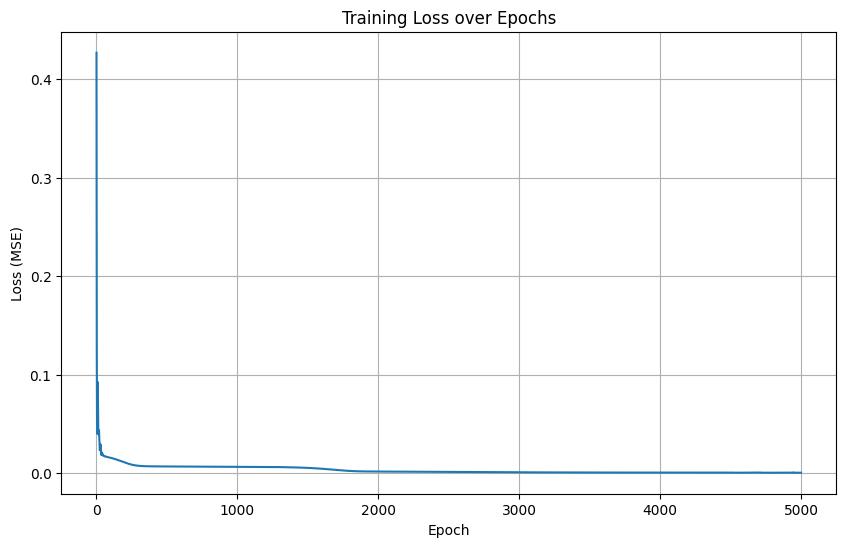

In [15]:
# prompt: Lossの推移を可視化したい

import matplotlib.pyplot as plt
# Training Loop (with loss tracking)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PointUNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 5000
loss_history = [] # リストを初期化してlossを保存

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_inputs, batch_targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch_inputs = batch_inputs.to(device)    # [B, N, 3]
        batch_targets = batch_targets.to(device)  # [B, N, 1]

        optimizer.zero_grad()
        outputs = model(batch_inputs)             # [B, N, 4]
        loss = criterion(outputs[:, :, 3:], batch_targets)  # 4番目の出力をMSE対象に
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_epoch_loss) # エポックごとの平均lossをリストに追加
    print(f"Epoch {epoch+1} - Loss: {avg_epoch_loss:.6f}")

# Lossの可視化
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()


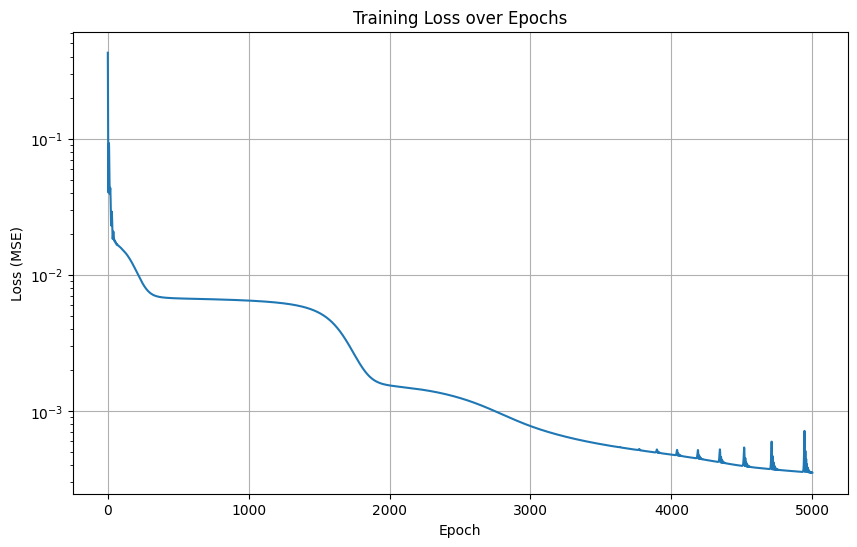

In [18]:
# prompt: plt.yをlogにして

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss over Epochs')
plt.yscale('log')  # ここでy軸を対数スケールに設定
plt.grid(True)
plt.show()


Predicting: 100%|██████████| 1/1 [00:00<00:00, 41.24it/s]



R² Score (Pressure): 0.9935


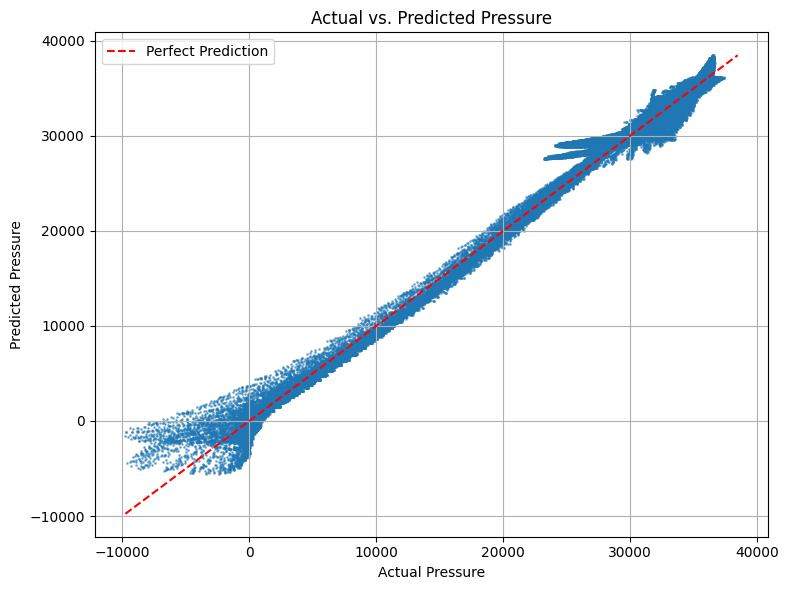

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from tqdm import tqdm
import torch

model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_inputs, batch_targets in tqdm(train_loader, desc="Predicting"):
        batch_inputs = batch_inputs.to(device)    # [B, N, 3]
        batch_targets = batch_targets.to(device)  # [B, N, 1]

        outputs = model(batch_inputs)             # [B, N, 4]
        p_pred = outputs[:, :, 3].cpu().numpy()   # [B, N]
        p_true = batch_targets.squeeze(-1).cpu().numpy()  # [B, N]

        all_predictions.append(p_pred)
        all_targets.append(p_true)

# 結合して評価
predicted_pressure_normalized = np.concatenate(all_predictions, axis=0).flatten()
target_pressure_normalized = np.concatenate(all_targets, axis=0).flatten()

# 元スケールに復元
predicted_pressure_original = train_dataset.inverse_transform(predicted_pressure_normalized)
target_pressure_original = train_dataset.inverse_transform(target_pressure_normalized)

# R²スコア
r2 = r2_score(target_pressure_original, predicted_pressure_original)
print(f"\nR² Score (Pressure): {r2:.4f}")

# 散布図の描画
plt.figure(figsize=(8, 6))
plt.scatter(target_pressure_original, predicted_pressure_original, alpha=0.5, s=1)
plt.xlabel("Actual Pressure")
plt.ylabel("Predicted Pressure")
plt.title("Actual vs. Predicted Pressure")
plt.grid(True)

# 完全一致の赤線
min_val = min(target_pressure_original.min(), predicted_pressure_original.min())
max_val = max(target_pressure_original.max(), predicted_pressure_original.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')
plt.legend()
plt.tight_layout()
plt.show()


Predicting: 100%|██████████| 1/1 [00:00<00:00, 33.39it/s]


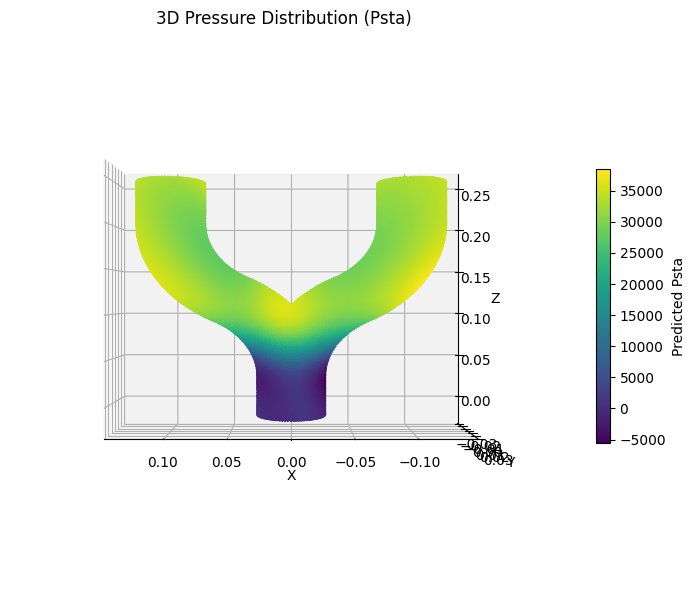

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from tqdm import tqdm
import torch

model.eval()
# ステップ1: モデル出力の収集
all_pred_psta = []  # 推論Psta [B, N]
all_xyz = []        # 座標 [B, N, 3]

model.eval()
with torch.no_grad():
    for batch_inputs, _ in tqdm(train_loader, desc="Predicting"):
        batch_inputs = batch_inputs.to(device)          # [B, N, 3]
        outputs = model(batch_inputs)                   # [B, N, 4]
        p_pred = outputs[:, :, 3].cpu().numpy()         # [B, N]
        xyz = batch_inputs.cpu().numpy()                # [B, N, 3]

        all_pred_psta.append(p_pred.reshape(-1))        # flatten: [B*N]
        all_xyz.append(xyz.reshape(-1, 3))              # flatten: [B*N, 3]

# ステップ2: 結合
psta_norm_flat = np.concatenate(all_pred_psta, axis=0)     # [total_points]
xyz_all = np.concatenate(all_xyz, axis=0)                  # [total_points, 3]

# ステップ3: 正規化解除
psta_original = train_dataset.inverse_transform(psta_norm_flat)  # [total_points]

# ステップ4: 可視化
x, y, z = xyz_all[:, 0], xyz_all[:, 1], xyz_all[:, 2]
assert len(psta_original) == len(x), f"Length mismatch: psta={len(psta_original)}, x={len(x)}"

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x, y, z, c=psta_original, cmap='viridis', s=1)
cbar = plt.colorbar(sc, ax=ax, shrink=0.5)
cbar.set_label('Predicted Psta')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Pressure Distribution (Psta)')
ax.view_init(elev=0, azim=90)
plt.tight_layout()
plt.show()


# Individual scalre Training using U-Net

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad

# --------------------------------------------
# Mish Activation
# --------------------------------------------
def mish(x):
    return x * torch.tanh(F.softplus(x))

# --------------------------------------------
# Kaiming Initialization
# --------------------------------------------
def init_weights_kaiming(module):
    if isinstance(module, nn.Conv1d):
        nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
        if module.bias is not None:
            nn.init.zeros_(module.bias)

# --------------------------------------------
# Simple PointNet-like U-Net Block for Scalar Output
# --------------------------------------------
class ScalarUNet(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 256, 1)

        self.up1 = nn.Conv1d(256 + 128, 128, 1)
        self.up2 = nn.Conv1d(128 + 64, 64, 1)
        self.out = nn.Conv1d(64, 1, 1)

        self.apply(init_weights_xavier)

    def forward(self, x):
        x = x.transpose(1, 2)  # [B, 3, N]
        x1 = mish(self.conv1(x))
        x2 = mish(self.conv2(x1))
        x3 = mish(self.conv3(x2))

        up1 = mish(self.up1(torch.cat([x3, x2], dim=1)))
        up2 = mish(self.up2(torch.cat([up1, x1], dim=1)))
        out = self.out(up2)  # [B, 1, N]
        return out.transpose(1, 2)  # [B, N, 1]

# --------------------------------------------
# Combined Model with 4 U-Nets and Physics Loss
# --------------------------------------------
class PhysicsInformedCFDModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net_u = ScalarUNet()
        self.net_v = ScalarUNet()
        self.net_w = ScalarUNet()
        self.net_p = ScalarUNet()

    def forward(self, coords):
        # coords: [B, N, 3] with requires_grad=True
        u = self.net_u(coords)  # [B, N, 1]
        v = self.net_v(coords)
        w = self.net_w(coords)
        p = self.net_p(coords)
        return u, v, w, p

    def pde_loss(self, coords, u, v, w, p, rho=1.0, mu=1e-3):
        grads_u = grad(u, coords, grad_outputs=torch.ones_like(u), create_graph=True)[0]  # [B, N, 3]
        grads_v = grad(v, coords, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        grads_w = grad(w, coords, grad_outputs=torch.ones_like(w), create_graph=True)[0]
        grads_p = grad(p, coords, grad_outputs=torch.ones_like(p), create_graph=True)[0]

        du_dx = grads_u[:, :, 0]
        dv_dy = grads_v[:, :, 1]
        dw_dz = grads_w[:, :, 2]
        continuity = du_dx + dv_dy + dw_dz  # [B, N]
        loss_cont = torch.mean(continuity ** 2)

        # ラプラシアン項
        def laplacian(f, coords):
            grad_f = grad(f, coords, grad_outputs=torch.ones_like(f), create_graph=True)[0]
            lap = 0
            for i in range(3):
                grad2 = grad(grad_f[:, :, i], coords, grad_outputs=torch.ones_like(grad_f[:, :, i]), create_graph=True)[0][:, :, i]
                lap += grad2
            return lap

        # x方向のNS項（例）
        inertia_u = u * grads_u[:, :, 0] + v * grads_u[:, :, 1] + w * grads_u[:, :, 2]  # advective term
        dp_dx = grads_p[:, :, 0]
        lap_u = laplacian(u, coords)
        ns_res_x = rho * inertia_u + dp_dx - mu * lap_u
        loss_ns_x = torch.mean(ns_res_x ** 2)

        # y方向
        inertia_v = u * grads_v[:, :, 0] + v * grads_v[:, :, 1] + w * grads_v[:, :, 2]
        dp_dy = grads_p[:, :, 1]
        lap_v = laplacian(v, coords)
        ns_res_y = rho * inertia_v + dp_dy - mu * lap_v
        loss_ns_y = torch.mean(ns_res_y ** 2)

        # z方向
        inertia_w = u * grads_w[:, :, 0] + v * grads_w[:, :, 1] + w * grads_w[:, :, 2]
        dp_dz = grads_p[:, :, 2]
        lap_w = laplacian(w, coords)
        ns_res_z = rho * inertia_w + dp_dz - mu * lap_w
        loss_ns_z = torch.mean(ns_res_z ** 2)

        loss_ns = loss_ns_x + loss_ns_y + loss_ns_z
        return loss_cont, loss_ns
